In [1]:
# Parameters
var_list = [
    "cape",
    "crr",
    "d",
    "d",
    "d",
    "ie",
    "ishf",
    "lsrr",
    "pv",
    "pv",
    "pv",
    "q",
    "q",
    "q",
    "r",
    "r",
    "r",
    "sp",
    "tcw",
    "tcwv",
    "t",
    "t",
    "t",
    "ttr",
    "u",
    "u",
    "u",
    "v",
    "v",
    "v",
    "vo",
    "vo",
    "vo",
    "w",
    "w",
    "w",
]
plevel_list = [
    False,
    False,
    300,
    850,
    900,
    False,
    False,
    False,
    300,
    850,
    900,
    300,
    850,
    900,
    300,
    850,
    900,
    False,
    False,
    False,
    300,
    850,
    900,
    False,
    300,
    850,
    900,
    300,
    850,
    900,
    300,
    850,
    900,
    300,
    850,
    900,
]
aew_subset = "12hr_before"
model_save_name = "best_model_300_850_9002.keras"
tuner_project_name = "tuner_run_300_850_9002"


In [2]:
#!/usr/bin/env python

# coding: utf-8


import numpy as np

import matplotlib.pyplot as plt

import xarray as xr

import sklearn

import sklearn.model_selection

import keras

from keras import layers

import keras_tuner



import tensorflow as tf

import tensorflow.keras.backend as K

keras.utils.set_random_seed(812)

2025-07-09 18:33:34.939900: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-07-09 18:33:34.951115: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1752107614.961004   97025 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1752107614.964417   97025 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1752107614.974139   97025 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

In [3]:
import tensorflow as tf

def focal_loss(gamma=2.0, alpha=0.25):
    """Focal Loss for binary classification."""
    def loss_fn(y_true, y_pred):
        # Clip to prevent NaNs 
        y_pred = tf.clip_by_value(y_pred, tf.keras.backend.epsilon(), 1 - tf.keras.backend.epsilon())
        bce = tf.keras.backend.binary_crossentropy(y_true, y_pred)
        p_t = y_true * y_pred + (1 - y_true) * (1 - y_pred)
        modulating_factor = tf.pow(1.0 - p_t, gamma)
        alpha_factor = y_true * alpha + (1 - y_true) * (1 - alpha)
        return alpha_factor * modulating_factor * bce
    return loss_fn


In [4]:
#functions to calculate f1 score as loss function

def f1_loss_sigmoid(y_true, y_pred):
    """

    F1 metric for sigmoid output and integer encoded labels.

"""

    # compute tp, fp, and fn

    tp = K.sum(K.cast(y_true * y_pred, 'float'), axis=0)

    fp = K.sum(K.cast((1 - y_true) * y_pred, 'float'), axis=0)

    fn = K.sum(K.cast(y_true * (1 - y_pred), 'float'), axis=0)


    # precision (tp / (tp + fp))

    p = tp / (tp + fp + K.epsilon())

   # recall (tp / (tp + fn))

    r = tp / (tp + fn + K.epsilon())


# harmonic mean of precision and recall

    f1 = (2 * p * r) / (p + r + K.epsilon())

    f1 = tf.where(tf.math.is_nan(f1), tf.zeros_like(f1), f1)

    return 1 - K.mean(f1)

In [5]:
def f1_loss_onehot(y_true, y_pred):

   """

   F1 metric for two-class output and one-hot encoded labels.

   """

   # compute tp, fp, and fn

   tp = K.sum(K.cast(y_true[:, 1] * y_pred[:, 1], 'float'), axis=0)

   fp = K.sum(K.cast((1 - y_true[:, 1]) * y_pred[:, 1], 'float'), axis=0)

   fn = K.sum(K.cast(y_true[:, 0] * (1 - y_pred[:, 0]), 'float'), axis=0)


   # precision (tp / (tp + fp))

   p = tp / (tp + fp + K.epsilon())

   # recall (tp / (tp + fn))

   r = tp / (tp + fn + K.epsilon())


   # harmonic mean of precision and recall

   f1 = (2 * p * r) / (p + r + K.epsilon())

   f1 = tf.where(tf.math.is_nan(f1), tf.zeros_like(f1), f1)

   return 1 - K.mean(f1)

In [6]:
import re


def add_dim(ds):
    # Extract the source file name from the dataset's encoding.
    fname = ds.encoding.get('source', '')
    # Use a regex to capture the central latitude and longitude from the filename.
    m = re.search(r'_(\-?\d+\.\d+)_(-?\d+\.\d+)\.nc$', fname)
    if m:
        lat_center = float(m.group(1))
        lon_center = float(m.group(2))
        # Assign the central coordinates and the file name as new coordinates.
        ds = ds.assign_coords(lat_center=lat_center, lon_center=lon_center, file_name=fname)
    else:
        print("File name does not match expected pattern:", fname)
    
    # Expand dims to add the 'sample' dimension and drop unnecessary variables.
    return ds.assign_coords({"sample": 1}).expand_dims(dim={"sample": 1}).drop_vars("utc_date").drop_vars("latitude").drop_vars("longitude")




    

In [7]:
import os
import xarray as xr

def open_files_zarr(list_of_vars, aew_subset="12hr_before",
                    directory="/glade/derecho/scratch/rmandava/AEW_time_location_files/",
                    plevel_list=None, zarr_store_path="zarr_data"):
    """
    Opens ERA5 NetCDF files for the given variables. For each variable (or pressure-level variant),
    it checks if a corresponding Zarr store exists in 'zarr_store_path'. If so, it loads the dataset
    from the Zarr store; if not, it opens the NetCDF files, preprocesses them, saves them to Zarr,
    and then returns the dataset.
    """
    # Create the zarr_store_path directory if it doesn't exist.
    if not os.path.exists(zarr_store_path):
        os.makedirs(zarr_store_path)
    
    datas = {}
    for num, var in enumerate(list_of_vars):
        # Determine the key and filename based on whether a pressure level is specified.
        if plevel_list:
            if plevel_list[num]:
                key = f"{var}_{int(plevel_list[num])}"
                file_pattern = f'{directory}/{var}/aew_{aew_subset}_{int(plevel_list[num])}_*.nc'
            else:
                key = var
                file_pattern = f'{directory}/{var}/aew_{aew_subset}_*.nc'
        else:
            key = var
            file_pattern = f'{directory}/{var}/aew_{aew_subset}_*.nc'
        
        # Define the zarr path for this variable.
        zarr_path = os.path.join(zarr_store_path, f"{key}.zarr")
        
        # If the Zarr dataset exists, load from it; otherwise, create it.
        if os.path.exists(zarr_path):
            print(f"Loading {key} from Zarr store.")
            ds = xr.open_zarr(zarr_path)
        else:
            print(f"Creating Zarr store for {key} from NetCDF files.")
            ds = xr.open_mfdataset(
                file_pattern,
                preprocess=add_dim,
                concat_dim="sample",
                combine="nested",
            )
            ds.to_zarr(zarr_path, mode="w")
        datas[key] = ds
    
    return datas


In [8]:
def transpose_load_concat(data_dictionary):
    # Instead of eagerly converting to NumPy arrays, keep the datasets as xarray objects.
    transposed = {}
    for key, ds in data_dictionary.items():
        var_name = key.split('_')[0].upper()
        # Do lazy transpose and add a 'features' dimension
        transposed[key] = ds[var_name].expand_dims('features').transpose('sample', 'latitude', 'longitude', 'features')
    # Concatenate along the new 'features' dimension (if multiple variables exist)
    if len(transposed) > 1:
        data = xr.concat(list(transposed.values()), dim='features',coords='minimal',compat='override')
    else:
        data = list(transposed.values())[0]
    # Use the coordinates (lat_center, lon_center) from one of the datasets.
    # They remain lazy and are not computed until needed.
    first_key = next(iter(data_dictionary))
    lat_center = data_dictionary[first_key]['lat_center']
    lon_center = data_dictionary[first_key]['lon_center']
    label = data_dictionary[first_key]['label']
    return data, label, lat_center, lon_center



In [9]:
def omit_nans(data, label, lat, lon):
    # If data is an xarray DataArray, convert it to a NumPy array
    if hasattr(data, 'values'):
        data = data.values
    maskarray = np.full(data.shape[0], True)
    # Find indices where NaNs occur
    masker = np.unique(np.argwhere(np.isnan(data))[:, 0])
    maskarray[masker] = False

    traindata = data[maskarray, ...]
    trainlabel = label[maskarray]
    lat_filtered = lat[maskarray]
    lon_filtered = lon[maskarray]
    return traindata, trainlabel, lat_filtered, lon_filtered



In [10]:
def zscore(data):

  """

  Rescaling the data using zscore (mean/std).

  Each variable gets scaled independently from others.

  Note that we will need to remove test data for formal training.

  """

  for i in range(0, data_.shape[-1]):

      data_[:, :, :, i] = (

               data_[:, :, :, i] - np.nanmean(

                     data_[:, :, :, i])) / np.nanstd(data_[:, :, :, i])

  return data_

In [11]:
def minmax(data):

   """

   Rescaling the data using min-max.

   Each variable gets scaled independently from others.

   Note that we will need to remove test data for formal training.

   """

   for i in range(0, data_.shape[-1]):

          data_[:, :, :, i] = (

              data_[:, :, :, i] - np.nanmin(data_[:, :, :, i])

          ) / (np.nanmax(data_[:, :, :, i]) - np.nanmin(data_[:, :, :, i]))
   return data

In [12]:
def random_split(data, label, split=0.3, seed=0):

   """

   Help spliting data randomly for training and testing.

   """

   np.random.seed(0)

   da_indx = np.random.permutation(data.shape[0])

   data = data[da_indx.astype(int)]

   label = label[da_indx.astype(int)]

   init_range = int(data.shape[0] * (1 - 0.3))

   return data[:init_range], label[:init_range], data[init_range:], label[init_range:]

In [13]:
def pick_loss(loss_string):
    

    lossdict = {
        "relu": tf.nn.relu,
        "tanh": tf.nn.tanh,
        "selu": tf.nn.selu,
        "sigmoid": tf.nn.sigmoid,
        "relu6": tf.nn.relu6,
        "silu": tf.nn.silu,
        "gelu": tf.nn.gelu,
        "lrelu": tf.nn.leaky_relu,
    }

    return lossdict[loss_string]

In [14]:
def compute_saliency_map(model, input_sample):
    """
    Compute a saliency map for a given input sample using a gradient-based approach.
    
    Args:
        model (tf.keras.Model): The trained Keras model.
        input_sample (numpy array): A single input sample of shape (1, height, width, channels).
    
    Returns:
        saliency (numpy array): The saliency map of shape (height, width).
    """
    # Ensure the model is in inference mode
    model.trainable = False
    input_tensor = tf.convert_to_tensor(input_sample)
    
    # Use GradientTape to record operations for automatic differentiation
    with tf.GradientTape() as tape:
        # Watch the input tensor
        tape.watch(input_tensor)
        # Get the model's prediction
        prediction = model(input_tensor)
    
    # Compute gradients of the prediction with respect to the input
    grads = tape.gradient(prediction, input_tensor)
    
    # If there are multiple channels, take the maximum absolute gradient across channels
    saliency = np.max(np.abs(grads.numpy()), axis=-1)[0]
    return saliency

In [15]:
def compute_saliency_per_channel(model, input_sample):
    """
    Computes the saliency map for each channel of a given input sample.
    
    Args:
        model (tf.keras.Model): The trained Keras model.
        input_sample (numpy array): A single input sample with shape (1, H, W, C).
        
    Returns:
        saliency_maps (numpy array): Absolute gradients with shape (H, W, C) for each channel.
        channel_importance (numpy array): Mean saliency per channel (shape: (C,)).
    """
    # Set the model to inference mode
    model.trainable = False
    input_tensor = tf.convert_to_tensor(input_sample)
    
    # Compute gradients with respect to the input sample using GradientTape
    with tf.GradientTape() as tape:
        tape.watch(input_tensor)
        prediction = model(input_tensor)
    
    # Calculate gradients: shape (1, H, W, C)
    grads = tape.gradient(prediction, input_tensor)
    
    # Remove the batch dimension: shape becomes (H, W, C)
    grads = grads.numpy()[0]
    
    # Take absolute value to measure importance (magnitude of sensitivity)
    saliency_maps = np.abs(grads)
    
    # Aggregate saliency per channel (e.g., using the mean over spatial dimensions)
    channel_importance = np.mean(saliency_maps, axis=(0, 1))
    
    return saliency_maps, channel_importance

In [16]:
number_of_features = len(var_list)

In [17]:
data = open_files_zarr(
    list_of_vars=var_list,
    aew_subset=aew_subset,
    directory="/glade/derecho/scratch/rmandava/AEW_time_location_files/",
    plevel_list=plevel_list,
    zarr_store_path="/glade/derecho/scratch/rmandava/AEW_time_location_files/Project1/zarr"
)






Loading cape from Zarr store.


Loading crr from Zarr store.
Loading d_300 from Zarr store.
Loading d_850 from Zarr store.
Loading d_900 from Zarr store.
Loading ie from Zarr store.


Loading ishf from Zarr store.
Loading lsrr from Zarr store.
Loading pv_300 from Zarr store.
Loading pv_850 from Zarr store.


Loading pv_900 from Zarr store.
Loading q_300 from Zarr store.
Loading q_850 from Zarr store.
Loading q_900 from Zarr store.


Loading r_300 from Zarr store.
Loading r_850 from Zarr store.
Loading r_900 from Zarr store.
Loading sp from Zarr store.
Loading tcw from Zarr store.


Loading tcwv from Zarr store.
Loading t_300 from Zarr store.
Loading t_850 from Zarr store.
Loading t_900 from Zarr store.


Loading ttr from Zarr store.
Loading u_300 from Zarr store.
Loading u_850 from Zarr store.
Loading u_900 from Zarr store.
Loading v_300 from Zarr store.


Loading v_850 from Zarr store.
Loading v_900 from Zarr store.
Loading vo_300 from Zarr store.
Loading vo_850 from Zarr store.


Loading vo_900 from Zarr store.
Loading w_300 from Zarr store.
Loading w_850 from Zarr store.
Loading w_900 from Zarr store.


In [18]:
# transpose the data and concat variables

#data_, labels_ = transpose_load_concat(data)
data_, labels_, sample_lat, sample_lon = transpose_load_concat(data)

print(np.shape(data_))

(2750, 32, 32, 36)


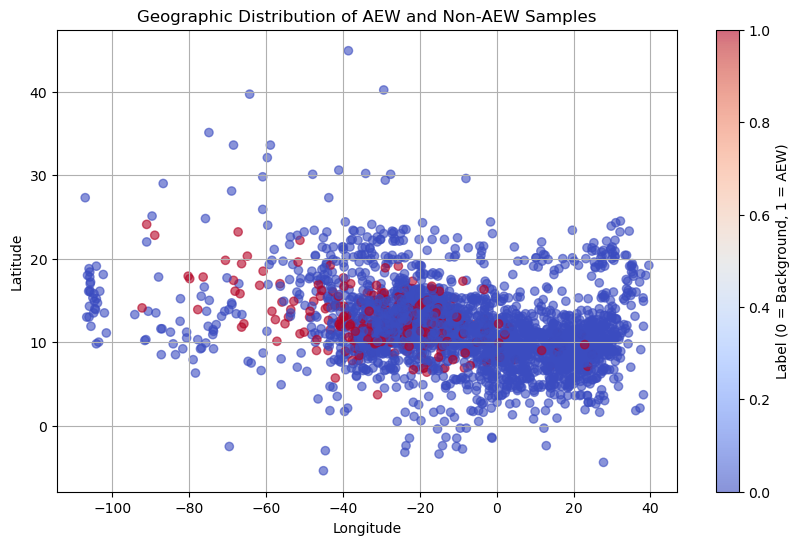

In [19]:
import matplotlib.pyplot as plt

# Scatter plot: where are the samples located, colored by label (AEW or not)
plt.figure(figsize=(10, 6))
sc = plt.scatter(sample_lon, sample_lat, c=labels_, cmap='coolwarm', alpha=0.6)
plt.colorbar(sc, label="Label (0 = Background, 1 = AEW)")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("Geographic Distribution of AEW and Non-AEW Samples")
plt.grid(True)
plt.show()


In [20]:
print(var_list)


['cape', 'crr', 'd', 'd', 'd', 'ie', 'ishf', 'lsrr', 'pv', 'pv', 'pv', 'q', 'q', 'q', 'r', 'r', 'r', 'sp', 'tcw', 'tcwv', 't', 't', 't', 'ttr', 'u', 'u', 'u', 'v', 'v', 'v', 'vo', 'vo', 'vo', 'w', 'w', 'w']


In [21]:
# check / remove nans

data_, labels_, sample_lat, sample_lon = omit_nans(data_, labels_, sample_lat, sample_lon)






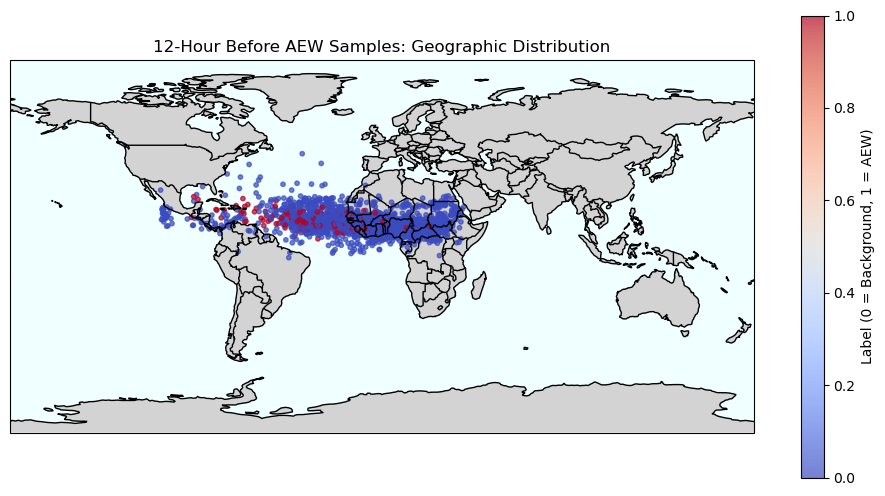

In [22]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

plt.figure(figsize=(12, 6))

# Set up map projection
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_global()
ax.coastlines()
ax.add_feature(cfeature.BORDERS)
ax.add_feature(cfeature.LAND, facecolor='lightgray')
ax.add_feature(cfeature.OCEAN, facecolor='azure')

# Plot sample locations colored by label
sc = ax.scatter(sample_lon, sample_lat, c=labels_, cmap='coolwarm', s=10, alpha=0.7, transform=ccrs.PlateCarree())
plt.colorbar(sc, ax=ax, label="Label (0 = Background, 1 = AEW)")
plt.title("12-Hour Before AEW Samples: Geographic Distribution")
plt.show()

In [23]:
print("Total samples:", len(sample_lat))


Total samples: 2750


In [24]:
print("Latitude Range:", float(sample_lat.min().compute()), "to", float(sample_lat.max().compute()))
print("Longitude Range:", float(sample_lon.min().compute()), "to", float(sample_lon.max().compute()))


Latitude Range: -5.4 to 44.9
Longitude Range: -107.1 to 39.6


In [25]:
#split train and test set
X_train, X_test, y_train, y_test, lat_train, lat_test, lon_train, lon_test = sklearn.model_selection.train_test_split(
    data_, labels_, sample_lat, sample_lon, test_size=0.2, random_state=42)



print (np.shape(X_train), np.shape(X_test), np.shape(y_train), np.shape(y_test))


y_train = np.expand_dims(y_train, axis=1)

y_test = np.expand_dims(y_test, axis=1)

(2200, 32, 32, 36) (550, 32, 32, 36) (2200,) (550,)


/glade/u/home/rmandava/.local/lib/python3.10/site-packages/xarray/core/indexing.py:1642: PerformanceWarning: Slicing with an out-of-order index is generating 412 times more chunks
  return self.array[key]
/glade/u/home/rmandava/.local/lib/python3.10/site-packages/xarray/core/indexing.py:1642: PerformanceWarning: Slicing with an out-of-order index is generating 109 times more chunks
  return self.array[key]


In [26]:
# [21]: Scaling code (fixed to prevent data leakage)

# Create the scaler object
scaler_input = sklearn.preprocessing.StandardScaler()

# Reshape training data to 2D (samples, features)
X_train_tmp = np.reshape(X_train, (-1, len(var_list)))

# Fit the scaler ONLY on the training data
scaler_input.fit(X_train_tmp)  # <-- Key change: Learn mean/std from training data

# Transform BOTH training and test data using the SAME scaler
input_train_scaled = scaler_input.transform(X_train_tmp)          # Train: transform only
input_test_scaled = scaler_input.transform(                       # Test: transform only
    np.reshape(X_test, (-1, len(var_list)))
)

# Reshape back to original dimensions (samples, height, width, features)
input_train_scaled = np.reshape(input_train_scaled, X_train.shape)
input_test_scaled = np.reshape(input_test_scaled, X_test.shape)

# Labels remain unchanged
label_train_scaled = y_train
label_test_scaled = y_test

In [27]:
# print the shapes to double check them

print(

input_train_scaled.shape,

label_train_scaled.shape,

input_test_scaled.shape,

label_test_scaled.shape

)

(2200, 32, 32, 36) (2200, 1) (550, 32, 32, 36) (550, 1)


In [28]:
#generate class weights due to class imbalance issues

counts = np.bincount(y_train[:, 0].astype(int))


print(

"Number of positive samples in training data: {} ({:.2f}% of total)".format(

counts[1], 100 * float(counts[1]) / len(y_train))

)

Number of positive samples in training data: 204 (9.27% of total)


In [29]:
# old weights

# weight_for_0 = 1.0 / counts[0]

# weight_for_1 = 1.0 / counts[1]


#new weights

weight_for_0 = float(counts[1]) / len(y_train)

weight_for_1 = 1 - (float(counts[1]) / len(y_train))


class_weight = {0: weight_for_0, 1: weight_for_1}

print(class_weight)

{0: 0.09272727272727273, 1: 0.9072727272727272}


In [30]:
METRICS = [

keras.metrics.BinaryCrossentropy(name='cross entropy'),

keras.metrics.MeanSquaredError(name='mean_squared_error'),

keras.metrics.RootMeanSquaredError(name='root_mean_squared_error'),

keras.metrics.TruePositives(name='tp'),

keras.metrics.FalsePositives(name='fp'),

keras.metrics.TrueNegatives(name='tn'),

keras.metrics.FalseNegatives(name='fn'),

keras.metrics.BinaryAccuracy(name='binary_accuracy'),

keras.metrics.F1Score(threshold=0.5, name='f1_score'),

keras.metrics.Precision(name='precision'),

keras.metrics.Recall(name='recall'),

keras.metrics.AUC(name='auc'),

keras.metrics.AUC(name='prc', curve='PR'),

]

2025-07-09 18:36:11.919053: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


In [31]:
class MyHyperModel(keras_tuner.HyperModel):
    def build(self, hp):
        model = keras.Sequential()

        model.add(keras.Input(shape=(32, 32, number_of_features)))

        # Data augmentation
        model.add(layers.RandomFlip("horizontal_and_vertical"))
        model.add(layers.RandomRotation(factor=(-0.5, 0.5)))

        # CNN layers (same tuning as before)
        featmaps1 = hp.Int('units_1', min_value=10, max_value=60)
        featmaps2 = hp.Int('units_2', min_value=10, max_value=64)
        featmaps3 = hp.Int('units_3', min_value=10, max_value=128)
        featmaps4 = hp.Int('units_4', min_value=10, max_value=80)
        learning_rate = hp.Float('lr', min_value=0.00001, max_value=0.01, sampling="linear")
        act_func = hp.Choice('activation', ["relu", "tanh", "selu", "sigmoid", "relu6", "silu", "gelu"])

        model.add(layers.Conv2D(featmaps1, 3, strides=1, padding="same", activation=pick_loss(act_func)))
        model.add(layers.MaxPooling2D(2))
        model.add(layers.Dropout(0.2))

        model.add(layers.Conv2D(featmaps2, 3, strides=1, padding="same", activation=pick_loss(act_func)))
        model.add(layers.MaxPooling2D(2))
        model.add(layers.Dropout(0.2))

        model.add(layers.Conv2D(featmaps3, 3, strides=1, padding="same", activation=pick_loss(act_func)))
        model.add(layers.MaxPooling2D(2))
        model.add(layers.Dropout(0.2))

        model.add(layers.GlobalMaxPooling2D())
        model.add(layers.Dense(featmaps4))
        model.add(layers.Dense(1, activation="sigmoid"))

        
        

        model.compile(
            optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
            loss=focal_loss(gamma=2.0, alpha=0.25),  # pass tuned gamma and alpha!
            metrics=METRICS
        )

        return model



In [32]:
def fit(self, hp, model, *args, **kwargs):
    batchsizenum = hp.Int('batch_size', min_value=10, max_value=60, step=5, sampling="linear")

    print({k: hp.get(k) if hp.is_active(k) else None for k in hp._hps})

    return model.fit(
        *args,
        batch_size=batchsizenum,
        # normally we might use early stopping, but not needed since
        # callbacks saves checkpoints of the model during trials
        # callbacks=keras.callbacks.EarlyStopping('val_loss', patience=5),
        validation_split=0.1,
        shuffle=True,
        class_weight=class_weight,
        **kwargs,
    )


In [33]:
# make the tuner object
tuner = keras_tuner.BayesianOptimization(
    hypermodel=MyHyperModel(),
    objective=keras_tuner.Objective("val_f1_score", direction="max"),
    max_trials=150,
    project_name=tuner_project_name,
    alpha=0.0001,
    beta=2.6,
    seed=123,
    tune_new_entries=True,
    allow_new_entries=True,
    max_retries_per_trial=1,
    max_consecutive_failed_trials=3,
    overwrite=True,
)

# summary
tuner.search_space_summary()


Search space summary
Default search space size: 6
units_1 (Int)
{'default': None, 'conditions': [], 'min_value': 10, 'max_value': 60, 'step': 1, 'sampling': 'linear'}
units_2 (Int)
{'default': None, 'conditions': [], 'min_value': 10, 'max_value': 64, 'step': 1, 'sampling': 'linear'}
units_3 (Int)
{'default': None, 'conditions': [], 'min_value': 10, 'max_value': 128, 'step': 1, 'sampling': 'linear'}
units_4 (Int)
{'default': None, 'conditions': [], 'min_value': 10, 'max_value': 80, 'step': 1, 'sampling': 'linear'}
lr (Float)
{'default': 1e-05, 'conditions': [], 'min_value': 1e-05, 'max_value': 0.01, 'step': None, 'sampling': 'linear'}
activation (Choice)
{'default': 'relu', 'conditions': [], 'values': ['relu', 'tanh', 'selu', 'sigmoid', 'relu6', 'silu', 'gelu'], 'ordered': False}


In [34]:
import numpy as np

labels_np = np.array(labels_)

total = len(labels_np)
positives = np.sum(labels_np == 1)
negatives = np.sum(labels_np == 0)

print("Total samples:", total)
print("AEW-positive samples (label=1):", positives)
print("Background samples (label=0):", negatives)


Total samples: 2750
AEW-positive samples (label=1): 258
Background samples (label=0): 2492


In [35]:
# Begin the search
EPOCHS = 100

tuner.search(
    input_train_scaled,
    label_train_scaled,
    epochs=EPOCHS,
    validation_split=0.1
)

# Query the tuner object to grab the best models
models = tuner.get_best_models(num_models=5)

# Here is the best model from the tuner
best_model = models[0]
print(best_model.summary())

# Get the top hyperparameters.
best_hps = tuner.get_best_hyperparameters()

# Build the model with the best hyperparameters.
# Assuming your MyHyperModel has a build method that takes a hyperparameter object.
model = MyHyperModel().build(best_hps[0])

# Save the best model (architecture and weights)

save_dir = "/glade/derecho/scratch/rmandava/AEW_time_location_files/models"
model_save_path = os.path.join(save_dir, model_save_name)

model.save(model_save_path)


# Retrain using "best" model hyperparameters
history = model.fit(
    input_train_scaled,
    label_train_scaled,
    epochs=EPOCHS,
    validation_split=0.1,
    batch_size= 32,
    # callbacks=keras.callbacks.EarlyStopping('val_loss', patience=3),
    shuffle=True,
    class_weight=class_weight,  # Ensure 'class_weight' is defined in your scope
)

# Evaluate the model on the test data using `evaluate`
results = model.evaluate(input_test_scaled, label_test_scaled, batch_size=label_test_scaled.shape[0])
print(results)

# Generate predictions (probabilities—the output of the last layer)
predictions = model.predict(input_test_scaled)
print("predictions shape:", predictions.shape)

# Compute confusion matrix elements
tn, fp, fn, tp = sklearn.metrics.confusion_matrix(
    label_test_scaled, np.round(predictions)
).ravel()
print("tn:", tn)
print("fp:", fp)
print("fn:", fn)
print("tp:", tp)


Trial 150 Complete [00h 01m 12s]
val_f1_score: 0.7499999403953552

Best val_f1_score So Far: 0.8333332538604736
Total elapsed time: 03h 01m 14s


/glade/u/home/rmandava/.local/lib/python3.10/site-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 22 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ random_flip (RandomFlip)             │ (None, 32, 32, 36)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ random_rotation (RandomRotation)     │ (None, 32, 32, 36)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 32, 32, 18)          │           5,850 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 16, 16, 18)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 16, 16, 18)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 16, 16, 57)          │           9,291 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 8, 8, 57)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 8, 8, 57)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 8, 8, 10)            │           5,140 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 4, 4, 10)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 4, 4, 10)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_max_pooling2d                 │ (None, 10)                  │               0 │
│ (GlobalMaxPooling2D)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 57)                  │             627 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              58 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 20,966 (81.90 KB)

 Trainable params: 20,966 (81.90 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 1:30 1s/step - auc: 0.8409 - binary_accuracy: 0.9365 - cross entropy: 0.2481 - f1_score: 0.2727 - fn: 12.0000 - fp: 4.0000 - loss: 0.0101 - mean_squared_error: 0.0631 - prc: 0.3583 - precision: 0.4286 - recall: 0.2000 - root_mean_squared_error: 0.2511 - tn: 233.0000 - tp: 3.0000

 6/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.7828 - binary_accuracy: 0.9337 - cross entropy: 0.3050 - f1_score: 0.2190 - fn: 17.6667 - fp: 4.5000 - loss: 0.0104 - mean_squared_error: 0.0842 - prc: 0.2707 - precision: 0.4018 - recall: 0.1516 - root_mean_squared_error: 0.2893 - tn: 306.8333 - tp: 3.0000

12/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.7649 - binary_accuracy: 0.9269 - cross entropy: 0.3405 - f1_score: 0.2018 - fn: 24.9167 - fp: 7.3333 - loss: 0.0104 - mean_squared_error: 0.0973 - prc: 0.2549 - precision: 0.3630 - recall: 0.1407 - root_mean_squared_error: 0.3107 - tn: 391.7500 - tp: 4.0000

18/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.7592 - binary_accuracy: 0.9158 - cross entropy: 0.3666 - f1_score: 0.2093 - fn: 31.8889 - fp: 15.0556 - loss: 0.0106 - mean_squared_error: 0.1073 - prc: 0.2492 - precision: 0.3317 - recall: 0.1584 - root_mean_squared_error: 0.3260 - tn: 470.6667 - tp: 6.3889

24/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.7586 - binary_accuracy: 0.9075 - cross entropy: 0.3846 - f1_score: 0.2234 - fn: 38.9583 - fp: 23.0000 - loss: 0.0107 - mean_squared_error: 0.1142 - prc: 0.2522 - precision: 0.3220 - recall: 0.1797 - root_mean_squared_error: 0.3363 - tn: 548.3750 - tp: 9.6667

30/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.7622 - binary_accuracy: 0.9013 - cross entropy: 0.3974 - f1_score: 0.2460 - fn: 44.8333 - fp: 31.9000 - loss: 0.0107 - mean_squared_error: 0.1191 - prc: 0.2610 - precision: 0.3253 - recall: 0.2107 - root_mean_squared_error: 0.3436 - tn: 624.6334 - tp: 14.6333

36/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.7667 - binary_accuracy: 0.8973 - cross entropy: 0.4063 - f1_score: 0.2643 - fn: 49.8056 - fp: 40.4722 - loss: 0.0107 - mean_squared_error: 0.1224 - prc: 0.2694 - precision: 0.3283 - recall: 0.2370 - root_mean_squared_error: 0.3485 - tn: 702.2500 - tp: 19.4722

42/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.7712 - binary_accuracy: 0.8952 - cross entropy: 0.4116 - f1_score: 0.2810 - fn: 54.8095 - fp: 47.4762 - loss: 0.0106 - mean_squared_error: 0.1243 - prc: 0.2779 - precision: 0.3350 - recall: 0.2586 - root_mean_squared_error: 0.3513 - tn: 781.3333 - tp: 24.3810 

48/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.7760 - binary_accuracy: 0.8938 - cross entropy: 0.4155 - f1_score: 0.2976 - fn: 59.5417 - fp: 54.3125 - loss: 0.0106 - mean_squared_error: 0.1257 - prc: 0.2879 - precision: 0.3434 - recall: 0.2794 - root_mean_squared_error: 0.3533 - tn: 860.2292 - tp: 29.9167

54/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.7796 - binary_accuracy: 0.8924 - cross entropy: 0.4186 - f1_score: 0.3093 - fn: 63.9630 - fp: 61.8333 - loss: 0.0105 - mean_squared_error: 0.1268 - prc: 0.2918 - precision: 0.3475 - recall: 0.2961 - root_mean_squared_error: 0.3550 - tn: 939.3148 - tp: 34.8889

60/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.7829 - binary_accuracy: 0.8914 - cross entropy: 0.4208 - f1_score: 0.3185 - fn: 68.3167 - fp: 69.1000 - loss: 0.0104 - mean_squared_error: 0.1275 - prc: 0.2947 - precision: 0.3504 - recall: 0.3095 - root_mean_squared_error: 0.3561 - tn: 1019.0500 - tp: 39.5333

62/62 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - auc: 0.7840 - binary_accuracy: 0.8910 - cross entropy: 0.4216 - f1_score: 0.3220 - fn: 70.7778 - fp: 72.4127 - loss: 0.0104 - mean_squared_error: 0.1277 - prc: 0.2956 - precision: 0.3515 - recall: 0.3143 - root_mean_squared_error: 0.3565 - tn: 1058.5714 - tp: 41.6032 - val_auc: 0.8870 - val_binary_accuracy: 0.9273 - val_cross entropy: 0.4340 - val_f1_score: 0.4286 - val_fn: 7.0000 - val_fp: 9.0000 - val_loss: 0.0450 - val_mean_squared_error: 0.1286 - val_prc: 0.4167 - val_precision: 0.4000 - val_recall: 0.4615 - val_root_mean_squared_error: 0.3586 - val_tn: 198.0000 - val_tp: 6.0000


Epoch 2/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - auc: 0.9833 - binary_accuracy: 0.9375 - cross entropy: 0.4198 - f1_score: 0.5000 - fn: 1.0000 - fp: 1.0000 - loss: 0.0058 - mean_squared_error: 0.1211 - prc: 0.7973 - precision: 0.5000 - recall: 0.5000 - root_mean_squared_error: 0.3480 - tn: 29.0000 - tp: 1.0000

 7/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8965 - binary_accuracy: 0.9113 - cross entropy: 0.4580 - f1_score: 0.4234 - fn: 4.2857 - fp: 7.1429 - loss: 0.0073 - mean_squared_error: 0.1389 - prc: 0.4334 - precision: 0.3788 - recall: 0.4874 - root_mean_squared_error: 0.3725 - tn: 112.1429 - tp: 4.4286

13/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8835 - binary_accuracy: 0.9135 - cross entropy: 0.4635 - f1_score: 0.4635 - fn: 8.2308 - fp: 11.0000 - loss: 0.0076 - mean_squared_error: 0.1414 - prc: 0.4451 - precision: 0.4284 - recall: 0.5107 - root_mean_squared_error: 0.3759 - tn: 195.3846 - tp: 9.3846

19/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8779 - binary_accuracy: 0.9134 - cross entropy: 0.4642 - f1_score: 0.4781 - fn: 13.0000 - fp: 14.6316 - loss: 0.0079 - mean_squared_error: 0.1417 - prc: 0.4465 - precision: 0.4553 - recall: 0.5096 - root_mean_squared_error: 0.3764 - tn: 278.4211 - tp: 13.9474

25/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8706 - binary_accuracy: 0.9106 - cross entropy: 0.4642 - f1_score: 0.4794 - fn: 18.8800 - fp: 19.2000 - loss: 0.0082 - mean_squared_error: 0.1419 - prc: 0.4501 - precision: 0.4656 - recall: 0.5001 - root_mean_squared_error: 0.3766 - tn: 359.2800 - tp: 18.6400

31/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8681 - binary_accuracy: 0.9063 - cross entropy: 0.4650 - f1_score: 0.4833 - fn: 23.2903 - fp: 27.1290 - loss: 0.0083 - mean_squared_error: 0.1423 - prc: 0.4564 - precision: 0.4644 - recall: 0.5095 - root_mean_squared_error: 0.3772 - tn: 436.7097 - tp: 24.8710

38/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8662 - binary_accuracy: 0.9027 - cross entropy: 0.4637 - f1_score: 0.4830 - fn: 28.3684 - fp: 36.1579 - loss: 0.0084 - mean_squared_error: 0.1419 - prc: 0.4575 - precision: 0.4592 - recall: 0.5146 - root_mean_squared_error: 0.3766 - tn: 528.3421 - tp: 31.1316

45/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8645 - binary_accuracy: 0.8998 - cross entropy: 0.4611 - f1_score: 0.4830 - fn: 33.8444 - fp: 44.8444 - loss: 0.0085 - mean_squared_error: 0.1409 - prc: 0.4594 - precision: 0.4564 - recall: 0.5175 - root_mean_squared_error: 0.3753 - tn: 619.6889 - tp: 37.6222

52/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8639 - binary_accuracy: 0.8975 - cross entropy: 0.4590 - f1_score: 0.4828 - fn: 38.7500 - fp: 54.0962 - loss: 0.0086 - mean_squared_error: 0.1401 - prc: 0.4588 - precision: 0.4527 - recall: 0.5216 - root_mean_squared_error: 0.3742 - tn: 711.1154 - tp: 44.0385

59/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8636 - binary_accuracy: 0.8960 - cross entropy: 0.4569 - f1_score: 0.4827 - fn: 43.1186 - fp: 63.2203 - loss: 0.0086 - mean_squared_error: 0.1393 - prc: 0.4551 - precision: 0.4493 - recall: 0.5262 - root_mean_squared_error: 0.3732 - tn: 803.4237 - tp: 50.2373

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - auc: 0.8627 - binary_accuracy: 0.8954 - cross entropy: 0.4554 - f1_score: 0.4826 - fn: 45.8413 - fp: 67.7619 - loss: 0.0086 - mean_squared_error: 0.1387 - prc: 0.4529 - precision: 0.4481 - recall: 0.5273 - root_mean_squared_error: 0.3724 - tn: 856.2222 - tp: 53.5397 - val_auc: 0.9032 - val_binary_accuracy: 0.9409 - val_cross entropy: 0.3875 - val_f1_score: 0.4800 - val_fn: 7.0000 - val_fp: 6.0000 - val_loss: 0.0364 - val_mean_squared_error: 0.1094 - val_prc: 0.5138 - val_precision: 0.5000 - val_recall: 0.4615 - val_root_mean_squared_error: 0.3307 - val_tn: 201.0000 - val_tp: 6.0000


Epoch 3/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - auc: 1.0000 - binary_accuracy: 0.9688 - cross entropy: 0.3923 - f1_score: 0.8000 - fn: 0.0000e+00 - fp: 1.0000 - loss: 0.0048 - mean_squared_error: 0.1103 - prc: 1.0000 - precision: 0.6667 - recall: 1.0000 - root_mean_squared_error: 0.3322 - tn: 29.0000 - tp: 2.0000

 6/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9325 - binary_accuracy: 0.9205 - cross entropy: 0.4135 - f1_score: 0.5332 - fn: 2.8333 - fp: 6.6667 - loss: 0.0061 - mean_squared_error: 0.1201 - prc: 0.6163 - precision: 0.4410 - recall: 0.6874 - root_mean_squared_error: 0.3465 - tn: 97.6667 - tp: 4.8333    

12/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9110 - binary_accuracy: 0.9195 - cross entropy: 0.4215 - f1_score: 0.5191 - fn: 6.9167 - fp: 10.3333 - loss: 0.0067 - mean_squared_error: 0.1235 - prc: 0.5813 - precision: 0.4582 - recall: 0.6133 - root_mean_squared_error: 0.3514 - tn: 181.7500 - tp: 9.0000

19/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8973 - binary_accuracy: 0.9169 - cross entropy: 0.4289 - f1_score: 0.5247 - fn: 11.7895 - fp: 15.6316 - loss: 0.0072 - mean_squared_error: 0.1268 - prc: 0.5548 - precision: 0.4770 - recall: 0.5947 - root_mean_squared_error: 0.3560 - tn: 277.4211 - tp: 15.1579

26/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8877 - binary_accuracy: 0.9136 - cross entropy: 0.4326 - f1_score: 0.5240 - fn: 17.9231 - fp: 21.0769 - loss: 0.0076 - mean_squared_error: 0.1285 - prc: 0.5368 - precision: 0.4880 - recall: 0.5764 - root_mean_squared_error: 0.3583 - tn: 371.5385 - tp: 21.4615

33/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8832 - binary_accuracy: 0.9086 - cross entropy: 0.4358 - f1_score: 0.5214 - fn: 22.7879 - fp: 30.3030 - loss: 0.0078 - mean_squared_error: 0.1300 - prc: 0.5241 - precision: 0.4824 - recall: 0.5760 - root_mean_squared_error: 0.3604 - tn: 462.2727 - tp: 28.6364

39/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8819 - binary_accuracy: 0.9066 - cross entropy: 0.4362 - f1_score: 0.5221 - fn: 26.4615 - fp: 37.2051 - loss: 0.0079 - mean_squared_error: 0.1302 - prc: 0.5199 - precision: 0.4810 - recall: 0.5784 - root_mean_squared_error: 0.3607 - tn: 541.7180 - tp: 34.6154

46/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8810 - binary_accuracy: 0.9051 - cross entropy: 0.4352 - f1_score: 0.5240 - fn: 31.4348 - fp: 44.1087 - loss: 0.0080 - mean_squared_error: 0.1298 - prc: 0.5193 - precision: 0.4833 - recall: 0.5785 - root_mean_squared_error: 0.3602 - tn: 634.7174 - tp: 41.7391

52/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8804 - binary_accuracy: 0.9040 - cross entropy: 0.4345 - f1_score: 0.5237 - fn: 35.4038 - fp: 50.6346 - loss: 0.0080 - mean_squared_error: 0.1296 - prc: 0.5178 - precision: 0.4823 - recall: 0.5786 - root_mean_squared_error: 0.3599 - tn: 714.5769 - tp: 47.3846

58/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8800 - binary_accuracy: 0.9027 - cross entropy: 0.4339 - f1_score: 0.5221 - fn: 39.1724 - fp: 57.7931 - loss: 0.0081 - mean_squared_error: 0.1293 - prc: 0.5140 - precision: 0.4792 - recall: 0.5787 - root_mean_squared_error: 0.3596 - tn: 794.3104 - tp: 52.7241

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - auc: 0.8787 - binary_accuracy: 0.9021 - cross entropy: 0.4329 - f1_score: 0.5206 - fn: 42.6032 - fp: 62.9365 - loss: 0.0081 - mean_squared_error: 0.1290 - prc: 0.5106 - precision: 0.4775 - recall: 0.5770 - root_mean_squared_error: 0.3591 - tn: 861.0476 - tp: 56.7778 - val_auc: 0.8937 - val_binary_accuracy: 0.9500 - val_cross entropy: 0.3691 - val_f1_score: 0.4211 - val_fn: 9.0000 - val_fp: 2.0000 - val_loss: 0.0343 - val_mean_squared_error: 0.1043 - val_prc: 0.4357 - val_precision: 0.6667 - val_recall: 0.3077 - val_root_mean_squared_error: 0.3230 - val_tn: 205.0000 - val_tp: 4.0000


Epoch 4/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - auc: 1.0000 - binary_accuracy: 1.0000 - cross entropy: 0.3796 - f1_score: 1.0000 - fn: 0.0000e+00 - fp: 0.0000e+00 - loss: 0.0048 - mean_squared_error: 0.1050 - prc: 1.0000 - precision: 1.0000 - recall: 1.0000 - root_mean_squared_error: 0.3241 - tn: 30.0000 - tp: 2.0000

 7/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9119 - binary_accuracy: 0.9463 - cross entropy: 0.4305 - f1_score: 0.5942 - fn: 4.1429 - fp: 3.5714 - loss: 0.0066 - mean_squared_error: 0.1283 - prc: 0.5440 - precision: 0.6037 - recall: 0.5970 - root_mean_squared_error: 0.3578 - tn: 115.7143 - tp: 4.5714        

13/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8929 - binary_accuracy: 0.9384 - cross entropy: 0.4439 - f1_score: 0.5541 - fn: 9.2308 - fp: 6.0000 - loss: 0.0072 - mean_squared_error: 0.1344 - prc: 0.5199 - precision: 0.5938 - recall: 0.5291 - root_mean_squared_error: 0.3663 - tn: 200.3846 - tp: 8.3846

20/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.8853 - binary_accuracy: 0.9335 - cross entropy: 0.4466 - f1_score: 0.5435 - fn: 15.2500 - fp: 9.1000 - loss: 0.0076 - mean_squared_error: 0.1357 - prc: 0.5086 - precision: 0.5974 - recall: 0.5058 - root_mean_squared_error: 0.3682 - tn: 298.3000 - tp: 13.3500

27/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.8789 - binary_accuracy: 0.9271 - cross entropy: 0.4465 - f1_score: 0.5294 - fn: 22.5556 - fp: 13.7778 - loss: 0.0079 - mean_squared_error: 0.1358 - prc: 0.5015 - precision: 0.5878 - recall: 0.4877 - root_mean_squared_error: 0.3683 - tn: 393.0370 - tp: 18.6296

33/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.8761 - binary_accuracy: 0.9195 - cross entropy: 0.4473 - f1_score: 0.5181 - fn: 27.2424 - fp: 22.8788 - loss: 0.0080 - mean_squared_error: 0.1362 - prc: 0.4948 - precision: 0.5601 - recall: 0.4907 - root_mean_squared_error: 0.3689 - tn: 469.6970 - tp: 24.1818

40/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.8746 - binary_accuracy: 0.9139 - cross entropy: 0.4459 - f1_score: 0.5092 - fn: 32.6000 - fp: 32.0500 - loss: 0.0081 - mean_squared_error: 0.1357 - prc: 0.4905 - precision: 0.5386 - recall: 0.4928 - root_mean_squared_error: 0.3683 - tn: 561.1750 - tp: 30.1750

47/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.8740 - binary_accuracy: 0.9101 - cross entropy: 0.4434 - f1_score: 0.5046 - fn: 38.4894 - fp: 39.8723 - loss: 0.0082 - mean_squared_error: 0.1347 - prc: 0.4910 - precision: 0.5267 - recall: 0.4936 - root_mean_squared_error: 0.3669 - tn: 653.2766 - tp: 36.3617

54/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.8734 - binary_accuracy: 0.9073 - cross entropy: 0.4415 - f1_score: 0.5000 - fn: 43.7407 - fp: 48.1481 - loss: 0.0082 - mean_squared_error: 0.1339 - prc: 0.4886 - precision: 0.5152 - recall: 0.4951 - root_mean_squared_error: 0.3659 - tn: 746.0000 - tp: 42.1111

60/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.8729 - binary_accuracy: 0.9054 - cross entropy: 0.4399 - f1_score: 0.4970 - fn: 47.8833 - fp: 55.2833 - loss: 0.0082 - mean_squared_error: 0.1333 - prc: 0.4851 - precision: 0.5068 - recall: 0.4972 - root_mean_squared_error: 0.3650 - tn: 825.8666 - tp: 46.9667

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - auc: 0.8722 - binary_accuracy: 0.9046 - cross entropy: 0.4392 - f1_score: 0.4951 - fn: 50.2222 - fp: 58.4921 - loss: 0.0083 - mean_squared_error: 0.1330 - prc: 0.4831 - precision: 0.5032 - recall: 0.4968 - root_mean_squared_error: 0.3646 - tn: 865.4921 - tp: 49.1587 - val_auc: 0.8898 - val_binary_accuracy: 0.9364 - val_cross entropy: 0.4172 - val_f1_score: 0.4167 - val_fn: 8.0000 - val_fp: 6.0000 - val_loss: 0.0421 - val_mean_squared_error: 0.1213 - val_prc: 0.4426 - val_precision: 0.4545 - val_recall: 0.3846 - val_root_mean_squared_error: 0.3483 - val_tn: 201.0000 - val_tp: 5.0000


Epoch 5/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - auc: 0.8167 - binary_accuracy: 0.8438 - cross entropy: 0.4479 - f1_score: 0.0000e+00 - fn: 2.0000 - fp: 3.0000 - loss: 0.0080 - mean_squared_error: 0.1355 - prc: 0.1436 - precision: 0.0000e+00 - recall: 0.0000e+00 - root_mean_squared_error: 0.3681 - tn: 27.0000 - tp: 0.0000e+00

 7/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8310 - binary_accuracy: 0.8622 - cross entropy: 0.4660 - f1_score: 0.1960 - fn: 5.7143 - fp: 11.0000 - loss: 0.0079 - mean_squared_error: 0.1431 - prc: 0.3172 - precision: 0.1614 - recall: 0.2513 - root_mean_squared_error: 0.3783 - tn: 108.2857 - tp: 3.0000               

14/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.8413 - binary_accuracy: 0.8698 - cross entropy: 0.4692 - f1_score: 0.2976 - fn: 10.2143 - fp: 19.8571 - loss: 0.0081 - mean_squared_error: 0.1445 - prc: 0.3874 - precision: 0.2478 - recall: 0.3741 - root_mean_squared_error: 0.3801 - tn: 201.0000 - tp: 8.9286

21/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.8455 - binary_accuracy: 0.8738 - cross entropy: 0.4660 - f1_score: 0.3396 - fn: 15.8571 - fp: 26.8095 - loss: 0.0083 - mean_squared_error: 0.1430 - prc: 0.4052 - precision: 0.2916 - recall: 0.4095 - root_mean_squared_error: 0.3782 - tn: 295.0476 - tp: 14.2857

28/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.8465 - binary_accuracy: 0.8744 - cross entropy: 0.4638 - f1_score: 0.3671 - fn: 22.0714 - fp: 34.7500 - loss: 0.0085 - mean_squared_error: 0.1421 - prc: 0.4177 - precision: 0.3213 - recall: 0.4316 - root_mean_squared_error: 0.3770 - tn: 386.2857 - tp: 20.8929

35/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.8496 - binary_accuracy: 0.8741 - cross entropy: 0.4626 - f1_score: 0.3867 - fn: 26.6286 - fp: 44.8571 - loss: 0.0086 - mean_squared_error: 0.1416 - prc: 0.4291 - precision: 0.3368 - recall: 0.4568 - root_mean_squared_error: 0.3763 - tn: 476.4857 - tp: 28.0286

42/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.8517 - binary_accuracy: 0.8750 - cross entropy: 0.4598 - f1_score: 0.4022 - fn: 31.2857 - fp: 53.2857 - loss: 0.0086 - mean_squared_error: 0.1404 - prc: 0.4384 - precision: 0.3507 - recall: 0.4739 - root_mean_squared_error: 0.3747 - tn: 568.5238 - tp: 34.9048

48/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.8543 - binary_accuracy: 0.8757 - cross entropy: 0.4575 - f1_score: 0.4141 - fn: 35.1250 - fp: 60.6667 - loss: 0.0086 - mean_squared_error: 0.1395 - prc: 0.4473 - precision: 0.3612 - recall: 0.4874 - root_mean_squared_error: 0.3734 - tn: 646.8750 - tp: 41.3333

55/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.8564 - binary_accuracy: 0.8762 - cross entropy: 0.4550 - f1_score: 0.4230 - fn: 39.4000 - fp: 69.6182 - loss: 0.0086 - mean_squared_error: 0.1385 - prc: 0.4512 - precision: 0.3683 - recall: 0.4987 - root_mean_squared_error: 0.3721 - tn: 739.0182 - tp: 47.9636

62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.8578 - binary_accuracy: 0.8769 - cross entropy: 0.4521 - f1_score: 0.4300 - fn: 43.4839 - fp: 78.4194 - loss: 0.0086 - mean_squared_error: 0.1373 - prc: 0.4522 - precision: 0.3736 - recall: 0.5081 - root_mean_squared_error: 0.3705 - tn: 831.6129 - tp: 54.4194

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - auc: 0.8579 - binary_accuracy: 0.8770 - cross entropy: 0.4516 - f1_score: 0.4309 - fn: 44.0794 - fp: 79.5556 - loss: 0.0086 - mean_squared_error: 0.1372 - prc: 0.4523 - precision: 0.3744 - recall: 0.5092 - root_mean_squared_error: 0.3703 - tn: 844.4286 - tp: 55.3016 - val_auc: 0.8881 - val_binary_accuracy: 0.8909 - val_cross entropy: 0.3753 - val_f1_score: 0.3684 - val_fn: 6.0000 - val_fp: 18.0000 - val_loss: 0.0468 - val_mean_squared_error: 0.1092 - val_prc: 0.4636 - val_precision: 0.2800 - val_recall: 0.5385 - val_root_mean_squared_error: 0.3305 - val_tn: 189.0000 - val_tp: 7.0000


Epoch 6/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - auc: 0.9833 - binary_accuracy: 0.9375 - cross entropy: 0.3811 - f1_score: 0.6667 - fn: 0.0000e+00 - fp: 2.0000 - loss: 0.0049 - mean_squared_error: 0.1090 - prc: 0.7973 - precision: 0.5000 - recall: 1.0000 - root_mean_squared_error: 0.3301 - tn: 28.0000 - tp: 2.0000

 7/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9328 - binary_accuracy: 0.9163 - cross entropy: 0.3801 - f1_score: 0.5104 - fn: 3.2857 - fp: 7.5714 - loss: 0.0058 - mean_squared_error: 0.1082 - prc: 0.6059 - precision: 0.4160 - recall: 0.6749 - root_mean_squared_error: 0.3290 - tn: 111.7143 - tp: 5.4286    

13/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9056 - binary_accuracy: 0.9142 - cross entropy: 0.3868 - f1_score: 0.5003 - fn: 8.0769 - fp: 11.6923 - loss: 0.0066 - mean_squared_error: 0.1108 - prc: 0.5658 - precision: 0.4380 - recall: 0.6022 - root_mean_squared_error: 0.3329 - tn: 194.6923 - tp: 9.5385

20/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8929 - binary_accuracy: 0.9104 - cross entropy: 0.3955 - f1_score: 0.4966 - fn: 13.5500 - fp: 17.7500 - loss: 0.0071 - mean_squared_error: 0.1145 - prc: 0.5340 - precision: 0.4476 - recall: 0.5722 - root_mean_squared_error: 0.3382 - tn: 289.6500 - tp: 15.0500

27/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.8868 - binary_accuracy: 0.9043 - cross entropy: 0.4027 - f1_score: 0.4922 - fn: 19.5926 - fp: 26.1481 - loss: 0.0075 - mean_squared_error: 0.1175 - prc: 0.5142 - precision: 0.4470 - recall: 0.5589 - root_mean_squared_error: 0.3427 - tn: 380.6667 - tp: 21.5926

33/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.8849 - binary_accuracy: 0.9000 - cross entropy: 0.4076 - f1_score: 0.4915 - fn: 23.6667 - fp: 34.9394 - loss: 0.0076 - mean_squared_error: 0.1196 - prc: 0.5055 - precision: 0.4434 - recall: 0.5607 - root_mean_squared_error: 0.3457 - tn: 457.6364 - tp: 27.7576

39/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8839 - binary_accuracy: 0.8978 - cross entropy: 0.4099 - f1_score: 0.4924 - fn: 27.4359 - fp: 42.6667 - loss: 0.0077 - mean_squared_error: 0.1206 - prc: 0.5016 - precision: 0.4423 - recall: 0.5634 - root_mean_squared_error: 0.3471 - tn: 536.2564 - tp: 33.6410

45/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8833 - binary_accuracy: 0.8970 - cross entropy: 0.4107 - f1_score: 0.4967 - fn: 31.4444 - fp: 48.9556 - loss: 0.0078 - mean_squared_error: 0.1209 - prc: 0.5025 - precision: 0.4467 - recall: 0.5664 - root_mean_squared_error: 0.3475 - tn: 615.5778 - tp: 40.0222

51/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8833 - binary_accuracy: 0.8963 - cross entropy: 0.4111 - f1_score: 0.4999 - fn: 35.0000 - fp: 55.7451 - loss: 0.0079 - mean_squared_error: 0.1210 - prc: 0.5025 - precision: 0.4488 - recall: 0.5704 - root_mean_squared_error: 0.3478 - tn: 695.0588 - tp: 46.1961

58/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.8832 - binary_accuracy: 0.8951 - cross entropy: 0.4113 - f1_score: 0.5009 - fn: 38.7759 - fp: 65.2069 - loss: 0.0079 - mean_squared_error: 0.1212 - prc: 0.4990 - precision: 0.4473 - recall: 0.5751 - root_mean_squared_error: 0.3480 - tn: 786.8965 - tp: 53.1207

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - auc: 0.8826 - binary_accuracy: 0.8945 - cross entropy: 0.4109 - f1_score: 0.5011 - fn: 41.6825 - fp: 71.3492 - loss: 0.0079 - mean_squared_error: 0.1211 - prc: 0.4965 - precision: 0.4465 - recall: 0.5767 - root_mean_squared_error: 0.3478 - tn: 852.6349 - tp: 57.6984 - val_auc: 0.8738 - val_binary_accuracy: 0.9364 - val_cross entropy: 0.3354 - val_f1_score: 0.4615 - val_fn: 7.0000 - val_fp: 7.0000 - val_loss: 0.0314 - val_mean_squared_error: 0.0921 - val_prc: 0.4187 - val_precision: 0.4615 - val_recall: 0.4615 - val_root_mean_squared_error: 0.3035 - val_tn: 200.0000 - val_tp: 6.0000


Epoch 7/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - auc: 0.9833 - binary_accuracy: 0.9688 - cross entropy: 0.3298 - f1_score: 0.8000 - fn: 0.0000e+00 - fp: 1.0000 - loss: 0.0037 - mean_squared_error: 0.0857 - prc: 0.7973 - precision: 0.6667 - recall: 1.0000 - root_mean_squared_error: 0.2928 - tn: 29.0000 - tp: 2.0000

 7/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9542 - binary_accuracy: 0.9441 - cross entropy: 0.3583 - f1_score: 0.6066 - fn: 3.4286 - fp: 4.5714 - loss: 0.0049 - mean_squared_error: 0.0977 - prc: 0.6978 - precision: 0.5647 - recall: 0.6654 - root_mean_squared_error: 0.3124 - tn: 114.7143 - tp: 5.2857    

14/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9283 - binary_accuracy: 0.9265 - cross entropy: 0.3753 - f1_score: 0.5566 - fn: 7.9286 - fp: 12.4286 - loss: 0.0058 - mean_squared_error: 0.1052 - prc: 0.6528 - precision: 0.5112 - recall: 0.6171 - root_mean_squared_error: 0.3240 - tn: 208.4286 - tp: 11.2143

21/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9150 - binary_accuracy: 0.9182 - cross entropy: 0.3876 - f1_score: 0.5497 - fn: 11.7619 - fp: 20.6667 - loss: 0.0064 - mean_squared_error: 0.1106 - prc: 0.6184 - precision: 0.4966 - recall: 0.6213 - root_mean_squared_error: 0.3322 - tn: 301.1905 - tp: 18.3810

28/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9064 - binary_accuracy: 0.9133 - cross entropy: 0.3950 - f1_score: 0.5488 - fn: 16.9643 - fp: 27.6429 - loss: 0.0069 - mean_squared_error: 0.1139 - prc: 0.6005 - precision: 0.4979 - recall: 0.6157 - root_mean_squared_error: 0.3371 - tn: 393.3929 - tp: 26.0000

35/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9027 - binary_accuracy: 0.9094 - cross entropy: 0.4002 - f1_score: 0.5477 - fn: 20.8857 - fp: 36.6286 - loss: 0.0071 - mean_squared_error: 0.1163 - prc: 0.5908 - precision: 0.4928 - recall: 0.6204 - root_mean_squared_error: 0.3406 - tn: 484.7143 - tp: 33.7714

42/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9000 - binary_accuracy: 0.9070 - cross entropy: 0.4024 - f1_score: 0.5471 - fn: 25.0000 - fp: 44.7619 - loss: 0.0072 - mean_squared_error: 0.1173 - prc: 0.5834 - precision: 0.4903 - recall: 0.6224 - root_mean_squared_error: 0.3422 - tn: 577.0476 - tp: 41.1905

48/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.8985 - binary_accuracy: 0.9058 - cross entropy: 0.4029 - f1_score: 0.5479 - fn: 28.8542 - fp: 50.8542 - loss: 0.0073 - mean_squared_error: 0.1176 - prc: 0.5792 - precision: 0.4912 - recall: 0.6226 - root_mean_squared_error: 0.3427 - tn: 656.6875 - tp: 47.6042

55/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.8968 - binary_accuracy: 0.9044 - cross entropy: 0.4032 - f1_score: 0.5462 - fn: 33.0727 - fp: 58.7273 - loss: 0.0074 - mean_squared_error: 0.1179 - prc: 0.5726 - precision: 0.4886 - recall: 0.6219 - root_mean_squared_error: 0.3431 - tn: 749.9091 - tp: 54.2909

61/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.8956 - binary_accuracy: 0.9036 - cross entropy: 0.4033 - f1_score: 0.5453 - fn: 36.3934 - fp: 65.4098 - loss: 0.0075 - mean_squared_error: 0.1180 - prc: 0.5672 - precision: 0.4868 - recall: 0.6224 - root_mean_squared_error: 0.3432 - tn: 830.2131 - tp: 59.9836

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - auc: 0.8951 - binary_accuracy: 0.9034 - cross entropy: 0.4032 - f1_score: 0.5449 - fn: 37.6190 - fp: 67.3968 - loss: 0.0075 - mean_squared_error: 0.1180 - prc: 0.5654 - precision: 0.4864 - recall: 0.6219 - root_mean_squared_error: 0.3432 - tn: 856.5873 - tp: 61.7619 - val_auc: 0.9082 - val_binary_accuracy: 0.9182 - val_cross entropy: 0.3497 - val_f1_score: 0.4000 - val_fn: 7.0000 - val_fp: 11.0000 - val_loss: 0.0384 - val_mean_squared_error: 0.1002 - val_prc: 0.3384 - val_precision: 0.3529 - val_recall: 0.4615 - val_root_mean_squared_error: 0.3166 - val_tn: 196.0000 - val_tp: 6.0000


Epoch 8/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - auc: 0.9667 - binary_accuracy: 0.9062 - cross entropy: 0.3667 - f1_score: 0.4000 - fn: 1.0000 - fp: 2.0000 - loss: 0.0048 - mean_squared_error: 0.1029 - prc: 0.7123 - precision: 0.3333 - recall: 0.5000 - root_mean_squared_error: 0.3207 - tn: 28.0000 - tp: 1.0000

 7/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9254 - binary_accuracy: 0.9174 - cross entropy: 0.3813 - f1_score: 0.4306 - fn: 4.4286 - fp: 6.0000 - loss: 0.0056 - mean_squared_error: 0.1086 - prc: 0.6395 - precision: 0.3945 - recall: 0.4779 - root_mean_squared_error: 0.3296 - tn: 113.2857 - tp: 4.2857

12/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9114 - binary_accuracy: 0.9188 - cross entropy: 0.3836 - f1_score: 0.4623 - fn: 7.7500 - fp: 9.0000 - loss: 0.0061 - mean_squared_error: 0.1096 - prc: 0.6224 - precision: 0.4385 - recall: 0.4927 - root_mean_squared_error: 0.3310 - tn: 183.0833 - tp: 8.1667

18/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9074 - binary_accuracy: 0.9146 - cross entropy: 0.3868 - f1_score: 0.4828 - fn: 11.2778 - fp: 15.3333 - loss: 0.0065 - mean_squared_error: 0.1111 - prc: 0.6020 - precision: 0.4513 - recall: 0.5223 - root_mean_squared_error: 0.3332 - tn: 263.3889 - tp: 14.0000

24/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9015 - binary_accuracy: 0.9092 - cross entropy: 0.3894 - f1_score: 0.4889 - fn: 15.6250 - fp: 22.8333 - loss: 0.0068 - mean_squared_error: 0.1123 - prc: 0.5852 - precision: 0.4526 - recall: 0.5343 - root_mean_squared_error: 0.3350 - tn: 341.5417 - tp: 20.0000

31/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8983 - binary_accuracy: 0.9022 - cross entropy: 0.3933 - f1_score: 0.4921 - fn: 20.1935 - fp: 34.2903 - loss: 0.0071 - mean_squared_error: 0.1140 - prc: 0.5750 - precision: 0.4478 - recall: 0.5503 - root_mean_squared_error: 0.3376 - tn: 429.5484 - tp: 27.9677

37/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8968 - binary_accuracy: 0.8981 - cross entropy: 0.3962 - f1_score: 0.4944 - fn: 23.1892 - fp: 44.4054 - loss: 0.0073 - mean_squared_error: 0.1153 - prc: 0.5677 - precision: 0.4430 - recall: 0.5653 - root_mean_squared_error: 0.3395 - tn: 505.7027 - tp: 34.7027

43/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8953 - binary_accuracy: 0.8964 - cross entropy: 0.3972 - f1_score: 0.4988 - fn: 26.5814 - fp: 52.2558 - loss: 0.0074 - mean_squared_error: 0.1158 - prc: 0.5628 - precision: 0.4439 - recall: 0.5749 - root_mean_squared_error: 0.3402 - tn: 583.8140 - tp: 41.3488

50/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8946 - binary_accuracy: 0.8950 - cross entropy: 0.3975 - f1_score: 0.5028 - fn: 30.6800 - fp: 61.0800 - loss: 0.0075 - mean_squared_error: 0.1159 - prc: 0.5592 - precision: 0.4452 - recall: 0.5827 - root_mean_squared_error: 0.3404 - tn: 675.3200 - tp: 48.9200

57/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8937 - binary_accuracy: 0.8933 - cross entropy: 0.3981 - f1_score: 0.5040 - fn: 34.2807 - fp: 71.3684 - loss: 0.0075 - mean_squared_error: 0.1162 - prc: 0.5533 - precision: 0.4429 - recall: 0.5900 - root_mean_squared_error: 0.3408 - tn: 766.2281 - tp: 56.1228

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - auc: 0.8928 - binary_accuracy: 0.8924 - cross entropy: 0.3980 - f1_score: 0.5046 - fn: 37.4921 - fp: 79.4286 - loss: 0.0076 - mean_squared_error: 0.1163 - prc: 0.5482 - precision: 0.4415 - recall: 0.5940 - root_mean_squared_error: 0.3409 - tn: 844.5555 - tp: 61.8889 - val_auc: 0.8909 - val_binary_accuracy: 0.9318 - val_cross entropy: 0.3333 - val_f1_score: 0.4444 - val_fn: 7.0000 - val_fp: 8.0000 - val_loss: 0.0323 - val_mean_squared_error: 0.0928 - val_prc: 0.5380 - val_precision: 0.4286 - val_recall: 0.4615 - val_root_mean_squared_error: 0.3046 - val_tn: 199.0000 - val_tp: 6.0000


Epoch 9/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - auc: 0.9333 - binary_accuracy: 0.8750 - cross entropy: 0.3737 - f1_score: 0.3333 - fn: 1.0000 - fp: 3.0000 - loss: 0.0056 - mean_squared_error: 0.1065 - prc: 0.6354 - precision: 0.2500 - recall: 0.5000 - root_mean_squared_error: 0.3264 - tn: 27.0000 - tp: 1.0000

 7/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8909 - binary_accuracy: 0.8877 - cross entropy: 0.3816 - f1_score: 0.3632 - fn: 4.4286 - fp: 9.1429 - loss: 0.0063 - mean_squared_error: 0.1099 - prc: 0.5820 - precision: 0.2971 - recall: 0.4779 - root_mean_squared_error: 0.3314 - tn: 110.1429 - tp: 4.2857

14/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8903 - binary_accuracy: 0.8951 - cross entropy: 0.3832 - f1_score: 0.4195 - fn: 8.8571 - fp: 15.3571 - loss: 0.0067 - mean_squared_error: 0.1105 - prc: 0.5703 - precision: 0.3614 - recall: 0.5091 - root_mean_squared_error: 0.3323 - tn: 205.5000 - tp: 10.2857

20/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8887 - binary_accuracy: 0.8942 - cross entropy: 0.3898 - f1_score: 0.4428 - fn: 12.4500 - fp: 22.6500 - loss: 0.0070 - mean_squared_error: 0.1133 - prc: 0.5569 - precision: 0.3817 - recall: 0.5336 - root_mean_squared_error: 0.3365 - tn: 284.7500 - tp: 16.1500

26/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8848 - binary_accuracy: 0.8919 - cross entropy: 0.3952 - f1_score: 0.4521 - fn: 17.5385 - fp: 29.5769 - loss: 0.0073 - mean_squared_error: 0.1157 - prc: 0.5452 - precision: 0.3942 - recall: 0.5357 - root_mean_squared_error: 0.3400 - tn: 363.0385 - tp: 21.8462

33/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8827 - binary_accuracy: 0.8900 - cross entropy: 0.4005 - f1_score: 0.4601 - fn: 22.7576 - fp: 38.2424 - loss: 0.0076 - mean_squared_error: 0.1180 - prc: 0.5312 - precision: 0.4027 - recall: 0.5411 - root_mean_squared_error: 0.3433 - tn: 454.3333 - tp: 28.6667

39/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8822 - binary_accuracy: 0.8891 - cross entropy: 0.4031 - f1_score: 0.4661 - fn: 26.4359 - fp: 46.0000 - loss: 0.0077 - mean_squared_error: 0.1191 - prc: 0.5219 - precision: 0.4072 - recall: 0.5488 - root_mean_squared_error: 0.3449 - tn: 532.9231 - tp: 34.6410

45/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8825 - binary_accuracy: 0.8891 - cross entropy: 0.4039 - f1_score: 0.4747 - fn: 30.1111 - fp: 52.6889 - loss: 0.0077 - mean_squared_error: 0.1195 - prc: 0.5182 - precision: 0.4154 - recall: 0.5571 - root_mean_squared_error: 0.3455 - tn: 611.8444 - tp: 41.3556

51/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8831 - binary_accuracy: 0.8896 - cross entropy: 0.4037 - f1_score: 0.4817 - fn: 33.5098 - fp: 59.0588 - loss: 0.0078 - mean_squared_error: 0.1194 - prc: 0.5158 - precision: 0.4220 - recall: 0.5642 - root_mean_squared_error: 0.3454 - tn: 691.7451 - tp: 47.6863

57/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8835 - binary_accuracy: 0.8898 - cross entropy: 0.4034 - f1_score: 0.4868 - fn: 36.5263 - fp: 66.1404 - loss: 0.0078 - mean_squared_error: 0.1193 - prc: 0.5125 - precision: 0.4257 - recall: 0.5713 - root_mean_squared_error: 0.3453 - tn: 771.4561 - tp: 53.8772

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - auc: 0.8832 - binary_accuracy: 0.8901 - cross entropy: 0.4027 - f1_score: 0.4903 - fn: 39.7937 - fp: 72.8889 - loss: 0.0078 - mean_squared_error: 0.1190 - prc: 0.5090 - precision: 0.4284 - recall: 0.5756 - root_mean_squared_error: 0.3449 - tn: 851.0952 - tp: 59.5873 - val_auc: 0.9114 - val_binary_accuracy: 0.9136 - val_cross entropy: 0.3515 - val_f1_score: 0.4242 - val_fn: 6.0000 - val_fp: 13.0000 - val_loss: 0.0438 - val_mean_squared_error: 0.1015 - val_prc: 0.5716 - val_precision: 0.3500 - val_recall: 0.5385 - val_root_mean_squared_error: 0.3187 - val_tn: 194.0000 - val_tp: 7.0000


Epoch 10/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - auc: 0.9667 - binary_accuracy: 0.9062 - cross entropy: 0.4048 - f1_score: 0.5714 - fn: 0.0000e+00 - fp: 3.0000 - loss: 0.0055 - mean_squared_error: 0.1199 - prc: 0.7123 - precision: 0.4000 - recall: 1.0000 - root_mean_squared_error: 0.3463 - tn: 27.0000 - tp: 2.0000

 7/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9289 - binary_accuracy: 0.9087 - cross entropy: 0.4095 - f1_score: 0.5146 - fn: 2.5714 - fp: 8.7143 - loss: 0.0062 - mean_squared_error: 0.1214 - prc: 0.5777 - precision: 0.3994 - recall: 0.7434 - root_mean_squared_error: 0.3485 - tn: 110.5714 - tp: 6.1429    

13/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9106 - binary_accuracy: 0.9094 - cross entropy: 0.4069 - f1_score: 0.5144 - fn: 6.8462 - fp: 13.3077 - loss: 0.0067 - mean_squared_error: 0.1202 - prc: 0.5447 - precision: 0.4278 - recall: 0.6698 - root_mean_squared_error: 0.3467 - tn: 193.0769 - tp: 10.7692

20/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9029 - binary_accuracy: 0.9096 - cross entropy: 0.4070 - f1_score: 0.5240 - fn: 11.4000 - fp: 18.8000 - loss: 0.0070 - mean_squared_error: 0.1203 - prc: 0.5341 - precision: 0.4525 - recall: 0.6434 - root_mean_squared_error: 0.3468 - tn: 288.6000 - tp: 17.2000

27/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.8982 - binary_accuracy: 0.9075 - cross entropy: 0.4079 - f1_score: 0.5270 - fn: 17.1111 - fp: 24.9259 - loss: 0.0072 - mean_squared_error: 0.1208 - prc: 0.5305 - precision: 0.4669 - recall: 0.6235 - root_mean_squared_error: 0.3475 - tn: 381.8889 - tp: 24.0741

33/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.8959 - binary_accuracy: 0.9034 - cross entropy: 0.4101 - f1_score: 0.5240 - fn: 21.0909 - fp: 33.7273 - loss: 0.0074 - mean_squared_error: 0.1217 - prc: 0.5313 - precision: 0.4629 - recall: 0.6192 - root_mean_squared_error: 0.3489 - tn: 458.8485 - tp: 30.3333

40/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.8947 - binary_accuracy: 0.9003 - cross entropy: 0.4107 - f1_score: 0.5217 - fn: 25.3500 - fp: 43.5750 - loss: 0.0075 - mean_squared_error: 0.1221 - prc: 0.5330 - precision: 0.4589 - recall: 0.6174 - root_mean_squared_error: 0.3494 - tn: 549.6500 - tp: 37.4250

47/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.8944 - binary_accuracy: 0.8990 - cross entropy: 0.4091 - f1_score: 0.5241 - fn: 29.8298 - fp: 51.4894 - loss: 0.0075 - mean_squared_error: 0.1215 - prc: 0.5380 - precision: 0.4616 - recall: 0.6170 - root_mean_squared_error: 0.3486 - tn: 641.6595 - tp: 45.0213

54/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.8943 - binary_accuracy: 0.8986 - cross entropy: 0.4067 - f1_score: 0.5254 - fn: 33.9815 - fp: 58.9074 - loss: 0.0075 - mean_squared_error: 0.1206 - prc: 0.5373 - precision: 0.4632 - recall: 0.6165 - root_mean_squared_error: 0.3473 - tn: 735.2407 - tp: 51.8704

60/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.8940 - binary_accuracy: 0.8983 - cross entropy: 0.4053 - f1_score: 0.5262 - fn: 37.1833 - fp: 65.6500 - loss: 0.0076 - mean_squared_error: 0.1201 - prc: 0.5318 - precision: 0.4634 - recall: 0.6173 - root_mean_squared_error: 0.3465 - tn: 815.5000 - tp: 57.6667

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - auc: 0.8937 - binary_accuracy: 0.8982 - cross entropy: 0.4045 - f1_score: 0.5265 - fn: 38.9206 - fp: 68.7460 - loss: 0.0076 - mean_squared_error: 0.1198 - prc: 0.5295 - precision: 0.4638 - recall: 0.6170 - root_mean_squared_error: 0.3461 - tn: 855.2381 - tp: 60.4603 - val_auc: 0.8861 - val_binary_accuracy: 0.9364 - val_cross entropy: 0.3507 - val_f1_score: 0.5000 - val_fn: 6.0000 - val_fp: 8.0000 - val_loss: 0.0383 - val_mean_squared_error: 0.1010 - val_prc: 0.5727 - val_precision: 0.4667 - val_recall: 0.5385 - val_root_mean_squared_error: 0.3179 - val_tn: 199.0000 - val_tp: 7.0000


Epoch 11/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - auc: 0.9667 - binary_accuracy: 0.9375 - cross entropy: 0.3587 - f1_score: 0.6667 - fn: 0.0000e+00 - fp: 2.0000 - loss: 0.0048 - mean_squared_error: 0.1007 - prc: 0.7123 - precision: 0.5000 - recall: 1.0000 - root_mean_squared_error: 0.3173 - tn: 28.0000 - tp: 2.0000

 7/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9198 - binary_accuracy: 0.9416 - cross entropy: 0.3726 - f1_score: 0.5694 - fn: 4.0000 - fp: 3.1429 - loss: 0.0058 - mean_squared_error: 0.1057 - prc: 0.6178 - precision: 0.5732 - recall: 0.6065 - root_mean_squared_error: 0.3252 - tn: 116.1429 - tp: 4.7143    

13/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9062 - binary_accuracy: 0.9357 - cross entropy: 0.3756 - f1_score: 0.5310 - fn: 9.9231 - fp: 5.3077 - loss: 0.0065 - mean_squared_error: 0.1069 - prc: 0.5974 - precision: 0.5876 - recall: 0.5145 - root_mean_squared_error: 0.3269 - tn: 201.0769 - tp: 7.6923

19/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9016 - binary_accuracy: 0.9253 - cross entropy: 0.3819 - f1_score: 0.4980 - fn: 15.5789 - fp: 11.1053 - loss: 0.0069 - mean_squared_error: 0.1097 - prc: 0.5769 - precision: 0.5443 - recall: 0.4803 - root_mean_squared_error: 0.3311 - tn: 281.9474 - tp: 11.3684

25/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8970 - binary_accuracy: 0.9167 - cross entropy: 0.3873 - f1_score: 0.4854 - fn: 21.1200 - fp: 18.3200 - loss: 0.0072 - mean_squared_error: 0.1121 - prc: 0.5659 - precision: 0.5187 - recall: 0.4739 - root_mean_squared_error: 0.3347 - tn: 360.1600 - tp: 16.4000

32/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8948 - binary_accuracy: 0.9095 - cross entropy: 0.3911 - f1_score: 0.4832 - fn: 26.3125 - fp: 28.0938 - loss: 0.0073 - mean_squared_error: 0.1138 - prc: 0.5640 - precision: 0.5011 - recall: 0.4840 - root_mean_squared_error: 0.3373 - tn: 450.0938 - tp: 23.5000

38/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8939 - binary_accuracy: 0.9054 - cross entropy: 0.3927 - f1_score: 0.4830 - fn: 29.9737 - fp: 36.7105 - loss: 0.0074 - mean_squared_error: 0.1145 - prc: 0.5618 - precision: 0.4894 - recall: 0.4951 - root_mean_squared_error: 0.3383 - tn: 527.7895 - tp: 29.5263

45/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.8943 - binary_accuracy: 0.9027 - cross entropy: 0.3927 - f1_score: 0.4872 - fn: 34.3556 - fp: 45.3111 - loss: 0.0075 - mean_squared_error: 0.1146 - prc: 0.5650 - precision: 0.4846 - recall: 0.5073 - root_mean_squared_error: 0.3384 - tn: 619.2222 - tp: 37.1111

52/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.8955 - binary_accuracy: 0.9015 - cross entropy: 0.3919 - f1_score: 0.4919 - fn: 38.4423 - fp: 52.9038 - loss: 0.0075 - mean_squared_error: 0.1143 - prc: 0.5685 - precision: 0.4829 - recall: 0.5176 - root_mean_squared_error: 0.3379 - tn: 712.3077 - tp: 44.3462

59/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.8963 - binary_accuracy: 0.9005 - cross entropy: 0.3910 - f1_score: 0.4941 - fn: 42.4237 - fp: 60.7797 - loss: 0.0075 - mean_squared_error: 0.1139 - prc: 0.5661 - precision: 0.4797 - recall: 0.5252 - root_mean_squared_error: 0.3374 - tn: 805.8644 - tp: 50.9322

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - auc: 0.8963 - binary_accuracy: 0.9002 - cross entropy: 0.3904 - f1_score: 0.4953 - fn: 44.8095 - fp: 64.8730 - loss: 0.0075 - mean_squared_error: 0.1137 - prc: 0.5651 - precision: 0.4787 - recall: 0.5283 - root_mean_squared_error: 0.3371 - tn: 859.1111 - tp: 54.5714 - val_auc: 0.8818 - val_binary_accuracy: 0.9182 - val_cross entropy: 0.3537 - val_f1_score: 0.4706 - val_fn: 5.0000 - val_fp: 13.0000 - val_loss: 0.0428 - val_mean_squared_error: 0.1035 - val_prc: 0.4674 - val_precision: 0.3810 - val_recall: 0.6154 - val_root_mean_squared_error: 0.3217 - val_tn: 194.0000 - val_tp: 8.0000


Epoch 12/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - auc: 0.9833 - binary_accuracy: 0.8750 - cross entropy: 0.4010 - f1_score: 0.5000 - fn: 0.0000e+00 - fp: 4.0000 - loss: 0.0054 - mean_squared_error: 0.1182 - prc: 0.7973 - precision: 0.3333 - recall: 1.0000 - root_mean_squared_error: 0.3438 - tn: 26.0000 - tp: 2.0000

 7/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9295 - binary_accuracy: 0.8890 - cross entropy: 0.3988 - f1_score: 0.4651 - fn: 2.7143 - fp: 10.5714 - loss: 0.0059 - mean_squared_error: 0.1170 - prc: 0.6683 - precision: 0.3472 - recall: 0.7338 - root_mean_squared_error: 0.3420 - tn: 108.7143 - tp: 6.0000   

14/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9037 - binary_accuracy: 0.8979 - cross entropy: 0.3940 - f1_score: 0.4802 - fn: 7.9286 - fp: 15.2857 - loss: 0.0066 - mean_squared_error: 0.1149 - prc: 0.6290 - precision: 0.3973 - recall: 0.6453 - root_mean_squared_error: 0.3389 - tn: 205.5714 - tp: 11.2143

21/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.8964 - binary_accuracy: 0.8969 - cross entropy: 0.3943 - f1_score: 0.4866 - fn: 12.5714 - fp: 23.1429 - loss: 0.0070 - mean_squared_error: 0.1150 - prc: 0.6125 - precision: 0.4109 - recall: 0.6238 - root_mean_squared_error: 0.3390 - tn: 298.7143 - tp: 17.5714

28/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.8940 - binary_accuracy: 0.8944 - cross entropy: 0.3953 - f1_score: 0.4935 - fn: 17.7857 - fp: 31.6071 - loss: 0.0072 - mean_squared_error: 0.1154 - prc: 0.6062 - precision: 0.4224 - recall: 0.6149 - root_mean_squared_error: 0.3397 - tn: 389.4286 - tp: 25.1786

35/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.8938 - binary_accuracy: 0.8927 - cross entropy: 0.3967 - f1_score: 0.4994 - fn: 21.6571 - fp: 41.2857 - loss: 0.0073 - mean_squared_error: 0.1160 - prc: 0.5940 - precision: 0.4271 - recall: 0.6186 - root_mean_squared_error: 0.3406 - tn: 480.0571 - tp: 33.0000

41/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.8939 - binary_accuracy: 0.8923 - cross entropy: 0.3967 - f1_score: 0.5047 - fn: 24.9024 - fp: 48.6585 - loss: 0.0074 - mean_squared_error: 0.1160 - prc: 0.5864 - precision: 0.4318 - recall: 0.6218 - root_mean_squared_error: 0.3406 - tn: 558.8536 - tp: 39.5854

47/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.8947 - binary_accuracy: 0.8925 - cross entropy: 0.3959 - f1_score: 0.5108 - fn: 28.4468 - fp: 54.9362 - loss: 0.0074 - mean_squared_error: 0.1157 - prc: 0.5827 - precision: 0.4389 - recall: 0.6239 - root_mean_squared_error: 0.3401 - tn: 638.2128 - tp: 46.4043

53/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.8956 - binary_accuracy: 0.8929 - cross entropy: 0.3948 - f1_score: 0.5147 - fn: 31.7736 - fp: 61.2075 - loss: 0.0074 - mean_squared_error: 0.1153 - prc: 0.5795 - precision: 0.4433 - recall: 0.6253 - root_mean_squared_error: 0.3395 - tn: 718.4528 - tp: 52.5660

60/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.8963 - binary_accuracy: 0.8927 - cross entropy: 0.3939 - f1_score: 0.5167 - fn: 35.2833 - fp: 70.0000 - loss: 0.0074 - mean_squared_error: 0.1149 - prc: 0.5732 - precision: 0.4443 - recall: 0.6276 - root_mean_squared_error: 0.3390 - tn: 811.1500 - tp: 59.5667

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - auc: 0.8964 - binary_accuracy: 0.8927 - cross entropy: 0.3934 - f1_score: 0.5173 - fn: 36.9365 - fp: 73.4603 - loss: 0.0074 - mean_squared_error: 0.1147 - prc: 0.5710 - precision: 0.4449 - recall: 0.6278 - root_mean_squared_error: 0.3387 - tn: 850.5238 - tp: 62.4444 - val_auc: 0.9000 - val_binary_accuracy: 0.9318 - val_cross entropy: 0.3125 - val_f1_score: 0.4828 - val_fn: 6.0000 - val_fp: 9.0000 - val_loss: 0.0326 - val_mean_squared_error: 0.0861 - val_prc: 0.5266 - val_precision: 0.4375 - val_recall: 0.5385 - val_root_mean_squared_error: 0.2934 - val_tn: 198.0000 - val_tp: 7.0000


Epoch 13/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - auc: 0.9833 - binary_accuracy: 0.9688 - cross entropy: 0.3232 - f1_score: 0.8000 - fn: 0.0000e+00 - fp: 1.0000 - loss: 0.0037 - mean_squared_error: 0.0856 - prc: 0.7973 - precision: 0.6667 - recall: 1.0000 - root_mean_squared_error: 0.2926 - tn: 29.0000 - tp: 2.0000

 7/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9107 - binary_accuracy: 0.9240 - cross entropy: 0.3517 - f1_score: 0.5137 - fn: 3.8571 - fp: 6.2857 - loss: 0.0058 - mean_squared_error: 0.0980 - prc: 0.6004 - precision: 0.4486 - recall: 0.6167 - root_mean_squared_error: 0.3128 - tn: 113.0000 - tp: 4.8571    

13/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9010 - binary_accuracy: 0.9213 - cross entropy: 0.3560 - f1_score: 0.5153 - fn: 7.9231 - fp: 10.3846 - loss: 0.0063 - mean_squared_error: 0.0997 - prc: 0.5966 - precision: 0.4711 - recall: 0.5807 - root_mean_squared_error: 0.3156 - tn: 196.0000 - tp: 9.6923

20/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8978 - binary_accuracy: 0.9188 - cross entropy: 0.3635 - f1_score: 0.5291 - fn: 12.0500 - fp: 16.2000 - loss: 0.0066 - mean_squared_error: 0.1028 - prc: 0.6004 - precision: 0.4876 - recall: 0.5864 - root_mean_squared_error: 0.3205 - tn: 291.2000 - tp: 16.5500

26/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8957 - binary_accuracy: 0.9146 - cross entropy: 0.3695 - f1_score: 0.5300 - fn: 16.8077 - fp: 22.1923 - loss: 0.0069 - mean_squared_error: 0.1053 - prc: 0.5972 - precision: 0.4911 - recall: 0.5820 - root_mean_squared_error: 0.3244 - tn: 370.4231 - tp: 22.5769

33/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8954 - binary_accuracy: 0.9110 - cross entropy: 0.3755 - f1_score: 0.5321 - fn: 21.3939 - fp: 30.2121 - loss: 0.0070 - mean_squared_error: 0.1078 - prc: 0.5967 - precision: 0.4910 - recall: 0.5858 - root_mean_squared_error: 0.3281 - tn: 462.3636 - tp: 30.0303

40/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.8955 - binary_accuracy: 0.9090 - cross entropy: 0.3790 - f1_score: 0.5346 - fn: 25.4500 - fp: 37.9250 - loss: 0.0071 - mean_squared_error: 0.1092 - prc: 0.5976 - precision: 0.4910 - recall: 0.5912 - root_mean_squared_error: 0.3303 - tn: 555.3000 - tp: 37.3250

47/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.8959 - binary_accuracy: 0.9081 - cross entropy: 0.3805 - f1_score: 0.5383 - fn: 30.1915 - fp: 44.0426 - loss: 0.0072 - mean_squared_error: 0.1098 - prc: 0.5998 - precision: 0.4957 - recall: 0.5928 - root_mean_squared_error: 0.3312 - tn: 649.1064 - tp: 44.6596

54/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.8962 - binary_accuracy: 0.9075 - cross entropy: 0.3812 - f1_score: 0.5388 - fn: 34.8519 - fp: 50.2778 - loss: 0.0072 - mean_squared_error: 0.1101 - prc: 0.5986 - precision: 0.4969 - recall: 0.5919 - root_mean_squared_error: 0.3317 - tn: 743.8704 - tp: 51.0000

61/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.8963 - binary_accuracy: 0.9068 - cross entropy: 0.3816 - f1_score: 0.5384 - fn: 39.1967 - fp: 57.0984 - loss: 0.0073 - mean_squared_error: 0.1103 - prc: 0.5934 - precision: 0.4959 - recall: 0.5918 - root_mean_squared_error: 0.3320 - tn: 838.5246 - tp: 57.1803

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - auc: 0.8961 - binary_accuracy: 0.9066 - cross entropy: 0.3816 - f1_score: 0.5380 - fn: 40.5556 - fp: 58.8730 - loss: 0.0073 - mean_squared_error: 0.1103 - prc: 0.5920 - precision: 0.4958 - recall: 0.5911 - root_mean_squared_error: 0.3320 - tn: 865.1111 - tp: 58.8254 - val_auc: 0.9305 - val_binary_accuracy: 0.9409 - val_cross entropy: 0.2987 - val_f1_score: 0.5517 - val_fn: 5.0000 - val_fp: 8.0000 - val_loss: 0.0272 - val_mean_squared_error: 0.0803 - val_prc: 0.6278 - val_precision: 0.5000 - val_recall: 0.6154 - val_root_mean_squared_error: 0.2834 - val_tn: 199.0000 - val_tp: 8.0000


Epoch 14/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - auc: 1.0000 - binary_accuracy: 1.0000 - cross entropy: 0.3332 - f1_score: 1.0000 - fn: 0.0000e+00 - fp: 0.0000e+00 - loss: 0.0035 - mean_squared_error: 0.0876 - prc: 1.0000 - precision: 1.0000 - recall: 1.0000 - root_mean_squared_error: 0.2959 - tn: 30.0000 - tp: 2.0000

 7/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9427 - binary_accuracy: 0.9453 - cross entropy: 0.3610 - f1_score: 0.5909 - fn: 4.1429 - fp: 4.0000 - loss: 0.0051 - mean_squared_error: 0.0999 - prc: 0.7152 - precision: 0.5928 - recall: 0.5970 - root_mean_squared_error: 0.3159 - tn: 115.2857 - tp: 4.5714        

13/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9208 - binary_accuracy: 0.9359 - cross entropy: 0.3710 - f1_score: 0.5581 - fn: 8.6154 - fp: 7.6154 - loss: 0.0058 - mean_squared_error: 0.1043 - prc: 0.6662 - precision: 0.5700 - recall: 0.5517 - root_mean_squared_error: 0.3228 - tn: 198.7692 - tp: 9.0000

19/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9165 - binary_accuracy: 0.9308 - cross entropy: 0.3781 - f1_score: 0.5544 - fn: 12.6842 - fp: 11.7895 - loss: 0.0061 - mean_squared_error: 0.1075 - prc: 0.6533 - precision: 0.5637 - recall: 0.5489 - root_mean_squared_error: 0.3277 - tn: 281.2632 - tp: 14.2632

26/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9109 - binary_accuracy: 0.9246 - cross entropy: 0.3825 - f1_score: 0.5452 - fn: 19.0385 - fp: 17.1538 - loss: 0.0065 - mean_squared_error: 0.1096 - prc: 0.6421 - precision: 0.5565 - recall: 0.5371 - root_mean_squared_error: 0.3309 - tn: 375.4615 - tp: 20.3462

32/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9088 - binary_accuracy: 0.9195 - cross entropy: 0.3850 - f1_score: 0.5391 - fn: 23.7188 - fp: 23.9062 - loss: 0.0067 - mean_squared_error: 0.1108 - prc: 0.6374 - precision: 0.5442 - recall: 0.5369 - root_mean_squared_error: 0.3327 - tn: 454.2812 - tp: 26.0938

38/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9072 - binary_accuracy: 0.9153 - cross entropy: 0.3866 - f1_score: 0.5338 - fn: 27.6842 - fp: 31.6316 - loss: 0.0068 - mean_squared_error: 0.1117 - prc: 0.6278 - precision: 0.5311 - recall: 0.5406 - root_mean_squared_error: 0.3340 - tn: 532.8684 - tp: 31.8158

44/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9061 - binary_accuracy: 0.9125 - cross entropy: 0.3870 - f1_score: 0.5322 - fn: 31.7955 - fp: 38.4773 - loss: 0.0069 - mean_squared_error: 0.1120 - prc: 0.6218 - precision: 0.5245 - recall: 0.5445 - root_mean_squared_error: 0.3345 - tn: 611.8182 - tp: 37.9091

51/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9057 - binary_accuracy: 0.9108 - cross entropy: 0.3864 - f1_score: 0.5323 - fn: 36.5294 - fp: 45.0980 - loss: 0.0069 - mean_squared_error: 0.1119 - prc: 0.6167 - precision: 0.5213 - recall: 0.5478 - root_mean_squared_error: 0.3343 - tn: 705.7059 - tp: 44.6667

57/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9052 - binary_accuracy: 0.9092 - cross entropy: 0.3861 - f1_score: 0.5305 - fn: 40.2632 - fp: 51.8947 - loss: 0.0070 - mean_squared_error: 0.1118 - prc: 0.6111 - precision: 0.5158 - recall: 0.5504 - root_mean_squared_error: 0.3343 - tn: 785.7018 - tp: 50.1404

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - auc: 0.9045 - binary_accuracy: 0.9080 - cross entropy: 0.3857 - f1_score: 0.5285 - fn: 44.0952 - fp: 58.4286 - loss: 0.0070 - mean_squared_error: 0.1117 - prc: 0.6057 - precision: 0.5108 - recall: 0.5517 - root_mean_squared_error: 0.3341 - tn: 865.5555 - tp: 55.2857 - val_auc: 0.9190 - val_binary_accuracy: 0.9273 - val_cross entropy: 0.3279 - val_f1_score: 0.4667 - val_fn: 6.0000 - val_fp: 10.0000 - val_loss: 0.0340 - val_mean_squared_error: 0.0928 - val_prc: 0.5647 - val_precision: 0.4118 - val_recall: 0.5385 - val_root_mean_squared_error: 0.3045 - val_tn: 197.0000 - val_tp: 7.0000


Epoch 15/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - auc: 0.9833 - binary_accuracy: 0.9688 - cross entropy: 0.3255 - f1_score: 0.8000 - fn: 0.0000e+00 - fp: 1.0000 - loss: 0.0037 - mean_squared_error: 0.0871 - prc: 0.7973 - precision: 0.6667 - recall: 1.0000 - root_mean_squared_error: 0.2951 - tn: 29.0000 - tp: 2.0000

 7/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9521 - binary_accuracy: 0.9298 - cross entropy: 0.3559 - f1_score: 0.5533 - fn: 3.4286 - fp: 6.4286 - loss: 0.0050 - mean_squared_error: 0.1000 - prc: 0.6939 - precision: 0.4771 - recall: 0.6654 - root_mean_squared_error: 0.3161 - tn: 112.8571 - tp: 5.2857    

14/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9217 - binary_accuracy: 0.9212 - cross entropy: 0.3566 - f1_score: 0.5254 - fn: 8.7143 - fp: 11.9286 - loss: 0.0060 - mean_squared_error: 0.1005 - prc: 0.6481 - precision: 0.4756 - recall: 0.5945 - root_mean_squared_error: 0.3169 - tn: 208.9286 - tp: 10.4286

20/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9125 - binary_accuracy: 0.9127 - cross entropy: 0.3617 - f1_score: 0.5137 - fn: 12.7500 - fp: 19.8000 - loss: 0.0065 - mean_squared_error: 0.1028 - prc: 0.6151 - precision: 0.4615 - recall: 0.5848 - root_mean_squared_error: 0.3204 - tn: 287.6000 - tp: 15.8500

27/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9064 - binary_accuracy: 0.9043 - cross entropy: 0.3683 - f1_score: 0.5077 - fn: 17.8889 - fp: 30.0741 - loss: 0.0069 - mean_squared_error: 0.1056 - prc: 0.5956 - precision: 0.4526 - recall: 0.5827 - root_mean_squared_error: 0.3248 - tn: 376.7408 - tp: 23.2963

33/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9045 - binary_accuracy: 0.9007 - cross entropy: 0.3727 - f1_score: 0.5087 - fn: 21.5758 - fp: 38.1212 - loss: 0.0070 - mean_squared_error: 0.1074 - prc: 0.5864 - precision: 0.4511 - recall: 0.5874 - root_mean_squared_error: 0.3276 - tn: 454.4546 - tp: 29.8485

40/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9032 - binary_accuracy: 0.8988 - cross entropy: 0.3755 - f1_score: 0.5112 - fn: 25.6250 - fp: 46.4750 - loss: 0.0071 - mean_squared_error: 0.1086 - prc: 0.5796 - precision: 0.4516 - recall: 0.5924 - root_mean_squared_error: 0.3294 - tn: 546.7500 - tp: 37.1500

47/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9028 - binary_accuracy: 0.8979 - cross entropy: 0.3765 - f1_score: 0.5153 - fn: 30.1489 - fp: 53.5957 - loss: 0.0072 - mean_squared_error: 0.1090 - prc: 0.5781 - precision: 0.4562 - recall: 0.5951 - root_mean_squared_error: 0.3300 - tn: 639.5532 - tp: 44.7021

53/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9025 - binary_accuracy: 0.8979 - cross entropy: 0.3766 - f1_score: 0.5179 - fn: 33.7925 - fp: 59.2264 - loss: 0.0072 - mean_squared_error: 0.1090 - prc: 0.5766 - precision: 0.4592 - recall: 0.5965 - root_mean_squared_error: 0.3300 - tn: 720.4340 - tp: 50.5472

60/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9022 - binary_accuracy: 0.8979 - cross entropy: 0.3767 - f1_score: 0.5203 - fn: 37.5500 - fp: 66.2833 - loss: 0.0073 - mean_squared_error: 0.1090 - prc: 0.5739 - precision: 0.4611 - recall: 0.5994 - root_mean_squared_error: 0.3301 - tn: 814.8666 - tp: 57.3000

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - auc: 0.9019 - binary_accuracy: 0.8980 - cross entropy: 0.3767 - f1_score: 0.5210 - fn: 39.3651 - fp: 68.9841 - loss: 0.0073 - mean_squared_error: 0.1090 - prc: 0.5729 - precision: 0.4620 - recall: 0.5995 - root_mean_squared_error: 0.3300 - tn: 855.0000 - tp: 60.0159 - val_auc: 0.8969 - val_binary_accuracy: 0.9364 - val_cross entropy: 0.3373 - val_f1_score: 0.5000 - val_fn: 6.0000 - val_fp: 8.0000 - val_loss: 0.0335 - val_mean_squared_error: 0.0944 - val_prc: 0.5845 - val_precision: 0.4667 - val_recall: 0.5385 - val_root_mean_squared_error: 0.3072 - val_tn: 199.0000 - val_tp: 7.0000


Epoch 16/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - auc: 1.0000 - binary_accuracy: 0.9688 - cross entropy: 0.3837 - f1_score: 0.8000 - fn: 0.0000e+00 - fp: 1.0000 - loss: 0.0043 - mean_squared_error: 0.1082 - prc: 1.0000 - precision: 0.6667 - recall: 1.0000 - root_mean_squared_error: 0.3290 - tn: 29.0000 - tp: 2.0000

 7/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9622 - binary_accuracy: 0.9494 - cross entropy: 0.3820 - f1_score: 0.6278 - fn: 3.4286 - fp: 3.5714 - loss: 0.0052 - mean_squared_error: 0.1081 - prc: 0.7888 - precision: 0.6046 - recall: 0.6654 - root_mean_squared_error: 0.3287 - tn: 115.7143 - tp: 5.2857    

14/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9342 - binary_accuracy: 0.9407 - cross entropy: 0.3817 - f1_score: 0.5925 - fn: 8.7857 - fp: 6.9286 - loss: 0.0059 - mean_squared_error: 0.1082 - prc: 0.7198 - precision: 0.6032 - recall: 0.5926 - root_mean_squared_error: 0.3288 - tn: 213.9286 - tp: 10.3571

20/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9238 - binary_accuracy: 0.9356 - cross entropy: 0.3845 - f1_score: 0.5859 - fn: 12.8000 - fp: 11.1000 - loss: 0.0063 - mean_squared_error: 0.1095 - prc: 0.6865 - precision: 0.5961 - recall: 0.5835 - root_mean_squared_error: 0.3308 - tn: 296.3000 - tp: 15.8000

26/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9169 - binary_accuracy: 0.9300 - cross entropy: 0.3882 - f1_score: 0.5817 - fn: 17.0769 - fp: 16.6538 - loss: 0.0066 - mean_squared_error: 0.1112 - prc: 0.6618 - precision: 0.5864 - recall: 0.5833 - root_mean_squared_error: 0.3334 - tn: 375.9615 - tp: 22.3077

33/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9130 - binary_accuracy: 0.9254 - cross entropy: 0.3919 - f1_score: 0.5801 - fn: 21.2424 - fp: 24.0606 - loss: 0.0068 - mean_squared_error: 0.1129 - prc: 0.6443 - precision: 0.5758 - recall: 0.5906 - root_mean_squared_error: 0.3359 - tn: 468.5151 - tp: 30.1818

39/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9110 - binary_accuracy: 0.9226 - cross entropy: 0.3936 - f1_score: 0.5797 - fn: 24.1795 - fp: 30.7949 - loss: 0.0069 - mean_squared_error: 0.1137 - prc: 0.6327 - precision: 0.5674 - recall: 0.5992 - root_mean_squared_error: 0.3371 - tn: 548.1282 - tp: 36.8974

45/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9105 - binary_accuracy: 0.9208 - cross entropy: 0.3937 - f1_score: 0.5824 - fn: 27.1111 - fp: 37.0222 - loss: 0.0070 - mean_squared_error: 0.1139 - prc: 0.6271 - precision: 0.5644 - recall: 0.6084 - root_mean_squared_error: 0.3374 - tn: 627.5111 - tp: 44.3556

52/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9103 - binary_accuracy: 0.9196 - cross entropy: 0.3927 - f1_score: 0.5843 - fn: 30.6346 - fp: 43.5000 - loss: 0.0071 - mean_squared_error: 0.1136 - prc: 0.6216 - precision: 0.5619 - recall: 0.6150 - root_mean_squared_error: 0.3370 - tn: 721.7115 - tp: 52.1538

59/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9101 - binary_accuracy: 0.9183 - cross entropy: 0.3916 - f1_score: 0.5839 - fn: 33.9831 - fp: 50.6949 - loss: 0.0071 - mean_squared_error: 0.1133 - prc: 0.6147 - precision: 0.5570 - recall: 0.6200 - root_mean_squared_error: 0.3365 - tn: 815.9492 - tp: 59.3729

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - auc: 0.9096 - binary_accuracy: 0.9178 - cross entropy: 0.3908 - f1_score: 0.5835 - fn: 36.0952 - fp: 54.4444 - loss: 0.0071 - mean_squared_error: 0.1130 - prc: 0.6114 - precision: 0.5549 - recall: 0.6215 - root_mean_squared_error: 0.3362 - tn: 869.5397 - tp: 63.2857 - val_auc: 0.9078 - val_binary_accuracy: 0.9227 - val_cross entropy: 0.3216 - val_f1_score: 0.5143 - val_fn: 4.0000 - val_fp: 13.0000 - val_loss: 0.0375 - val_mean_squared_error: 0.0908 - val_prc: 0.4999 - val_precision: 0.4091 - val_recall: 0.6923 - val_root_mean_squared_error: 0.3014 - val_tn: 194.0000 - val_tp: 9.0000


Epoch 17/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - auc: 1.0000 - binary_accuracy: 0.9688 - cross entropy: 0.3353 - f1_score: 0.8000 - fn: 0.0000e+00 - fp: 1.0000 - loss: 0.0032 - mean_squared_error: 0.0895 - prc: 1.0000 - precision: 0.6667 - recall: 1.0000 - root_mean_squared_error: 0.2991 - tn: 29.0000 - tp: 2.0000

 7/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9507 - binary_accuracy: 0.9352 - cross entropy: 0.3580 - f1_score: 0.6149 - fn: 2.4286 - fp: 6.5714 - loss: 0.0051 - mean_squared_error: 0.1002 - prc: 0.6556 - precision: 0.5087 - recall: 0.7910 - root_mean_squared_error: 0.3165 - tn: 112.7143 - tp: 6.2857    

14/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9203 - binary_accuracy: 0.9260 - cross entropy: 0.3634 - f1_score: 0.5846 - fn: 6.7857 - fp: 12.7143 - loss: 0.0061 - mean_squared_error: 0.1027 - prc: 0.5876 - precision: 0.5033 - recall: 0.7083 - root_mean_squared_error: 0.3204 - tn: 208.1429 - tp: 12.3571

20/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9130 - binary_accuracy: 0.9206 - cross entropy: 0.3684 - f1_score: 0.5737 - fn: 10.5500 - fp: 18.5500 - loss: 0.0065 - mean_squared_error: 0.1049 - prc: 0.5738 - precision: 0.5000 - recall: 0.6817 - root_mean_squared_error: 0.3238 - tn: 288.8500 - tp: 18.0500

27/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9082 - binary_accuracy: 0.9156 - cross entropy: 0.3733 - f1_score: 0.5651 - fn: 16.2222 - fp: 25.0000 - loss: 0.0068 - mean_squared_error: 0.1071 - prc: 0.5693 - precision: 0.5017 - recall: 0.6552 - root_mean_squared_error: 0.3271 - tn: 381.8148 - tp: 24.9630

33/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9068 - binary_accuracy: 0.9128 - cross entropy: 0.3770 - f1_score: 0.5630 - fn: 20.0303 - fp: 31.3636 - loss: 0.0070 - mean_squared_error: 0.1087 - prc: 0.5695 - precision: 0.5017 - recall: 0.6485 - root_mean_squared_error: 0.3295 - tn: 461.2121 - tp: 31.3939

39/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9066 - binary_accuracy: 0.9117 - cross entropy: 0.3789 - f1_score: 0.5642 - fn: 23.2564 - fp: 37.1795 - loss: 0.0070 - mean_squared_error: 0.1094 - prc: 0.5720 - precision: 0.5035 - recall: 0.6474 - root_mean_squared_error: 0.3307 - tn: 541.7436 - tp: 37.8205

45/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9065 - binary_accuracy: 0.9110 - cross entropy: 0.3793 - f1_score: 0.5665 - fn: 26.9111 - fp: 42.4000 - loss: 0.0071 - mean_squared_error: 0.1096 - prc: 0.5766 - precision: 0.5079 - recall: 0.6458 - root_mean_squared_error: 0.3310 - tn: 622.1334 - tp: 44.5556

51/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9067 - binary_accuracy: 0.9107 - cross entropy: 0.3788 - f1_score: 0.5674 - fn: 30.5882 - fp: 47.3333 - loss: 0.0071 - mean_squared_error: 0.1094 - prc: 0.5805 - precision: 0.5108 - recall: 0.6431 - root_mean_squared_error: 0.3307 - tn: 703.4706 - tp: 50.6078

57/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9071 - binary_accuracy: 0.9103 - cross entropy: 0.3782 - f1_score: 0.5674 - fn: 33.9123 - fp: 52.9123 - loss: 0.0071 - mean_squared_error: 0.1092 - prc: 0.5830 - precision: 0.5112 - recall: 0.6418 - root_mean_squared_error: 0.3304 - tn: 784.6842 - tp: 56.4912

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - auc: 0.9066 - binary_accuracy: 0.9100 - cross entropy: 0.3773 - f1_score: 0.5667 - fn: 37.3968 - fp: 58.2381 - loss: 0.0071 - mean_squared_error: 0.1089 - prc: 0.5845 - precision: 0.5113 - recall: 0.6396 - root_mean_squared_error: 0.3299 - tn: 865.7460 - tp: 61.9841 - val_auc: 0.8919 - val_binary_accuracy: 0.9364 - val_cross entropy: 0.3134 - val_f1_score: 0.4615 - val_fn: 7.0000 - val_fp: 7.0000 - val_loss: 0.0356 - val_mean_squared_error: 0.0887 - val_prc: 0.5257 - val_precision: 0.4615 - val_recall: 0.4615 - val_root_mean_squared_error: 0.2978 - val_tn: 200.0000 - val_tp: 6.0000


Epoch 18/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - auc: 1.0000 - binary_accuracy: 0.9688 - cross entropy: 0.3272 - f1_score: 0.8000 - fn: 0.0000e+00 - fp: 1.0000 - loss: 0.0034 - mean_squared_error: 0.0874 - prc: 1.0000 - precision: 0.6667 - recall: 1.0000 - root_mean_squared_error: 0.2956 - tn: 29.0000 - tp: 2.0000

 7/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9518 - binary_accuracy: 0.9286 - cross entropy: 0.3612 - f1_score: 0.6004 - fn: 2.1429 - fp: 7.8571 - loss: 0.0049 - mean_squared_error: 0.1014 - prc: 0.7676 - precision: 0.4804 - recall: 0.8107 - root_mean_squared_error: 0.3183 - tn: 111.4286 - tp: 6.5714    

13/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9284 - binary_accuracy: 0.9206 - cross entropy: 0.3677 - f1_score: 0.5753 - fn: 5.6154 - fp: 13.6923 - loss: 0.0056 - mean_squared_error: 0.1041 - prc: 0.7156 - precision: 0.4748 - recall: 0.7389 - root_mean_squared_error: 0.3226 - tn: 192.6923 - tp: 12.0000

20/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9196 - binary_accuracy: 0.9152 - cross entropy: 0.3739 - f1_score: 0.5678 - fn: 9.6000 - fp: 21.0000 - loss: 0.0060 - mean_squared_error: 0.1068 - prc: 0.6933 - precision: 0.4766 - recall: 0.7097 - root_mean_squared_error: 0.3267 - tn: 286.4000 - tp: 19.0000

27/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9155 - binary_accuracy: 0.9111 - cross entropy: 0.3787 - f1_score: 0.5638 - fn: 14.7037 - fp: 28.0000 - loss: 0.0063 - mean_squared_error: 0.1088 - prc: 0.6795 - precision: 0.4822 - recall: 0.6867 - root_mean_squared_error: 0.3298 - tn: 378.8148 - tp: 26.4815

34/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9130 - binary_accuracy: 0.9087 - cross entropy: 0.3827 - f1_score: 0.5625 - fn: 19.0882 - fp: 35.3529 - loss: 0.0065 - mean_squared_error: 0.1106 - prc: 0.6719 - precision: 0.4852 - recall: 0.6762 - root_mean_squared_error: 0.3324 - tn: 471.5882 - tp: 33.9706

41/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9119 - binary_accuracy: 0.9081 - cross entropy: 0.3848 - f1_score: 0.5656 - fn: 22.7073 - fp: 42.0976 - loss: 0.0066 - mean_squared_error: 0.1115 - prc: 0.6681 - precision: 0.4903 - recall: 0.6740 - root_mean_squared_error: 0.3338 - tn: 565.4146 - tp: 41.7805

47/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9120 - binary_accuracy: 0.9083 - cross entropy: 0.3848 - f1_score: 0.5705 - fn: 25.8085 - fp: 47.1915 - loss: 0.0067 - mean_squared_error: 0.1116 - prc: 0.6691 - precision: 0.4975 - recall: 0.6745 - root_mean_squared_error: 0.3340 - tn: 645.9575 - tp: 49.0426

53/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9122 - binary_accuracy: 0.9089 - cross entropy: 0.3837 - f1_score: 0.5741 - fn: 28.9434 - fp: 51.5283 - loss: 0.0067 - mean_squared_error: 0.1113 - prc: 0.6663 - precision: 0.5036 - recall: 0.6732 - root_mean_squared_error: 0.3334 - tn: 728.1321 - tp: 55.3962

59/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9124 - binary_accuracy: 0.9096 - cross entropy: 0.3824 - f1_score: 0.5770 - fn: 31.7966 - fp: 56.0847 - loss: 0.0067 - mean_squared_error: 0.1108 - prc: 0.6620 - precision: 0.5079 - recall: 0.6729 - root_mean_squared_error: 0.3328 - tn: 810.5593 - tp: 61.5593

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - auc: 0.9122 - binary_accuracy: 0.9099 - cross entropy: 0.3815 - f1_score: 0.5784 - fn: 33.8571 - fp: 58.9524 - loss: 0.0068 - mean_squared_error: 0.1105 - prc: 0.6593 - precision: 0.5106 - recall: 0.6720 - root_mean_squared_error: 0.3323 - tn: 865.0317 - tp: 65.5238 - val_auc: 0.9091 - val_binary_accuracy: 0.9227 - val_cross entropy: 0.3091 - val_f1_score: 0.4516 - val_fn: 6.0000 - val_fp: 11.0000 - val_loss: 0.0350 - val_mean_squared_error: 0.0873 - val_prc: 0.5745 - val_precision: 0.3889 - val_recall: 0.5385 - val_root_mean_squared_error: 0.2955 - val_tn: 196.0000 - val_tp: 7.0000


Epoch 19/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - auc: 1.0000 - binary_accuracy: 0.9375 - cross entropy: 0.3297 - f1_score: 0.6667 - fn: 0.0000e+00 - fp: 2.0000 - loss: 0.0035 - mean_squared_error: 0.0890 - prc: 1.0000 - precision: 0.5000 - recall: 1.0000 - root_mean_squared_error: 0.2983 - tn: 28.0000 - tp: 2.0000

 7/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9481 - binary_accuracy: 0.9264 - cross entropy: 0.3460 - f1_score: 0.5374 - fn: 3.4286 - fp: 6.2857 - loss: 0.0051 - mean_squared_error: 0.0960 - prc: 0.6997 - precision: 0.4569 - recall: 0.6654 - root_mean_squared_error: 0.3098 - tn: 113.0000 - tp: 5.2857    

14/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9258 - binary_accuracy: 0.9219 - cross entropy: 0.3479 - f1_score: 0.5264 - fn: 8.5000 - fp: 11.1429 - loss: 0.0059 - mean_squared_error: 0.0969 - prc: 0.6535 - precision: 0.4776 - recall: 0.6000 - root_mean_squared_error: 0.3112 - tn: 209.7143 - tp: 10.6429

20/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9211 - binary_accuracy: 0.9173 - cross entropy: 0.3543 - f1_score: 0.5293 - fn: 12.0500 - fp: 17.4000 - loss: 0.0061 - mean_squared_error: 0.0996 - prc: 0.6423 - precision: 0.4800 - recall: 0.5995 - root_mean_squared_error: 0.3155 - tn: 290.0000 - tp: 16.5500

27/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9183 - binary_accuracy: 0.9129 - cross entropy: 0.3602 - f1_score: 0.5349 - fn: 16.6667 - fp: 25.0370 - loss: 0.0064 - mean_squared_error: 0.1021 - prc: 0.6369 - precision: 0.4854 - recall: 0.6029 - root_mean_squared_error: 0.3195 - tn: 381.7778 - tp: 24.5185

33/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9182 - binary_accuracy: 0.9111 - cross entropy: 0.3634 - f1_score: 0.5410 - fn: 20.0909 - fp: 31.1818 - loss: 0.0065 - mean_squared_error: 0.1035 - prc: 0.6360 - precision: 0.4906 - recall: 0.6088 - root_mean_squared_error: 0.3215 - tn: 461.3940 - tp: 31.3333

40/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9182 - binary_accuracy: 0.9100 - cross entropy: 0.3655 - f1_score: 0.5466 - fn: 23.6250 - fp: 38.4500 - loss: 0.0066 - mean_squared_error: 0.1044 - prc: 0.6357 - precision: 0.4941 - recall: 0.6166 - root_mean_squared_error: 0.3230 - tn: 554.7750 - tp: 39.1500

46/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9182 - binary_accuracy: 0.9097 - cross entropy: 0.3659 - f1_score: 0.5530 - fn: 26.8478 - fp: 43.8261 - loss: 0.0066 - mean_squared_error: 0.1047 - prc: 0.6390 - precision: 0.5003 - recall: 0.6224 - root_mean_squared_error: 0.3234 - tn: 635.0000 - tp: 46.3261

52/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9186 - binary_accuracy: 0.9099 - cross entropy: 0.3654 - f1_score: 0.5573 - fn: 30.0769 - fp: 48.7115 - loss: 0.0066 - mean_squared_error: 0.1046 - prc: 0.6412 - precision: 0.5050 - recall: 0.6256 - root_mean_squared_error: 0.3232 - tn: 716.5000 - tp: 52.7115

58/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9187 - binary_accuracy: 0.9100 - cross entropy: 0.3649 - f1_score: 0.5599 - fn: 33.2414 - fp: 53.7414 - loss: 0.0066 - mean_squared_error: 0.1045 - prc: 0.6403 - precision: 0.5077 - recall: 0.6276 - root_mean_squared_error: 0.3231 - tn: 798.3621 - tp: 58.6552

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - auc: 0.9183 - binary_accuracy: 0.9101 - cross entropy: 0.3644 - f1_score: 0.5612 - fn: 36.0476 - fp: 57.7460 - loss: 0.0067 - mean_squared_error: 0.1043 - prc: 0.6387 - precision: 0.5095 - recall: 0.6279 - root_mean_squared_error: 0.3229 - tn: 866.2381 - tp: 63.3333 - val_auc: 0.9106 - val_binary_accuracy: 0.8909 - val_cross entropy: 0.3258 - val_f1_score: 0.4286 - val_fn: 4.0000 - val_fp: 20.0000 - val_loss: 0.0462 - val_mean_squared_error: 0.0985 - val_prc: 0.4970 - val_precision: 0.3103 - val_recall: 0.6923 - val_root_mean_squared_error: 0.3139 - val_tn: 187.0000 - val_tp: 9.0000


Epoch 20/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - auc: 1.0000 - binary_accuracy: 0.9375 - cross entropy: 0.3521 - f1_score: 0.6667 - fn: 0.0000e+00 - fp: 2.0000 - loss: 0.0041 - mean_squared_error: 0.1001 - prc: 1.0000 - precision: 0.5000 - recall: 1.0000 - root_mean_squared_error: 0.3163 - tn: 28.0000 - tp: 2.0000

 7/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9480 - binary_accuracy: 0.8765 - cross entropy: 0.3702 - f1_score: 0.4714 - fn: 1.8571 - fp: 14.1429 - loss: 0.0055 - mean_squared_error: 0.1087 - prc: 0.7523 - precision: 0.3357 - recall: 0.8118 - root_mean_squared_error: 0.3295 - tn: 105.1429 - tp: 6.8571  

13/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9244 - binary_accuracy: 0.8866 - cross entropy: 0.3638 - f1_score: 0.4895 - fn: 5.5385 - fp: 18.8462 - loss: 0.0061 - mean_squared_error: 0.1060 - prc: 0.6984 - precision: 0.3752 - recall: 0.7390 - root_mean_squared_error: 0.3254 - tn: 187.5385 - tp: 12.0769

20/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9155 - binary_accuracy: 0.8929 - cross entropy: 0.3615 - f1_score: 0.5121 - fn: 9.4500 - fp: 24.5500 - loss: 0.0066 - mean_squared_error: 0.1050 - prc: 0.6747 - precision: 0.4111 - recall: 0.7111 - root_mean_squared_error: 0.3239 - tn: 282.8500 - tp: 19.1500

27/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9122 - binary_accuracy: 0.8936 - cross entropy: 0.3628 - f1_score: 0.5239 - fn: 13.7778 - fp: 32.2593 - loss: 0.0068 - mean_squared_error: 0.1054 - prc: 0.6563 - precision: 0.4298 - recall: 0.6977 - root_mean_squared_error: 0.3246 - tn: 374.5555 - tp: 27.4074

33/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9109 - binary_accuracy: 0.8929 - cross entropy: 0.3652 - f1_score: 0.5295 - fn: 16.8182 - fp: 40.4242 - loss: 0.0069 - mean_squared_error: 0.1064 - prc: 0.6436 - precision: 0.4363 - recall: 0.6958 - root_mean_squared_error: 0.3261 - tn: 452.1515 - tp: 34.6061

40/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9102 - binary_accuracy: 0.8930 - cross entropy: 0.3667 - f1_score: 0.5350 - fn: 20.1750 - fp: 49.0750 - loss: 0.0070 - mean_squared_error: 0.1069 - prc: 0.6353 - precision: 0.4425 - recall: 0.6950 - root_mean_squared_error: 0.3269 - tn: 544.1500 - tp: 42.6000

47/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9104 - binary_accuracy: 0.8938 - cross entropy: 0.3668 - f1_score: 0.5410 - fn: 24.1277 - fp: 56.1277 - loss: 0.0071 - mean_squared_error: 0.1069 - prc: 0.6325 - precision: 0.4513 - recall: 0.6921 - root_mean_squared_error: 0.3268 - tn: 637.0213 - tp: 50.7234

54/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9111 - binary_accuracy: 0.8950 - cross entropy: 0.3659 - f1_score: 0.5458 - fn: 27.6481 - fp: 62.7222 - loss: 0.0071 - mean_squared_error: 0.1065 - prc: 0.6311 - precision: 0.4581 - recall: 0.6903 - root_mean_squared_error: 0.3262 - tn: 731.4259 - tp: 58.2037

60/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9116 - binary_accuracy: 0.8958 - cross entropy: 0.3651 - f1_score: 0.5490 - fn: 30.3500 - fp: 68.7333 - loss: 0.0070 - mean_squared_error: 0.1061 - prc: 0.6289 - precision: 0.4619 - recall: 0.6902 - root_mean_squared_error: 0.3257 - tn: 812.4167 - tp: 64.5000

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - auc: 0.9115 - binary_accuracy: 0.8962 - cross entropy: 0.3647 - f1_score: 0.5502 - fn: 31.8413 - fp: 71.5397 - loss: 0.0070 - mean_squared_error: 0.1059 - prc: 0.6278 - precision: 0.4638 - recall: 0.6895 - root_mean_squared_error: 0.3254 - tn: 852.4445 - tp: 67.5397 - val_auc: 0.9290 - val_binary_accuracy: 0.9182 - val_cross entropy: 0.2908 - val_f1_score: 0.4706 - val_fn: 5.0000 - val_fp: 13.0000 - val_loss: 0.0342 - val_mean_squared_error: 0.0809 - val_prc: 0.5380 - val_precision: 0.3810 - val_recall: 0.6154 - val_root_mean_squared_error: 0.2844 - val_tn: 194.0000 - val_tp: 8.0000


Epoch 21/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - auc: 1.0000 - binary_accuracy: 0.9375 - cross entropy: 0.3156 - f1_score: 0.6667 - fn: 0.0000e+00 - fp: 2.0000 - loss: 0.0035 - mean_squared_error: 0.0845 - prc: 1.0000 - precision: 0.5000 - recall: 1.0000 - root_mean_squared_error: 0.2906 - tn: 28.0000 - tp: 2.0000

 7/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9422 - binary_accuracy: 0.9221 - cross entropy: 0.3287 - f1_score: 0.5240 - fn: 3.4286 - fp: 6.5714 - loss: 0.0049 - mean_squared_error: 0.0902 - prc: 0.7230 - precision: 0.4418 - recall: 0.6654 - root_mean_squared_error: 0.3004 - tn: 112.7143 - tp: 5.2857    

13/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9287 - binary_accuracy: 0.9227 - cross entropy: 0.3303 - f1_score: 0.5309 - fn: 7.5385 - fp: 9.8462 - loss: 0.0055 - mean_squared_error: 0.0908 - prc: 0.6847 - precision: 0.4810 - recall: 0.6131 - root_mean_squared_error: 0.3012 - tn: 196.5385 - tp: 10.0769

20/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9218 - binary_accuracy: 0.9157 - cross entropy: 0.3392 - f1_score: 0.5306 - fn: 11.6000 - fp: 18.3500 - loss: 0.0060 - mean_squared_error: 0.0944 - prc: 0.6670 - precision: 0.4767 - recall: 0.6120 - root_mean_squared_error: 0.3071 - tn: 289.0500 - tp: 17.0000

27/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9162 - binary_accuracy: 0.9071 - cross entropy: 0.3479 - f1_score: 0.5231 - fn: 16.7778 - fp: 28.8148 - loss: 0.0064 - mean_squared_error: 0.0979 - prc: 0.6531 - precision: 0.4662 - recall: 0.6065 - root_mean_squared_error: 0.3127 - tn: 378.0000 - tp: 24.4074

34/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9145 - binary_accuracy: 0.9020 - cross entropy: 0.3539 - f1_score: 0.5206 - fn: 21.1176 - fp: 39.1176 - loss: 0.0065 - mean_squared_error: 0.1003 - prc: 0.6481 - precision: 0.4601 - recall: 0.6086 - root_mean_squared_error: 0.3164 - tn: 467.8235 - tp: 31.9412

41/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9143 - binary_accuracy: 0.8996 - cross entropy: 0.3573 - f1_score: 0.5217 - fn: 25.0488 - fp: 48.1220 - loss: 0.0066 - mean_squared_error: 0.1016 - prc: 0.6460 - precision: 0.4587 - recall: 0.6126 - root_mean_squared_error: 0.3185 - tn: 559.3903 - tp: 39.4390

48/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9148 - binary_accuracy: 0.8988 - cross entropy: 0.3586 - f1_score: 0.5259 - fn: 29.1667 - fp: 55.5417 - loss: 0.0067 - mean_squared_error: 0.1021 - prc: 0.6471 - precision: 0.4625 - recall: 0.6161 - root_mean_squared_error: 0.3193 - tn: 652.0000 - tp: 47.2917

54/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9146 - binary_accuracy: 0.8985 - cross entropy: 0.3591 - f1_score: 0.5275 - fn: 32.5741 - fp: 61.8704 - loss: 0.0067 - mean_squared_error: 0.1022 - prc: 0.6460 - precision: 0.4638 - recall: 0.6174 - root_mean_squared_error: 0.3195 - tn: 732.2778 - tp: 53.2778

60/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9142 - binary_accuracy: 0.8980 - cross entropy: 0.3596 - f1_score: 0.5283 - fn: 35.5833 - fp: 69.0000 - loss: 0.0068 - mean_squared_error: 0.1024 - prc: 0.6433 - precision: 0.4633 - recall: 0.6201 - root_mean_squared_error: 0.3199 - tn: 812.1500 - tp: 59.2667

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - auc: 0.9140 - binary_accuracy: 0.8978 - cross entropy: 0.3598 - f1_score: 0.5287 - fn: 37.2063 - fp: 72.3175 - loss: 0.0068 - mean_squared_error: 0.1025 - prc: 0.6420 - precision: 0.4634 - recall: 0.6207 - root_mean_squared_error: 0.3200 - tn: 851.6667 - tp: 62.1746 - val_auc: 0.9000 - val_binary_accuracy: 0.9409 - val_cross entropy: 0.2935 - val_f1_score: 0.5185 - val_fn: 6.0000 - val_fp: 7.0000 - val_loss: 0.0307 - val_mean_squared_error: 0.0796 - val_prc: 0.5632 - val_precision: 0.5000 - val_recall: 0.5385 - val_root_mean_squared_error: 0.2821 - val_tn: 200.0000 - val_tp: 7.0000


Epoch 22/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - auc: 1.0000 - binary_accuracy: 0.9688 - cross entropy: 0.3611 - f1_score: 0.8000 - fn: 0.0000e+00 - fp: 1.0000 - loss: 0.0040 - mean_squared_error: 0.1008 - prc: 1.0000 - precision: 0.6667 - recall: 1.0000 - root_mean_squared_error: 0.3175 - tn: 29.0000 - tp: 2.0000

 7/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9327 - binary_accuracy: 0.9525 - cross entropy: 0.3507 - f1_score: 0.6409 - fn: 3.4286 - fp: 3.0000 - loss: 0.0053 - mean_squared_error: 0.0968 - prc: 0.7518 - precision: 0.6321 - recall: 0.6654 - root_mean_squared_error: 0.3111 - tn: 116.2857 - tp: 5.2857    

14/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9100 - binary_accuracy: 0.9419 - cross entropy: 0.3501 - f1_score: 0.5902 - fn: 9.3571 - fp: 6.2857 - loss: 0.0063 - mean_squared_error: 0.0968 - prc: 0.6885 - precision: 0.6203 - recall: 0.5755 - root_mean_squared_error: 0.3110 - tn: 214.5714 - tp: 9.7857

20/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9053 - binary_accuracy: 0.9328 - cross entropy: 0.3579 - f1_score: 0.5702 - fn: 13.5500 - fp: 12.3500 - loss: 0.0066 - mean_squared_error: 0.1000 - prc: 0.6709 - precision: 0.5873 - recall: 0.5643 - root_mean_squared_error: 0.3161 - tn: 295.0500 - tp: 15.0500

26/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9029 - binary_accuracy: 0.9248 - cross entropy: 0.3647 - f1_score: 0.5620 - fn: 17.5769 - fp: 19.9615 - loss: 0.0069 - mean_squared_error: 0.1029 - prc: 0.6610 - precision: 0.5653 - recall: 0.5692 - root_mean_squared_error: 0.3206 - tn: 372.6538 - tp: 21.8077

33/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9027 - binary_accuracy: 0.9189 - cross entropy: 0.3696 - f1_score: 0.5590 - fn: 21.5455 - fp: 29.0000 - loss: 0.0070 - mean_squared_error: 0.1050 - prc: 0.6559 - precision: 0.5491 - recall: 0.5805 - root_mean_squared_error: 0.3238 - tn: 463.5757 - tp: 29.8788

40/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9040 - binary_accuracy: 0.9157 - cross entropy: 0.3722 - f1_score: 0.5598 - fn: 24.8250 - fp: 37.4250 - loss: 0.0070 - mean_squared_error: 0.1061 - prc: 0.6535 - precision: 0.5398 - recall: 0.5933 - root_mean_squared_error: 0.3254 - tn: 555.8000 - tp: 37.9500

46/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9053 - binary_accuracy: 0.9142 - cross entropy: 0.3731 - f1_score: 0.5632 - fn: 27.8261 - fp: 43.8043 - loss: 0.0070 - mean_squared_error: 0.1065 - prc: 0.6534 - precision: 0.5376 - recall: 0.6025 - root_mean_squared_error: 0.3261 - tn: 635.0217 - tp: 45.3478

52/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9067 - binary_accuracy: 0.9132 - cross entropy: 0.3730 - f1_score: 0.5651 - fn: 30.8077 - fp: 49.7500 - loss: 0.0070 - mean_squared_error: 0.1065 - prc: 0.6534 - precision: 0.5355 - recall: 0.6088 - root_mean_squared_error: 0.3261 - tn: 715.4615 - tp: 51.9808

59/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9077 - binary_accuracy: 0.9120 - cross entropy: 0.3726 - f1_score: 0.5656 - fn: 33.8983 - fp: 57.7288 - loss: 0.0070 - mean_squared_error: 0.1065 - prc: 0.6498 - precision: 0.5308 - recall: 0.6160 - root_mean_squared_error: 0.3261 - tn: 808.9153 - tp: 59.4576

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - auc: 0.9076 - binary_accuracy: 0.9114 - cross entropy: 0.3723 - f1_score: 0.5653 - fn: 35.9841 - fp: 61.9524 - loss: 0.0070 - mean_squared_error: 0.1064 - prc: 0.6469 - precision: 0.5285 - recall: 0.6179 - root_mean_squared_error: 0.3261 - tn: 862.0317 - tp: 63.3968 - val_auc: 0.8978 - val_binary_accuracy: 0.9227 - val_cross entropy: 0.3331 - val_f1_score: 0.4848 - val_fn: 5.0000 - val_fp: 12.0000 - val_loss: 0.0471 - val_mean_squared_error: 0.0971 - val_prc: 0.4166 - val_precision: 0.4000 - val_recall: 0.6154 - val_root_mean_squared_error: 0.3116 - val_tn: 195.0000 - val_tp: 8.0000


Epoch 23/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - auc: 1.0000 - binary_accuracy: 0.9688 - cross entropy: 0.3199 - f1_score: 0.8000 - fn: 0.0000e+00 - fp: 1.0000 - loss: 0.0031 - mean_squared_error: 0.0836 - prc: 1.0000 - precision: 0.6667 - recall: 1.0000 - root_mean_squared_error: 0.2891 - tn: 29.0000 - tp: 2.0000

 6/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9465 - binary_accuracy: 0.9280 - cross entropy: 0.3477 - f1_score: 0.5559 - fn: 2.8333 - fp: 6.0000 - loss: 0.0050 - mean_squared_error: 0.0964 - prc: 0.7610 - precision: 0.4702 - recall: 0.6874 - root_mean_squared_error: 0.3102 - tn: 98.3333 - tp: 4.8333    

12/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9179 - binary_accuracy: 0.9164 - cross entropy: 0.3578 - f1_score: 0.5185 - fn: 6.5833 - fp: 12.5000 - loss: 0.0059 - mean_squared_error: 0.1008 - prc: 0.6518 - precision: 0.4430 - recall: 0.6298 - root_mean_squared_error: 0.3173 - tn: 179.5833 - tp: 9.3333

19/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9104 - binary_accuracy: 0.9104 - cross entropy: 0.3673 - f1_score: 0.5165 - fn: 11.1053 - fp: 19.6842 - loss: 0.0063 - mean_squared_error: 0.1048 - prc: 0.6282 - precision: 0.4476 - recall: 0.6141 - root_mean_squared_error: 0.3235 - tn: 273.3684 - tp: 15.8421

25/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9055 - binary_accuracy: 0.9074 - cross entropy: 0.3730 - f1_score: 0.5157 - fn: 16.1600 - fp: 24.9200 - loss: 0.0066 - mean_squared_error: 0.1073 - prc: 0.6164 - precision: 0.4560 - recall: 0.5985 - root_mean_squared_error: 0.3273 - tn: 353.5600 - tp: 21.3600

32/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9024 - binary_accuracy: 0.9045 - cross entropy: 0.3781 - f1_score: 0.5168 - fn: 21.4375 - fp: 32.1875 - loss: 0.0068 - mean_squared_error: 0.1094 - prc: 0.6081 - precision: 0.4615 - recall: 0.5920 - root_mean_squared_error: 0.3305 - tn: 446.0000 - tp: 28.3750

38/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9009 - binary_accuracy: 0.9025 - cross entropy: 0.3817 - f1_score: 0.5173 - fn: 25.0526 - fp: 39.5526 - loss: 0.0070 - mean_squared_error: 0.1109 - prc: 0.5996 - precision: 0.4610 - recall: 0.5934 - root_mean_squared_error: 0.3328 - tn: 524.9474 - tp: 34.4474

44/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9003 - binary_accuracy: 0.9013 - cross entropy: 0.3833 - f1_score: 0.5197 - fn: 28.9545 - fp: 45.9773 - loss: 0.0070 - mean_squared_error: 0.1116 - prc: 0.5955 - precision: 0.4639 - recall: 0.5944 - root_mean_squared_error: 0.3338 - tn: 604.3182 - tp: 40.7500

50/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9004 - binary_accuracy: 0.9012 - cross entropy: 0.3831 - f1_score: 0.5223 - fn: 32.9800 - fp: 51.2000 - loss: 0.0071 - mean_squared_error: 0.1116 - prc: 0.5935 - precision: 0.4683 - recall: 0.5938 - root_mean_squared_error: 0.3339 - tn: 685.2000 - tp: 46.6200

56/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9004 - binary_accuracy: 0.9013 - cross entropy: 0.3826 - f1_score: 0.5238 - fn: 36.9107 - fp: 56.1429 - loss: 0.0071 - mean_squared_error: 0.1114 - prc: 0.5903 - precision: 0.4715 - recall: 0.5924 - root_mean_squared_error: 0.3336 - tn: 766.9643 - tp: 51.9821

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - auc: 0.9006 - binary_accuracy: 0.9018 - cross entropy: 0.3816 - f1_score: 0.5262 - fn: 41.1746 - fp: 61.5556 - loss: 0.0071 - mean_squared_error: 0.1111 - prc: 0.5874 - precision: 0.4754 - recall: 0.5921 - root_mean_squared_error: 0.3332 - tn: 862.4286 - tp: 58.2063 - val_auc: 0.9104 - val_binary_accuracy: 0.9273 - val_cross entropy: 0.3117 - val_f1_score: 0.5000 - val_fn: 5.0000 - val_fp: 11.0000 - val_loss: 0.0357 - val_mean_squared_error: 0.0903 - val_prc: 0.5913 - val_precision: 0.4211 - val_recall: 0.6154 - val_root_mean_squared_error: 0.3005 - val_tn: 196.0000 - val_tp: 8.0000


Epoch 24/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - auc: 1.0000 - binary_accuracy: 1.0000 - cross entropy: 0.3497 - f1_score: 1.0000 - fn: 0.0000e+00 - fp: 0.0000e+00 - loss: 0.0037 - mean_squared_error: 0.0971 - prc: 1.0000 - precision: 1.0000 - recall: 1.0000 - root_mean_squared_error: 0.3116 - tn: 30.0000 - tp: 2.0000

 6/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9408 - binary_accuracy: 0.9613 - cross entropy: 0.3595 - f1_score: 0.7017 - fn: 2.8333 - fp: 2.3333 - loss: 0.0050 - mean_squared_error: 0.1020 - prc: 0.7657 - precision: 0.7182 - recall: 0.6874 - root_mean_squared_error: 0.3194 - tn: 102.0000 - tp: 4.8333       

13/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9103 - binary_accuracy: 0.9475 - cross entropy: 0.3606 - f1_score: 0.6424 - fn: 7.1538 - fp: 6.6923 - loss: 0.0059 - mean_squared_error: 0.1030 - prc: 0.6805 - precision: 0.6571 - recall: 0.6300 - root_mean_squared_error: 0.3209 - tn: 199.6923 - tp: 10.4615

19/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9058 - binary_accuracy: 0.9377 - cross entropy: 0.3633 - f1_score: 0.6223 - fn: 10.1579 - fp: 13.2632 - loss: 0.0062 - mean_squared_error: 0.1044 - prc: 0.6501 - precision: 0.6153 - recall: 0.6348 - root_mean_squared_error: 0.3230 - tn: 279.7895 - tp: 16.7895

26/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9031 - binary_accuracy: 0.9291 - cross entropy: 0.3655 - f1_score: 0.6091 - fn: 14.5000 - fp: 21.2692 - loss: 0.0066 - mean_squared_error: 0.1054 - prc: 0.6329 - precision: 0.5896 - recall: 0.6361 - root_mean_squared_error: 0.3247 - tn: 371.3462 - tp: 24.8846

32/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9038 - binary_accuracy: 0.9237 - cross entropy: 0.3669 - f1_score: 0.6034 - fn: 17.4375 - fp: 29.3438 - loss: 0.0067 - mean_squared_error: 0.1061 - prc: 0.6285 - precision: 0.5733 - recall: 0.6447 - root_mean_squared_error: 0.3257 - tn: 448.8438 - tp: 32.3750

38/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9051 - binary_accuracy: 0.9198 - cross entropy: 0.3680 - f1_score: 0.5995 - fn: 19.8158 - fp: 37.6316 - loss: 0.0067 - mean_squared_error: 0.1066 - prc: 0.6264 - precision: 0.5601 - recall: 0.6546 - root_mean_squared_error: 0.3264 - tn: 526.8684 - tp: 39.6842

44/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9067 - binary_accuracy: 0.9174 - cross entropy: 0.3679 - f1_score: 0.5985 - fn: 22.5227 - fp: 44.8409 - loss: 0.0067 - mean_squared_error: 0.1066 - prc: 0.6293 - precision: 0.5534 - recall: 0.6614 - root_mean_squared_error: 0.3264 - tn: 605.4545 - tp: 47.1818

50/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9085 - binary_accuracy: 0.9161 - cross entropy: 0.3667 - f1_score: 0.5988 - fn: 25.2600 - fp: 51.0400 - loss: 0.0067 - mean_squared_error: 0.1061 - prc: 0.6333 - precision: 0.5500 - recall: 0.6663 - root_mean_squared_error: 0.3257 - tn: 685.3600 - tp: 54.3400

56/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9100 - binary_accuracy: 0.9153 - cross entropy: 0.3651 - f1_score: 0.5991 - fn: 27.6964 - fp: 57.2321 - loss: 0.0067 - mean_squared_error: 0.1056 - prc: 0.6339 - precision: 0.5469 - recall: 0.6711 - root_mean_squared_error: 0.3249 - tn: 765.8750 - tp: 61.1964

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - auc: 0.9111 - binary_accuracy: 0.9146 - cross entropy: 0.3633 - f1_score: 0.5993 - fn: 30.4603 - fp: 64.3175 - loss: 0.0067 - mean_squared_error: 0.1049 - prc: 0.6324 - precision: 0.5438 - recall: 0.6758 - root_mean_squared_error: 0.3239 - tn: 859.6667 - tp: 68.9206 - val_auc: 0.8880 - val_binary_accuracy: 0.9182 - val_cross entropy: 0.3254 - val_f1_score: 0.4706 - val_fn: 5.0000 - val_fp: 13.0000 - val_loss: 0.0431 - val_mean_squared_error: 0.0945 - val_prc: 0.4554 - val_precision: 0.3810 - val_recall: 0.6154 - val_root_mean_squared_error: 0.3074 - val_tn: 194.0000 - val_tp: 8.0000


Epoch 25/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - auc: 1.0000 - binary_accuracy: 0.9375 - cross entropy: 0.3286 - f1_score: 0.6667 - fn: 0.0000e+00 - fp: 2.0000 - loss: 0.0034 - mean_squared_error: 0.0881 - prc: 1.0000 - precision: 0.5000 - recall: 1.0000 - root_mean_squared_error: 0.2968 - tn: 28.0000 - tp: 2.0000

 7/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8984 - binary_accuracy: 0.9196 - cross entropy: 0.3625 - f1_score: 0.5159 - fn: 3.4286 - fp: 7.0000 - loss: 0.0060 - mean_squared_error: 0.1032 - prc: 0.7256 - precision: 0.4293 - recall: 0.6654 - root_mean_squared_error: 0.3211 - tn: 112.2857 - tp: 5.2857    

14/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8784 - binary_accuracy: 0.9131 - cross entropy: 0.3701 - f1_score: 0.4805 - fn: 9.7857 - fp: 12.1429 - loss: 0.0068 - mean_squared_error: 0.1063 - prc: 0.6532 - precision: 0.4331 - recall: 0.5601 - root_mean_squared_error: 0.3259 - tn: 208.7143 - tp: 9.3571

21/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.8724 - binary_accuracy: 0.9093 - cross entropy: 0.3811 - f1_score: 0.4808 - fn: 15.1429 - fp: 18.3333 - loss: 0.0072 - mean_squared_error: 0.1108 - prc: 0.6288 - precision: 0.4420 - recall: 0.5419 - root_mean_squared_error: 0.3327 - tn: 303.5238 - tp: 15.0000

28/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.8654 - binary_accuracy: 0.9057 - cross entropy: 0.3893 - f1_score: 0.4774 - fn: 22.4643 - fp: 23.7143 - loss: 0.0076 - mean_squared_error: 0.1143 - prc: 0.6075 - precision: 0.4519 - recall: 0.5199 - root_mean_squared_error: 0.3379 - tn: 397.3214 - tp: 20.5000

35/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.8616 - binary_accuracy: 0.9024 - cross entropy: 0.3960 - f1_score: 0.4763 - fn: 28.1143 - fp: 31.5429 - loss: 0.0078 - mean_squared_error: 0.1172 - prc: 0.5931 - precision: 0.4511 - recall: 0.5158 - root_mean_squared_error: 0.3421 - tn: 489.8000 - tp: 26.5429

42/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.8611 - binary_accuracy: 0.9002 - cross entropy: 0.3998 - f1_score: 0.4787 - fn: 32.9762 - fp: 39.7143 - loss: 0.0079 - mean_squared_error: 0.1189 - prc: 0.5829 - precision: 0.4513 - recall: 0.5193 - root_mean_squared_error: 0.3445 - tn: 582.0952 - tp: 33.2143

49/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.8629 - binary_accuracy: 0.8995 - cross entropy: 0.4003 - f1_score: 0.4850 - fn: 37.4694 - fp: 46.8980 - loss: 0.0080 - mean_squared_error: 0.1192 - prc: 0.5813 - precision: 0.4560 - recall: 0.5262 - root_mean_squared_error: 0.3449 - tn: 675.0816 - tp: 40.5510

55/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.8649 - binary_accuracy: 0.8993 - cross entropy: 0.3995 - f1_score: 0.4888 - fn: 41.0727 - fp: 52.8545 - loss: 0.0080 - mean_squared_error: 0.1189 - prc: 0.5802 - precision: 0.4585 - recall: 0.5309 - root_mean_squared_error: 0.3445 - tn: 755.7818 - tp: 46.2909

61/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.8666 - binary_accuracy: 0.8992 - cross entropy: 0.3982 - f1_score: 0.4920 - fn: 44.4590 - fp: 58.9180 - loss: 0.0079 - mean_squared_error: 0.1184 - prc: 0.5795 - precision: 0.4601 - recall: 0.5356 - root_mean_squared_error: 0.3438 - tn: 836.7049 - tp: 51.9180

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - auc: 0.8669 - binary_accuracy: 0.8992 - cross entropy: 0.3978 - f1_score: 0.4929 - fn: 45.6508 - fp: 60.8254 - loss: 0.0079 - mean_squared_error: 0.1182 - prc: 0.5791 - precision: 0.4607 - recall: 0.5367 - root_mean_squared_error: 0.3436 - tn: 863.1588 - tp: 53.7302 - val_auc: 0.8846 - val_binary_accuracy: 0.8955 - val_cross entropy: 0.3721 - val_f1_score: 0.4103 - val_fn: 5.0000 - val_fp: 18.0000 - val_loss: 0.0529 - val_mean_squared_error: 0.1105 - val_prc: 0.4765 - val_precision: 0.3077 - val_recall: 0.6154 - val_root_mean_squared_error: 0.3325 - val_tn: 189.0000 - val_tp: 8.0000


Epoch 26/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - auc: 0.9833 - binary_accuracy: 0.8750 - cross entropy: 0.3753 - f1_score: 0.5000 - fn: 0.0000e+00 - fp: 4.0000 - loss: 0.0050 - mean_squared_error: 0.1079 - prc: 0.7973 - precision: 0.3333 - recall: 1.0000 - root_mean_squared_error: 0.3285 - tn: 26.0000 - tp: 2.0000

 7/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8981 - binary_accuracy: 0.8587 - cross entropy: 0.4065 - f1_score: 0.3818 - fn: 3.4286 - fp: 14.0000 - loss: 0.0071 - mean_squared_error: 0.1221 - prc: 0.6247 - precision: 0.2726 - recall: 0.6654 - root_mean_squared_error: 0.3493 - tn: 105.2857 - tp: 5.2857   

14/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8835 - binary_accuracy: 0.8703 - cross entropy: 0.4037 - f1_score: 0.3944 - fn: 9.1429 - fp: 20.3571 - loss: 0.0074 - mean_squared_error: 0.1207 - prc: 0.5827 - precision: 0.3101 - recall: 0.5795 - root_mean_squared_error: 0.3473 - tn: 200.5000 - tp: 10.0000

20/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8817 - binary_accuracy: 0.8768 - cross entropy: 0.4053 - f1_score: 0.4192 - fn: 13.3000 - fp: 25.5000 - loss: 0.0075 - mean_squared_error: 0.1211 - prc: 0.5711 - precision: 0.3441 - recall: 0.5698 - root_mean_squared_error: 0.3480 - tn: 281.9000 - tp: 15.3000

26/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8783 - binary_accuracy: 0.8796 - cross entropy: 0.4074 - f1_score: 0.4319 - fn: 18.9231 - fp: 30.1154 - loss: 0.0077 - mean_squared_error: 0.1219 - prc: 0.5555 - precision: 0.3689 - recall: 0.5538 - root_mean_squared_error: 0.3491 - tn: 362.5000 - tp: 20.4615

32/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8776 - binary_accuracy: 0.8820 - cross entropy: 0.4092 - f1_score: 0.4437 - fn: 23.8438 - fp: 35.0625 - loss: 0.0078 - mean_squared_error: 0.1226 - prc: 0.5503 - precision: 0.3876 - recall: 0.5482 - root_mean_squared_error: 0.3501 - tn: 443.1250 - tp: 25.9688

38/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8787 - binary_accuracy: 0.8845 - cross entropy: 0.4099 - f1_score: 0.4548 - fn: 27.9474 - fp: 39.9474 - loss: 0.0078 - mean_squared_error: 0.1228 - prc: 0.5493 - precision: 0.4024 - recall: 0.5488 - root_mean_squared_error: 0.3504 - tn: 524.5526 - tp: 31.5526

45/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8804 - binary_accuracy: 0.8872 - cross entropy: 0.4090 - f1_score: 0.4672 - fn: 33.0000 - fp: 44.8889 - loss: 0.0078 - mean_squared_error: 0.1224 - prc: 0.5528 - precision: 0.4198 - recall: 0.5500 - root_mean_squared_error: 0.3498 - tn: 619.6445 - tp: 38.4667

51/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8821 - binary_accuracy: 0.8893 - cross entropy: 0.4071 - f1_score: 0.4758 - fn: 37.0980 - fp: 48.9412 - loss: 0.0078 - mean_squared_error: 0.1216 - prc: 0.5564 - precision: 0.4317 - recall: 0.5512 - root_mean_squared_error: 0.3487 - tn: 701.8627 - tp: 44.0980

57/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8835 - binary_accuracy: 0.8910 - cross entropy: 0.4052 - f1_score: 0.4827 - fn: 40.6667 - fp: 53.6842 - loss: 0.0077 - mean_squared_error: 0.1209 - prc: 0.5578 - precision: 0.4399 - recall: 0.5541 - root_mean_squared_error: 0.3476 - tn: 783.9123 - tp: 49.7368

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - auc: 0.8848 - binary_accuracy: 0.8925 - cross entropy: 0.4031 - f1_score: 0.4886 - fn: 44.1111 - fp: 58.4286 - loss: 0.0077 - mean_squared_error: 0.1200 - prc: 0.5582 - precision: 0.4466 - recall: 0.5570 - root_mean_squared_error: 0.3464 - tn: 865.5555 - tp: 55.2698 - val_auc: 0.8658 - val_binary_accuracy: 0.9045 - val_cross entropy: 0.3336 - val_f1_score: 0.4324 - val_fn: 5.0000 - val_fp: 16.0000 - val_loss: 0.0491 - val_mean_squared_error: 0.0972 - val_prc: 0.4566 - val_precision: 0.3333 - val_recall: 0.6154 - val_root_mean_squared_error: 0.3118 - val_tn: 191.0000 - val_tp: 8.0000


Epoch 27/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - auc: 0.9667 - binary_accuracy: 0.9375 - cross entropy: 0.3403 - f1_score: 0.6667 - fn: 0.0000e+00 - fp: 2.0000 - loss: 0.0042 - mean_squared_error: 0.0941 - prc: 0.7123 - precision: 0.5000 - recall: 1.0000 - root_mean_squared_error: 0.3067 - tn: 28.0000 - tp: 2.0000

 7/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9195 - binary_accuracy: 0.9147 - cross entropy: 0.3490 - f1_score: 0.5020 - fn: 3.4286 - fp: 8.0000 - loss: 0.0056 - mean_squared_error: 0.0979 - prc: 0.5925 - precision: 0.4089 - recall: 0.6654 - root_mean_squared_error: 0.3129 - tn: 111.2857 - tp: 5.2857    

14/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9045 - binary_accuracy: 0.9088 - cross entropy: 0.3528 - f1_score: 0.4924 - fn: 8.2857 - fp: 14.7143 - loss: 0.0063 - mean_squared_error: 0.0996 - prc: 0.5728 - precision: 0.4193 - recall: 0.6086 - root_mean_squared_error: 0.3155 - tn: 206.1429 - tp: 10.8571

20/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9011 - binary_accuracy: 0.9060 - cross entropy: 0.3581 - f1_score: 0.5005 - fn: 11.8500 - fp: 21.1500 - loss: 0.0066 - mean_squared_error: 0.1017 - prc: 0.5680 - precision: 0.4305 - recall: 0.6067 - root_mean_squared_error: 0.3189 - tn: 286.2500 - tp: 16.7500

27/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.8995 - binary_accuracy: 0.9019 - cross entropy: 0.3641 - f1_score: 0.5056 - fn: 16.8889 - fp: 29.4074 - loss: 0.0068 - mean_squared_error: 0.1042 - prc: 0.5651 - precision: 0.4389 - recall: 0.6035 - root_mean_squared_error: 0.3227 - tn: 377.4074 - tp: 24.2963

33/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.8998 - binary_accuracy: 0.8993 - cross entropy: 0.3682 - f1_score: 0.5093 - fn: 20.4848 - fp: 37.3636 - loss: 0.0070 - mean_squared_error: 0.1059 - prc: 0.5661 - precision: 0.4417 - recall: 0.6072 - root_mean_squared_error: 0.3253 - tn: 455.2121 - tp: 30.9394

40/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9014 - binary_accuracy: 0.8975 - cross entropy: 0.3707 - f1_score: 0.5140 - fn: 23.9250 - fp: 46.8000 - loss: 0.0070 - mean_squared_error: 0.1069 - prc: 0.5705 - precision: 0.4440 - recall: 0.6154 - root_mean_squared_error: 0.3269 - tn: 546.4250 - tp: 38.8500

47/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9036 - binary_accuracy: 0.8970 - cross entropy: 0.3710 - f1_score: 0.5220 - fn: 27.2128 - fp: 55.1702 - loss: 0.0070 - mean_squared_error: 0.1071 - prc: 0.5796 - precision: 0.4504 - recall: 0.6251 - root_mean_squared_error: 0.3271 - tn: 637.9787 - tp: 47.6383

54/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9055 - binary_accuracy: 0.8974 - cross entropy: 0.3698 - f1_score: 0.5286 - fn: 30.2593 - fp: 62.5370 - loss: 0.0070 - mean_squared_error: 0.1067 - prc: 0.5868 - precision: 0.4559 - recall: 0.6325 - root_mean_squared_error: 0.3265 - tn: 731.6111 - tp: 55.5926

60/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9069 - binary_accuracy: 0.8980 - cross entropy: 0.3686 - f1_score: 0.5333 - fn: 32.7000 - fp: 68.6833 - loss: 0.0069 - mean_squared_error: 0.1062 - prc: 0.5917 - precision: 0.4598 - recall: 0.6382 - root_mean_squared_error: 0.3258 - tn: 812.4667 - tp: 62.1500

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - auc: 0.9074 - binary_accuracy: 0.8982 - cross entropy: 0.3680 - f1_score: 0.5353 - fn: 34.0794 - fp: 71.4921 - loss: 0.0069 - mean_squared_error: 0.1060 - prc: 0.5937 - precision: 0.4617 - recall: 0.6399 - root_mean_squared_error: 0.3255 - tn: 852.4921 - tp: 65.3016 - val_auc: 0.8796 - val_binary_accuracy: 0.8864 - val_cross entropy: 0.3463 - val_f1_score: 0.3902 - val_fn: 5.0000 - val_fp: 20.0000 - val_loss: 0.0526 - val_mean_squared_error: 0.1042 - val_prc: 0.5628 - val_precision: 0.2857 - val_recall: 0.6154 - val_root_mean_squared_error: 0.3229 - val_tn: 187.0000 - val_tp: 8.0000


Epoch 28/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - auc: 1.0000 - binary_accuracy: 0.9375 - cross entropy: 0.3330 - f1_score: 0.6667 - fn: 0.0000e+00 - fp: 2.0000 - loss: 0.0034 - mean_squared_error: 0.0908 - prc: 1.0000 - precision: 0.5000 - recall: 1.0000 - root_mean_squared_error: 0.3014 - tn: 28.0000 - tp: 2.0000

 7/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9530 - binary_accuracy: 0.9257 - cross entropy: 0.3459 - f1_score: 0.5352 - fn: 3.4286 - fp: 6.4286 - loss: 0.0047 - mean_squared_error: 0.0970 - prc: 0.7779 - precision: 0.4567 - recall: 0.6654 - root_mean_squared_error: 0.3113 - tn: 112.8571 - tp: 5.2857    

14/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9277 - binary_accuracy: 0.9192 - cross entropy: 0.3493 - f1_score: 0.5205 - fn: 8.3571 - fp: 12.1429 - loss: 0.0057 - mean_squared_error: 0.0987 - prc: 0.7009 - precision: 0.4649 - recall: 0.6047 - root_mean_squared_error: 0.3141 - tn: 208.7143 - tp: 10.7857

21/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9172 - binary_accuracy: 0.9128 - cross entropy: 0.3559 - f1_score: 0.5187 - fn: 12.7619 - fp: 20.1429 - loss: 0.0062 - mean_squared_error: 0.1017 - prc: 0.6618 - precision: 0.4628 - recall: 0.5992 - root_mean_squared_error: 0.3188 - tn: 301.7143 - tp: 17.3810

27/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9117 - binary_accuracy: 0.9077 - cross entropy: 0.3604 - f1_score: 0.5139 - fn: 18.1481 - fp: 26.6667 - loss: 0.0065 - mean_squared_error: 0.1037 - prc: 0.6405 - precision: 0.4629 - recall: 0.5852 - root_mean_squared_error: 0.3219 - tn: 380.1482 - tp: 23.0370

33/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9088 - binary_accuracy: 0.9052 - cross entropy: 0.3639 - f1_score: 0.5147 - fn: 22.4848 - fp: 32.9394 - loss: 0.0067 - mean_squared_error: 0.1052 - prc: 0.6292 - precision: 0.4652 - recall: 0.5823 - root_mean_squared_error: 0.3242 - tn: 459.6364 - tp: 28.9394

39/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9077 - binary_accuracy: 0.9041 - cross entropy: 0.3664 - f1_score: 0.5179 - fn: 26.0256 - fp: 39.2308 - loss: 0.0068 - mean_squared_error: 0.1062 - prc: 0.6242 - precision: 0.4679 - recall: 0.5852 - root_mean_squared_error: 0.3258 - tn: 539.6923 - tp: 35.0513

46/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9073 - binary_accuracy: 0.9033 - cross entropy: 0.3679 - f1_score: 0.5236 - fn: 30.1739 - fp: 46.3478 - loss: 0.0069 - mean_squared_error: 0.1068 - prc: 0.6221 - precision: 0.4733 - recall: 0.5906 - root_mean_squared_error: 0.3267 - tn: 632.4783 - tp: 43.0000

52/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9076 - binary_accuracy: 0.9035 - cross entropy: 0.3678 - f1_score: 0.5284 - fn: 33.5192 - fp: 51.5000 - loss: 0.0069 - mean_squared_error: 0.1068 - prc: 0.6214 - precision: 0.4783 - recall: 0.5942 - root_mean_squared_error: 0.3267 - tn: 713.7115 - tp: 49.2692

59/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9079 - binary_accuracy: 0.9038 - cross entropy: 0.3671 - f1_score: 0.5324 - fn: 37.1186 - fp: 57.7627 - loss: 0.0069 - mean_squared_error: 0.1065 - prc: 0.6211 - precision: 0.4819 - recall: 0.5983 - root_mean_squared_error: 0.3263 - tn: 808.8813 - tp: 56.2373

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - auc: 0.9081 - binary_accuracy: 0.9041 - cross entropy: 0.3664 - f1_score: 0.5347 - fn: 39.2063 - fp: 61.0317 - loss: 0.0069 - mean_squared_error: 0.1063 - prc: 0.6212 - precision: 0.4843 - recall: 0.6002 - root_mean_squared_error: 0.3259 - tn: 862.9524 - tp: 60.1746 - val_auc: 0.8534 - val_binary_accuracy: 0.9045 - val_cross entropy: 0.3144 - val_f1_score: 0.4324 - val_fn: 5.0000 - val_fp: 16.0000 - val_loss: 0.0515 - val_mean_squared_error: 0.0919 - val_prc: 0.3586 - val_precision: 0.3333 - val_recall: 0.6154 - val_root_mean_squared_error: 0.3032 - val_tn: 191.0000 - val_tp: 8.0000


Epoch 29/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - auc: 0.9333 - binary_accuracy: 0.8750 - cross entropy: 0.3748 - f1_score: 0.5000 - fn: 0.0000e+00 - fp: 4.0000 - loss: 0.0073 - mean_squared_error: 0.1120 - prc: 0.3069 - precision: 0.3333 - recall: 1.0000 - root_mean_squared_error: 0.3346 - tn: 26.0000 - tp: 2.0000

 7/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9389 - binary_accuracy: 0.8895 - cross entropy: 0.3578 - f1_score: 0.5244 - fn: 1.0000 - fp: 12.5714 - loss: 0.0061 - mean_squared_error: 0.1044 - prc: 0.4199 - precision: 0.3701 - recall: 0.9278 - root_mean_squared_error: 0.3229 - tn: 106.7143 - tp: 7.7143   

13/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9323 - binary_accuracy: 0.8938 - cross entropy: 0.3483 - f1_score: 0.5317 - fn: 4.0769 - fp: 19.1538 - loss: 0.0062 - mean_squared_error: 0.1002 - prc: 0.4609 - precision: 0.3971 - recall: 0.8372 - root_mean_squared_error: 0.3163 - tn: 187.2308 - tp: 13.5385

19/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9250 - binary_accuracy: 0.8909 - cross entropy: 0.3493 - f1_score: 0.5265 - fn: 7.4737 - fp: 27.5789 - loss: 0.0064 - mean_squared_error: 0.1005 - prc: 0.4738 - precision: 0.4020 - recall: 0.7899 - root_mean_squared_error: 0.3169 - tn: 265.4737 - tp: 19.4737

25/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9166 - binary_accuracy: 0.8877 - cross entropy: 0.3530 - f1_score: 0.5210 - fn: 11.9200 - fp: 35.9200 - loss: 0.0068 - mean_squared_error: 0.1020 - prc: 0.4753 - precision: 0.4058 - recall: 0.7524 - root_mean_squared_error: 0.3193 - tn: 342.5600 - tp: 25.6000

31/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9128 - binary_accuracy: 0.8859 - cross entropy: 0.3568 - f1_score: 0.5219 - fn: 15.6129 - fp: 44.3871 - loss: 0.0070 - mean_squared_error: 0.1035 - prc: 0.4824 - precision: 0.4116 - recall: 0.7353 - root_mean_squared_error: 0.3216 - tn: 419.4516 - tp: 32.5484

37/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9114 - binary_accuracy: 0.8851 - cross entropy: 0.3602 - f1_score: 0.5240 - fn: 18.3784 - fp: 53.1892 - loss: 0.0071 - mean_squared_error: 0.1048 - prc: 0.4898 - precision: 0.4151 - recall: 0.7292 - root_mean_squared_error: 0.3235 - tn: 496.9189 - tp: 39.5135

43/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9106 - binary_accuracy: 0.8847 - cross entropy: 0.3623 - f1_score: 0.5269 - fn: 21.1628 - fp: 61.7209 - loss: 0.0071 - mean_squared_error: 0.1055 - prc: 0.4962 - precision: 0.4191 - recall: 0.7257 - root_mean_squared_error: 0.3247 - tn: 574.3488 - tp: 46.7674

49/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9105 - binary_accuracy: 0.8851 - cross entropy: 0.3632 - f1_score: 0.5311 - fn: 23.9388 - fp: 69.1633 - loss: 0.0072 - mean_squared_error: 0.1057 - prc: 0.5037 - precision: 0.4248 - recall: 0.7236 - root_mean_squared_error: 0.3251 - tn: 652.8163 - tp: 54.0816

55/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9108 - binary_accuracy: 0.8858 - cross entropy: 0.3632 - f1_score: 0.5342 - fn: 26.6000 - fp: 76.1818 - loss: 0.0072 - mean_squared_error: 0.1057 - prc: 0.5103 - precision: 0.4290 - recall: 0.7215 - root_mean_squared_error: 0.3249 - tn: 732.4545 - tp: 60.7636

62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9111 - binary_accuracy: 0.8868 - cross entropy: 0.3628 - f1_score: 0.5374 - fn: 29.5484 - fp: 84.0806 - loss: 0.0072 - mean_squared_error: 0.1054 - prc: 0.5166 - precision: 0.4333 - recall: 0.7201 - root_mean_squared_error: 0.3245 - tn: 825.9516 - tp: 68.3548

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - auc: 0.9111 - binary_accuracy: 0.8870 - cross entropy: 0.3627 - f1_score: 0.5379 - fn: 29.9841 - fp: 85.1111 - loss: 0.0072 - mean_squared_error: 0.1053 - prc: 0.5175 - precision: 0.4339 - recall: 0.7198 - root_mean_squared_error: 0.3245 - tn: 838.8730 - tp: 69.3968 - val_auc: 0.8727 - val_binary_accuracy: 0.9182 - val_cross entropy: 0.3375 - val_f1_score: 0.4706 - val_fn: 5.0000 - val_fp: 13.0000 - val_loss: 0.0491 - val_mean_squared_error: 0.0973 - val_prc: 0.3948 - val_precision: 0.3810 - val_recall: 0.6154 - val_root_mean_squared_error: 0.3119 - val_tn: 194.0000 - val_tp: 8.0000


Epoch 30/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - auc: 1.0000 - binary_accuracy: 0.9375 - cross entropy: 0.3312 - f1_score: 0.6667 - fn: 0.0000e+00 - fp: 2.0000 - loss: 0.0036 - mean_squared_error: 0.0895 - prc: 1.0000 - precision: 0.5000 - recall: 1.0000 - root_mean_squared_error: 0.2991 - tn: 28.0000 - tp: 2.0000

 7/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9440 - binary_accuracy: 0.9424 - cross entropy: 0.3406 - f1_score: 0.6025 - fn: 3.2857 - fp: 4.0000 - loss: 0.0049 - mean_squared_error: 0.0934 - prc: 0.7545 - precision: 0.5644 - recall: 0.6749 - root_mean_squared_error: 0.3055 - tn: 115.2857 - tp: 5.4286    

13/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9149 - binary_accuracy: 0.9342 - cross entropy: 0.3485 - f1_score: 0.5641 - fn: 8.3077 - fp: 7.5385 - loss: 0.0060 - mean_squared_error: 0.0968 - prc: 0.6813 - precision: 0.5549 - recall: 0.5930 - root_mean_squared_error: 0.3110 - tn: 198.8462 - tp: 9.3077

20/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9026 - binary_accuracy: 0.9243 - cross entropy: 0.3598 - f1_score: 0.5455 - fn: 13.1500 - fp: 15.1500 - loss: 0.0066 - mean_squared_error: 0.1017 - prc: 0.6407 - precision: 0.5285 - recall: 0.5771 - root_mean_squared_error: 0.3186 - tn: 292.2500 - tp: 15.4500

26/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8979 - binary_accuracy: 0.9172 - cross entropy: 0.3664 - f1_score: 0.5357 - fn: 18.1154 - fp: 22.1538 - loss: 0.0069 - mean_squared_error: 0.1045 - prc: 0.6221 - precision: 0.5151 - recall: 0.5685 - root_mean_squared_error: 0.3230 - tn: 370.4615 - tp: 21.2692

33/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.8956 - binary_accuracy: 0.9126 - cross entropy: 0.3714 - f1_score: 0.5320 - fn: 23.1818 - fp: 29.8485 - loss: 0.0071 - mean_squared_error: 0.1067 - prc: 0.6104 - precision: 0.5080 - recall: 0.5672 - root_mean_squared_error: 0.3263 - tn: 462.7273 - tp: 28.2424

40/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.8956 - binary_accuracy: 0.9103 - cross entropy: 0.3742 - f1_score: 0.5340 - fn: 27.1000 - fp: 37.4500 - loss: 0.0072 - mean_squared_error: 0.1079 - prc: 0.6072 - precision: 0.5050 - recall: 0.5743 - root_mean_squared_error: 0.3282 - tn: 555.7750 - tp: 35.6750

47/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.8966 - binary_accuracy: 0.9089 - cross entropy: 0.3751 - f1_score: 0.5373 - fn: 31.4468 - fp: 44.2766 - loss: 0.0072 - mean_squared_error: 0.1083 - prc: 0.6066 - precision: 0.5061 - recall: 0.5795 - root_mean_squared_error: 0.3288 - tn: 648.8723 - tp: 43.4043

54/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.8976 - binary_accuracy: 0.9083 - cross entropy: 0.3746 - f1_score: 0.5397 - fn: 35.3889 - fp: 50.7963 - loss: 0.0072 - mean_squared_error: 0.1081 - prc: 0.6057 - precision: 0.5065 - recall: 0.5838 - root_mean_squared_error: 0.3286 - tn: 743.3519 - tp: 50.4630

61/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.8985 - binary_accuracy: 0.9077 - cross entropy: 0.3737 - f1_score: 0.5413 - fn: 39.0000 - fp: 57.8361 - loss: 0.0072 - mean_squared_error: 0.1079 - prc: 0.6044 - precision: 0.5053 - recall: 0.5883 - root_mean_squared_error: 0.3283 - tn: 837.7869 - tp: 57.3770

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - auc: 0.8986 - binary_accuracy: 0.9076 - cross entropy: 0.3734 - f1_score: 0.5417 - fn: 40.0794 - fp: 59.7143 - loss: 0.0072 - mean_squared_error: 0.1078 - prc: 0.6041 - precision: 0.5052 - recall: 0.5893 - root_mean_squared_error: 0.3281 - tn: 864.2698 - tp: 59.3016 - val_auc: 0.8699 - val_binary_accuracy: 0.9000 - val_cross entropy: 0.2931 - val_f1_score: 0.3889 - val_fn: 6.0000 - val_fp: 16.0000 - val_loss: 0.0460 - val_mean_squared_error: 0.0853 - val_prc: 0.4275 - val_precision: 0.3043 - val_recall: 0.5385 - val_root_mean_squared_error: 0.2921 - val_tn: 191.0000 - val_tp: 7.0000


Epoch 31/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - auc: 0.9417 - binary_accuracy: 0.8750 - cross entropy: 0.3362 - f1_score: 0.3333 - fn: 1.0000 - fp: 3.0000 - loss: 0.0051 - mean_squared_error: 0.0947 - prc: 0.6486 - precision: 0.2500 - recall: 0.5000 - root_mean_squared_error: 0.3078 - tn: 27.0000 - tp: 1.0000

 7/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9467 - binary_accuracy: 0.8940 - cross entropy: 0.3446 - f1_score: 0.4501 - fn: 2.8571 - fp: 10.4286 - loss: 0.0051 - mean_squared_error: 0.0976 - prc: 0.7116 - precision: 0.3435 - recall: 0.6624 - root_mean_squared_error: 0.3124 - tn: 108.8571 - tp: 5.8571

13/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9291 - binary_accuracy: 0.8986 - cross entropy: 0.3434 - f1_score: 0.4687 - fn: 7.0769 - fp: 15.0769 - loss: 0.0059 - mean_squared_error: 0.0969 - prc: 0.6573 - precision: 0.3842 - recall: 0.6191 - root_mean_squared_error: 0.3113 - tn: 191.3077 - tp: 10.5385

20/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9230 - binary_accuracy: 0.9018 - cross entropy: 0.3463 - f1_score: 0.4965 - fn: 11.0500 - fp: 20.8500 - loss: 0.0062 - mean_squared_error: 0.0979 - prc: 0.6377 - precision: 0.4211 - recall: 0.6203 - root_mean_squared_error: 0.3129 - tn: 286.5500 - tp: 17.5500

27/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9182 - binary_accuracy: 0.9024 - cross entropy: 0.3508 - f1_score: 0.5115 - fn: 16.2593 - fp: 26.5185 - loss: 0.0066 - mean_squared_error: 0.0996 - prc: 0.6285 - precision: 0.4462 - recall: 0.6145 - root_mean_squared_error: 0.3155 - tn: 380.2963 - tp: 24.9259

33/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9163 - binary_accuracy: 0.9021 - cross entropy: 0.3545 - f1_score: 0.5194 - fn: 20.0606 - fp: 32.5758 - loss: 0.0067 - mean_squared_error: 0.1010 - prc: 0.6262 - precision: 0.4565 - recall: 0.6152 - root_mean_squared_error: 0.3177 - tn: 460.0000 - tp: 31.3636

40/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9157 - binary_accuracy: 0.9020 - cross entropy: 0.3577 - f1_score: 0.5269 - fn: 23.8000 - fp: 40.0250 - loss: 0.0068 - mean_squared_error: 0.1021 - prc: 0.6263 - precision: 0.4639 - recall: 0.6203 - root_mean_squared_error: 0.3195 - tn: 553.2000 - tp: 38.9750

46/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9156 - binary_accuracy: 0.9024 - cross entropy: 0.3591 - f1_score: 0.5344 - fn: 27.2174 - fp: 45.4130 - loss: 0.0068 - mean_squared_error: 0.1026 - prc: 0.6287 - precision: 0.4728 - recall: 0.6240 - root_mean_squared_error: 0.3202 - tn: 633.4130 - tp: 45.9565

53/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9158 - binary_accuracy: 0.9035 - cross entropy: 0.3595 - f1_score: 0.5412 - fn: 31.0377 - fp: 50.9811 - loss: 0.0068 - mean_squared_error: 0.1026 - prc: 0.6307 - precision: 0.4813 - recall: 0.6267 - root_mean_squared_error: 0.3203 - tn: 728.6793 - tp: 53.3019

59/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9159 - binary_accuracy: 0.9043 - cross entropy: 0.3595 - f1_score: 0.5457 - fn: 33.9831 - fp: 55.9322 - loss: 0.0068 - mean_squared_error: 0.1026 - prc: 0.6318 - precision: 0.4864 - recall: 0.6294 - root_mean_squared_error: 0.3202 - tn: 810.7119 - tp: 59.3729

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - auc: 0.9161 - binary_accuracy: 0.9048 - cross entropy: 0.3593 - f1_score: 0.5484 - fn: 36.0794 - fp: 58.9524 - loss: 0.0068 - mean_squared_error: 0.1025 - prc: 0.6329 - precision: 0.4897 - recall: 0.6303 - root_mean_squared_error: 0.3201 - tn: 865.0317 - tp: 63.3016 - val_auc: 0.8664 - val_binary_accuracy: 0.9091 - val_cross entropy: 0.3468 - val_f1_score: 0.4444 - val_fn: 5.0000 - val_fp: 15.0000 - val_loss: 0.0564 - val_mean_squared_error: 0.1047 - val_prc: 0.4656 - val_precision: 0.3478 - val_recall: 0.6154 - val_root_mean_squared_error: 0.3236 - val_tn: 192.0000 - val_tp: 8.0000


Epoch 32/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - auc: 1.0000 - binary_accuracy: 0.9062 - cross entropy: 0.3621 - f1_score: 0.5714 - fn: 0.0000e+00 - fp: 3.0000 - loss: 0.0042 - mean_squared_error: 0.1042 - prc: 1.0000 - precision: 0.4000 - recall: 1.0000 - root_mean_squared_error: 0.3228 - tn: 27.0000 - tp: 2.0000

 7/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9482 - binary_accuracy: 0.8946 - cross entropy: 0.3596 - f1_score: 0.4556 - fn: 3.2857 - fp: 9.7143 - loss: 0.0052 - mean_squared_error: 0.1036 - prc: 0.7566 - precision: 0.3516 - recall: 0.6749 - root_mean_squared_error: 0.3218 - tn: 109.5714 - tp: 5.4286    

13/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9309 - binary_accuracy: 0.8994 - cross entropy: 0.3546 - f1_score: 0.4746 - fn: 7.2308 - fp: 14.6923 - loss: 0.0058 - mean_squared_error: 0.1015 - prc: 0.7021 - precision: 0.3909 - recall: 0.6295 - root_mean_squared_error: 0.3186 - tn: 191.6923 - tp: 10.3846

19/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9251 - binary_accuracy: 0.8994 - cross entropy: 0.3544 - f1_score: 0.4870 - fn: 10.9474 - fp: 20.7895 - loss: 0.0061 - mean_squared_error: 0.1014 - prc: 0.6808 - precision: 0.4100 - recall: 0.6191 - root_mean_squared_error: 0.3185 - tn: 272.2632 - tp: 16.0000

26/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9197 - binary_accuracy: 0.8968 - cross entropy: 0.3559 - f1_score: 0.4936 - fn: 16.1923 - fp: 28.8077 - loss: 0.0064 - mean_squared_error: 0.1021 - prc: 0.6657 - precision: 0.4224 - recall: 0.6093 - root_mean_squared_error: 0.3196 - tn: 363.8077 - tp: 23.1923

33/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9170 - binary_accuracy: 0.8948 - cross entropy: 0.3582 - f1_score: 0.4996 - fn: 20.6061 - fp: 37.8182 - loss: 0.0066 - mean_squared_error: 0.1031 - prc: 0.6528 - precision: 0.4292 - recall: 0.6104 - root_mean_squared_error: 0.3211 - tn: 454.7576 - tp: 30.8182

40/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9156 - binary_accuracy: 0.8936 - cross entropy: 0.3600 - f1_score: 0.5052 - fn: 24.2000 - fp: 47.1750 - loss: 0.0067 - mean_squared_error: 0.1039 - prc: 0.6449 - precision: 0.4331 - recall: 0.6167 - root_mean_squared_error: 0.3223 - tn: 546.0500 - tp: 38.5750

47/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9160 - binary_accuracy: 0.8936 - cross entropy: 0.3601 - f1_score: 0.5132 - fn: 27.8936 - fp: 55.1277 - loss: 0.0067 - mean_squared_error: 0.1039 - prc: 0.6435 - precision: 0.4408 - recall: 0.6230 - root_mean_squared_error: 0.3223 - tn: 638.0213 - tp: 46.9574

53/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9166 - binary_accuracy: 0.8945 - cross entropy: 0.3589 - f1_score: 0.5191 - fn: 30.9623 - fp: 60.6981 - loss: 0.0067 - mean_squared_error: 0.1035 - prc: 0.6425 - precision: 0.4473 - recall: 0.6265 - root_mean_squared_error: 0.3216 - tn: 718.9623 - tp: 53.3774

60/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9174 - binary_accuracy: 0.8956 - cross entropy: 0.3573 - f1_score: 0.5243 - fn: 34.5000 - fp: 66.9000 - loss: 0.0067 - mean_squared_error: 0.1028 - prc: 0.6413 - precision: 0.4533 - recall: 0.6290 - root_mean_squared_error: 0.3206 - tn: 814.2500 - tp: 60.3500

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - auc: 0.9177 - binary_accuracy: 0.8961 - cross entropy: 0.3565 - f1_score: 0.5263 - fn: 36.0794 - fp: 69.4286 - loss: 0.0067 - mean_squared_error: 0.1025 - prc: 0.6407 - precision: 0.4557 - recall: 0.6297 - root_mean_squared_error: 0.3202 - tn: 854.5555 - tp: 63.3016 - val_auc: 0.8790 - val_binary_accuracy: 0.9045 - val_cross entropy: 0.3031 - val_f1_score: 0.4000 - val_fn: 6.0000 - val_fp: 15.0000 - val_loss: 0.0519 - val_mean_squared_error: 0.0871 - val_prc: 0.3609 - val_precision: 0.3182 - val_recall: 0.5385 - val_root_mean_squared_error: 0.2951 - val_tn: 192.0000 - val_tp: 7.0000


Epoch 33/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - auc: 1.0000 - binary_accuracy: 0.8750 - cross entropy: 0.3222 - f1_score: 0.5000 - fn: 0.0000e+00 - fp: 4.0000 - loss: 0.0044 - mean_squared_error: 0.0907 - prc: 1.0000 - precision: 0.3333 - recall: 1.0000 - root_mean_squared_error: 0.3012 - tn: 26.0000 - tp: 2.0000

 7/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9559 - binary_accuracy: 0.9016 - cross entropy: 0.3335 - f1_score: 0.4991 - fn: 2.5714 - fp: 9.1429 - loss: 0.0050 - mean_squared_error: 0.0929 - prc: 0.6943 - precision: 0.3844 - recall: 0.7434 - root_mean_squared_error: 0.3048 - tn: 110.1429 - tp: 6.1429    

13/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9384 - binary_accuracy: 0.9079 - cross entropy: 0.3350 - f1_score: 0.5216 - fn: 6.1538 - fp: 13.4615 - loss: 0.0056 - mean_squared_error: 0.0931 - prc: 0.6519 - precision: 0.4309 - recall: 0.6909 - root_mean_squared_error: 0.3051 - tn: 192.9231 - tp: 11.4615

20/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9274 - binary_accuracy: 0.9046 - cross entropy: 0.3448 - f1_score: 0.5251 - fn: 10.1500 - fp: 22.0000 - loss: 0.0061 - mean_squared_error: 0.0970 - prc: 0.6122 - precision: 0.4388 - recall: 0.6741 - root_mean_squared_error: 0.3113 - tn: 285.4000 - tp: 18.4500

27/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9178 - binary_accuracy: 0.9005 - cross entropy: 0.3543 - f1_score: 0.5252 - fn: 15.2222 - fp: 30.7407 - loss: 0.0066 - mean_squared_error: 0.1009 - prc: 0.5913 - precision: 0.4440 - recall: 0.6588 - root_mean_squared_error: 0.3174 - tn: 376.0741 - tp: 25.9630

33/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9130 - binary_accuracy: 0.8985 - cross entropy: 0.3606 - f1_score: 0.5276 - fn: 18.7576 - fp: 38.4545 - loss: 0.0068 - mean_squared_error: 0.1035 - prc: 0.5833 - precision: 0.4473 - recall: 0.6562 - root_mean_squared_error: 0.3214 - tn: 454.1212 - tp: 32.6667

40/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9111 - binary_accuracy: 0.8980 - cross entropy: 0.3645 - f1_score: 0.5329 - fn: 22.1750 - fp: 46.6500 - loss: 0.0070 - mean_squared_error: 0.1050 - prc: 0.5833 - precision: 0.4526 - recall: 0.6587 - root_mean_squared_error: 0.3238 - tn: 546.5750 - tp: 40.6000

47/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9110 - binary_accuracy: 0.8984 - cross entropy: 0.3658 - f1_score: 0.5405 - fn: 25.6809 - fp: 53.6596 - loss: 0.0070 - mean_squared_error: 0.1055 - prc: 0.5879 - precision: 0.4613 - recall: 0.6622 - root_mean_squared_error: 0.3245 - tn: 639.4894 - tp: 49.1702

54/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9112 - binary_accuracy: 0.8993 - cross entropy: 0.3654 - f1_score: 0.5456 - fn: 29.2963 - fp: 59.7593 - loss: 0.0070 - mean_squared_error: 0.1053 - prc: 0.5911 - precision: 0.4681 - recall: 0.6625 - root_mean_squared_error: 0.3242 - tn: 734.3889 - tp: 56.5556

61/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9112 - binary_accuracy: 0.9000 - cross entropy: 0.3649 - f1_score: 0.5483 - fn: 32.9344 - fp: 66.1475 - loss: 0.0070 - mean_squared_error: 0.1050 - prc: 0.5930 - precision: 0.4720 - recall: 0.6619 - root_mean_squared_error: 0.3239 - tn: 829.4754 - tp: 63.4426

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - auc: 0.9112 - binary_accuracy: 0.9001 - cross entropy: 0.3647 - f1_score: 0.5488 - fn: 34.0794 - fp: 67.8571 - loss: 0.0070 - mean_squared_error: 0.1049 - prc: 0.5933 - precision: 0.4730 - recall: 0.6611 - root_mean_squared_error: 0.3237 - tn: 856.1270 - tp: 65.3016 - val_auc: 0.8742 - val_binary_accuracy: 0.8636 - val_cross entropy: 0.3687 - val_f1_score: 0.3478 - val_fn: 5.0000 - val_fp: 25.0000 - val_loss: 0.0687 - val_mean_squared_error: 0.1115 - val_prc: 0.3044 - val_precision: 0.2424 - val_recall: 0.6154 - val_root_mean_squared_error: 0.3339 - val_tn: 182.0000 - val_tp: 8.0000


Epoch 34/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - auc: 1.0000 - binary_accuracy: 0.9062 - cross entropy: 0.3371 - f1_score: 0.5714 - fn: 0.0000e+00 - fp: 3.0000 - loss: 0.0040 - mean_squared_error: 0.0957 - prc: 1.0000 - precision: 0.4000 - recall: 1.0000 - root_mean_squared_error: 0.3093 - tn: 27.0000 - tp: 2.0000

 7/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9305 - binary_accuracy: 0.8886 - cross entropy: 0.3754 - f1_score: 0.4396 - fn: 3.2857 - fp: 11.4286 - loss: 0.0061 - mean_squared_error: 0.1106 - prc: 0.6676 - precision: 0.3289 - recall: 0.6749 - root_mean_squared_error: 0.3324 - tn: 107.8571 - tp: 5.4286   

13/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9105 - binary_accuracy: 0.8898 - cross entropy: 0.3800 - f1_score: 0.4474 - fn: 7.3846 - fp: 17.3846 - loss: 0.0068 - mean_squared_error: 0.1118 - prc: 0.6056 - precision: 0.3552 - recall: 0.6228 - root_mean_squared_error: 0.3343 - tn: 189.0000 - tp: 10.2308

19/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9089 - binary_accuracy: 0.8924 - cross entropy: 0.3813 - f1_score: 0.4695 - fn: 10.7895 - fp: 23.1579 - loss: 0.0069 - mean_squared_error: 0.1119 - prc: 0.5990 - precision: 0.3842 - recall: 0.6201 - root_mean_squared_error: 0.3344 - tn: 269.8947 - tp: 16.1579

25/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9066 - binary_accuracy: 0.8926 - cross entropy: 0.3825 - f1_score: 0.4817 - fn: 15.2000 - fp: 29.0000 - loss: 0.0070 - mean_squared_error: 0.1122 - prc: 0.5972 - precision: 0.4039 - recall: 0.6126 - root_mean_squared_error: 0.3349 - tn: 349.4800 - tp: 22.3200

32/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9052 - binary_accuracy: 0.8924 - cross entropy: 0.3839 - f1_score: 0.4928 - fn: 19.8125 - fp: 36.7812 - loss: 0.0072 - mean_squared_error: 0.1125 - prc: 0.5979 - precision: 0.4188 - recall: 0.6125 - root_mean_squared_error: 0.3354 - tn: 441.4062 - tp: 30.0000

39/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9051 - binary_accuracy: 0.8915 - cross entropy: 0.3853 - f1_score: 0.4995 - fn: 23.3333 - fp: 46.3590 - loss: 0.0072 - mean_squared_error: 0.1130 - prc: 0.5994 - precision: 0.4240 - recall: 0.6191 - root_mean_squared_error: 0.3361 - tn: 532.5641 - tp: 37.7436

46/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9063 - binary_accuracy: 0.8914 - cross entropy: 0.3854 - f1_score: 0.5078 - fn: 26.9348 - fp: 55.0435 - loss: 0.0072 - mean_squared_error: 0.1130 - prc: 0.6069 - precision: 0.4317 - recall: 0.6261 - root_mean_squared_error: 0.3361 - tn: 623.7826 - tp: 46.2391

53/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9079 - binary_accuracy: 0.8925 - cross entropy: 0.3836 - f1_score: 0.5161 - fn: 30.2075 - fp: 62.0000 - loss: 0.0072 - mean_squared_error: 0.1123 - prc: 0.6147 - precision: 0.4402 - recall: 0.6322 - root_mean_squared_error: 0.3350 - tn: 717.6604 - tp: 54.1321

60/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9090 - binary_accuracy: 0.8938 - cross entropy: 0.3811 - f1_score: 0.5226 - fn: 33.3833 - fp: 68.5333 - loss: 0.0071 - mean_squared_error: 0.1113 - prc: 0.6190 - precision: 0.4469 - recall: 0.6367 - root_mean_squared_error: 0.3336 - tn: 812.6166 - tp: 61.4667

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - auc: 0.9092 - binary_accuracy: 0.8944 - cross entropy: 0.3800 - f1_score: 0.5249 - fn: 34.9206 - fp: 71.0317 - loss: 0.0071 - mean_squared_error: 0.1109 - prc: 0.6200 - precision: 0.4497 - recall: 0.6376 - root_mean_squared_error: 0.3329 - tn: 852.9524 - tp: 64.4603 - val_auc: 0.8729 - val_binary_accuracy: 0.8955 - val_cross entropy: 0.3248 - val_f1_score: 0.4103 - val_fn: 5.0000 - val_fp: 18.0000 - val_loss: 0.0587 - val_mean_squared_error: 0.0985 - val_prc: 0.4410 - val_precision: 0.3077 - val_recall: 0.6154 - val_root_mean_squared_error: 0.3139 - val_tn: 189.0000 - val_tp: 8.0000


Epoch 35/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - auc: 1.0000 - binary_accuracy: 0.9688 - cross entropy: 0.3091 - f1_score: 0.8000 - fn: 0.0000e+00 - fp: 1.0000 - loss: 0.0033 - mean_squared_error: 0.0837 - prc: 1.0000 - precision: 0.6667 - recall: 1.0000 - root_mean_squared_error: 0.2893 - tn: 29.0000 - tp: 2.0000

 7/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9392 - binary_accuracy: 0.8977 - cross entropy: 0.3430 - f1_score: 0.4730 - fn: 3.2857 - fp: 10.8571 - loss: 0.0054 - mean_squared_error: 0.0987 - prc: 0.7431 - precision: 0.3688 - recall: 0.6749 - root_mean_squared_error: 0.3140 - tn: 108.4286 - tp: 5.4286   

14/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9213 - binary_accuracy: 0.8932 - cross entropy: 0.3485 - f1_score: 0.4655 - fn: 7.9286 - fp: 18.9286 - loss: 0.0060 - mean_squared_error: 0.1007 - prc: 0.6800 - precision: 0.3759 - recall: 0.6233 - root_mean_squared_error: 0.3172 - tn: 201.9286 - tp: 11.2143

20/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9161 - binary_accuracy: 0.8892 - cross entropy: 0.3537 - f1_score: 0.4702 - fn: 11.3500 - fp: 27.7000 - loss: 0.0063 - mean_squared_error: 0.1027 - prc: 0.6603 - precision: 0.3813 - recall: 0.6220 - root_mean_squared_error: 0.3203 - tn: 279.7000 - tp: 17.2500

26/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9121 - binary_accuracy: 0.8861 - cross entropy: 0.3576 - f1_score: 0.4732 - fn: 16.0385 - fp: 35.5385 - loss: 0.0065 - mean_squared_error: 0.1042 - prc: 0.6477 - precision: 0.3888 - recall: 0.6126 - root_mean_squared_error: 0.3227 - tn: 357.0769 - tp: 23.3462

32/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9086 - binary_accuracy: 0.8843 - cross entropy: 0.3608 - f1_score: 0.4753 - fn: 20.5938 - fp: 43.1250 - loss: 0.0067 - mean_squared_error: 0.1055 - prc: 0.6393 - precision: 0.3944 - recall: 0.6056 - root_mean_squared_error: 0.3247 - tn: 435.0625 - tp: 29.2188

38/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9067 - binary_accuracy: 0.8834 - cross entropy: 0.3632 - f1_score: 0.4778 - fn: 24.3684 - fp: 51.1053 - loss: 0.0069 - mean_squared_error: 0.1065 - prc: 0.6339 - precision: 0.3977 - recall: 0.6046 - root_mean_squared_error: 0.3262 - tn: 513.3947 - tp: 35.1316

45/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9061 - binary_accuracy: 0.8833 - cross entropy: 0.3647 - f1_score: 0.4835 - fn: 28.8222 - fp: 59.3556 - loss: 0.0069 - mean_squared_error: 0.1070 - prc: 0.6320 - precision: 0.4049 - recall: 0.6056 - root_mean_squared_error: 0.3270 - tn: 605.1778 - tp: 42.6444

52/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9069 - binary_accuracy: 0.8847 - cross entropy: 0.3646 - f1_score: 0.4910 - fn: 32.7692 - fp: 65.9231 - loss: 0.0070 - mean_squared_error: 0.1069 - prc: 0.6331 - precision: 0.4142 - recall: 0.6084 - root_mean_squared_error: 0.3268 - tn: 699.2885 - tp: 50.0192

59/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9079 - binary_accuracy: 0.8866 - cross entropy: 0.3634 - f1_score: 0.4978 - fn: 36.3729 - fp: 71.8475 - loss: 0.0069 - mean_squared_error: 0.1063 - prc: 0.6338 - precision: 0.4225 - recall: 0.6113 - root_mean_squared_error: 0.3260 - tn: 794.7966 - tp: 56.9831

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - auc: 0.9081 - binary_accuracy: 0.8875 - cross entropy: 0.3626 - f1_score: 0.5006 - fn: 38.7460 - fp: 74.8730 - loss: 0.0069 - mean_squared_error: 0.1060 - prc: 0.6333 - precision: 0.4267 - recall: 0.6111 - root_mean_squared_error: 0.3255 - tn: 849.1111 - tp: 60.6349 - val_auc: 0.8653 - val_binary_accuracy: 0.8955 - val_cross entropy: 0.3545 - val_f1_score: 0.4103 - val_fn: 5.0000 - val_fp: 18.0000 - val_loss: 0.0627 - val_mean_squared_error: 0.1077 - val_prc: 0.3744 - val_precision: 0.3077 - val_recall: 0.6154 - val_root_mean_squared_error: 0.3282 - val_tn: 189.0000 - val_tp: 8.0000


Epoch 36/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - auc: 1.0000 - binary_accuracy: 0.8750 - cross entropy: 0.3602 - f1_score: 0.5000 - fn: 0.0000e+00 - fp: 4.0000 - loss: 0.0049 - mean_squared_error: 0.1049 - prc: 1.0000 - precision: 0.3333 - recall: 1.0000 - root_mean_squared_error: 0.3239 - tn: 26.0000 - tp: 2.0000

 7/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9427 - binary_accuracy: 0.8797 - cross entropy: 0.3751 - f1_score: 0.4577 - fn: 2.5714 - fp: 12.1429 - loss: 0.0056 - mean_squared_error: 0.1104 - prc: 0.7702 - precision: 0.3313 - recall: 0.7814 - root_mean_squared_error: 0.3323 - tn: 107.1429 - tp: 6.1429   

13/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9158 - binary_accuracy: 0.8877 - cross entropy: 0.3781 - f1_score: 0.4636 - fn: 7.0769 - fp: 16.9231 - loss: 0.0064 - mean_squared_error: 0.1114 - prc: 0.6781 - precision: 0.3656 - recall: 0.6806 - root_mean_squared_error: 0.3338 - tn: 189.4615 - tp: 10.5385

20/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9077 - binary_accuracy: 0.8909 - cross entropy: 0.3825 - f1_score: 0.4705 - fn: 12.5500 - fp: 22.6500 - loss: 0.0068 - mean_squared_error: 0.1131 - prc: 0.6417 - precision: 0.3915 - recall: 0.6304 - root_mean_squared_error: 0.3363 - tn: 284.7500 - tp: 16.0500

26/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9024 - binary_accuracy: 0.8921 - cross entropy: 0.3851 - f1_score: 0.4752 - fn: 18.3462 - fp: 26.7692 - loss: 0.0070 - mean_squared_error: 0.1142 - prc: 0.6220 - precision: 0.4122 - recall: 0.6008 - root_mean_squared_error: 0.3378 - tn: 365.8462 - tp: 21.0385

33/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8987 - binary_accuracy: 0.8922 - cross entropy: 0.3878 - f1_score: 0.4795 - fn: 24.0909 - fp: 33.3333 - loss: 0.0073 - mean_squared_error: 0.1152 - prc: 0.6068 - precision: 0.4242 - recall: 0.5850 - root_mean_squared_error: 0.3394 - tn: 459.2424 - tp: 27.3333

39/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8981 - binary_accuracy: 0.8930 - cross entropy: 0.3892 - f1_score: 0.4868 - fn: 27.6410 - fp: 39.4615 - loss: 0.0073 - mean_squared_error: 0.1157 - prc: 0.6004 - precision: 0.4324 - recall: 0.5853 - root_mean_squared_error: 0.3401 - tn: 539.4615 - tp: 33.4359

46/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.8985 - binary_accuracy: 0.8940 - cross entropy: 0.3893 - f1_score: 0.4969 - fn: 31.8478 - fp: 45.9783 - loss: 0.0074 - mean_squared_error: 0.1157 - prc: 0.5983 - precision: 0.4440 - recall: 0.5885 - root_mean_squared_error: 0.3402 - tn: 632.8478 - tp: 41.3261

53/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.8998 - binary_accuracy: 0.8957 - cross entropy: 0.3880 - f1_score: 0.5060 - fn: 35.5849 - fp: 51.7358 - loss: 0.0074 - mean_squared_error: 0.1151 - prc: 0.5984 - precision: 0.4542 - recall: 0.5925 - root_mean_squared_error: 0.3393 - tn: 727.9245 - tp: 48.7547

60/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9010 - binary_accuracy: 0.8971 - cross entropy: 0.3860 - f1_score: 0.5132 - fn: 38.9833 - fp: 57.6333 - loss: 0.0074 - mean_squared_error: 0.1143 - prc: 0.5983 - precision: 0.4616 - recall: 0.5967 - root_mean_squared_error: 0.3380 - tn: 823.5167 - tp: 55.8667

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - auc: 0.9013 - binary_accuracy: 0.8978 - cross entropy: 0.3850 - f1_score: 0.5159 - fn: 40.5873 - fp: 59.8889 - loss: 0.0073 - mean_squared_error: 0.1139 - prc: 0.5983 - precision: 0.4648 - recall: 0.5977 - root_mean_squared_error: 0.3374 - tn: 864.0952 - tp: 58.7937 - val_auc: 0.8623 - val_binary_accuracy: 0.8864 - val_cross entropy: 0.3340 - val_f1_score: 0.3902 - val_fn: 5.0000 - val_fp: 20.0000 - val_loss: 0.0626 - val_mean_squared_error: 0.0996 - val_prc: 0.4683 - val_precision: 0.2857 - val_recall: 0.6154 - val_root_mean_squared_error: 0.3157 - val_tn: 187.0000 - val_tp: 8.0000


Epoch 37/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - auc: 1.0000 - binary_accuracy: 0.9375 - cross entropy: 0.3070 - f1_score: 0.6667 - fn: 0.0000e+00 - fp: 2.0000 - loss: 0.0031 - mean_squared_error: 0.0821 - prc: 1.0000 - precision: 0.5000 - recall: 1.0000 - root_mean_squared_error: 0.2865 - tn: 28.0000 - tp: 2.0000

 7/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9384 - binary_accuracy: 0.9203 - cross entropy: 0.3416 - f1_score: 0.5223 - fn: 3.2857 - fp: 7.4286 - loss: 0.0049 - mean_squared_error: 0.0957 - prc: 0.7418 - precision: 0.4323 - recall: 0.6749 - root_mean_squared_error: 0.3091 - tn: 111.8571 - tp: 5.4286    

13/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9241 - binary_accuracy: 0.9165 - cross entropy: 0.3499 - f1_score: 0.5252 - fn: 6.7692 - fp: 12.7692 - loss: 0.0057 - mean_squared_error: 0.0989 - prc: 0.6969 - precision: 0.4490 - recall: 0.6434 - root_mean_squared_error: 0.3144 - tn: 193.6154 - tp: 10.8462

20/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9196 - binary_accuracy: 0.9129 - cross entropy: 0.3560 - f1_score: 0.5383 - fn: 10.0000 - fp: 20.5500 - loss: 0.0061 - mean_squared_error: 0.1014 - prc: 0.6693 - precision: 0.4610 - recall: 0.6538 - root_mean_squared_error: 0.3182 - tn: 286.8500 - tp: 18.6000

27/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9130 - binary_accuracy: 0.9103 - cross entropy: 0.3600 - f1_score: 0.5468 - fn: 14.5185 - fp: 27.4074 - loss: 0.0066 - mean_squared_error: 0.1029 - prc: 0.6548 - precision: 0.4745 - recall: 0.6515 - root_mean_squared_error: 0.3206 - tn: 379.4074 - tp: 26.6667

33/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9102 - binary_accuracy: 0.9082 - cross entropy: 0.3633 - f1_score: 0.5508 - fn: 17.7273 - fp: 34.6061 - loss: 0.0068 - mean_squared_error: 0.1041 - prc: 0.6476 - precision: 0.4781 - recall: 0.6548 - root_mean_squared_error: 0.3226 - tn: 457.9697 - tp: 33.6970

40/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9091 - binary_accuracy: 0.9066 - cross entropy: 0.3662 - f1_score: 0.5552 - fn: 20.7750 - fp: 43.3000 - loss: 0.0069 - mean_squared_error: 0.1052 - prc: 0.6434 - precision: 0.4803 - recall: 0.6623 - root_mean_squared_error: 0.3242 - tn: 549.9250 - tp: 42.0000

47/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9096 - binary_accuracy: 0.9061 - cross entropy: 0.3676 - f1_score: 0.5616 - fn: 24.0213 - fp: 50.7660 - loss: 0.0070 - mean_squared_error: 0.1056 - prc: 0.6438 - precision: 0.4862 - recall: 0.6685 - root_mean_squared_error: 0.3249 - tn: 642.3830 - tp: 50.8298

54/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9103 - binary_accuracy: 0.9066 - cross entropy: 0.3674 - f1_score: 0.5667 - fn: 27.2037 - fp: 57.0000 - loss: 0.0070 - mean_squared_error: 0.1054 - prc: 0.6443 - precision: 0.4918 - recall: 0.6721 - root_mean_squared_error: 0.3246 - tn: 737.1481 - tp: 58.6481

61/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9111 - binary_accuracy: 0.9071 - cross entropy: 0.3666 - f1_score: 0.5704 - fn: 30.3443 - fp: 63.1148 - loss: 0.0070 - mean_squared_error: 0.1050 - prc: 0.6445 - precision: 0.4958 - recall: 0.6745 - root_mean_squared_error: 0.3240 - tn: 832.5082 - tp: 66.0328

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - auc: 0.9114 - binary_accuracy: 0.9073 - cross entropy: 0.3663 - f1_score: 0.5713 - fn: 31.3175 - fp: 64.6984 - loss: 0.0070 - mean_squared_error: 0.1049 - prc: 0.6448 - precision: 0.4971 - recall: 0.6747 - root_mean_squared_error: 0.3238 - tn: 859.2857 - tp: 68.0635 - val_auc: 0.8759 - val_binary_accuracy: 0.8864 - val_cross entropy: 0.3215 - val_f1_score: 0.4186 - val_fn: 4.0000 - val_fp: 21.0000 - val_loss: 0.0557 - val_mean_squared_error: 0.0936 - val_prc: 0.4283 - val_precision: 0.3000 - val_recall: 0.6923 - val_root_mean_squared_error: 0.3060 - val_tn: 186.0000 - val_tp: 9.0000


Epoch 38/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - auc: 1.0000 - binary_accuracy: 0.9062 - cross entropy: 0.3492 - f1_score: 0.5714 - fn: 0.0000e+00 - fp: 3.0000 - loss: 0.0042 - mean_squared_error: 0.0979 - prc: 1.0000 - precision: 0.4000 - recall: 1.0000 - root_mean_squared_error: 0.3130 - tn: 27.0000 - tp: 2.0000

 7/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9186 - binary_accuracy: 0.9045 - cross entropy: 0.3632 - f1_score: 0.4777 - fn: 3.2857 - fp: 8.8571 - loss: 0.0055 - mean_squared_error: 0.1038 - prc: 0.7383 - precision: 0.3771 - recall: 0.6749 - root_mean_squared_error: 0.3221 - tn: 110.4286 - tp: 5.4286    

14/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.8960 - binary_accuracy: 0.9039 - cross entropy: 0.3640 - f1_score: 0.4954 - fn: 7.1429 - fp: 16.1429 - loss: 0.0065 - mean_squared_error: 0.1040 - prc: 0.6828 - precision: 0.4070 - recall: 0.6484 - root_mean_squared_error: 0.3225 - tn: 204.7143 - tp: 12.0000

21/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.8889 - binary_accuracy: 0.9015 - cross entropy: 0.3686 - f1_score: 0.5080 - fn: 10.8095 - fp: 24.6667 - loss: 0.0069 - mean_squared_error: 0.1060 - prc: 0.6597 - precision: 0.4215 - recall: 0.6501 - root_mean_squared_error: 0.3255 - tn: 297.1905 - tp: 19.3333

28/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.8882 - binary_accuracy: 0.8991 - cross entropy: 0.3723 - f1_score: 0.5207 - fn: 14.7143 - fp: 33.5000 - loss: 0.0072 - mean_squared_error: 0.1075 - prc: 0.6533 - precision: 0.4355 - recall: 0.6562 - root_mean_squared_error: 0.3278 - tn: 387.5357 - tp: 28.2500

35/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.8900 - binary_accuracy: 0.8985 - cross entropy: 0.3746 - f1_score: 0.5322 - fn: 17.5429 - fp: 42.2286 - loss: 0.0073 - mean_squared_error: 0.1084 - prc: 0.6506 - precision: 0.4453 - recall: 0.6680 - root_mean_squared_error: 0.3291 - tn: 479.1143 - tp: 37.1143

42/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.8926 - binary_accuracy: 0.8992 - cross entropy: 0.3751 - f1_score: 0.5432 - fn: 20.0952 - fp: 50.0238 - loss: 0.0073 - mean_squared_error: 0.1085 - prc: 0.6520 - precision: 0.4553 - recall: 0.6790 - root_mean_squared_error: 0.3293 - tn: 571.7857 - tp: 46.0952

48/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.8948 - binary_accuracy: 0.9003 - cross entropy: 0.3745 - f1_score: 0.5532 - fn: 22.3125 - fp: 55.7292 - loss: 0.0073 - mean_squared_error: 0.1082 - prc: 0.6539 - precision: 0.4654 - recall: 0.6873 - root_mean_squared_error: 0.3289 - tn: 651.8125 - tp: 54.1458

54/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.8967 - binary_accuracy: 0.9017 - cross entropy: 0.3733 - f1_score: 0.5610 - fn: 24.5556 - fp: 60.7778 - loss: 0.0073 - mean_squared_error: 0.1076 - prc: 0.6551 - precision: 0.4736 - recall: 0.6927 - root_mean_squared_error: 0.3280 - tn: 733.3704 - tp: 61.2963

61/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.8988 - binary_accuracy: 0.9031 - cross entropy: 0.3716 - f1_score: 0.5673 - fn: 27.3443 - fp: 66.5738 - loss: 0.0072 - mean_squared_error: 0.1069 - prc: 0.6563 - precision: 0.4808 - recall: 0.6964 - root_mean_squared_error: 0.3269 - tn: 829.0492 - tp: 69.0328

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - auc: 0.8994 - binary_accuracy: 0.9034 - cross entropy: 0.3711 - f1_score: 0.5689 - fn: 28.2222 - fp: 68.0476 - loss: 0.0072 - mean_squared_error: 0.1067 - prc: 0.6567 - precision: 0.4829 - recall: 0.6969 - root_mean_squared_error: 0.3266 - tn: 855.9365 - tp: 71.1587 - val_auc: 0.8699 - val_binary_accuracy: 0.9136 - val_cross entropy: 0.2845 - val_f1_score: 0.4242 - val_fn: 6.0000 - val_fp: 13.0000 - val_loss: 0.0398 - val_mean_squared_error: 0.0783 - val_prc: 0.5148 - val_precision: 0.3500 - val_recall: 0.5385 - val_root_mean_squared_error: 0.2798 - val_tn: 194.0000 - val_tp: 7.0000


Epoch 39/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - auc: 0.9500 - binary_accuracy: 0.7812 - cross entropy: 0.3987 - f1_score: 0.3636 - fn: 0.0000e+00 - fp: 7.0000 - loss: 0.0064 - mean_squared_error: 0.1207 - prc: 0.6653 - precision: 0.2222 - recall: 1.0000 - root_mean_squared_error: 0.3475 - tn: 23.0000 - tp: 2.0000

 7/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8927 - binary_accuracy: 0.8657 - cross entropy: 0.3732 - f1_score: 0.4030 - fn: 3.2857 - fp: 11.7143 - loss: 0.0069 - mean_squared_error: 0.1082 - prc: 0.5783 - precision: 0.2987 - recall: 0.6749 - root_mean_squared_error: 0.3287 - tn: 107.5714 - tp: 5.4286  

13/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8954 - binary_accuracy: 0.8849 - cross entropy: 0.3654 - f1_score: 0.4594 - fn: 6.3077 - fp: 16.1538 - loss: 0.0069 - mean_squared_error: 0.1044 - prc: 0.5813 - precision: 0.3675 - recall: 0.6567 - root_mean_squared_error: 0.3230 - tn: 190.2308 - tp: 11.3077

19/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9003 - binary_accuracy: 0.8938 - cross entropy: 0.3643 - f1_score: 0.5025 - fn: 8.4737 - fp: 21.3684 - loss: 0.0069 - mean_squared_error: 0.1035 - prc: 0.5917 - precision: 0.4121 - recall: 0.6767 - root_mean_squared_error: 0.3217 - tn: 271.6842 - tp: 18.4737

25/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9016 - binary_accuracy: 0.8961 - cross entropy: 0.3654 - f1_score: 0.5228 - fn: 11.5600 - fp: 27.8000 - loss: 0.0070 - mean_squared_error: 0.1038 - prc: 0.5992 - precision: 0.4347 - recall: 0.6820 - root_mean_squared_error: 0.3221 - tn: 350.6800 - tp: 25.9600

31/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9034 - binary_accuracy: 0.8969 - cross entropy: 0.3667 - f1_score: 0.5355 - fn: 14.6129 - fp: 34.7742 - loss: 0.0071 - mean_squared_error: 0.1042 - prc: 0.6089 - precision: 0.4484 - recall: 0.6862 - root_mean_squared_error: 0.3227 - tn: 429.0645 - tp: 33.5484

37/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9051 - binary_accuracy: 0.8971 - cross entropy: 0.3681 - f1_score: 0.5423 - fn: 17.2973 - fp: 42.3243 - loss: 0.0071 - mean_squared_error: 0.1046 - prc: 0.6145 - precision: 0.4545 - recall: 0.6904 - root_mean_squared_error: 0.3233 - tn: 507.7838 - tp: 40.5946

44/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9068 - binary_accuracy: 0.8976 - cross entropy: 0.3690 - f1_score: 0.5501 - fn: 20.4773 - fp: 50.4773 - loss: 0.0071 - mean_squared_error: 0.1048 - prc: 0.6216 - precision: 0.4622 - recall: 0.6946 - root_mean_squared_error: 0.3237 - tn: 599.8182 - tp: 49.2273

50/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9085 - binary_accuracy: 0.8986 - cross entropy: 0.3689 - f1_score: 0.5568 - fn: 23.1200 - fp: 56.4600 - loss: 0.0070 - mean_squared_error: 0.1047 - prc: 0.6269 - precision: 0.4694 - recall: 0.6978 - root_mean_squared_error: 0.3235 - tn: 679.9400 - tp: 56.4800

56/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9101 - binary_accuracy: 0.8995 - cross entropy: 0.3683 - f1_score: 0.5614 - fn: 25.7321 - fp: 62.2857 - loss: 0.0070 - mean_squared_error: 0.1044 - prc: 0.6307 - precision: 0.4746 - recall: 0.6995 - root_mean_squared_error: 0.3230 - tn: 760.8214 - tp: 63.1607

62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9116 - binary_accuracy: 0.9005 - cross entropy: 0.3674 - f1_score: 0.5655 - fn: 28.1774 - fp: 67.9677 - loss: 0.0070 - mean_squared_error: 0.1040 - prc: 0.6344 - precision: 0.4789 - recall: 0.7015 - root_mean_squared_error: 0.3224 - tn: 842.0645 - tp: 69.7258

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - auc: 0.9119 - binary_accuracy: 0.9007 - cross entropy: 0.3672 - f1_score: 0.5662 - fn: 28.5714 - fp: 68.8413 - loss: 0.0070 - mean_squared_error: 0.1039 - prc: 0.6351 - precision: 0.4797 - recall: 0.7018 - root_mean_squared_error: 0.3223 - tn: 855.1429 - tp: 70.8095 - val_auc: 0.8800 - val_binary_accuracy: 0.8909 - val_cross entropy: 0.2955 - val_f1_score: 0.4000 - val_fn: 5.0000 - val_fp: 19.0000 - val_loss: 0.0498 - val_mean_squared_error: 0.0836 - val_prc: 0.4158 - val_precision: 0.2963 - val_recall: 0.6154 - val_root_mean_squared_error: 0.2892 - val_tn: 188.0000 - val_tp: 8.0000


Epoch 40/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - auc: 0.9833 - binary_accuracy: 0.8125 - cross entropy: 0.3745 - f1_score: 0.4000 - fn: 0.0000e+00 - fp: 6.0000 - loss: 0.0060 - mean_squared_error: 0.1118 - prc: 0.7973 - precision: 0.2500 - recall: 1.0000 - root_mean_squared_error: 0.3343 - tn: 24.0000 - tp: 2.0000

 7/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9236 - binary_accuracy: 0.8591 - cross entropy: 0.3592 - f1_score: 0.3869 - fn: 3.2857 - fp: 13.1429 - loss: 0.0062 - mean_squared_error: 0.1044 - prc: 0.6844 - precision: 0.2790 - recall: 0.6749 - root_mean_squared_error: 0.3229 - tn: 106.1429 - tp: 5.4286   

14/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9161 - binary_accuracy: 0.8803 - cross entropy: 0.3503 - f1_score: 0.4496 - fn: 6.9286 - fp: 18.5714 - loss: 0.0064 - mean_squared_error: 0.1003 - prc: 0.6692 - precision: 0.3551 - recall: 0.6535 - root_mean_squared_error: 0.3164 - tn: 202.2857 - tp: 12.2143

20/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9172 - binary_accuracy: 0.8886 - cross entropy: 0.3470 - f1_score: 0.4846 - fn: 9.9500 - fp: 23.3500 - loss: 0.0064 - mean_squared_error: 0.0986 - prc: 0.6681 - precision: 0.3965 - recall: 0.6575 - root_mean_squared_error: 0.3138 - tn: 284.0500 - tp: 18.6500

27/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9160 - binary_accuracy: 0.8932 - cross entropy: 0.3473 - f1_score: 0.5131 - fn: 13.6296 - fp: 29.6667 - loss: 0.0066 - mean_squared_error: 0.0986 - prc: 0.6626 - precision: 0.4298 - recall: 0.6646 - root_mean_squared_error: 0.3138 - tn: 377.1482 - tp: 27.5556

34/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9151 - binary_accuracy: 0.8934 - cross entropy: 0.3504 - f1_score: 0.5258 - fn: 16.5882 - fp: 39.4118 - loss: 0.0068 - mean_squared_error: 0.0997 - prc: 0.6593 - precision: 0.4401 - recall: 0.6753 - root_mean_squared_error: 0.3157 - tn: 467.5294 - tp: 36.4706

40/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9151 - binary_accuracy: 0.8940 - cross entropy: 0.3526 - f1_score: 0.5347 - fn: 18.7000 - fp: 47.4000 - loss: 0.0068 - mean_squared_error: 0.1005 - prc: 0.6595 - precision: 0.4467 - recall: 0.6850 - root_mean_squared_error: 0.3170 - tn: 545.8250 - tp: 44.0750

47/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9161 - binary_accuracy: 0.8953 - cross entropy: 0.3533 - f1_score: 0.5448 - fn: 21.9149 - fp: 54.7021 - loss: 0.0068 - mean_squared_error: 0.1008 - prc: 0.6620 - precision: 0.4573 - recall: 0.6902 - root_mean_squared_error: 0.3173 - tn: 638.4468 - tp: 52.9362

54/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9174 - binary_accuracy: 0.8971 - cross entropy: 0.3526 - f1_score: 0.5525 - fn: 25.1481 - fp: 60.7037 - loss: 0.0068 - mean_squared_error: 0.1004 - prc: 0.6636 - precision: 0.4664 - recall: 0.6924 - root_mean_squared_error: 0.3168 - tn: 733.4445 - tp: 60.7037

61/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9187 - binary_accuracy: 0.8989 - cross entropy: 0.3512 - f1_score: 0.5587 - fn: 28.2295 - fp: 66.4754 - loss: 0.0067 - mean_squared_error: 0.0999 - prc: 0.6653 - precision: 0.4738 - recall: 0.6941 - root_mean_squared_error: 0.3159 - tn: 829.1475 - tp: 68.1475

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - auc: 0.9189 - binary_accuracy: 0.8993 - cross entropy: 0.3507 - f1_score: 0.5601 - fn: 29.2063 - fp: 67.9841 - loss: 0.0067 - mean_squared_error: 0.0997 - prc: 0.6657 - precision: 0.4758 - recall: 0.6940 - root_mean_squared_error: 0.3156 - tn: 856.0000 - tp: 70.1746 - val_auc: 0.8881 - val_binary_accuracy: 0.9091 - val_cross entropy: 0.2782 - val_f1_score: 0.4118 - val_fn: 6.0000 - val_fp: 14.0000 - val_loss: 0.0480 - val_mean_squared_error: 0.0795 - val_prc: 0.5588 - val_precision: 0.3333 - val_recall: 0.5385 - val_root_mean_squared_error: 0.2819 - val_tn: 193.0000 - val_tp: 7.0000


Epoch 41/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - auc: 1.0000 - binary_accuracy: 0.9062 - cross entropy: 0.3447 - f1_score: 0.5714 - fn: 0.0000e+00 - fp: 3.0000 - loss: 0.0052 - mean_squared_error: 0.0990 - prc: 1.0000 - precision: 0.4000 - recall: 1.0000 - root_mean_squared_error: 0.3146 - tn: 27.0000 - tp: 2.0000

 6/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9381 - binary_accuracy: 0.8921 - cross entropy: 0.3373 - f1_score: 0.4772 - fn: 2.1667 - fp: 10.1667 - loss: 0.0056 - mean_squared_error: 0.0961 - prc: 0.7365 - precision: 0.3527 - recall: 0.7561 - root_mean_squared_error: 0.3098 - tn: 94.1667 - tp: 5.5000   

12/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9214 - binary_accuracy: 0.9003 - cross entropy: 0.3306 - f1_score: 0.5012 - fn: 5.1667 - fp: 14.8333 - loss: 0.0061 - mean_squared_error: 0.0928 - prc: 0.6779 - precision: 0.3959 - recall: 0.7065 - root_mean_squared_error: 0.3046 - tn: 177.2500 - tp: 10.7500

19/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9190 - binary_accuracy: 0.9018 - cross entropy: 0.3351 - f1_score: 0.5254 - fn: 8.3158 - fp: 22.3684 - loss: 0.0064 - mean_squared_error: 0.0944 - prc: 0.6512 - precision: 0.4254 - recall: 0.7044 - root_mean_squared_error: 0.3071 - tn: 270.6842 - tp: 18.6316

26/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9156 - binary_accuracy: 0.9001 - cross entropy: 0.3400 - f1_score: 0.5319 - fn: 13.0769 - fp: 30.0769 - loss: 0.0067 - mean_squared_error: 0.0962 - prc: 0.6347 - precision: 0.4398 - recall: 0.6885 - root_mean_squared_error: 0.3101 - tn: 362.5385 - tp: 26.3077

33/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9144 - binary_accuracy: 0.8986 - cross entropy: 0.3443 - f1_score: 0.5371 - fn: 17.0303 - fp: 38.7576 - loss: 0.0068 - mean_squared_error: 0.0978 - prc: 0.6280 - precision: 0.4476 - recall: 0.6845 - root_mean_squared_error: 0.3125 - tn: 453.8182 - tp: 34.3939

39/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9143 - binary_accuracy: 0.8980 - cross entropy: 0.3473 - f1_score: 0.5408 - fn: 19.8718 - fp: 46.2564 - loss: 0.0069 - mean_squared_error: 0.0989 - prc: 0.6244 - precision: 0.4516 - recall: 0.6852 - root_mean_squared_error: 0.3143 - tn: 532.6667 - tp: 41.2051

45/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9147 - binary_accuracy: 0.8978 - cross entropy: 0.3490 - f1_score: 0.5456 - fn: 23.0444 - fp: 52.9333 - loss: 0.0069 - mean_squared_error: 0.0995 - prc: 0.6232 - precision: 0.4576 - recall: 0.6853 - root_mean_squared_error: 0.3153 - tn: 611.6000 - tp: 48.4222

52/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9152 - binary_accuracy: 0.8984 - cross entropy: 0.3496 - f1_score: 0.5500 - fn: 26.6923 - fp: 59.7692 - loss: 0.0069 - mean_squared_error: 0.0997 - prc: 0.6223 - precision: 0.4639 - recall: 0.6843 - root_mean_squared_error: 0.3156 - tn: 705.4423 - tp: 56.0962

59/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9157 - binary_accuracy: 0.8987 - cross entropy: 0.3499 - f1_score: 0.5525 - fn: 29.8983 - fp: 67.3220 - loss: 0.0069 - mean_squared_error: 0.0998 - prc: 0.6215 - precision: 0.4669 - recall: 0.6847 - root_mean_squared_error: 0.3158 - tn: 799.3220 - tp: 63.4576

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - auc: 0.9159 - binary_accuracy: 0.8990 - cross entropy: 0.3498 - f1_score: 0.5541 - fn: 31.7302 - fp: 71.3968 - loss: 0.0069 - mean_squared_error: 0.0997 - prc: 0.6212 - precision: 0.4688 - recall: 0.6849 - root_mean_squared_error: 0.3157 - tn: 852.5873 - tp: 67.6508 - val_auc: 0.8837 - val_binary_accuracy: 0.8955 - val_cross entropy: 0.2943 - val_f1_score: 0.4103 - val_fn: 5.0000 - val_fp: 18.0000 - val_loss: 0.0472 - val_mean_squared_error: 0.0846 - val_prc: 0.3515 - val_precision: 0.3077 - val_recall: 0.6154 - val_root_mean_squared_error: 0.2908 - val_tn: 189.0000 - val_tp: 8.0000


Epoch 42/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - auc: 1.0000 - binary_accuracy: 0.9688 - cross entropy: 0.2959 - f1_score: 0.8000 - fn: 0.0000e+00 - fp: 1.0000 - loss: 0.0024 - mean_squared_error: 0.0745 - prc: 1.0000 - precision: 0.6667 - recall: 1.0000 - root_mean_squared_error: 0.2729 - tn: 29.0000 - tp: 2.0000

 7/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9567 - binary_accuracy: 0.9514 - cross entropy: 0.3043 - f1_score: 0.6445 - fn: 3.2857 - fp: 3.7143 - loss: 0.0043 - mean_squared_error: 0.0796 - prc: 0.7640 - precision: 0.6295 - recall: 0.6749 - root_mean_squared_error: 0.2822 - tn: 115.5714 - tp: 5.4286    

13/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9371 - binary_accuracy: 0.9391 - cross entropy: 0.3098 - f1_score: 0.6057 - fn: 7.0769 - fp: 8.6154 - loss: 0.0052 - mean_squared_error: 0.0824 - prc: 0.7216 - precision: 0.5871 - recall: 0.6337 - root_mean_squared_error: 0.2870 - tn: 197.7692 - tp: 10.5385

20/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9323 - binary_accuracy: 0.9283 - cross entropy: 0.3177 - f1_score: 0.5861 - fn: 11.0500 - fp: 16.7500 - loss: 0.0056 - mean_squared_error: 0.0859 - prc: 0.7059 - precision: 0.5535 - recall: 0.6304 - root_mean_squared_error: 0.2929 - tn: 290.6500 - tp: 17.5500

27/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9291 - binary_accuracy: 0.9198 - cross entropy: 0.3240 - f1_score: 0.5757 - fn: 15.5926 - fp: 25.7778 - loss: 0.0059 - mean_squared_error: 0.0887 - prc: 0.6938 - precision: 0.5353 - recall: 0.6300 - root_mean_squared_error: 0.2976 - tn: 381.0370 - tp: 25.5926

34/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9280 - binary_accuracy: 0.9152 - cross entropy: 0.3285 - f1_score: 0.5719 - fn: 19.5882 - fp: 34.1765 - loss: 0.0061 - mean_squared_error: 0.0906 - prc: 0.6892 - precision: 0.5260 - recall: 0.6332 - root_mean_squared_error: 0.3008 - tn: 472.7647 - tp: 33.4706

40/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9279 - binary_accuracy: 0.9128 - cross entropy: 0.3310 - f1_score: 0.5707 - fn: 22.6000 - fp: 41.2250 - loss: 0.0061 - mean_squared_error: 0.0917 - prc: 0.6877 - precision: 0.5207 - recall: 0.6378 - root_mean_squared_error: 0.3025 - tn: 552.0000 - tp: 40.1750

47/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9284 - binary_accuracy: 0.9117 - cross entropy: 0.3324 - f1_score: 0.5744 - fn: 26.0638 - fp: 48.0638 - loss: 0.0062 - mean_squared_error: 0.0922 - prc: 0.6895 - precision: 0.5219 - recall: 0.6442 - root_mean_squared_error: 0.3035 - tn: 645.0851 - tp: 48.7872

53/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9290 - binary_accuracy: 0.9116 - cross entropy: 0.3325 - f1_score: 0.5775 - fn: 28.7547 - fp: 53.2830 - loss: 0.0062 - mean_squared_error: 0.0923 - prc: 0.6906 - precision: 0.5235 - recall: 0.6489 - root_mean_squared_error: 0.3036 - tn: 726.3774 - tp: 55.5849

60/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9292 - binary_accuracy: 0.9114 - cross entropy: 0.3327 - f1_score: 0.5794 - fn: 31.7500 - fp: 59.8667 - loss: 0.0062 - mean_squared_error: 0.0924 - prc: 0.6905 - precision: 0.5234 - recall: 0.6535 - root_mean_squared_error: 0.3038 - tn: 821.2833 - tp: 63.1000

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - auc: 0.9292 - binary_accuracy: 0.9114 - cross entropy: 0.3327 - f1_score: 0.5802 - fn: 33.1270 - fp: 62.4762 - loss: 0.0062 - mean_squared_error: 0.0924 - prc: 0.6903 - precision: 0.5237 - recall: 0.6548 - root_mean_squared_error: 0.3038 - tn: 861.5079 - tp: 66.2540 - val_auc: 0.8837 - val_binary_accuracy: 0.9045 - val_cross entropy: 0.3067 - val_f1_score: 0.4000 - val_fn: 6.0000 - val_fp: 15.0000 - val_loss: 0.0521 - val_mean_squared_error: 0.0894 - val_prc: 0.3855 - val_precision: 0.3182 - val_recall: 0.5385 - val_root_mean_squared_error: 0.2989 - val_tn: 192.0000 - val_tp: 7.0000


Epoch 43/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - auc: 1.0000 - binary_accuracy: 0.9062 - cross entropy: 0.3642 - f1_score: 0.5714 - fn: 0.0000e+00 - fp: 3.0000 - loss: 0.0042 - mean_squared_error: 0.1054 - prc: 1.0000 - precision: 0.4000 - recall: 1.0000 - root_mean_squared_error: 0.3247 - tn: 27.0000 - tp: 2.0000

 7/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9284 - binary_accuracy: 0.9033 - cross entropy: 0.3415 - f1_score: 0.4763 - fn: 3.2857 - fp: 8.5714 - loss: 0.0050 - mean_squared_error: 0.0954 - prc: 0.7467 - precision: 0.3773 - recall: 0.6749 - root_mean_squared_error: 0.3088 - tn: 110.7143 - tp: 5.4286    

13/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9176 - binary_accuracy: 0.9051 - cross entropy: 0.3392 - f1_score: 0.4808 - fn: 7.7692 - fp: 13.2308 - loss: 0.0057 - mean_squared_error: 0.0944 - prc: 0.6924 - precision: 0.4077 - recall: 0.6121 - root_mean_squared_error: 0.3072 - tn: 193.1538 - tp: 9.8462

19/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9166 - binary_accuracy: 0.9049 - cross entropy: 0.3423 - f1_score: 0.4956 - fn: 11.2632 - fp: 19.0526 - loss: 0.0059 - mean_squared_error: 0.0956 - prc: 0.6764 - precision: 0.4277 - recall: 0.6081 - root_mean_squared_error: 0.3091 - tn: 274.0000 - tp: 15.6842

25/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9153 - binary_accuracy: 0.9020 - cross entropy: 0.3463 - f1_score: 0.5022 - fn: 15.4000 - fp: 26.1200 - loss: 0.0062 - mean_squared_error: 0.0972 - prc: 0.6680 - precision: 0.4367 - recall: 0.6056 - root_mean_squared_error: 0.3117 - tn: 352.3600 - tp: 22.1200

32/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9157 - binary_accuracy: 0.9005 - cross entropy: 0.3492 - f1_score: 0.5108 - fn: 19.9375 - fp: 33.8125 - loss: 0.0063 - mean_squared_error: 0.0984 - prc: 0.6659 - precision: 0.4472 - recall: 0.6074 - root_mean_squared_error: 0.3135 - tn: 444.3750 - tp: 29.8750

39/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9171 - binary_accuracy: 0.9000 - cross entropy: 0.3508 - f1_score: 0.5179 - fn: 23.6410 - fp: 41.5641 - loss: 0.0064 - mean_squared_error: 0.0990 - prc: 0.6669 - precision: 0.4536 - recall: 0.6131 - root_mean_squared_error: 0.3146 - tn: 537.3589 - tp: 37.4359

46/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9193 - binary_accuracy: 0.9004 - cross entropy: 0.3510 - f1_score: 0.5274 - fn: 27.3478 - fp: 48.2609 - loss: 0.0064 - mean_squared_error: 0.0991 - prc: 0.6721 - precision: 0.4636 - recall: 0.6200 - root_mean_squared_error: 0.3147 - tn: 630.5652 - tp: 45.8261

52/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9211 - binary_accuracy: 0.9014 - cross entropy: 0.3498 - f1_score: 0.5347 - fn: 30.2692 - fp: 53.2308 - loss: 0.0063 - mean_squared_error: 0.0986 - prc: 0.6770 - precision: 0.4715 - recall: 0.6250 - root_mean_squared_error: 0.3139 - tn: 711.9808 - tp: 52.5192

58/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9225 - binary_accuracy: 0.9023 - cross entropy: 0.3486 - f1_score: 0.5406 - fn: 32.8793 - fp: 58.4655 - loss: 0.0063 - mean_squared_error: 0.0981 - prc: 0.6802 - precision: 0.4772 - recall: 0.6302 - root_mean_squared_error: 0.3132 - tn: 793.6379 - tp: 59.0172

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - auc: 0.9233 - binary_accuracy: 0.9032 - cross entropy: 0.3473 - f1_score: 0.5449 - fn: 35.1270 - fp: 62.4603 - loss: 0.0063 - mean_squared_error: 0.0977 - prc: 0.6819 - precision: 0.4817 - recall: 0.6335 - root_mean_squared_error: 0.3124 - tn: 861.5238 - tp: 64.2540 - val_auc: 0.8660 - val_binary_accuracy: 0.9136 - val_cross entropy: 0.2751 - val_f1_score: 0.4242 - val_fn: 6.0000 - val_fp: 13.0000 - val_loss: 0.0398 - val_mean_squared_error: 0.0783 - val_prc: 0.4715 - val_precision: 0.3500 - val_recall: 0.5385 - val_root_mean_squared_error: 0.2799 - val_tn: 194.0000 - val_tp: 7.0000


Epoch 44/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - auc: 1.0000 - binary_accuracy: 0.9375 - cross entropy: 0.3236 - f1_score: 0.6667 - fn: 0.0000e+00 - fp: 2.0000 - loss: 0.0033 - mean_squared_error: 0.0869 - prc: 1.0000 - precision: 0.5000 - recall: 1.0000 - root_mean_squared_error: 0.2947 - tn: 28.0000 - tp: 2.0000

 7/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9529 - binary_accuracy: 0.9252 - cross entropy: 0.3331 - f1_score: 0.5393 - fn: 3.2857 - fp: 7.0000 - loss: 0.0047 - mean_squared_error: 0.0918 - prc: 0.7536 - precision: 0.4572 - recall: 0.6749 - root_mean_squared_error: 0.3030 - tn: 112.2857 - tp: 5.4286    

14/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9420 - binary_accuracy: 0.9182 - cross entropy: 0.3334 - f1_score: 0.5259 - fn: 8.0000 - fp: 12.9286 - loss: 0.0053 - mean_squared_error: 0.0925 - prc: 0.6918 - precision: 0.4625 - recall: 0.6213 - root_mean_squared_error: 0.3042 - tn: 207.9286 - tp: 11.1429

20/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9395 - binary_accuracy: 0.9166 - cross entropy: 0.3349 - f1_score: 0.5374 - fn: 11.3000 - fp: 18.1000 - loss: 0.0055 - mean_squared_error: 0.0933 - prc: 0.6826 - precision: 0.4777 - recall: 0.6227 - root_mean_squared_error: 0.3054 - tn: 289.3000 - tp: 17.3000

26/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9355 - binary_accuracy: 0.9136 - cross entropy: 0.3367 - f1_score: 0.5437 - fn: 15.1923 - fp: 24.0769 - loss: 0.0058 - mean_squared_error: 0.0942 - prc: 0.6764 - precision: 0.4864 - recall: 0.6232 - root_mean_squared_error: 0.3069 - tn: 368.5385 - tp: 24.1923

33/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9333 - binary_accuracy: 0.9105 - cross entropy: 0.3384 - f1_score: 0.5486 - fn: 18.9091 - fp: 32.6364 - loss: 0.0060 - mean_squared_error: 0.0950 - prc: 0.6751 - precision: 0.4887 - recall: 0.6309 - root_mean_squared_error: 0.3081 - tn: 459.9394 - tp: 32.5152

39/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9325 - binary_accuracy: 0.9083 - cross entropy: 0.3395 - f1_score: 0.5509 - fn: 21.5385 - fp: 40.7179 - loss: 0.0061 - mean_squared_error: 0.0955 - prc: 0.6754 - precision: 0.4872 - recall: 0.6391 - root_mean_squared_error: 0.3089 - tn: 538.2051 - tp: 39.5385

45/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9328 - binary_accuracy: 0.9073 - cross entropy: 0.3400 - f1_score: 0.5569 - fn: 23.8444 - fp: 48.1556 - loss: 0.0061 - mean_squared_error: 0.0956 - prc: 0.6804 - precision: 0.4901 - recall: 0.6499 - root_mean_squared_error: 0.3092 - tn: 616.3778 - tp: 47.6222

52/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9336 - binary_accuracy: 0.9075 - cross entropy: 0.3391 - f1_score: 0.5643 - fn: 26.4038 - fp: 55.1731 - loss: 0.0061 - mean_squared_error: 0.0953 - prc: 0.6857 - precision: 0.4953 - recall: 0.6600 - root_mean_squared_error: 0.3087 - tn: 710.0385 - tp: 56.3846

58/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9341 - binary_accuracy: 0.9079 - cross entropy: 0.3380 - f1_score: 0.5691 - fn: 28.6724 - fp: 60.6034 - loss: 0.0061 - mean_squared_error: 0.0949 - prc: 0.6884 - precision: 0.4992 - recall: 0.6659 - root_mean_squared_error: 0.3080 - tn: 791.5000 - tp: 63.2241

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - auc: 0.9346 - binary_accuracy: 0.9084 - cross entropy: 0.3368 - f1_score: 0.5726 - fn: 30.6508 - fp: 64.7936 - loss: 0.0061 - mean_squared_error: 0.0945 - prc: 0.6905 - precision: 0.5023 - recall: 0.6696 - root_mean_squared_error: 0.3073 - tn: 859.1905 - tp: 68.7302 - val_auc: 0.8763 - val_binary_accuracy: 0.9045 - val_cross entropy: 0.2985 - val_f1_score: 0.4324 - val_fn: 5.0000 - val_fp: 16.0000 - val_loss: 0.0595 - val_mean_squared_error: 0.0881 - val_prc: 0.3929 - val_precision: 0.3333 - val_recall: 0.6154 - val_root_mean_squared_error: 0.2969 - val_tn: 191.0000 - val_tp: 8.0000


Epoch 45/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - auc: 0.9667 - binary_accuracy: 0.9062 - cross entropy: 0.3226 - f1_score: 0.4000 - fn: 1.0000 - fp: 2.0000 - loss: 0.0044 - mean_squared_error: 0.0894 - prc: 0.7123 - precision: 0.3333 - recall: 0.5000 - root_mean_squared_error: 0.2991 - tn: 28.0000 - tp: 1.0000

 7/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9237 - binary_accuracy: 0.8888 - cross entropy: 0.3317 - f1_score: 0.3695 - fn: 4.2857 - fp: 9.8571 - loss: 0.0054 - mean_squared_error: 0.0948 - prc: 0.6254 - precision: 0.3002 - recall: 0.4874 - root_mean_squared_error: 0.3078 - tn: 109.4286 - tp: 4.4286

13/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9192 - binary_accuracy: 0.8886 - cross entropy: 0.3322 - f1_score: 0.4060 - fn: 7.9231 - fp: 17.1538 - loss: 0.0059 - mean_squared_error: 0.0952 - prc: 0.6200 - precision: 0.3346 - recall: 0.5204 - root_mean_squared_error: 0.3084 - tn: 189.2308 - tp: 9.6923

20/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9182 - binary_accuracy: 0.8860 - cross entropy: 0.3349 - f1_score: 0.4310 - fn: 11.9000 - fp: 27.0500 - loss: 0.0062 - mean_squared_error: 0.0963 - prc: 0.6157 - precision: 0.3555 - recall: 0.5501 - root_mean_squared_error: 0.3103 - tn: 280.3500 - tp: 16.7000

26/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9166 - binary_accuracy: 0.8844 - cross entropy: 0.3363 - f1_score: 0.4476 - fn: 15.8846 - fp: 35.0769 - loss: 0.0065 - mean_squared_error: 0.0969 - prc: 0.6137 - precision: 0.3718 - recall: 0.5647 - root_mean_squared_error: 0.3113 - tn: 357.5385 - tp: 23.5000

32/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9163 - binary_accuracy: 0.8839 - cross entropy: 0.3371 - f1_score: 0.4607 - fn: 19.5000 - fp: 42.7500 - loss: 0.0066 - mean_squared_error: 0.0973 - prc: 0.6136 - precision: 0.3846 - recall: 0.5767 - root_mean_squared_error: 0.3119 - tn: 435.4375 - tp: 30.3125

39/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9173 - binary_accuracy: 0.8850 - cross entropy: 0.3375 - f1_score: 0.4751 - fn: 22.7949 - fp: 51.0513 - loss: 0.0066 - mean_squared_error: 0.0974 - prc: 0.6165 - precision: 0.3975 - recall: 0.5923 - root_mean_squared_error: 0.3120 - tn: 527.8718 - tp: 38.2821

46/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9193 - binary_accuracy: 0.8867 - cross entropy: 0.3371 - f1_score: 0.4905 - fn: 25.9565 - fp: 58.3043 - loss: 0.0066 - mean_squared_error: 0.0971 - prc: 0.6233 - precision: 0.4123 - recall: 0.6071 - root_mean_squared_error: 0.3115 - tn: 620.5217 - tp: 47.2174

53/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9213 - binary_accuracy: 0.8891 - cross entropy: 0.3356 - f1_score: 0.5032 - fn: 29.0566 - fp: 64.2076 - loss: 0.0066 - mean_squared_error: 0.0964 - prc: 0.6285 - precision: 0.4256 - recall: 0.6176 - root_mean_squared_error: 0.3104 - tn: 715.4528 - tp: 55.2830

59/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9225 - binary_accuracy: 0.8907 - cross entropy: 0.3345 - f1_score: 0.5111 - fn: 31.6102 - fp: 69.6271 - loss: 0.0065 - mean_squared_error: 0.0959 - prc: 0.6311 - precision: 0.4334 - recall: 0.6247 - root_mean_squared_error: 0.3096 - tn: 797.0170 - tp: 61.7458

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - auc: 0.9231 - binary_accuracy: 0.8917 - cross entropy: 0.3337 - f1_score: 0.5154 - fn: 33.4921 - fp: 73.0635 - loss: 0.0065 - mean_squared_error: 0.0955 - prc: 0.6326 - precision: 0.4381 - recall: 0.6278 - root_mean_squared_error: 0.3090 - tn: 850.9207 - tp: 65.8889 - val_auc: 0.9067 - val_binary_accuracy: 0.9227 - val_cross entropy: 0.2614 - val_f1_score: 0.5143 - val_fn: 4.0000 - val_fp: 13.0000 - val_loss: 0.0360 - val_mean_squared_error: 0.0744 - val_prc: 0.5164 - val_precision: 0.4091 - val_recall: 0.6923 - val_root_mean_squared_error: 0.2728 - val_tn: 194.0000 - val_tp: 9.0000


Epoch 46/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - auc: 1.0000 - binary_accuracy: 0.9688 - cross entropy: 0.3317 - f1_score: 0.8000 - fn: 0.0000e+00 - fp: 1.0000 - loss: 0.0040 - mean_squared_error: 0.0937 - prc: 1.0000 - precision: 0.6667 - recall: 1.0000 - root_mean_squared_error: 0.3061 - tn: 29.0000 - tp: 2.0000

 7/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9340 - binary_accuracy: 0.9212 - cross entropy: 0.3313 - f1_score: 0.5299 - fn: 3.4286 - fp: 8.1429 - loss: 0.0051 - mean_squared_error: 0.0937 - prc: 0.7402 - precision: 0.4435 - recall: 0.6654 - root_mean_squared_error: 0.3061 - tn: 111.1429 - tp: 5.2857    

13/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9222 - binary_accuracy: 0.9100 - cross entropy: 0.3381 - f1_score: 0.5057 - fn: 7.0769 - fp: 15.1538 - loss: 0.0057 - mean_squared_error: 0.0965 - prc: 0.6911 - precision: 0.4257 - recall: 0.6270 - root_mean_squared_error: 0.3106 - tn: 191.2308 - tp: 10.5385

19/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9193 - binary_accuracy: 0.9034 - cross entropy: 0.3443 - f1_score: 0.5045 - fn: 10.4211 - fp: 23.2632 - loss: 0.0059 - mean_squared_error: 0.0989 - prc: 0.6765 - precision: 0.4235 - recall: 0.6268 - root_mean_squared_error: 0.3144 - tn: 269.7895 - tp: 16.5263

26/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9141 - binary_accuracy: 0.8985 - cross entropy: 0.3486 - f1_score: 0.5010 - fn: 16.3077 - fp: 31.0385 - loss: 0.0063 - mean_squared_error: 0.1007 - prc: 0.6624 - precision: 0.4275 - recall: 0.6090 - root_mean_squared_error: 0.3172 - tn: 361.5769 - tp: 23.0769

32/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9101 - binary_accuracy: 0.8955 - cross entropy: 0.3522 - f1_score: 0.4994 - fn: 20.9688 - fp: 38.3125 - loss: 0.0065 - mean_squared_error: 0.1022 - prc: 0.6537 - precision: 0.4291 - recall: 0.6010 - root_mean_squared_error: 0.3195 - tn: 439.8750 - tp: 28.8438

38/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9073 - binary_accuracy: 0.8933 - cross entropy: 0.3561 - f1_score: 0.4989 - fn: 24.7368 - fp: 46.4211 - loss: 0.0066 - mean_squared_error: 0.1038 - prc: 0.6475 - precision: 0.4284 - recall: 0.6003 - root_mean_squared_error: 0.3220 - tn: 518.0789 - tp: 34.7632

44/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9066 - binary_accuracy: 0.8922 - cross entropy: 0.3585 - f1_score: 0.5026 - fn: 28.1364 - fp: 54.0682 - loss: 0.0067 - mean_squared_error: 0.1047 - prc: 0.6461 - precision: 0.4316 - recall: 0.6043 - root_mean_squared_error: 0.3235 - tn: 596.2273 - tp: 41.5682

51/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9069 - binary_accuracy: 0.8923 - cross entropy: 0.3590 - f1_score: 0.5084 - fn: 31.8431 - fp: 61.6078 - loss: 0.0068 - mean_squared_error: 0.1049 - prc: 0.6458 - precision: 0.4374 - recall: 0.6093 - root_mean_squared_error: 0.3237 - tn: 689.1961 - tp: 49.3529

58/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9076 - binary_accuracy: 0.8932 - cross entropy: 0.3582 - f1_score: 0.5137 - fn: 35.2759 - fp: 68.3276 - loss: 0.0068 - mean_squared_error: 0.1045 - prc: 0.6453 - precision: 0.4429 - recall: 0.6136 - root_mean_squared_error: 0.3232 - tn: 783.7759 - tp: 56.6207

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - auc: 0.9078 - binary_accuracy: 0.8938 - cross entropy: 0.3574 - f1_score: 0.5166 - fn: 37.9524 - fp: 72.6667 - loss: 0.0068 - mean_squared_error: 0.1042 - prc: 0.6443 - precision: 0.4465 - recall: 0.6148 - root_mean_squared_error: 0.3226 - tn: 851.3174 - tp: 61.4286 - val_auc: 0.8965 - val_binary_accuracy: 0.9091 - val_cross entropy: 0.3384 - val_f1_score: 0.4444 - val_fn: 5.0000 - val_fp: 15.0000 - val_loss: 0.0504 - val_mean_squared_error: 0.0990 - val_prc: 0.4720 - val_precision: 0.3478 - val_recall: 0.6154 - val_root_mean_squared_error: 0.3146 - val_tn: 192.0000 - val_tp: 8.0000


Epoch 47/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - auc: 1.0000 - binary_accuracy: 1.0000 - cross entropy: 0.3112 - f1_score: 1.0000 - fn: 0.0000e+00 - fp: 0.0000e+00 - loss: 0.0027 - mean_squared_error: 0.0813 - prc: 1.0000 - precision: 1.0000 - recall: 1.0000 - root_mean_squared_error: 0.2852 - tn: 30.0000 - tp: 2.0000

 7/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9334 - binary_accuracy: 0.9580 - cross entropy: 0.3456 - f1_score: 0.6795 - fn: 3.2857 - fp: 2.8571 - loss: 0.0049 - mean_squared_error: 0.0963 - prc: 0.7461 - precision: 0.6902 - recall: 0.6749 - root_mean_squared_error: 0.3102 - tn: 116.4286 - tp: 5.4286        

13/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9126 - binary_accuracy: 0.9463 - cross entropy: 0.3559 - f1_score: 0.6320 - fn: 7.4615 - fp: 6.5385 - loss: 0.0057 - mean_squared_error: 0.1007 - prc: 0.6946 - precision: 0.6463 - recall: 0.6217 - root_mean_squared_error: 0.3171 - tn: 199.8462 - tp: 10.1538

20/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9118 - binary_accuracy: 0.9391 - cross entropy: 0.3627 - f1_score: 0.6171 - fn: 11.8000 - fp: 11.4500 - loss: 0.0060 - mean_squared_error: 0.1035 - prc: 0.6843 - precision: 0.6250 - recall: 0.6120 - root_mean_squared_error: 0.3215 - tn: 295.9500 - tp: 16.8000

26/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9134 - binary_accuracy: 0.9344 - cross entropy: 0.3661 - f1_score: 0.6109 - fn: 16.2308 - fp: 15.8077 - loss: 0.0062 - mean_squared_error: 0.1049 - prc: 0.6813 - precision: 0.6175 - recall: 0.6065 - root_mean_squared_error: 0.3237 - tn: 376.8077 - tp: 23.1538

33/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9151 - binary_accuracy: 0.9311 - cross entropy: 0.3683 - f1_score: 0.6085 - fn: 20.8182 - fp: 20.9697 - loss: 0.0063 - mean_squared_error: 0.1059 - prc: 0.6808 - precision: 0.6123 - recall: 0.6064 - root_mean_squared_error: 0.3252 - tn: 471.6060 - tp: 30.6061

39/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9163 - binary_accuracy: 0.9288 - cross entropy: 0.3694 - f1_score: 0.6064 - fn: 24.1282 - fp: 26.3077 - loss: 0.0064 - mean_squared_error: 0.1064 - prc: 0.6797 - precision: 0.6049 - recall: 0.6099 - root_mean_squared_error: 0.3260 - tn: 552.6154 - tp: 36.9487

46/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9187 - binary_accuracy: 0.9267 - cross entropy: 0.3691 - f1_score: 0.6069 - fn: 28.0217 - fp: 32.4348 - loss: 0.0064 - mean_squared_error: 0.1063 - prc: 0.6831 - precision: 0.6006 - recall: 0.6154 - root_mean_squared_error: 0.3260 - tn: 646.3913 - tp: 45.1522

53/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9213 - binary_accuracy: 0.9259 - cross entropy: 0.3670 - f1_score: 0.6079 - fn: 31.7736 - fp: 37.4906 - loss: 0.0064 - mean_squared_error: 0.1056 - prc: 0.6866 - precision: 0.5991 - recall: 0.6190 - root_mean_squared_error: 0.3249 - tn: 742.1698 - tp: 52.5660

60/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9231 - binary_accuracy: 0.9254 - cross entropy: 0.3645 - f1_score: 0.6080 - fn: 35.3500 - fp: 42.5833 - loss: 0.0063 - mean_squared_error: 0.1047 - prc: 0.6886 - precision: 0.5968 - recall: 0.6217 - root_mean_squared_error: 0.3235 - tn: 838.5667 - tp: 59.5000

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - auc: 0.9236 - binary_accuracy: 0.9252 - cross entropy: 0.3635 - f1_score: 0.6078 - fn: 37.0794 - fp: 44.5873 - loss: 0.0063 - mean_squared_error: 0.1043 - prc: 0.6890 - precision: 0.5962 - recall: 0.6218 - root_mean_squared_error: 0.3229 - tn: 879.3969 - tp: 62.3016 - val_auc: 0.9017 - val_binary_accuracy: 0.8818 - val_cross entropy: 0.3272 - val_f1_score: 0.4348 - val_fn: 3.0000 - val_fp: 23.0000 - val_loss: 0.0651 - val_mean_squared_error: 0.1016 - val_prc: 0.4368 - val_precision: 0.3030 - val_recall: 0.7692 - val_root_mean_squared_error: 0.3187 - val_tn: 184.0000 - val_tp: 10.0000


Epoch 48/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - auc: 1.0000 - binary_accuracy: 0.9375 - cross entropy: 0.3113 - f1_score: 0.6667 - fn: 0.0000e+00 - fp: 2.0000 - loss: 0.0034 - mean_squared_error: 0.0853 - prc: 1.0000 - precision: 0.5000 - recall: 1.0000 - root_mean_squared_error: 0.2921 - tn: 28.0000 - tp: 2.0000

 7/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9593 - binary_accuracy: 0.9312 - cross entropy: 0.3325 - f1_score: 0.6026 - fn: 2.4286 - fp: 7.2857 - loss: 0.0047 - mean_squared_error: 0.0949 - prc: 0.7949 - precision: 0.4945 - recall: 0.7910 - root_mean_squared_error: 0.3079 - tn: 112.0000 - tp: 6.2857    

13/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9290 - binary_accuracy: 0.9180 - cross entropy: 0.3372 - f1_score: 0.5579 - fn: 6.3077 - fp: 14.1538 - loss: 0.0057 - mean_squared_error: 0.0973 - prc: 0.7188 - precision: 0.4652 - recall: 0.7087 - root_mean_squared_error: 0.3118 - tn: 192.2308 - tp: 11.3077

19/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9214 - binary_accuracy: 0.9124 - cross entropy: 0.3396 - f1_score: 0.5507 - fn: 9.5789 - fp: 21.0000 - loss: 0.0060 - mean_squared_error: 0.0984 - prc: 0.6988 - precision: 0.4628 - recall: 0.6886 - root_mean_squared_error: 0.3136 - tn: 272.0526 - tp: 17.3684

25/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9163 - binary_accuracy: 0.9097 - cross entropy: 0.3410 - f1_score: 0.5505 - fn: 13.8800 - fp: 26.4400 - loss: 0.0062 - mean_squared_error: 0.0991 - prc: 0.6868 - precision: 0.4713 - recall: 0.6709 - root_mean_squared_error: 0.3147 - tn: 352.0400 - tp: 23.6400

31/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9134 - binary_accuracy: 0.9070 - cross entropy: 0.3422 - f1_score: 0.5487 - fn: 18.2581 - fp: 32.6452 - loss: 0.0064 - mean_squared_error: 0.0997 - prc: 0.6794 - precision: 0.4749 - recall: 0.6581 - root_mean_squared_error: 0.3157 - tn: 431.1935 - tp: 29.9032

37/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9112 - binary_accuracy: 0.9044 - cross entropy: 0.3444 - f1_score: 0.5456 - fn: 21.8108 - fp: 40.4054 - loss: 0.0065 - mean_squared_error: 0.1006 - prc: 0.6733 - precision: 0.4721 - recall: 0.6533 - root_mean_squared_error: 0.3171 - tn: 509.7027 - tp: 36.0811

43/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9100 - binary_accuracy: 0.9029 - cross entropy: 0.3459 - f1_score: 0.5450 - fn: 25.5349 - fp: 47.2093 - loss: 0.0066 - mean_squared_error: 0.1012 - prc: 0.6699 - precision: 0.4727 - recall: 0.6495 - root_mean_squared_error: 0.3181 - tn: 588.8605 - tp: 42.3953

49/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9099 - binary_accuracy: 0.9025 - cross entropy: 0.3462 - f1_score: 0.5467 - fn: 29.2245 - fp: 52.8776 - loss: 0.0066 - mean_squared_error: 0.1013 - prc: 0.6680 - precision: 0.4764 - recall: 0.6471 - root_mean_squared_error: 0.3183 - tn: 669.1021 - tp: 48.7959

55/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9098 - binary_accuracy: 0.9024 - cross entropy: 0.3459 - f1_score: 0.5473 - fn: 32.8000 - fp: 58.3273 - loss: 0.0067 - mean_squared_error: 0.1012 - prc: 0.6651 - precision: 0.4787 - recall: 0.6443 - root_mean_squared_error: 0.3181 - tn: 750.3091 - tp: 54.5636

62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9100 - binary_accuracy: 0.9028 - cross entropy: 0.3452 - f1_score: 0.5486 - fn: 36.7903 - fp: 64.1774 - loss: 0.0067 - mean_squared_error: 0.1009 - prc: 0.6628 - precision: 0.4817 - recall: 0.6419 - root_mean_squared_error: 0.3176 - tn: 845.8549 - tp: 61.1129

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - auc: 0.9100 - binary_accuracy: 0.9028 - cross entropy: 0.3451 - f1_score: 0.5486 - fn: 37.3968 - fp: 64.9524 - loss: 0.0067 - mean_squared_error: 0.1009 - prc: 0.6624 - precision: 0.4821 - recall: 0.6414 - root_mean_squared_error: 0.3176 - tn: 859.0317 - tp: 61.9841 - val_auc: 0.8865 - val_binary_accuracy: 0.8864 - val_cross entropy: 0.3381 - val_f1_score: 0.4444 - val_fn: 3.0000 - val_fp: 22.0000 - val_loss: 0.0631 - val_mean_squared_error: 0.1036 - val_prc: 0.3768 - val_precision: 0.3125 - val_recall: 0.7692 - val_root_mean_squared_error: 0.3219 - val_tn: 185.0000 - val_tp: 10.0000


Epoch 49/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - auc: 1.0000 - binary_accuracy: 0.9375 - cross entropy: 0.3232 - f1_score: 0.6667 - fn: 0.0000e+00 - fp: 2.0000 - loss: 0.0035 - mean_squared_error: 0.0911 - prc: 1.0000 - precision: 0.5000 - recall: 1.0000 - root_mean_squared_error: 0.3019 - tn: 28.0000 - tp: 2.0000

 5/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9618 - binary_accuracy: 0.9236 - cross entropy: 0.3359 - f1_score: 0.5386 - fn: 2.2000 - fp: 5.4000 - loss: 0.0048 - mean_squared_error: 0.0965 - prc: 0.7293 - precision: 0.4399 - recall: 0.7106 - root_mean_squared_error: 0.3106 - tn: 84.2000 - tp: 4.2000    

12/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9294 - binary_accuracy: 0.9157 - cross entropy: 0.3417 - f1_score: 0.5074 - fn: 6.7500 - fp: 11.5000 - loss: 0.0058 - mean_squared_error: 0.0990 - prc: 0.6461 - precision: 0.4357 - recall: 0.6197 - root_mean_squared_error: 0.3145 - tn: 180.5833 - tp: 9.1667

18/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9222 - binary_accuracy: 0.9142 - cross entropy: 0.3446 - f1_score: 0.5175 - fn: 10.6111 - fp: 16.1667 - loss: 0.0061 - mean_squared_error: 0.1001 - prc: 0.6323 - precision: 0.4571 - recall: 0.6070 - root_mean_squared_error: 0.3164 - tn: 262.5555 - tp: 14.6667

24/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9171 - binary_accuracy: 0.9126 - cross entropy: 0.3467 - f1_score: 0.5232 - fn: 15.2500 - fp: 20.7500 - loss: 0.0064 - mean_squared_error: 0.1010 - prc: 0.6247 - precision: 0.4729 - recall: 0.5959 - root_mean_squared_error: 0.3177 - tn: 343.6250 - tp: 20.3750

30/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9160 - binary_accuracy: 0.9118 - cross entropy: 0.3474 - f1_score: 0.5338 - fn: 19.2000 - fp: 25.7000 - loss: 0.0065 - mean_squared_error: 0.1012 - prc: 0.6258 - precision: 0.4877 - recall: 0.5986 - root_mean_squared_error: 0.3181 - tn: 423.8333 - tp: 27.2667

36/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9163 - binary_accuracy: 0.9113 - cross entropy: 0.3481 - f1_score: 0.5426 - fn: 22.0000 - fp: 31.6944 - loss: 0.0066 - mean_squared_error: 0.1014 - prc: 0.6291 - precision: 0.4946 - recall: 0.6085 - root_mean_squared_error: 0.3184 - tn: 504.0278 - tp: 34.2778

42/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9172 - binary_accuracy: 0.9107 - cross entropy: 0.3482 - f1_score: 0.5489 - fn: 24.8810 - fp: 37.9286 - loss: 0.0066 - mean_squared_error: 0.1014 - prc: 0.6329 - precision: 0.4990 - recall: 0.6165 - root_mean_squared_error: 0.3184 - tn: 583.8810 - tp: 41.3095

49/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9188 - binary_accuracy: 0.9108 - cross entropy: 0.3472 - f1_score: 0.5565 - fn: 28.5714 - fp: 43.8163 - loss: 0.0066 - mean_squared_error: 0.1009 - prc: 0.6388 - precision: 0.5069 - recall: 0.6227 - root_mean_squared_error: 0.3176 - tn: 678.1633 - tp: 49.4490

56/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9196 - binary_accuracy: 0.9112 - cross entropy: 0.3458 - f1_score: 0.5604 - fn: 32.5893 - fp: 49.0536 - loss: 0.0066 - mean_squared_error: 0.1003 - prc: 0.6401 - precision: 0.5121 - recall: 0.6238 - root_mean_squared_error: 0.3167 - tn: 774.0536 - tp: 56.3036

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - auc: 0.9201 - binary_accuracy: 0.9116 - cross entropy: 0.3445 - f1_score: 0.5635 - fn: 36.4762 - fp: 54.0952 - loss: 0.0065 - mean_squared_error: 0.0997 - prc: 0.6405 - precision: 0.5164 - recall: 0.6247 - root_mean_squared_error: 0.3158 - tn: 869.8889 - tp: 62.9048 - val_auc: 0.9095 - val_binary_accuracy: 0.8955 - val_cross entropy: 0.3499 - val_f1_score: 0.4651 - val_fn: 3.0000 - val_fp: 20.0000 - val_loss: 0.0680 - val_mean_squared_error: 0.1076 - val_prc: 0.3806 - val_precision: 0.3333 - val_recall: 0.7692 - val_root_mean_squared_error: 0.3281 - val_tn: 187.0000 - val_tp: 10.0000


Epoch 50/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - auc: 1.0000 - binary_accuracy: 0.9688 - cross entropy: 0.3174 - f1_score: 0.8000 - fn: 0.0000e+00 - fp: 1.0000 - loss: 0.0031 - mean_squared_error: 0.0855 - prc: 1.0000 - precision: 0.6667 - recall: 1.0000 - root_mean_squared_error: 0.2923 - tn: 29.0000 - tp: 2.0000

 7/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9548 - binary_accuracy: 0.9257 - cross entropy: 0.3580 - f1_score: 0.5855 - fn: 2.4286 - fp: 8.2857 - loss: 0.0051 - mean_squared_error: 0.1034 - prc: 0.7693 - precision: 0.4691 - recall: 0.7910 - root_mean_squared_error: 0.3213 - tn: 111.0000 - tp: 6.2857   

13/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9335 - binary_accuracy: 0.9111 - cross entropy: 0.3651 - f1_score: 0.5493 - fn: 5.4615 - fp: 16.9231 - loss: 0.0059 - mean_squared_error: 0.1065 - prc: 0.7142 - precision: 0.4406 - recall: 0.7360 - root_mean_squared_error: 0.3262 - tn: 189.4615 - tp: 12.1538

20/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9257 - binary_accuracy: 0.9059 - cross entropy: 0.3661 - f1_score: 0.5461 - fn: 9.1000 - fp: 25.1500 - loss: 0.0062 - mean_squared_error: 0.1069 - prc: 0.6840 - precision: 0.4436 - recall: 0.7161 - root_mean_squared_error: 0.3268 - tn: 282.2500 - tp: 19.5000

26/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9209 - binary_accuracy: 0.9037 - cross entropy: 0.3656 - f1_score: 0.5446 - fn: 13.8077 - fp: 30.5000 - loss: 0.0065 - mean_squared_error: 0.1065 - prc: 0.6662 - precision: 0.4532 - recall: 0.6913 - root_mean_squared_error: 0.3263 - tn: 362.1154 - tp: 25.5769

32/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9189 - binary_accuracy: 0.9021 - cross entropy: 0.3658 - f1_score: 0.5458 - fn: 17.6875 - fp: 36.8438 - loss: 0.0066 - mean_squared_error: 0.1065 - prc: 0.6563 - precision: 0.4594 - recall: 0.6810 - root_mean_squared_error: 0.3263 - tn: 441.3438 - tp: 32.1250

38/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9177 - binary_accuracy: 0.8996 - cross entropy: 0.3668 - f1_score: 0.5439 - fn: 20.6842 - fp: 45.7368 - loss: 0.0067 - mean_squared_error: 0.1069 - prc: 0.6494 - precision: 0.4570 - recall: 0.6792 - root_mean_squared_error: 0.3269 - tn: 518.7632 - tp: 38.8158

44/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9179 - binary_accuracy: 0.8980 - cross entropy: 0.3673 - f1_score: 0.5459 - fn: 23.3864 - fp: 54.1818 - loss: 0.0067 - mean_squared_error: 0.1070 - prc: 0.6479 - precision: 0.4581 - recall: 0.6818 - root_mean_squared_error: 0.3271 - tn: 596.1136 - tp: 46.3182

50/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9188 - binary_accuracy: 0.8977 - cross entropy: 0.3663 - f1_score: 0.5483 - fn: 26.4000 - fp: 60.9800 - loss: 0.0067 - mean_squared_error: 0.1066 - prc: 0.6475 - precision: 0.4612 - recall: 0.6818 - root_mean_squared_error: 0.3264 - tn: 675.4200 - tp: 53.2000

56/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9195 - binary_accuracy: 0.8979 - cross entropy: 0.3646 - f1_score: 0.5502 - fn: 29.4464 - fp: 66.8750 - loss: 0.0067 - mean_squared_error: 0.1059 - prc: 0.6458 - precision: 0.4643 - recall: 0.6805 - root_mean_squared_error: 0.3253 - tn: 756.2321 - tp: 59.4464

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - auc: 0.9197 - binary_accuracy: 0.8985 - cross entropy: 0.3623 - f1_score: 0.5521 - fn: 33.0794 - fp: 73.0794 - loss: 0.0067 - mean_squared_error: 0.1050 - prc: 0.6431 - precision: 0.4679 - recall: 0.6784 - root_mean_squared_error: 0.3240 - tn: 850.9048 - tp: 66.3016 - val_auc: 0.9028 - val_binary_accuracy: 0.9045 - val_cross entropy: 0.2714 - val_f1_score: 0.4000 - val_fn: 6.0000 - val_fp: 15.0000 - val_loss: 0.0368 - val_mean_squared_error: 0.0767 - val_prc: 0.5154 - val_precision: 0.3182 - val_recall: 0.5385 - val_root_mean_squared_error: 0.2769 - val_tn: 192.0000 - val_tp: 7.0000


Epoch 51/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - auc: 0.9917 - binary_accuracy: 0.9375 - cross entropy: 0.3298 - f1_score: 0.6667 - fn: 0.0000e+00 - fp: 2.0000 - loss: 0.0041 - mean_squared_error: 0.0931 - prc: 0.8873 - precision: 0.5000 - recall: 1.0000 - root_mean_squared_error: 0.3051 - tn: 28.0000 - tp: 2.0000

 7/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9601 - binary_accuracy: 0.9133 - cross entropy: 0.3504 - f1_score: 0.5638 - fn: 1.7143 - fp: 9.8571 - loss: 0.0053 - mean_squared_error: 0.1012 - prc: 0.6762 - precision: 0.4234 - recall: 0.8594 - root_mean_squared_error: 0.3181 - tn: 109.4286 - tp: 7.0000    

14/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9392 - binary_accuracy: 0.9092 - cross entropy: 0.3545 - f1_score: 0.5518 - fn: 5.6429 - fp: 17.0714 - loss: 0.0059 - mean_squared_error: 0.1027 - prc: 0.6576 - precision: 0.4361 - recall: 0.7690 - root_mean_squared_error: 0.3205 - tn: 203.7857 - tp: 13.5000

20/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9329 - binary_accuracy: 0.9054 - cross entropy: 0.3585 - f1_score: 0.5493 - fn: 8.8000 - fp: 24.5000 - loss: 0.0061 - mean_squared_error: 0.1042 - prc: 0.6569 - precision: 0.4408 - recall: 0.7430 - root_mean_squared_error: 0.3227 - tn: 282.9000 - tp: 19.8000

26/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9256 - binary_accuracy: 0.9015 - cross entropy: 0.3617 - f1_score: 0.5451 - fn: 13.1923 - fp: 31.7692 - loss: 0.0065 - mean_squared_error: 0.1054 - prc: 0.6500 - precision: 0.4448 - recall: 0.7175 - root_mean_squared_error: 0.3246 - tn: 360.8462 - tp: 26.1923

32/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9215 - binary_accuracy: 0.9004 - cross entropy: 0.3647 - f1_score: 0.5469 - fn: 17.0312 - fp: 37.9375 - loss: 0.0067 - mean_squared_error: 0.1065 - prc: 0.6447 - precision: 0.4527 - recall: 0.7039 - root_mean_squared_error: 0.3263 - tn: 440.2500 - tp: 32.7812

38/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9190 - binary_accuracy: 0.9002 - cross entropy: 0.3676 - f1_score: 0.5497 - fn: 20.1579 - fp: 44.2105 - loss: 0.0068 - mean_squared_error: 0.1076 - prc: 0.6422 - precision: 0.4584 - recall: 0.6983 - root_mean_squared_error: 0.3279 - tn: 520.2895 - tp: 39.3421

44/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9178 - binary_accuracy: 0.9001 - cross entropy: 0.3692 - f1_score: 0.5528 - fn: 23.4773 - fp: 50.3864 - loss: 0.0068 - mean_squared_error: 0.1082 - prc: 0.6432 - precision: 0.4641 - recall: 0.6943 - root_mean_squared_error: 0.3288 - tn: 599.9091 - tp: 46.2273

50/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9172 - binary_accuracy: 0.9005 - cross entropy: 0.3694 - f1_score: 0.5554 - fn: 27.0800 - fp: 55.4800 - loss: 0.0068 - mean_squared_error: 0.1082 - prc: 0.6443 - precision: 0.4703 - recall: 0.6888 - root_mean_squared_error: 0.3289 - tn: 680.9200 - tp: 52.5200

56/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9170 - binary_accuracy: 0.9011 - cross entropy: 0.3689 - f1_score: 0.5569 - fn: 30.5714 - fp: 60.3929 - loss: 0.0068 - mean_squared_error: 0.1080 - prc: 0.6449 - precision: 0.4748 - recall: 0.6837 - root_mean_squared_error: 0.3285 - tn: 762.7143 - tp: 58.3214

62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9169 - binary_accuracy: 0.9018 - cross entropy: 0.3679 - f1_score: 0.5584 - fn: 33.9677 - fp: 65.0323 - loss: 0.0068 - mean_squared_error: 0.1075 - prc: 0.6452 - precision: 0.4790 - recall: 0.6794 - root_mean_squared_error: 0.3279 - tn: 845.0000 - tp: 63.9355

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - auc: 0.9169 - binary_accuracy: 0.9019 - cross entropy: 0.3677 - f1_score: 0.5586 - fn: 34.5556 - fp: 65.7302 - loss: 0.0068 - mean_squared_error: 0.1075 - prc: 0.6452 - precision: 0.4797 - recall: 0.6786 - root_mean_squared_error: 0.3277 - tn: 858.2540 - tp: 64.8254 - val_auc: 0.8999 - val_binary_accuracy: 0.9182 - val_cross entropy: 0.3182 - val_f1_score: 0.5263 - val_fn: 3.0000 - val_fp: 15.0000 - val_loss: 0.0523 - val_mean_squared_error: 0.0935 - val_prc: 0.4197 - val_precision: 0.4000 - val_recall: 0.7692 - val_root_mean_squared_error: 0.3057 - val_tn: 192.0000 - val_tp: 10.0000


Epoch 52/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - auc: 1.0000 - binary_accuracy: 0.9375 - cross entropy: 0.3222 - f1_score: 0.6667 - fn: 0.0000e+00 - fp: 2.0000 - loss: 0.0035 - mean_squared_error: 0.0881 - prc: 1.0000 - precision: 0.5000 - recall: 1.0000 - root_mean_squared_error: 0.2968 - tn: 28.0000 - tp: 2.0000

 7/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9439 - binary_accuracy: 0.9174 - cross entropy: 0.3317 - f1_score: 0.4834 - fn: 4.0000 - fp: 6.7143 - loss: 0.0049 - mean_squared_error: 0.0932 - prc: 0.7210 - precision: 0.4131 - recall: 0.6065 - root_mean_squared_error: 0.3053 - tn: 112.5714 - tp: 4.7143    

14/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9171 - binary_accuracy: 0.9125 - cross entropy: 0.3397 - f1_score: 0.4933 - fn: 8.1429 - fp: 13.6429 - loss: 0.0060 - mean_squared_error: 0.0965 - prc: 0.6768 - precision: 0.4312 - recall: 0.5894 - root_mean_squared_error: 0.3106 - tn: 207.2143 - tp: 11.0000

21/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9133 - binary_accuracy: 0.9100 - cross entropy: 0.3455 - f1_score: 0.5101 - fn: 11.9524 - fp: 20.8095 - loss: 0.0063 - mean_squared_error: 0.0987 - prc: 0.6734 - precision: 0.4476 - recall: 0.6019 - root_mean_squared_error: 0.3141 - tn: 301.0476 - tp: 18.1905

27/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9122 - binary_accuracy: 0.9077 - cross entropy: 0.3483 - f1_score: 0.5163 - fn: 16.8519 - fp: 26.1481 - loss: 0.0065 - mean_squared_error: 0.0998 - prc: 0.6695 - precision: 0.4604 - recall: 0.5959 - root_mean_squared_error: 0.3158 - tn: 380.6667 - tp: 24.3333

34/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9121 - binary_accuracy: 0.9060 - cross entropy: 0.3508 - f1_score: 0.5214 - fn: 21.6471 - fp: 33.0000 - loss: 0.0066 - mean_squared_error: 0.1006 - prc: 0.6656 - precision: 0.4681 - recall: 0.5954 - root_mean_squared_error: 0.3171 - tn: 473.9412 - tp: 31.4118

40/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9126 - binary_accuracy: 0.9045 - cross entropy: 0.3526 - f1_score: 0.5249 - fn: 24.8750 - fp: 40.2750 - loss: 0.0067 - mean_squared_error: 0.1012 - prc: 0.6637 - precision: 0.4697 - recall: 0.6010 - root_mean_squared_error: 0.3181 - tn: 552.9500 - tp: 37.9000

47/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9146 - binary_accuracy: 0.9041 - cross entropy: 0.3535 - f1_score: 0.5336 - fn: 28.1915 - fp: 47.8085 - loss: 0.0067 - mean_squared_error: 0.1015 - prc: 0.6683 - precision: 0.4765 - recall: 0.6116 - root_mean_squared_error: 0.3185 - tn: 645.3405 - tp: 46.6596

54/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9162 - binary_accuracy: 0.9048 - cross entropy: 0.3528 - f1_score: 0.5404 - fn: 31.6111 - fp: 53.8148 - loss: 0.0066 - mean_squared_error: 0.1011 - prc: 0.6705 - precision: 0.4831 - recall: 0.6177 - root_mean_squared_error: 0.3179 - tn: 740.3333 - tp: 54.2407

61/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9175 - binary_accuracy: 0.9058 - cross entropy: 0.3516 - f1_score: 0.5462 - fn: 35.0656 - fp: 58.9508 - loss: 0.0066 - mean_squared_error: 0.1005 - prc: 0.6706 - precision: 0.4896 - recall: 0.6217 - root_mean_squared_error: 0.3170 - tn: 836.6721 - tp: 61.3115

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - auc: 0.9178 - binary_accuracy: 0.9060 - cross entropy: 0.3512 - f1_score: 0.5476 - fn: 36.1111 - fp: 60.3492 - loss: 0.0066 - mean_squared_error: 0.1003 - prc: 0.6706 - precision: 0.4914 - recall: 0.6224 - root_mean_squared_error: 0.3167 - tn: 863.6349 - tp: 63.2698 - val_auc: 0.9199 - val_binary_accuracy: 0.9318 - val_cross entropy: 0.2615 - val_f1_score: 0.5455 - val_fn: 4.0000 - val_fp: 11.0000 - val_loss: 0.0341 - val_mean_squared_error: 0.0723 - val_prc: 0.5505 - val_precision: 0.4500 - val_recall: 0.6923 - val_root_mean_squared_error: 0.2689 - val_tn: 196.0000 - val_tp: 9.0000


Epoch 53/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - auc: 1.0000 - binary_accuracy: 0.9375 - cross entropy: 0.3408 - f1_score: 0.6667 - fn: 0.0000e+00 - fp: 2.0000 - loss: 0.0039 - mean_squared_error: 0.0969 - prc: 1.0000 - precision: 0.5000 - recall: 1.0000 - root_mean_squared_error: 0.3113 - tn: 28.0000 - tp: 2.0000

 7/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9521 - binary_accuracy: 0.9040 - cross entropy: 0.3479 - f1_score: 0.5182 - fn: 2.4286 - fp: 10.7143 - loss: 0.0050 - mean_squared_error: 0.0999 - prc: 0.7599 - precision: 0.3892 - recall: 0.7910 - root_mean_squared_error: 0.3161 - tn: 108.5714 - tp: 6.2857   

13/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9334 - binary_accuracy: 0.8993 - cross entropy: 0.3467 - f1_score: 0.5092 - fn: 5.7692 - fp: 17.8462 - loss: 0.0056 - mean_squared_error: 0.0994 - prc: 0.7195 - precision: 0.3964 - recall: 0.7263 - root_mean_squared_error: 0.3152 - tn: 188.5385 - tp: 11.8462

19/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9288 - binary_accuracy: 0.8970 - cross entropy: 0.3473 - f1_score: 0.5153 - fn: 8.7368 - fp: 25.3684 - loss: 0.0059 - mean_squared_error: 0.0995 - prc: 0.7053 - precision: 0.4080 - recall: 0.7112 - root_mean_squared_error: 0.3154 - tn: 267.6842 - tp: 18.2105

25/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9247 - binary_accuracy: 0.8951 - cross entropy: 0.3478 - f1_score: 0.5190 - fn: 12.8000 - fp: 32.2800 - loss: 0.0062 - mean_squared_error: 0.0996 - prc: 0.6921 - precision: 0.4191 - recall: 0.6938 - root_mean_squared_error: 0.3156 - tn: 346.2000 - tp: 24.7200

32/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9228 - binary_accuracy: 0.8947 - cross entropy: 0.3487 - f1_score: 0.5261 - fn: 17.1562 - fp: 39.7500 - loss: 0.0064 - mean_squared_error: 0.0998 - prc: 0.6830 - precision: 0.4323 - recall: 0.6843 - root_mean_squared_error: 0.3158 - tn: 438.4375 - tp: 32.6562

38/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9218 - binary_accuracy: 0.8937 - cross entropy: 0.3507 - f1_score: 0.5288 - fn: 20.1053 - fp: 47.8421 - loss: 0.0065 - mean_squared_error: 0.1004 - prc: 0.6777 - precision: 0.4356 - recall: 0.6832 - root_mean_squared_error: 0.3169 - tn: 516.6579 - tp: 39.3947

44/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9219 - binary_accuracy: 0.8932 - cross entropy: 0.3522 - f1_score: 0.5335 - fn: 22.8409 - fp: 55.7045 - loss: 0.0065 - mean_squared_error: 0.1009 - prc: 0.6773 - precision: 0.4404 - recall: 0.6856 - root_mean_squared_error: 0.3176 - tn: 594.5909 - tp: 46.8636

51/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9230 - binary_accuracy: 0.8940 - cross entropy: 0.3522 - f1_score: 0.5400 - fn: 25.9804 - fp: 63.1373 - loss: 0.0065 - mean_squared_error: 0.1008 - prc: 0.6783 - precision: 0.4479 - recall: 0.6879 - root_mean_squared_error: 0.3175 - tn: 687.6667 - tp: 55.2157

57/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9240 - binary_accuracy: 0.8949 - cross entropy: 0.3515 - f1_score: 0.5437 - fn: 28.8772 - fp: 68.7193 - loss: 0.0065 - mean_squared_error: 0.1004 - prc: 0.6779 - precision: 0.4532 - recall: 0.6873 - root_mean_squared_error: 0.3169 - tn: 768.8772 - tp: 61.5263

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - auc: 0.9246 - binary_accuracy: 0.8960 - cross entropy: 0.3504 - f1_score: 0.5468 - fn: 32.0159 - fp: 73.5079 - loss: 0.0065 - mean_squared_error: 0.0999 - prc: 0.6769 - precision: 0.4584 - recall: 0.6852 - root_mean_squared_error: 0.3161 - tn: 850.4762 - tp: 67.3651 - val_auc: 0.8867 - val_binary_accuracy: 0.9227 - val_cross entropy: 0.2535 - val_f1_score: 0.4848 - val_fn: 5.0000 - val_fp: 12.0000 - val_loss: 0.0306 - val_mean_squared_error: 0.0692 - val_prc: 0.5333 - val_precision: 0.4000 - val_recall: 0.6154 - val_root_mean_squared_error: 0.2630 - val_tn: 195.0000 - val_tp: 8.0000


Epoch 54/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - auc: 1.0000 - binary_accuracy: 0.9688 - cross entropy: 0.2893 - f1_score: 0.8000 - fn: 0.0000e+00 - fp: 1.0000 - loss: 0.0028 - mean_squared_error: 0.0749 - prc: 1.0000 - precision: 0.6667 - recall: 1.0000 - root_mean_squared_error: 0.2737 - tn: 29.0000 - tp: 2.0000

 7/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9622 - binary_accuracy: 0.9342 - cross entropy: 0.3158 - f1_score: 0.6141 - fn: 2.4286 - fp: 7.1429 - loss: 0.0043 - mean_squared_error: 0.0860 - prc: 0.7693 - precision: 0.5056 - recall: 0.7910 - root_mean_squared_error: 0.2931 - tn: 112.1429 - tp: 6.2857    

13/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9464 - binary_accuracy: 0.9235 - cross entropy: 0.3223 - f1_score: 0.5875 - fn: 5.1538 - fp: 13.9231 - loss: 0.0049 - mean_squared_error: 0.0887 - prc: 0.7328 - precision: 0.4873 - recall: 0.7446 - root_mean_squared_error: 0.2978 - tn: 192.4615 - tp: 12.4615

20/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9424 - binary_accuracy: 0.9163 - cross entropy: 0.3301 - f1_score: 0.5859 - fn: 7.5500 - fp: 23.3500 - loss: 0.0053 - mean_squared_error: 0.0921 - prc: 0.7280 - precision: 0.4828 - recall: 0.7488 - root_mean_squared_error: 0.3032 - tn: 284.0500 - tp: 21.0500

26/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9367 - binary_accuracy: 0.9113 - cross entropy: 0.3344 - f1_score: 0.5805 - fn: 11.4615 - fp: 30.5385 - loss: 0.0056 - mean_squared_error: 0.0939 - prc: 0.7167 - precision: 0.4826 - recall: 0.7323 - root_mean_squared_error: 0.3063 - tn: 362.0769 - tp: 27.9231

33/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9333 - binary_accuracy: 0.9092 - cross entropy: 0.3370 - f1_score: 0.5797 - fn: 15.7576 - fp: 37.3939 - loss: 0.0059 - mean_squared_error: 0.0950 - prc: 0.7079 - precision: 0.4876 - recall: 0.7191 - root_mean_squared_error: 0.3081 - tn: 455.1818 - tp: 35.6667

39/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9321 - binary_accuracy: 0.9089 - cross entropy: 0.3386 - f1_score: 0.5822 - fn: 18.5897 - fp: 43.0769 - loss: 0.0060 - mean_squared_error: 0.0956 - prc: 0.7015 - precision: 0.4923 - recall: 0.7162 - root_mean_squared_error: 0.3091 - tn: 535.8461 - tp: 42.4872

45/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9321 - binary_accuracy: 0.9089 - cross entropy: 0.3394 - f1_score: 0.5869 - fn: 21.3111 - fp: 48.6222 - loss: 0.0060 - mean_squared_error: 0.0959 - prc: 0.7005 - precision: 0.4988 - recall: 0.7166 - root_mean_squared_error: 0.3096 - tn: 615.9111 - tp: 50.1556

51/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9326 - binary_accuracy: 0.9095 - cross entropy: 0.3391 - f1_score: 0.5911 - fn: 24.0588 - fp: 53.2941 - loss: 0.0061 - mean_squared_error: 0.0957 - prc: 0.7004 - precision: 0.5053 - recall: 0.7159 - root_mean_squared_error: 0.3093 - tn: 697.5098 - tp: 57.1373

57/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9330 - binary_accuracy: 0.9103 - cross entropy: 0.3382 - f1_score: 0.5939 - fn: 26.8596 - fp: 57.6842 - loss: 0.0061 - mean_squared_error: 0.0954 - prc: 0.6997 - precision: 0.5104 - recall: 0.7142 - root_mean_squared_error: 0.3087 - tn: 779.9123 - tp: 63.5439

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - auc: 0.9333 - binary_accuracy: 0.9112 - cross entropy: 0.3370 - f1_score: 0.5970 - fn: 29.5714 - fp: 61.6032 - loss: 0.0061 - mean_squared_error: 0.0949 - prc: 0.6994 - precision: 0.5158 - recall: 0.7129 - root_mean_squared_error: 0.3080 - tn: 862.3810 - tp: 69.8095 - val_auc: 0.9153 - val_binary_accuracy: 0.9091 - val_cross entropy: 0.2737 - val_f1_score: 0.4737 - val_fn: 4.0000 - val_fp: 16.0000 - val_loss: 0.0417 - val_mean_squared_error: 0.0776 - val_prc: 0.5754 - val_precision: 0.3600 - val_recall: 0.6923 - val_root_mean_squared_error: 0.2786 - val_tn: 191.0000 - val_tp: 9.0000


Epoch 55/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - auc: 1.0000 - binary_accuracy: 0.8750 - cross entropy: 0.3474 - f1_score: 0.5000 - fn: 0.0000e+00 - fp: 4.0000 - loss: 0.0044 - mean_squared_error: 0.1009 - prc: 1.0000 - precision: 0.3333 - recall: 1.0000 - root_mean_squared_error: 0.3176 - tn: 26.0000 - tp: 2.0000

 6/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9374 - binary_accuracy: 0.8874 - cross entropy: 0.3416 - f1_score: 0.4406 - fn: 2.8333 - fp: 9.3333 - loss: 0.0054 - mean_squared_error: 0.0979 - prc: 0.7618 - precision: 0.3316 - recall: 0.6874 - root_mean_squared_error: 0.3129 - tn: 95.0000 - tp: 4.8333    

12/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9207 - binary_accuracy: 0.8928 - cross entropy: 0.3402 - f1_score: 0.4577 - fn: 6.2500 - fp: 15.4167 - loss: 0.0060 - mean_squared_error: 0.0972 - prc: 0.7054 - precision: 0.3634 - recall: 0.6421 - root_mean_squared_error: 0.3118 - tn: 176.6667 - tp: 9.6667

18/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9165 - binary_accuracy: 0.8956 - cross entropy: 0.3410 - f1_score: 0.4789 - fn: 9.9444 - fp: 20.7778 - loss: 0.0064 - mean_squared_error: 0.0974 - prc: 0.6799 - precision: 0.3947 - recall: 0.6302 - root_mean_squared_error: 0.3121 - tn: 257.9445 - tp: 15.3333

25/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9142 - binary_accuracy: 0.8961 - cross entropy: 0.3422 - f1_score: 0.4899 - fn: 15.5600 - fp: 26.8000 - loss: 0.0066 - mean_squared_error: 0.0978 - prc: 0.6663 - precision: 0.4183 - recall: 0.6119 - root_mean_squared_error: 0.3126 - tn: 351.6800 - tp: 21.9600

32/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9128 - binary_accuracy: 0.8943 - cross entropy: 0.3452 - f1_score: 0.4968 - fn: 20.2500 - fp: 35.6250 - loss: 0.0068 - mean_squared_error: 0.0989 - prc: 0.6591 - precision: 0.4271 - recall: 0.6103 - root_mean_squared_error: 0.3144 - tn: 442.5625 - tp: 29.5625

39/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9123 - binary_accuracy: 0.8935 - cross entropy: 0.3486 - f1_score: 0.5032 - fn: 23.8462 - fp: 44.7692 - loss: 0.0068 - mean_squared_error: 0.1001 - prc: 0.6555 - precision: 0.4322 - recall: 0.6159 - root_mean_squared_error: 0.3163 - tn: 534.1539 - tp: 37.2308

45/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9131 - binary_accuracy: 0.8937 - cross entropy: 0.3504 - f1_score: 0.5116 - fn: 26.7333 - fp: 51.8000 - loss: 0.0068 - mean_squared_error: 0.1007 - prc: 0.6570 - precision: 0.4398 - recall: 0.6235 - root_mean_squared_error: 0.3173 - tn: 612.7333 - tp: 44.7333

51/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9143 - binary_accuracy: 0.8946 - cross entropy: 0.3508 - f1_score: 0.5190 - fn: 29.6471 - fp: 57.5686 - loss: 0.0068 - mean_squared_error: 0.1008 - prc: 0.6587 - precision: 0.4474 - recall: 0.6285 - root_mean_squared_error: 0.3174 - tn: 693.2353 - tp: 51.5490

58/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9156 - binary_accuracy: 0.8959 - cross entropy: 0.3503 - f1_score: 0.5256 - fn: 33.0000 - fp: 63.8448 - loss: 0.0068 - mean_squared_error: 0.1006 - prc: 0.6599 - precision: 0.4545 - recall: 0.6325 - root_mean_squared_error: 0.3171 - tn: 788.2586 - tp: 58.8966

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - auc: 0.9164 - binary_accuracy: 0.8969 - cross entropy: 0.3496 - f1_score: 0.5297 - fn: 35.4603 - fp: 67.8730 - loss: 0.0067 - mean_squared_error: 0.1003 - prc: 0.6603 - precision: 0.4594 - recall: 0.6344 - root_mean_squared_error: 0.3166 - tn: 856.1111 - tp: 63.9206 - val_auc: 0.9032 - val_binary_accuracy: 0.9273 - val_cross entropy: 0.2599 - val_f1_score: 0.4667 - val_fn: 6.0000 - val_fp: 10.0000 - val_loss: 0.0298 - val_mean_squared_error: 0.0715 - val_prc: 0.5994 - val_precision: 0.4118 - val_recall: 0.5385 - val_root_mean_squared_error: 0.2674 - val_tn: 197.0000 - val_tp: 7.0000


Epoch 56/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - auc: 1.0000 - binary_accuracy: 1.0000 - cross entropy: 0.2759 - f1_score: 1.0000 - fn: 0.0000e+00 - fp: 0.0000e+00 - loss: 0.0023 - mean_squared_error: 0.0691 - prc: 1.0000 - precision: 1.0000 - recall: 1.0000 - root_mean_squared_error: 0.2629 - tn: 30.0000 - tp: 2.0000

 6/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9570 - binary_accuracy: 0.9706 - cross entropy: 0.2953 - f1_score: 0.7615 - fn: 2.6667 - fp: 1.5000 - loss: 0.0040 - mean_squared_error: 0.0780 - prc: 0.8040 - precision: 0.8511 - recall: 0.6993 - root_mean_squared_error: 0.2791 - tn: 102.8333 - tp: 5.0000       

12/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9407 - binary_accuracy: 0.9556 - cross entropy: 0.3047 - f1_score: 0.6836 - fn: 6.2500 - fp: 5.0000 - loss: 0.0048 - mean_squared_error: 0.0824 - prc: 0.7361 - precision: 0.7377 - recall: 0.6440 - root_mean_squared_error: 0.2868 - tn: 187.0833 - tp: 9.6667 

18/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9368 - binary_accuracy: 0.9450 - cross entropy: 0.3128 - f1_score: 0.6549 - fn: 9.4444 - fp: 10.7222 - loss: 0.0052 - mean_squared_error: 0.0858 - prc: 0.7117 - precision: 0.6795 - recall: 0.6420 - root_mean_squared_error: 0.2927 - tn: 268.0000 - tp: 15.8333

25/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9319 - binary_accuracy: 0.9345 - cross entropy: 0.3194 - f1_score: 0.6308 - fn: 14.0400 - fp: 18.7600 - loss: 0.0056 - mean_squared_error: 0.0887 - prc: 0.6937 - precision: 0.6354 - recall: 0.6372 - root_mean_squared_error: 0.2976 - tn: 359.7200 - tp: 23.4800

32/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9291 - binary_accuracy: 0.9291 - cross entropy: 0.3235 - f1_score: 0.6226 - fn: 18.0938 - fp: 25.8438 - loss: 0.0059 - mean_squared_error: 0.0905 - prc: 0.6843 - precision: 0.6155 - recall: 0.6404 - root_mean_squared_error: 0.3006 - tn: 452.3438 - tp: 31.7188

39/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9286 - binary_accuracy: 0.9259 - cross entropy: 0.3261 - f1_score: 0.6187 - fn: 21.2564 - fp: 33.1026 - loss: 0.0060 - mean_squared_error: 0.0916 - prc: 0.6792 - precision: 0.6014 - recall: 0.6480 - root_mean_squared_error: 0.3024 - tn: 545.8205 - tp: 39.8205

46/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9289 - binary_accuracy: 0.9238 - cross entropy: 0.3278 - f1_score: 0.6184 - fn: 24.5435 - fp: 40.0000 - loss: 0.0061 - mean_squared_error: 0.0922 - prc: 0.6759 - precision: 0.5943 - recall: 0.6551 - root_mean_squared_error: 0.3035 - tn: 638.8261 - tp: 48.6304

52/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9295 - binary_accuracy: 0.9229 - cross entropy: 0.3282 - f1_score: 0.6187 - fn: 27.1731 - fp: 45.2692 - loss: 0.0061 - mean_squared_error: 0.0923 - prc: 0.6746 - precision: 0.5904 - recall: 0.6600 - root_mean_squared_error: 0.3037 - tn: 719.9423 - tp: 55.6154

58/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9300 - binary_accuracy: 0.9218 - cross entropy: 0.3283 - f1_score: 0.6178 - fn: 29.5172 - fp: 51.4655 - loss: 0.0061 - mean_squared_error: 0.0924 - prc: 0.6727 - precision: 0.5846 - recall: 0.6650 - root_mean_squared_error: 0.3038 - tn: 800.6379 - tp: 62.3793

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - auc: 0.9303 - binary_accuracy: 0.9212 - cross entropy: 0.3281 - f1_score: 0.6171 - fn: 31.5714 - fp: 56.3175 - loss: 0.0061 - mean_squared_error: 0.0924 - prc: 0.6712 - precision: 0.5809 - recall: 0.6680 - root_mean_squared_error: 0.3038 - tn: 867.6667 - tp: 67.8095 - val_auc: 0.8794 - val_binary_accuracy: 0.9182 - val_cross entropy: 0.2785 - val_f1_score: 0.5000 - val_fn: 4.0000 - val_fp: 14.0000 - val_loss: 0.0469 - val_mean_squared_error: 0.0789 - val_prc: 0.5048 - val_precision: 0.3913 - val_recall: 0.6923 - val_root_mean_squared_error: 0.2809 - val_tn: 193.0000 - val_tp: 9.0000


Epoch 57/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - auc: 1.0000 - binary_accuracy: 0.9375 - cross entropy: 0.3042 - f1_score: 0.6667 - fn: 0.0000e+00 - fp: 2.0000 - loss: 0.0031 - mean_squared_error: 0.0821 - prc: 1.0000 - precision: 0.5000 - recall: 1.0000 - root_mean_squared_error: 0.2866 - tn: 28.0000 - tp: 2.0000

 7/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9572 - binary_accuracy: 0.9543 - cross entropy: 0.2903 - f1_score: 0.6939 - fn: 2.4286 - fp: 3.2857 - loss: 0.0040 - mean_squared_error: 0.0771 - prc: 0.8434 - precision: 0.6370 - recall: 0.7910 - root_mean_squared_error: 0.2775 - tn: 116.0000 - tp: 6.2857    

14/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9406 - binary_accuracy: 0.9489 - cross entropy: 0.2905 - f1_score: 0.6684 - fn: 7.0000 - fp: 6.0714 - loss: 0.0048 - mean_squared_error: 0.0775 - prc: 0.7797 - precision: 0.6558 - recall: 0.7026 - root_mean_squared_error: 0.2783 - tn: 214.7857 - tp: 12.1429

21/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9351 - binary_accuracy: 0.9415 - cross entropy: 0.2965 - f1_score: 0.6491 - fn: 11.0000 - fp: 11.9524 - loss: 0.0052 - mean_squared_error: 0.0800 - prc: 0.7576 - precision: 0.6338 - recall: 0.6799 - root_mean_squared_error: 0.2826 - tn: 309.9048 - tp: 19.1429

28/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9323 - binary_accuracy: 0.9346 - cross entropy: 0.3035 - f1_score: 0.6407 - fn: 14.7857 - fp: 19.6786 - loss: 0.0055 - mean_squared_error: 0.0829 - prc: 0.7421 - precision: 0.6162 - recall: 0.6796 - root_mean_squared_error: 0.2877 - tn: 401.3571 - tp: 28.1786

34/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9312 - binary_accuracy: 0.9308 - cross entropy: 0.3084 - f1_score: 0.6367 - fn: 17.3824 - fp: 26.4118 - loss: 0.0057 - mean_squared_error: 0.0849 - prc: 0.7349 - precision: 0.6045 - recall: 0.6841 - root_mean_squared_error: 0.2910 - tn: 480.5294 - tp: 35.6765

41/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9310 - binary_accuracy: 0.9281 - cross entropy: 0.3123 - f1_score: 0.6353 - fn: 19.9268 - fp: 34.0976 - loss: 0.0058 - mean_squared_error: 0.0864 - prc: 0.7316 - precision: 0.5954 - recall: 0.6920 - root_mean_squared_error: 0.2936 - tn: 573.4146 - tp: 44.5610

48/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9319 - binary_accuracy: 0.9267 - cross entropy: 0.3142 - f1_score: 0.6370 - fn: 22.7083 - fp: 40.5625 - loss: 0.0058 - mean_squared_error: 0.0871 - prc: 0.7326 - precision: 0.5929 - recall: 0.6982 - root_mean_squared_error: 0.2949 - tn: 666.9792 - tp: 53.7500

55/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9327 - binary_accuracy: 0.9259 - cross entropy: 0.3148 - f1_score: 0.6369 - fn: 25.7273 - fp: 46.3455 - loss: 0.0059 - mean_squared_error: 0.0873 - prc: 0.7319 - precision: 0.5905 - recall: 0.7002 - root_mean_squared_error: 0.2953 - tn: 762.2909 - tp: 61.6364

61/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9334 - binary_accuracy: 0.9255 - cross entropy: 0.3146 - f1_score: 0.6370 - fn: 28.1639 - fp: 51.1148 - loss: 0.0058 - mean_squared_error: 0.0873 - prc: 0.7312 - precision: 0.5890 - recall: 0.7019 - root_mean_squared_error: 0.2952 - tn: 844.5082 - tp: 68.2131

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - auc: 0.9337 - binary_accuracy: 0.9255 - cross entropy: 0.3145 - f1_score: 0.6373 - fn: 28.9841 - fp: 52.5714 - loss: 0.0058 - mean_squared_error: 0.0872 - prc: 0.7311 - precision: 0.5889 - recall: 0.7024 - root_mean_squared_error: 0.2952 - tn: 871.4127 - tp: 70.3968 - val_auc: 0.8987 - val_binary_accuracy: 0.9227 - val_cross entropy: 0.2571 - val_f1_score: 0.4848 - val_fn: 5.0000 - val_fp: 12.0000 - val_loss: 0.0400 - val_mean_squared_error: 0.0731 - val_prc: 0.5553 - val_precision: 0.4000 - val_recall: 0.6154 - val_root_mean_squared_error: 0.2703 - val_tn: 195.0000 - val_tp: 8.0000


Epoch 58/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - auc: 1.0000 - binary_accuracy: 0.8750 - cross entropy: 0.3387 - f1_score: 0.5000 - fn: 0.0000e+00 - fp: 4.0000 - loss: 0.0047 - mean_squared_error: 0.1012 - prc: 1.0000 - precision: 0.3333 - recall: 1.0000 - root_mean_squared_error: 0.3181 - tn: 26.0000 - tp: 2.0000

 7/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9592 - binary_accuracy: 0.9019 - cross entropy: 0.3057 - f1_score: 0.5114 - fn: 2.4286 - fp: 9.7143 - loss: 0.0046 - mean_squared_error: 0.0856 - prc: 0.8137 - precision: 0.3858 - recall: 0.7910 - root_mean_squared_error: 0.2923 - tn: 109.5714 - tp: 6.2857    

13/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9498 - binary_accuracy: 0.9082 - cross entropy: 0.2995 - f1_score: 0.5348 - fn: 5.4615 - fp: 14.2308 - loss: 0.0048 - mean_squared_error: 0.0829 - prc: 0.7753 - precision: 0.4312 - recall: 0.7355 - root_mean_squared_error: 0.2877 - tn: 192.1538 - tp: 12.1538

20/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9462 - binary_accuracy: 0.9113 - cross entropy: 0.2999 - f1_score: 0.5605 - fn: 8.4500 - fp: 20.1500 - loss: 0.0051 - mean_squared_error: 0.0829 - prc: 0.7607 - precision: 0.4653 - recall: 0.7288 - root_mean_squared_error: 0.2879 - tn: 287.2500 - tp: 20.1500

27/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9422 - binary_accuracy: 0.9099 - cross entropy: 0.3026 - f1_score: 0.5688 - fn: 12.5926 - fp: 27.3704 - loss: 0.0054 - mean_squared_error: 0.0841 - prc: 0.7398 - precision: 0.4802 - recall: 0.7172 - root_mean_squared_error: 0.2899 - tn: 379.4445 - tp: 28.5926

33/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9400 - binary_accuracy: 0.9090 - cross entropy: 0.3055 - f1_score: 0.5739 - fn: 15.6061 - fp: 33.9091 - loss: 0.0056 - mean_squared_error: 0.0853 - prc: 0.7288 - precision: 0.4874 - recall: 0.7141 - root_mean_squared_error: 0.2919 - tn: 458.6667 - tp: 35.8182

40/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9380 - binary_accuracy: 0.9083 - cross entropy: 0.3094 - f1_score: 0.5779 - fn: 18.5750 - fp: 42.0500 - loss: 0.0057 - mean_squared_error: 0.0868 - prc: 0.7194 - precision: 0.4913 - recall: 0.7151 - root_mean_squared_error: 0.2945 - tn: 551.1750 - tp: 44.2000

46/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9377 - binary_accuracy: 0.9084 - cross entropy: 0.3114 - f1_score: 0.5842 - fn: 20.8696 - fp: 48.3478 - loss: 0.0058 - mean_squared_error: 0.0875 - prc: 0.7161 - precision: 0.4977 - recall: 0.7191 - root_mean_squared_error: 0.2957 - tn: 630.4783 - tp: 52.3043

53/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9377 - binary_accuracy: 0.9093 - cross entropy: 0.3119 - f1_score: 0.5904 - fn: 23.7170 - fp: 54.1698 - loss: 0.0059 - mean_squared_error: 0.0876 - prc: 0.7132 - precision: 0.5053 - recall: 0.7207 - root_mean_squared_error: 0.2959 - tn: 725.4905 - tp: 60.6226

59/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9378 - binary_accuracy: 0.9104 - cross entropy: 0.3116 - f1_score: 0.5950 - fn: 26.1356 - fp: 58.4746 - loss: 0.0059 - mean_squared_error: 0.0875 - prc: 0.7111 - precision: 0.5114 - recall: 0.7212 - root_mean_squared_error: 0.2956 - tn: 808.1695 - tp: 67.2203

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - auc: 0.9377 - binary_accuracy: 0.9111 - cross entropy: 0.3114 - f1_score: 0.5971 - fn: 28.0794 - fp: 61.0159 - loss: 0.0059 - mean_squared_error: 0.0873 - prc: 0.7096 - precision: 0.5152 - recall: 0.7198 - root_mean_squared_error: 0.2953 - tn: 862.9683 - tp: 71.3016 - val_auc: 0.8649 - val_binary_accuracy: 0.9182 - val_cross entropy: 0.2775 - val_f1_score: 0.4375 - val_fn: 6.0000 - val_fp: 12.0000 - val_loss: 0.0419 - val_mean_squared_error: 0.0782 - val_prc: 0.3828 - val_precision: 0.3684 - val_recall: 0.5385 - val_root_mean_squared_error: 0.2796 - val_tn: 195.0000 - val_tp: 7.0000


Epoch 59/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - auc: 1.0000 - binary_accuracy: 0.9688 - cross entropy: 0.3134 - f1_score: 0.8000 - fn: 0.0000e+00 - fp: 1.0000 - loss: 0.0029 - mean_squared_error: 0.0825 - prc: 1.0000 - precision: 0.6667 - recall: 1.0000 - root_mean_squared_error: 0.2872 - tn: 29.0000 - tp: 2.0000

 7/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9539 - binary_accuracy: 0.9283 - cross entropy: 0.3214 - f1_score: 0.5521 - fn: 3.2857 - fp: 6.5714 - loss: 0.0044 - mean_squared_error: 0.0872 - prc: 0.7713 - precision: 0.4706 - recall: 0.6749 - root_mean_squared_error: 0.2952 - tn: 112.7143 - tp: 5.4286   

13/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9427 - binary_accuracy: 0.9224 - cross entropy: 0.3237 - f1_score: 0.5527 - fn: 6.1538 - fp: 12.3846 - loss: 0.0050 - mean_squared_error: 0.0884 - prc: 0.7444 - precision: 0.4768 - recall: 0.6618 - root_mean_squared_error: 0.2972 - tn: 194.0000 - tp: 11.4615

20/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9413 - binary_accuracy: 0.9201 - cross entropy: 0.3276 - f1_score: 0.5689 - fn: 9.2000 - fp: 18.9000 - loss: 0.0052 - mean_squared_error: 0.0900 - prc: 0.7421 - precision: 0.4931 - recall: 0.6756 - root_mean_squared_error: 0.2999 - tn: 288.5000 - tp: 19.4000

27/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9397 - binary_accuracy: 0.9169 - cross entropy: 0.3303 - f1_score: 0.5722 - fn: 14.0370 - fp: 25.1481 - loss: 0.0055 - mean_squared_error: 0.0911 - prc: 0.7343 - precision: 0.5035 - recall: 0.6664 - root_mean_squared_error: 0.3018 - tn: 381.6667 - tp: 27.1481

34/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9384 - binary_accuracy: 0.9154 - cross entropy: 0.3321 - f1_score: 0.5750 - fn: 18.4118 - fp: 31.1765 - loss: 0.0057 - mean_squared_error: 0.0918 - prc: 0.7283 - precision: 0.5108 - recall: 0.6615 - root_mean_squared_error: 0.3030 - tn: 475.7647 - tp: 34.6471

40/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9378 - binary_accuracy: 0.9146 - cross entropy: 0.3338 - f1_score: 0.5774 - fn: 21.7000 - fp: 36.5750 - loss: 0.0057 - mean_squared_error: 0.0925 - prc: 0.7247 - precision: 0.5145 - recall: 0.6609 - root_mean_squared_error: 0.3041 - tn: 556.6500 - tp: 41.0750

46/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9381 - binary_accuracy: 0.9142 - cross entropy: 0.3349 - f1_score: 0.5819 - fn: 24.7609 - fp: 41.9783 - loss: 0.0058 - mean_squared_error: 0.0930 - prc: 0.7258 - precision: 0.5198 - recall: 0.6638 - root_mean_squared_error: 0.3048 - tn: 636.8478 - tp: 48.4130

53/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9387 - binary_accuracy: 0.9144 - cross entropy: 0.3350 - f1_score: 0.5862 - fn: 28.0755 - fp: 47.7358 - loss: 0.0058 - mean_squared_error: 0.0930 - prc: 0.7266 - precision: 0.5248 - recall: 0.6665 - root_mean_squared_error: 0.3049 - tn: 731.9245 - tp: 56.2642

59/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9391 - binary_accuracy: 0.9144 - cross entropy: 0.3347 - f1_score: 0.5884 - fn: 30.6949 - fp: 53.0339 - loss: 0.0058 - mean_squared_error: 0.0929 - prc: 0.7254 - precision: 0.5268 - recall: 0.6687 - root_mean_squared_error: 0.3048 - tn: 813.6102 - tp: 62.6610

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - auc: 0.9392 - binary_accuracy: 0.9146 - cross entropy: 0.3342 - f1_score: 0.5898 - fn: 32.5556 - fp: 56.2540 - loss: 0.0058 - mean_squared_error: 0.0928 - prc: 0.7245 - precision: 0.5284 - recall: 0.6695 - root_mean_squared_error: 0.3045 - tn: 867.7302 - tp: 66.8254 - val_auc: 0.8861 - val_binary_accuracy: 0.9227 - val_cross entropy: 0.2392 - val_f1_score: 0.4516 - val_fn: 6.0000 - val_fp: 11.0000 - val_loss: 0.0366 - val_mean_squared_error: 0.0665 - val_prc: 0.4171 - val_precision: 0.3889 - val_recall: 0.5385 - val_root_mean_squared_error: 0.2578 - val_tn: 196.0000 - val_tp: 7.0000


Epoch 60/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - auc: 1.0000 - binary_accuracy: 0.9375 - cross entropy: 0.2774 - f1_score: 0.6667 - fn: 0.0000e+00 - fp: 2.0000 - loss: 0.0025 - mean_squared_error: 0.0709 - prc: 1.0000 - precision: 0.5000 - recall: 1.0000 - root_mean_squared_error: 0.2663 - tn: 28.0000 - tp: 2.0000

 7/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9481 - binary_accuracy: 0.9438 - cross entropy: 0.2838 - f1_score: 0.6314 - fn: 2.5714 - fp: 4.2857 - loss: 0.0041 - mean_squared_error: 0.0748 - prc: 0.7764 - precision: 0.5612 - recall: 0.7434 - root_mean_squared_error: 0.2735 - tn: 115.0000 - tp: 6.1429   

13/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9411 - binary_accuracy: 0.9425 - cross entropy: 0.2871 - f1_score: 0.6373 - fn: 5.7692 - fp: 7.2308 - loss: 0.0046 - mean_squared_error: 0.0767 - prc: 0.7496 - precision: 0.5937 - recall: 0.7037 - root_mean_squared_error: 0.2768 - tn: 199.1538 - tp: 11.8462

20/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9378 - binary_accuracy: 0.9388 - cross entropy: 0.2947 - f1_score: 0.6370 - fn: 9.5500 - fp: 11.9500 - loss: 0.0050 - mean_squared_error: 0.0800 - prc: 0.7422 - precision: 0.5998 - recall: 0.6900 - root_mean_squared_error: 0.2827 - tn: 295.4500 - tp: 19.0500

27/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9347 - binary_accuracy: 0.9344 - cross entropy: 0.3010 - f1_score: 0.6319 - fn: 14.5185 - fp: 16.9259 - loss: 0.0053 - mean_squared_error: 0.0827 - prc: 0.7335 - precision: 0.6017 - recall: 0.6738 - root_mean_squared_error: 0.2873 - tn: 389.8889 - tp: 26.6667

34/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9327 - binary_accuracy: 0.9311 - cross entropy: 0.3058 - f1_score: 0.6274 - fn: 18.8235 - fp: 22.8824 - loss: 0.0056 - mean_squared_error: 0.0847 - prc: 0.7283 - precision: 0.5977 - recall: 0.6671 - root_mean_squared_error: 0.2907 - tn: 484.0588 - tp: 34.2353

40/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9316 - binary_accuracy: 0.9288 - cross entropy: 0.3094 - f1_score: 0.6243 - fn: 21.9750 - fp: 28.6250 - loss: 0.0057 - mean_squared_error: 0.0861 - prc: 0.7249 - precision: 0.5921 - recall: 0.6663 - root_mean_squared_error: 0.2932 - tn: 564.6000 - tp: 40.8000

46/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9318 - binary_accuracy: 0.9275 - cross entropy: 0.3113 - f1_score: 0.6252 - fn: 25.0435 - fp: 33.7174 - loss: 0.0057 - mean_squared_error: 0.0869 - prc: 0.7256 - precision: 0.5917 - recall: 0.6682 - root_mean_squared_error: 0.2946 - tn: 645.1087 - tp: 48.1304

52/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9320 - binary_accuracy: 0.9269 - cross entropy: 0.3117 - f1_score: 0.6257 - fn: 28.1731 - fp: 37.9808 - loss: 0.0058 - mean_squared_error: 0.0871 - prc: 0.7255 - precision: 0.5922 - recall: 0.6680 - root_mean_squared_error: 0.2949 - tn: 727.2308 - tp: 54.6154

58/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9322 - binary_accuracy: 0.9266 - cross entropy: 0.3115 - f1_score: 0.6255 - fn: 31.3276 - fp: 42.0172 - loss: 0.0058 - mean_squared_error: 0.0871 - prc: 0.7244 - precision: 0.5923 - recall: 0.6669 - root_mean_squared_error: 0.2949 - tn: 810.0862 - tp: 60.5690

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - auc: 0.9323 - binary_accuracy: 0.9264 - cross entropy: 0.3111 - f1_score: 0.6253 - fn: 34.0159 - fp: 45.1270 - loss: 0.0058 - mean_squared_error: 0.0870 - prc: 0.7235 - precision: 0.5928 - recall: 0.6655 - root_mean_squared_error: 0.2947 - tn: 878.8571 - tp: 65.3651 - val_auc: 0.8798 - val_binary_accuracy: 0.9000 - val_cross entropy: 0.2945 - val_f1_score: 0.4211 - val_fn: 5.0000 - val_fp: 17.0000 - val_loss: 0.0558 - val_mean_squared_error: 0.0893 - val_prc: 0.4606 - val_precision: 0.3200 - val_recall: 0.6154 - val_root_mean_squared_error: 0.2988 - val_tn: 190.0000 - val_tp: 8.0000


Epoch 61/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - auc: 1.0000 - binary_accuracy: 0.9375 - cross entropy: 0.3452 - f1_score: 0.6667 - fn: 0.0000e+00 - fp: 2.0000 - loss: 0.0057 - mean_squared_error: 0.1036 - prc: 1.0000 - precision: 0.5000 - recall: 1.0000 - root_mean_squared_error: 0.3219 - tn: 28.0000 - tp: 2.0000

 7/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9405 - binary_accuracy: 0.9144 - cross entropy: 0.3499 - f1_score: 0.5014 - fn: 3.4286 - fp: 8.1429 - loss: 0.0060 - mean_squared_error: 0.1046 - prc: 0.7257 - precision: 0.4054 - recall: 0.6654 - root_mean_squared_error: 0.3234 - tn: 111.1429 - tp: 5.2857    

13/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9267 - binary_accuracy: 0.9086 - cross entropy: 0.3462 - f1_score: 0.4965 - fn: 7.0769 - fp: 14.4615 - loss: 0.0064 - mean_squared_error: 0.1029 - prc: 0.6738 - precision: 0.4136 - recall: 0.6279 - root_mean_squared_error: 0.3207 - tn: 191.9231 - tp: 10.5385

20/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9271 - binary_accuracy: 0.9077 - cross entropy: 0.3419 - f1_score: 0.5185 - fn: 10.3500 - fp: 21.4500 - loss: 0.0064 - mean_squared_error: 0.1007 - prc: 0.6646 - precision: 0.4381 - recall: 0.6407 - root_mean_squared_error: 0.3173 - tn: 285.9500 - tp: 18.2500

27/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9269 - binary_accuracy: 0.9070 - cross entropy: 0.3386 - f1_score: 0.5337 - fn: 14.7407 - fp: 27.7407 - loss: 0.0065 - mean_squared_error: 0.0992 - prc: 0.6614 - precision: 0.4596 - recall: 0.6423 - root_mean_squared_error: 0.3149 - tn: 379.0741 - tp: 26.4444

33/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9268 - binary_accuracy: 0.9061 - cross entropy: 0.3374 - f1_score: 0.5411 - fn: 18.0606 - fp: 34.1212 - loss: 0.0065 - mean_squared_error: 0.0985 - prc: 0.6575 - precision: 0.4684 - recall: 0.6458 - root_mean_squared_error: 0.3138 - tn: 458.4546 - tp: 33.3636

39/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9267 - binary_accuracy: 0.9048 - cross entropy: 0.3373 - f1_score: 0.5455 - fn: 20.6923 - fp: 41.8205 - loss: 0.0065 - mean_squared_error: 0.0984 - prc: 0.6539 - precision: 0.4709 - recall: 0.6529 - root_mean_squared_error: 0.3136 - tn: 537.1025 - tp: 40.3846

45/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9273 - binary_accuracy: 0.9042 - cross entropy: 0.3366 - f1_score: 0.5519 - fn: 23.2444 - fp: 49.0222 - loss: 0.0065 - mean_squared_error: 0.0980 - prc: 0.6554 - precision: 0.4758 - recall: 0.6609 - root_mean_squared_error: 0.3130 - tn: 615.5111 - tp: 48.2222

51/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9284 - binary_accuracy: 0.9047 - cross entropy: 0.3349 - f1_score: 0.5586 - fn: 25.6078 - fp: 54.9020 - loss: 0.0065 - mean_squared_error: 0.0973 - prc: 0.6577 - precision: 0.4820 - recall: 0.6678 - root_mean_squared_error: 0.3119 - tn: 695.9020 - tp: 55.5882

57/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9291 - binary_accuracy: 0.9055 - cross entropy: 0.3330 - f1_score: 0.5644 - fn: 27.9649 - fp: 60.0702 - loss: 0.0065 - mean_squared_error: 0.0965 - prc: 0.6596 - precision: 0.4878 - recall: 0.6728 - root_mean_squared_error: 0.3105 - tn: 777.5263 - tp: 62.4386

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - auc: 0.9298 - binary_accuracy: 0.9065 - cross entropy: 0.3311 - f1_score: 0.5694 - fn: 30.3810 - fp: 64.7778 - loss: 0.0064 - mean_squared_error: 0.0957 - prc: 0.6612 - precision: 0.4933 - recall: 0.6764 - root_mean_squared_error: 0.3092 - tn: 859.2064 - tp: 69.0000 - val_auc: 0.8896 - val_binary_accuracy: 0.9091 - val_cross entropy: 0.2788 - val_f1_score: 0.4118 - val_fn: 6.0000 - val_fp: 14.0000 - val_loss: 0.0403 - val_mean_squared_error: 0.0813 - val_prc: 0.4649 - val_precision: 0.3333 - val_recall: 0.5385 - val_root_mean_squared_error: 0.2851 - val_tn: 193.0000 - val_tp: 7.0000


Epoch 62/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - auc: 0.9833 - binary_accuracy: 0.9375 - cross entropy: 0.3619 - f1_score: 0.6667 - fn: 0.0000e+00 - fp: 2.0000 - loss: 0.0049 - mean_squared_error: 0.1059 - prc: 0.7973 - precision: 0.5000 - recall: 1.0000 - root_mean_squared_error: 0.3255 - tn: 28.0000 - tp: 2.0000

 6/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9226 - binary_accuracy: 0.9042 - cross entropy: 0.3477 - f1_score: 0.4874 - fn: 2.6667 - fp: 8.6667 - loss: 0.0055 - mean_squared_error: 0.1007 - prc: 0.6606 - precision: 0.3786 - recall: 0.6993 - root_mean_squared_error: 0.3173 - tn: 95.6667 - tp: 5.0000    

12/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9224 - binary_accuracy: 0.9062 - cross entropy: 0.3381 - f1_score: 0.5034 - fn: 5.5833 - fp: 14.0000 - loss: 0.0056 - mean_squared_error: 0.0969 - prc: 0.6552 - precision: 0.4078 - recall: 0.6718 - root_mean_squared_error: 0.3113 - tn: 178.0833 - tp: 10.3333

18/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9260 - binary_accuracy: 0.9058 - cross entropy: 0.3356 - f1_score: 0.5254 - fn: 8.0000 - fp: 20.7222 - loss: 0.0057 - mean_squared_error: 0.0959 - prc: 0.6666 - precision: 0.4308 - recall: 0.6835 - root_mean_squared_error: 0.3096 - tn: 258.0000 - tp: 17.2778

25/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9275 - binary_accuracy: 0.9040 - cross entropy: 0.3355 - f1_score: 0.5370 - fn: 12.0000 - fp: 28.5600 - loss: 0.0058 - mean_squared_error: 0.0959 - prc: 0.6655 - precision: 0.4468 - recall: 0.6816 - root_mean_squared_error: 0.3097 - tn: 349.9200 - tp: 25.5200

32/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9291 - binary_accuracy: 0.9040 - cross entropy: 0.3350 - f1_score: 0.5503 - fn: 15.4375 - fp: 35.6562 - loss: 0.0059 - mean_squared_error: 0.0958 - prc: 0.6651 - precision: 0.4628 - recall: 0.6865 - root_mean_squared_error: 0.3094 - tn: 442.5312 - tp: 34.3750

38/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9301 - binary_accuracy: 0.9046 - cross entropy: 0.3345 - f1_score: 0.5590 - fn: 17.8684 - fp: 41.7105 - loss: 0.0060 - mean_squared_error: 0.0956 - prc: 0.6658 - precision: 0.4719 - recall: 0.6922 - root_mean_squared_error: 0.3091 - tn: 522.7895 - tp: 41.6316

45/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9315 - binary_accuracy: 0.9052 - cross entropy: 0.3334 - f1_score: 0.5684 - fn: 20.6667 - fp: 48.8222 - loss: 0.0060 - mean_squared_error: 0.0952 - prc: 0.6721 - precision: 0.4816 - recall: 0.6991 - root_mean_squared_error: 0.3085 - tn: 615.7111 - tp: 50.8000

52/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9331 - binary_accuracy: 0.9065 - cross entropy: 0.3314 - f1_score: 0.5764 - fn: 23.6346 - fp: 54.4808 - loss: 0.0060 - mean_squared_error: 0.0944 - prc: 0.6785 - precision: 0.4913 - recall: 0.7027 - root_mean_squared_error: 0.3072 - tn: 710.7308 - tp: 59.1538

59/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9344 - binary_accuracy: 0.9077 - cross entropy: 0.3292 - f1_score: 0.5819 - fn: 26.6102 - fp: 59.9492 - loss: 0.0059 - mean_squared_error: 0.0936 - prc: 0.6828 - precision: 0.4983 - recall: 0.7043 - root_mean_squared_error: 0.3059 - tn: 806.6949 - tp: 66.7458

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - auc: 0.9349 - binary_accuracy: 0.9082 - cross entropy: 0.3280 - f1_score: 0.5841 - fn: 28.4127 - fp: 63.1905 - loss: 0.0059 - mean_squared_error: 0.0932 - prc: 0.6844 - precision: 0.5013 - recall: 0.7045 - root_mean_squared_error: 0.3052 - tn: 860.7936 - tp: 70.9683 - val_auc: 0.8937 - val_binary_accuracy: 0.8818 - val_cross entropy: 0.2961 - val_f1_score: 0.4091 - val_fn: 4.0000 - val_fp: 22.0000 - val_loss: 0.0594 - val_mean_squared_error: 0.0903 - val_prc: 0.5858 - val_precision: 0.2903 - val_recall: 0.6923 - val_root_mean_squared_error: 0.3006 - val_tn: 185.0000 - val_tp: 9.0000


Epoch 63/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - auc: 1.0000 - binary_accuracy: 0.9375 - cross entropy: 0.3200 - f1_score: 0.6667 - fn: 0.0000e+00 - fp: 2.0000 - loss: 0.0036 - mean_squared_error: 0.0887 - prc: 1.0000 - precision: 0.5000 - recall: 1.0000 - root_mean_squared_error: 0.2978 - tn: 28.0000 - tp: 2.0000

 7/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9395 - binary_accuracy: 0.8988 - cross entropy: 0.3324 - f1_score: 0.5059 - fn: 2.4286 - fp: 10.8571 - loss: 0.0055 - mean_squared_error: 0.0965 - prc: 0.7674 - precision: 0.3782 - recall: 0.7910 - root_mean_squared_error: 0.3104 - tn: 108.4286 - tp: 6.2857   

14/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9262 - binary_accuracy: 0.8987 - cross entropy: 0.3254 - f1_score: 0.5000 - fn: 7.1429 - fp: 17.5000 - loss: 0.0060 - mean_squared_error: 0.0937 - prc: 0.7123 - precision: 0.3987 - recall: 0.6975 - root_mean_squared_error: 0.3060 - tn: 203.3571 - tp: 12.0000

20/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9247 - binary_accuracy: 0.8997 - cross entropy: 0.3244 - f1_score: 0.5101 - fn: 10.7500 - fp: 22.9500 - loss: 0.0061 - mean_squared_error: 0.0931 - prc: 0.7009 - precision: 0.4195 - recall: 0.6746 - root_mean_squared_error: 0.3051 - tn: 284.4500 - tp: 17.8500

26/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9240 - binary_accuracy: 0.8993 - cross entropy: 0.3244 - f1_score: 0.5180 - fn: 15.0385 - fp: 28.6154 - loss: 0.0063 - mean_squared_error: 0.0930 - prc: 0.6968 - precision: 0.4360 - recall: 0.6601 - root_mean_squared_error: 0.3049 - tn: 364.0000 - tp: 24.3462

33/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9237 - binary_accuracy: 0.8994 - cross entropy: 0.3250 - f1_score: 0.5267 - fn: 19.2727 - fp: 35.5455 - loss: 0.0064 - mean_squared_error: 0.0931 - prc: 0.6913 - precision: 0.4495 - recall: 0.6548 - root_mean_squared_error: 0.3050 - tn: 457.0303 - tp: 32.1515

39/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9240 - binary_accuracy: 0.8996 - cross entropy: 0.3260 - f1_score: 0.5334 - fn: 22.0769 - fp: 42.1026 - loss: 0.0064 - mean_squared_error: 0.0933 - prc: 0.6898 - precision: 0.4566 - recall: 0.6574 - root_mean_squared_error: 0.3054 - tn: 536.8205 - tp: 39.0000

46/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9252 - binary_accuracy: 0.9000 - cross entropy: 0.3266 - f1_score: 0.5428 - fn: 25.0435 - fp: 49.8696 - loss: 0.0064 - mean_squared_error: 0.0934 - prc: 0.6935 - precision: 0.4655 - recall: 0.6644 - root_mean_squared_error: 0.3055 - tn: 628.9565 - tp: 48.1304

52/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9268 - binary_accuracy: 0.9011 - cross entropy: 0.3260 - f1_score: 0.5505 - fn: 27.3269 - fp: 55.4423 - loss: 0.0064 - mean_squared_error: 0.0930 - prc: 0.6971 - precision: 0.4731 - recall: 0.6701 - root_mean_squared_error: 0.3050 - tn: 709.7692 - tp: 55.4615

59/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9288 - binary_accuracy: 0.9027 - cross entropy: 0.3244 - f1_score: 0.5583 - fn: 29.9322 - fp: 61.1356 - loss: 0.0063 - mean_squared_error: 0.0923 - prc: 0.7014 - precision: 0.4813 - recall: 0.6752 - root_mean_squared_error: 0.3038 - tn: 805.5085 - tp: 63.4237

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - auc: 0.9294 - binary_accuracy: 0.9036 - cross entropy: 0.3234 - f1_score: 0.5620 - fn: 31.6667 - fp: 63.9048 - loss: 0.0063 - mean_squared_error: 0.0919 - prc: 0.7029 - precision: 0.4861 - recall: 0.6765 - root_mean_squared_error: 0.3030 - tn: 860.0793 - tp: 67.7143 - val_auc: 0.9099 - val_binary_accuracy: 0.9136 - val_cross entropy: 0.2308 - val_f1_score: 0.3871 - val_fn: 7.0000 - val_fp: 12.0000 - val_loss: 0.0305 - val_mean_squared_error: 0.0636 - val_prc: 0.5584 - val_precision: 0.3333 - val_recall: 0.4615 - val_root_mean_squared_error: 0.2522 - val_tn: 195.0000 - val_tp: 6.0000


Epoch 64/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - auc: 1.0000 - binary_accuracy: 0.9375 - cross entropy: 0.3181 - f1_score: 0.6667 - fn: 0.0000e+00 - fp: 2.0000 - loss: 0.0034 - mean_squared_error: 0.0870 - prc: 1.0000 - precision: 0.5000 - recall: 1.0000 - root_mean_squared_error: 0.2949 - tn: 28.0000 - tp: 2.0000

 6/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9387 - binary_accuracy: 0.9207 - cross entropy: 0.3083 - f1_score: 0.5273 - fn: 2.8333 - fp: 6.5000 - loss: 0.0046 - mean_squared_error: 0.0842 - prc: 0.7635 - precision: 0.4333 - recall: 0.6874 - root_mean_squared_error: 0.2901 - tn: 97.8333 - tp: 4.8333    

12/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9289 - binary_accuracy: 0.9131 - cross entropy: 0.3104 - f1_score: 0.5003 - fn: 6.6667 - fp: 12.4167 - loss: 0.0052 - mean_squared_error: 0.0856 - prc: 0.7072 - precision: 0.4237 - recall: 0.6203 - root_mean_squared_error: 0.2925 - tn: 179.6667 - tp: 9.2500

18/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9269 - binary_accuracy: 0.9062 - cross entropy: 0.3177 - f1_score: 0.5073 - fn: 9.3889 - fp: 21.1111 - loss: 0.0055 - mean_squared_error: 0.0888 - prc: 0.6917 - precision: 0.4260 - recall: 0.6338 - root_mean_squared_error: 0.2979 - tn: 257.6111 - tp: 15.8889

24/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9266 - binary_accuracy: 0.9029 - cross entropy: 0.3219 - f1_score: 0.5187 - fn: 12.2917 - fp: 28.9167 - loss: 0.0058 - mean_squared_error: 0.0906 - prc: 0.6856 - precision: 0.4356 - recall: 0.6464 - root_mean_squared_error: 0.3009 - tn: 335.4583 - tp: 23.3333

30/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9261 - binary_accuracy: 0.9021 - cross entropy: 0.3240 - f1_score: 0.5309 - fn: 15.5000 - fp: 35.3000 - loss: 0.0059 - mean_squared_error: 0.0916 - prc: 0.6814 - precision: 0.4491 - recall: 0.6540 - root_mean_squared_error: 0.3025 - tn: 414.2333 - tp: 30.9667

36/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9256 - binary_accuracy: 0.9017 - cross entropy: 0.3264 - f1_score: 0.5388 - fn: 18.1667 - fp: 42.1111 - loss: 0.0060 - mean_squared_error: 0.0926 - prc: 0.6788 - precision: 0.4563 - recall: 0.6618 - root_mean_squared_error: 0.3041 - tn: 493.6111 - tp: 38.1111

42/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9255 - binary_accuracy: 0.9010 - cross entropy: 0.3287 - f1_score: 0.5452 - fn: 20.5238 - fp: 49.6905 - loss: 0.0061 - mean_squared_error: 0.0935 - prc: 0.6795 - precision: 0.4609 - recall: 0.6706 - root_mean_squared_error: 0.3057 - tn: 572.1190 - tp: 45.6667

48/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9265 - binary_accuracy: 0.9015 - cross entropy: 0.3296 - f1_score: 0.5535 - fn: 22.8333 - fp: 55.9375 - loss: 0.0061 - mean_squared_error: 0.0939 - prc: 0.6834 - precision: 0.4686 - recall: 0.6789 - root_mean_squared_error: 0.3063 - tn: 651.6042 - tp: 53.6250

54/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9276 - binary_accuracy: 0.9026 - cross entropy: 0.3291 - f1_score: 0.5608 - fn: 25.0556 - fp: 61.1296 - loss: 0.0061 - mean_squared_error: 0.0937 - prc: 0.6863 - precision: 0.4760 - recall: 0.6851 - root_mean_squared_error: 0.3060 - tn: 733.0185 - tp: 60.7963

60/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9283 - binary_accuracy: 0.9037 - cross entropy: 0.3282 - f1_score: 0.5659 - fn: 27.5167 - fp: 66.0333 - loss: 0.0061 - mean_squared_error: 0.0933 - prc: 0.6875 - precision: 0.4818 - recall: 0.6883 - root_mean_squared_error: 0.3054 - tn: 815.1166 - tp: 67.3333

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - auc: 0.9285 - binary_accuracy: 0.9042 - cross entropy: 0.3277 - f1_score: 0.5682 - fn: 28.8730 - fp: 68.2540 - loss: 0.0061 - mean_squared_error: 0.0931 - prc: 0.6877 - precision: 0.4847 - recall: 0.6891 - root_mean_squared_error: 0.3051 - tn: 855.7302 - tp: 70.5079 - val_auc: 0.8976 - val_binary_accuracy: 0.9091 - val_cross entropy: 0.2782 - val_f1_score: 0.4118 - val_fn: 6.0000 - val_fp: 14.0000 - val_loss: 0.0417 - val_mean_squared_error: 0.0805 - val_prc: 0.5031 - val_precision: 0.3333 - val_recall: 0.5385 - val_root_mean_squared_error: 0.2837 - val_tn: 193.0000 - val_tp: 7.0000


Epoch 65/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - auc: 1.0000 - binary_accuracy: 0.9375 - cross entropy: 0.3359 - f1_score: 0.6667 - fn: 0.0000e+00 - fp: 2.0000 - loss: 0.0038 - mean_squared_error: 0.0948 - prc: 1.0000 - precision: 0.5000 - recall: 1.0000 - root_mean_squared_error: 0.3078 - tn: 28.0000 - tp: 2.0000

 7/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9399 - binary_accuracy: 0.9234 - cross entropy: 0.3328 - f1_score: 0.5279 - fn: 3.4286 - fp: 6.7143 - loss: 0.0050 - mean_squared_error: 0.0952 - prc: 0.7439 - precision: 0.4441 - recall: 0.6654 - root_mean_squared_error: 0.3085 - tn: 112.5714 - tp: 5.2857    

13/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9331 - binary_accuracy: 0.9220 - cross entropy: 0.3292 - f1_score: 0.5372 - fn: 6.8462 - fp: 11.0000 - loss: 0.0053 - mean_squared_error: 0.0937 - prc: 0.7216 - precision: 0.4724 - recall: 0.6346 - root_mean_squared_error: 0.3061 - tn: 195.3846 - tp: 10.7692

19/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9329 - binary_accuracy: 0.9180 - cross entropy: 0.3300 - f1_score: 0.5495 - fn: 9.2632 - fp: 18.0526 - loss: 0.0055 - mean_squared_error: 0.0941 - prc: 0.6979 - precision: 0.4792 - recall: 0.6527 - root_mean_squared_error: 0.3067 - tn: 275.0000 - tp: 17.6842

25/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9319 - binary_accuracy: 0.9139 - cross entropy: 0.3312 - f1_score: 0.5521 - fn: 13.1600 - fp: 24.7200 - loss: 0.0057 - mean_squared_error: 0.0946 - prc: 0.6841 - precision: 0.4835 - recall: 0.6500 - root_mean_squared_error: 0.3076 - tn: 353.7600 - tp: 24.3600

31/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9321 - binary_accuracy: 0.9124 - cross entropy: 0.3316 - f1_score: 0.5595 - fn: 16.5161 - fp: 30.6452 - loss: 0.0058 - mean_squared_error: 0.0948 - prc: 0.6814 - precision: 0.4922 - recall: 0.6538 - root_mean_squared_error: 0.3079 - tn: 433.1935 - tp: 31.6452

37/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9326 - binary_accuracy: 0.9112 - cross entropy: 0.3321 - f1_score: 0.5644 - fn: 19.1892 - fp: 37.2703 - loss: 0.0059 - mean_squared_error: 0.0950 - prc: 0.6804 - precision: 0.4955 - recall: 0.6604 - root_mean_squared_error: 0.3082 - tn: 512.8378 - tp: 38.7027

43/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9334 - binary_accuracy: 0.9109 - cross entropy: 0.3320 - f1_score: 0.5710 - fn: 21.6279 - fp: 43.4186 - loss: 0.0059 - mean_squared_error: 0.0950 - prc: 0.6827 - precision: 0.5007 - recall: 0.6683 - root_mean_squared_error: 0.3082 - tn: 592.6512 - tp: 46.3023

49/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9347 - binary_accuracy: 0.9115 - cross entropy: 0.3310 - f1_score: 0.5789 - fn: 24.0816 - fp: 48.2653 - loss: 0.0059 - mean_squared_error: 0.0946 - prc: 0.6868 - precision: 0.5088 - recall: 0.6750 - root_mean_squared_error: 0.3075 - tn: 673.7143 - tp: 53.9388

55/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9361 - binary_accuracy: 0.9126 - cross entropy: 0.3291 - f1_score: 0.5856 - fn: 26.5091 - fp: 52.3091 - loss: 0.0059 - mean_squared_error: 0.0939 - prc: 0.6905 - precision: 0.5165 - recall: 0.6796 - root_mean_squared_error: 0.3063 - tn: 756.3273 - tp: 60.8545

61/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9371 - binary_accuracy: 0.9138 - cross entropy: 0.3271 - f1_score: 0.5910 - fn: 29.0984 - fp: 55.9344 - loss: 0.0059 - mean_squared_error: 0.0931 - prc: 0.6933 - precision: 0.5233 - recall: 0.6821 - root_mean_squared_error: 0.3050 - tn: 839.6885 - tp: 67.2787

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - auc: 0.9373 - binary_accuracy: 0.9141 - cross entropy: 0.3264 - f1_score: 0.5925 - fn: 30.0159 - fp: 57.0476 - loss: 0.0058 - mean_squared_error: 0.0928 - prc: 0.6941 - precision: 0.5255 - recall: 0.6825 - root_mean_squared_error: 0.3046 - tn: 866.9365 - tp: 69.3651 - val_auc: 0.8872 - val_binary_accuracy: 0.9091 - val_cross entropy: 0.2696 - val_f1_score: 0.4444 - val_fn: 5.0000 - val_fp: 15.0000 - val_loss: 0.0476 - val_mean_squared_error: 0.0790 - val_prc: 0.4328 - val_precision: 0.3478 - val_recall: 0.6154 - val_root_mean_squared_error: 0.2810 - val_tn: 192.0000 - val_tp: 8.0000


Epoch 66/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - auc: 1.0000 - binary_accuracy: 0.8750 - cross entropy: 0.3336 - f1_score: 0.5000 - fn: 0.0000e+00 - fp: 4.0000 - loss: 0.0046 - mean_squared_error: 0.0993 - prc: 1.0000 - precision: 0.3333 - recall: 1.0000 - root_mean_squared_error: 0.3152 - tn: 26.0000 - tp: 2.0000

 7/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9361 - binary_accuracy: 0.8616 - cross entropy: 0.3351 - f1_score: 0.4210 - fn: 2.2857 - fp: 15.0000 - loss: 0.0055 - mean_squared_error: 0.0994 - prc: 0.7521 - precision: 0.2931 - recall: 0.7631 - root_mean_squared_error: 0.3151 - tn: 104.2857 - tp: 6.4286   

13/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9308 - binary_accuracy: 0.8746 - cross entropy: 0.3277 - f1_score: 0.4608 - fn: 5.0769 - fp: 21.2308 - loss: 0.0057 - mean_squared_error: 0.0962 - prc: 0.7200 - precision: 0.3424 - recall: 0.7333 - root_mean_squared_error: 0.3101 - tn: 185.1538 - tp: 12.5385

19/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9316 - binary_accuracy: 0.8806 - cross entropy: 0.3255 - f1_score: 0.4888 - fn: 7.4737 - fp: 28.2105 - loss: 0.0057 - mean_squared_error: 0.0951 - prc: 0.7119 - precision: 0.3735 - recall: 0.7319 - root_mean_squared_error: 0.3084 - tn: 264.8421 - tp: 19.4737

25/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9326 - binary_accuracy: 0.8847 - cross entropy: 0.3230 - f1_score: 0.5118 - fn: 10.2400 - fp: 34.5200 - loss: 0.0058 - mean_squared_error: 0.0940 - prc: 0.7095 - precision: 0.4007 - recall: 0.7321 - root_mean_squared_error: 0.3066 - tn: 343.9600 - tp: 27.2800

31/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9333 - binary_accuracy: 0.8885 - cross entropy: 0.3199 - f1_score: 0.5303 - fn: 13.0968 - fp: 39.8387 - loss: 0.0058 - mean_squared_error: 0.0928 - prc: 0.7095 - precision: 0.4239 - recall: 0.7315 - root_mean_squared_error: 0.3045 - tn: 424.0000 - tp: 35.0645

38/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9347 - binary_accuracy: 0.8923 - cross entropy: 0.3170 - f1_score: 0.5468 - fn: 15.5789 - fp: 46.3684 - loss: 0.0058 - mean_squared_error: 0.0915 - prc: 0.7120 - precision: 0.4425 - recall: 0.7363 - root_mean_squared_error: 0.3024 - tn: 518.1316 - tp: 43.9211

45/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9362 - binary_accuracy: 0.8950 - cross entropy: 0.3145 - f1_score: 0.5601 - fn: 18.0667 - fp: 53.1778 - loss: 0.0058 - mean_squared_error: 0.0905 - prc: 0.7163 - precision: 0.4572 - recall: 0.7413 - root_mean_squared_error: 0.3007 - tn: 611.3555 - tp: 53.4000

52/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9378 - binary_accuracy: 0.8978 - cross entropy: 0.3114 - f1_score: 0.5715 - fn: 20.5577 - fp: 58.7308 - loss: 0.0057 - mean_squared_error: 0.0893 - prc: 0.7206 - precision: 0.4707 - recall: 0.7445 - root_mean_squared_error: 0.2986 - tn: 706.4808 - tp: 62.2308

58/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9391 - binary_accuracy: 0.9001 - cross entropy: 0.3088 - f1_score: 0.5793 - fn: 22.6207 - fp: 63.2241 - loss: 0.0057 - mean_squared_error: 0.0882 - prc: 0.7235 - precision: 0.4800 - recall: 0.7464 - root_mean_squared_error: 0.2968 - tn: 788.8793 - tp: 69.2759

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - auc: 0.9398 - binary_accuracy: 0.9017 - cross entropy: 0.3067 - f1_score: 0.5842 - fn: 24.5873 - fp: 66.7778 - loss: 0.0057 - mean_squared_error: 0.0874 - prc: 0.7248 - precision: 0.4865 - recall: 0.7463 - root_mean_squared_error: 0.2954 - tn: 857.2064 - tp: 74.7936 - val_auc: 0.8889 - val_binary_accuracy: 0.9273 - val_cross entropy: 0.2606 - val_f1_score: 0.5000 - val_fn: 5.0000 - val_fp: 11.0000 - val_loss: 0.0459 - val_mean_squared_error: 0.0772 - val_prc: 0.4701 - val_precision: 0.4211 - val_recall: 0.6154 - val_root_mean_squared_error: 0.2779 - val_tn: 196.0000 - val_tp: 8.0000


Epoch 67/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - auc: 1.0000 - binary_accuracy: 0.9062 - cross entropy: 0.3443 - f1_score: 0.5714 - fn: 0.0000e+00 - fp: 3.0000 - loss: 0.0050 - mean_squared_error: 0.1016 - prc: 1.0000 - precision: 0.4000 - recall: 1.0000 - root_mean_squared_error: 0.3188 - tn: 27.0000 - tp: 2.0000

 7/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9492 - binary_accuracy: 0.8798 - cross entropy: 0.3524 - f1_score: 0.4742 - fn: 1.8571 - fp: 13.8571 - loss: 0.0060 - mean_squared_error: 0.1065 - prc: 0.7516 - precision: 0.3346 - recall: 0.8304 - root_mean_squared_error: 0.3262 - tn: 105.4286 - tp: 6.8571   

14/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9393 - binary_accuracy: 0.8855 - cross entropy: 0.3482 - f1_score: 0.5059 - fn: 4.2143 - fp: 22.7143 - loss: 0.0060 - mean_squared_error: 0.1045 - prc: 0.7106 - precision: 0.3740 - recall: 0.8012 - root_mean_squared_error: 0.3232 - tn: 198.1429 - tp: 14.9286

20/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9394 - binary_accuracy: 0.8902 - cross entropy: 0.3454 - f1_score: 0.5290 - fn: 6.5500 - fp: 28.8500 - loss: 0.0060 - mean_squared_error: 0.1030 - prc: 0.7095 - precision: 0.4032 - recall: 0.7906 - root_mean_squared_error: 0.3209 - tn: 278.5500 - tp: 22.0500

26/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9359 - binary_accuracy: 0.8934 - cross entropy: 0.3424 - f1_score: 0.5402 - fn: 11.0000 - fp: 32.9231 - loss: 0.0062 - mean_squared_error: 0.1016 - prc: 0.7005 - precision: 0.4290 - recall: 0.7604 - root_mean_squared_error: 0.3187 - tn: 359.6923 - tp: 28.3846

33/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9335 - binary_accuracy: 0.8962 - cross entropy: 0.3399 - f1_score: 0.5499 - fn: 15.6667 - fp: 37.9091 - loss: 0.0062 - mean_squared_error: 0.1005 - prc: 0.6932 - precision: 0.4502 - recall: 0.7383 - root_mean_squared_error: 0.3169 - tn: 454.6667 - tp: 35.7576

39/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9325 - binary_accuracy: 0.8979 - cross entropy: 0.3386 - f1_score: 0.5562 - fn: 18.7436 - fp: 43.3333 - loss: 0.0063 - mean_squared_error: 0.0998 - prc: 0.6902 - precision: 0.4607 - recall: 0.7305 - root_mean_squared_error: 0.3159 - tn: 535.5897 - tp: 42.3333

45/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9322 - binary_accuracy: 0.8989 - cross entropy: 0.3373 - f1_score: 0.5626 - fn: 21.6667 - fp: 49.2667 - loss: 0.0063 - mean_squared_error: 0.0993 - prc: 0.6901 - precision: 0.4696 - recall: 0.7274 - root_mean_squared_error: 0.3150 - tn: 615.2667 - tp: 49.8000

52/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9328 - binary_accuracy: 0.9005 - cross entropy: 0.3348 - f1_score: 0.5700 - fn: 24.5577 - fp: 55.5769 - loss: 0.0063 - mean_squared_error: 0.0982 - prc: 0.6923 - precision: 0.4789 - recall: 0.7267 - root_mean_squared_error: 0.3133 - tn: 709.6346 - tp: 58.2308

58/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9337 - binary_accuracy: 0.9021 - cross entropy: 0.3323 - f1_score: 0.5754 - fn: 26.9138 - fp: 60.4310 - loss: 0.0062 - mean_squared_error: 0.0972 - prc: 0.6945 - precision: 0.4859 - recall: 0.7263 - root_mean_squared_error: 0.3116 - tn: 791.6724 - tp: 64.9828

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - auc: 0.9342 - binary_accuracy: 0.9033 - cross entropy: 0.3300 - f1_score: 0.5792 - fn: 29.0635 - fp: 64.0317 - loss: 0.0062 - mean_squared_error: 0.0963 - prc: 0.6956 - precision: 0.4914 - recall: 0.7251 - root_mean_squared_error: 0.3101 - tn: 859.9524 - tp: 70.3175 - val_auc: 0.9047 - val_binary_accuracy: 0.9182 - val_cross entropy: 0.2374 - val_f1_score: 0.4706 - val_fn: 5.0000 - val_fp: 13.0000 - val_loss: 0.0415 - val_mean_squared_error: 0.0663 - val_prc: 0.5236 - val_precision: 0.3810 - val_recall: 0.6154 - val_root_mean_squared_error: 0.2575 - val_tn: 194.0000 - val_tp: 8.0000


Epoch 68/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - auc: 1.0000 - binary_accuracy: 1.0000 - cross entropy: 0.2664 - f1_score: 1.0000 - fn: 0.0000e+00 - fp: 0.0000e+00 - loss: 0.0024 - mean_squared_error: 0.0688 - prc: 1.0000 - precision: 1.0000 - recall: 1.0000 - root_mean_squared_error: 0.2623 - tn: 30.0000 - tp: 2.0000

 6/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9396 - binary_accuracy: 0.9488 - cross entropy: 0.2814 - f1_score: 0.6474 - fn: 2.6667 - fp: 3.8333 - loss: 0.0045 - mean_squared_error: 0.0760 - prc: 0.7320 - precision: 0.6106 - recall: 0.6993 - root_mean_squared_error: 0.2756 - tn: 100.5000 - tp: 5.0000       

12/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9372 - binary_accuracy: 0.9431 - cross entropy: 0.2805 - f1_score: 0.6320 - fn: 5.5000 - fp: 7.4167 - loss: 0.0048 - mean_squared_error: 0.0758 - prc: 0.7174 - precision: 0.5977 - recall: 0.6758 - root_mean_squared_error: 0.2753 - tn: 184.6667 - tp: 10.4167

18/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9347 - binary_accuracy: 0.9357 - cross entropy: 0.2887 - f1_score: 0.6227 - fn: 8.3333 - fp: 13.3889 - loss: 0.0052 - mean_squared_error: 0.0793 - prc: 0.7134 - precision: 0.5799 - recall: 0.6771 - root_mean_squared_error: 0.2813 - tn: 265.3333 - tp: 16.9444

24/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9324 - binary_accuracy: 0.9291 - cross entropy: 0.2975 - f1_score: 0.6181 - fn: 10.9167 - fp: 21.0417 - loss: 0.0055 - mean_squared_error: 0.0830 - prc: 0.7076 - precision: 0.5653 - recall: 0.6875 - root_mean_squared_error: 0.2877 - tn: 343.3333 - tp: 24.7083

31/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9310 - binary_accuracy: 0.9248 - cross entropy: 0.3042 - f1_score: 0.6186 - fn: 14.2258 - fp: 28.6452 - loss: 0.0058 - mean_squared_error: 0.0857 - prc: 0.7024 - precision: 0.5608 - recall: 0.6947 - root_mean_squared_error: 0.2924 - tn: 435.1935 - tp: 33.9355

38/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9310 - binary_accuracy: 0.9233 - cross entropy: 0.3081 - f1_score: 0.6204 - fn: 17.3158 - fp: 34.7895 - loss: 0.0059 - mean_squared_error: 0.0872 - prc: 0.7001 - precision: 0.5604 - recall: 0.6989 - root_mean_squared_error: 0.2950 - tn: 529.7105 - tp: 42.1842

45/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9317 - binary_accuracy: 0.9229 - cross entropy: 0.3100 - f1_score: 0.6250 - fn: 20.3778 - fp: 40.2444 - loss: 0.0059 - mean_squared_error: 0.0879 - prc: 0.7019 - precision: 0.5645 - recall: 0.7035 - root_mean_squared_error: 0.2962 - tn: 624.2889 - tp: 51.0889

52/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9332 - binary_accuracy: 0.9232 - cross entropy: 0.3102 - f1_score: 0.6298 - fn: 23.2692 - fp: 44.9231 - loss: 0.0059 - mean_squared_error: 0.0879 - prc: 0.7052 - precision: 0.5696 - recall: 0.7072 - root_mean_squared_error: 0.2962 - tn: 720.2885 - tp: 59.5192

58/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9344 - binary_accuracy: 0.9237 - cross entropy: 0.3097 - f1_score: 0.6328 - fn: 25.6724 - fp: 48.7414 - loss: 0.0059 - mean_squared_error: 0.0877 - prc: 0.7074 - precision: 0.5731 - recall: 0.7093 - root_mean_squared_error: 0.2958 - tn: 803.3621 - tp: 66.2241

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - auc: 0.9351 - binary_accuracy: 0.9241 - cross entropy: 0.3091 - f1_score: 0.6348 - fn: 27.8571 - fp: 51.6508 - loss: 0.0059 - mean_squared_error: 0.0874 - prc: 0.7086 - precision: 0.5759 - recall: 0.7097 - root_mean_squared_error: 0.2953 - tn: 872.3333 - tp: 71.5238 - val_auc: 0.8842 - val_binary_accuracy: 0.9227 - val_cross entropy: 0.2520 - val_f1_score: 0.4848 - val_fn: 5.0000 - val_fp: 12.0000 - val_loss: 0.0381 - val_mean_squared_error: 0.0716 - val_prc: 0.5108 - val_precision: 0.4000 - val_recall: 0.6154 - val_root_mean_squared_error: 0.2676 - val_tn: 195.0000 - val_tp: 8.0000


Epoch 69/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - auc: 1.0000 - binary_accuracy: 0.9688 - cross entropy: 0.2599 - f1_score: 0.8000 - fn: 0.0000e+00 - fp: 1.0000 - loss: 0.0023 - mean_squared_error: 0.0644 - prc: 1.0000 - precision: 0.6667 - recall: 1.0000 - root_mean_squared_error: 0.2537 - tn: 29.0000 - tp: 2.0000

 7/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9602 - binary_accuracy: 0.9328 - cross entropy: 0.2761 - f1_score: 0.5712 - fn: 3.1429 - fp: 6.2857 - loss: 0.0039 - mean_squared_error: 0.0732 - prc: 0.7826 - precision: 0.4922 - recall: 0.6851 - root_mean_squared_error: 0.2705 - tn: 113.0000 - tp: 5.5714    

14/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9512 - binary_accuracy: 0.9254 - cross entropy: 0.2803 - f1_score: 0.5636 - fn: 6.9286 - fp: 12.3571 - loss: 0.0046 - mean_squared_error: 0.0755 - prc: 0.7374 - precision: 0.4958 - recall: 0.6563 - root_mean_squared_error: 0.2746 - tn: 208.5000 - tp: 12.2143

20/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9486 - binary_accuracy: 0.9234 - cross entropy: 0.2849 - f1_score: 0.5759 - fn: 9.6000 - fp: 17.5500 - loss: 0.0048 - mean_squared_error: 0.0774 - prc: 0.7331 - precision: 0.5088 - recall: 0.6659 - root_mean_squared_error: 0.2780 - tn: 289.8500 - tp: 19.0000

26/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9450 - binary_accuracy: 0.9206 - cross entropy: 0.2898 - f1_score: 0.5803 - fn: 13.4615 - fp: 22.8462 - loss: 0.0051 - mean_squared_error: 0.0794 - prc: 0.7215 - precision: 0.5177 - recall: 0.6626 - root_mean_squared_error: 0.2815 - tn: 369.7692 - tp: 25.9231

32/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9430 - binary_accuracy: 0.9181 - cross entropy: 0.2937 - f1_score: 0.5816 - fn: 17.0312 - fp: 28.9688 - loss: 0.0053 - mean_squared_error: 0.0809 - prc: 0.7138 - precision: 0.5201 - recall: 0.6617 - root_mean_squared_error: 0.2842 - tn: 449.2188 - tp: 32.7812

38/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9422 - binary_accuracy: 0.9160 - cross entropy: 0.2969 - f1_score: 0.5823 - fn: 19.8158 - fp: 35.9737 - loss: 0.0054 - mean_squared_error: 0.0821 - prc: 0.7110 - precision: 0.5186 - recall: 0.6658 - root_mean_squared_error: 0.2862 - tn: 528.5263 - tp: 39.6842

44/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9420 - binary_accuracy: 0.9142 - cross entropy: 0.2993 - f1_score: 0.5842 - fn: 22.4091 - fp: 43.3409 - loss: 0.0055 - mean_squared_error: 0.0829 - prc: 0.7115 - precision: 0.5180 - recall: 0.6719 - root_mean_squared_error: 0.2878 - tn: 606.9545 - tp: 47.2955

50/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9423 - binary_accuracy: 0.9135 - cross entropy: 0.3003 - f1_score: 0.5870 - fn: 25.0400 - fp: 49.5400 - loss: 0.0055 - mean_squared_error: 0.0832 - prc: 0.7131 - precision: 0.5197 - recall: 0.6763 - root_mean_squared_error: 0.2883 - tn: 686.8600 - tp: 54.5600

56/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9425 - binary_accuracy: 0.9133 - cross entropy: 0.3004 - f1_score: 0.5884 - fn: 28.0000 - fp: 54.8214 - loss: 0.0056 - mean_squared_error: 0.0832 - prc: 0.7134 - precision: 0.5213 - recall: 0.6771 - root_mean_squared_error: 0.2883 - tn: 768.2857 - tp: 60.8929

62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9427 - binary_accuracy: 0.9134 - cross entropy: 0.3001 - f1_score: 0.5899 - fn: 30.9032 - fp: 59.6613 - loss: 0.0056 - mean_squared_error: 0.0831 - prc: 0.7137 - precision: 0.5233 - recall: 0.6775 - root_mean_squared_error: 0.2881 - tn: 850.3710 - tp: 67.0000

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - auc: 0.9427 - binary_accuracy: 0.9134 - cross entropy: 0.3000 - f1_score: 0.5901 - fn: 31.4127 - fp: 60.4127 - loss: 0.0056 - mean_squared_error: 0.0830 - prc: 0.7137 - precision: 0.5236 - recall: 0.6774 - root_mean_squared_error: 0.2880 - tn: 863.5714 - tp: 67.9683 - val_auc: 0.8809 - val_binary_accuracy: 0.8955 - val_cross entropy: 0.2829 - val_f1_score: 0.3784 - val_fn: 6.0000 - val_fp: 17.0000 - val_loss: 0.0497 - val_mean_squared_error: 0.0816 - val_prc: 0.5118 - val_precision: 0.2917 - val_recall: 0.5385 - val_root_mean_squared_error: 0.2856 - val_tn: 190.0000 - val_tp: 7.0000


Epoch 70/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - auc: 1.0000 - binary_accuracy: 0.9375 - cross entropy: 0.3305 - f1_score: 0.6667 - fn: 0.0000e+00 - fp: 2.0000 - loss: 0.0037 - mean_squared_error: 0.0933 - prc: 1.0000 - precision: 0.5000 - recall: 1.0000 - root_mean_squared_error: 0.3054 - tn: 28.0000 - tp: 2.0000

 7/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9144 - binary_accuracy: 0.9040 - cross entropy: 0.3316 - f1_score: 0.4747 - fn: 3.4286 - fp: 9.2857 - loss: 0.0053 - mean_squared_error: 0.0940 - prc: 0.7343 - precision: 0.3727 - recall: 0.6654 - root_mean_squared_error: 0.3065 - tn: 110.0000 - tp: 5.2857    

13/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9131 - binary_accuracy: 0.8994 - cross entropy: 0.3314 - f1_score: 0.4735 - fn: 7.0769 - fp: 16.3077 - loss: 0.0056 - mean_squared_error: 0.0941 - prc: 0.6879 - precision: 0.3837 - recall: 0.6279 - root_mean_squared_error: 0.3067 - tn: 190.0769 - tp: 10.5385

20/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9156 - binary_accuracy: 0.8966 - cross entropy: 0.3352 - f1_score: 0.4880 - fn: 10.7000 - fp: 25.1500 - loss: 0.0059 - mean_squared_error: 0.0956 - prc: 0.6639 - precision: 0.3998 - recall: 0.6333 - root_mean_squared_error: 0.3091 - tn: 282.2500 - tp: 17.9000

27/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9185 - binary_accuracy: 0.8961 - cross entropy: 0.3375 - f1_score: 0.5092 - fn: 13.9259 - fp: 33.5926 - loss: 0.0060 - mean_squared_error: 0.0965 - prc: 0.6596 - precision: 0.4210 - recall: 0.6500 - root_mean_squared_error: 0.3106 - tn: 373.2222 - tp: 27.2593

33/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9214 - binary_accuracy: 0.8965 - cross entropy: 0.3381 - f1_score: 0.5237 - fn: 16.2424 - fp: 40.6364 - loss: 0.0061 - mean_squared_error: 0.0967 - prc: 0.6606 - precision: 0.4344 - recall: 0.6639 - root_mean_squared_error: 0.3110 - tn: 451.9394 - tp: 35.1818

39/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9241 - binary_accuracy: 0.8972 - cross entropy: 0.3379 - f1_score: 0.5348 - fn: 18.2051 - fp: 47.7179 - loss: 0.0061 - mean_squared_error: 0.0966 - prc: 0.6627 - precision: 0.4439 - recall: 0.6765 - root_mean_squared_error: 0.3108 - tn: 531.2051 - tp: 42.8718

45/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9262 - binary_accuracy: 0.8979 - cross entropy: 0.3371 - f1_score: 0.5453 - fn: 20.2667 - fp: 54.5111 - loss: 0.0061 - mean_squared_error: 0.0963 - prc: 0.6672 - precision: 0.4535 - recall: 0.6873 - root_mean_squared_error: 0.3103 - tn: 610.0222 - tp: 51.2000

51/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9282 - binary_accuracy: 0.8990 - cross entropy: 0.3356 - f1_score: 0.5540 - fn: 22.2157 - fp: 60.7255 - loss: 0.0061 - mean_squared_error: 0.0958 - prc: 0.6716 - precision: 0.4616 - recall: 0.6960 - root_mean_squared_error: 0.3094 - tn: 690.0784 - tp: 58.9804

57/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9302 - binary_accuracy: 0.9002 - cross entropy: 0.3337 - f1_score: 0.5613 - fn: 24.0877 - fp: 66.5263 - loss: 0.0060 - mean_squared_error: 0.0951 - prc: 0.6761 - precision: 0.4684 - recall: 0.7030 - root_mean_squared_error: 0.3083 - tn: 771.0702 - tp: 66.3158

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - auc: 0.9316 - binary_accuracy: 0.9015 - cross entropy: 0.3316 - f1_score: 0.5671 - fn: 26.2540 - fp: 71.6667 - loss: 0.0060 - mean_squared_error: 0.0943 - prc: 0.6786 - precision: 0.4746 - recall: 0.7072 - root_mean_squared_error: 0.3070 - tn: 852.3174 - tp: 73.1270 - val_auc: 0.9114 - val_binary_accuracy: 0.9136 - val_cross entropy: 0.2483 - val_f1_score: 0.4865 - val_fn: 4.0000 - val_fp: 15.0000 - val_loss: 0.0354 - val_mean_squared_error: 0.0696 - val_prc: 0.5852 - val_precision: 0.3750 - val_recall: 0.6923 - val_root_mean_squared_error: 0.2638 - val_tn: 192.0000 - val_tp: 9.0000


Epoch 71/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - auc: 1.0000 - binary_accuracy: 0.9062 - cross entropy: 0.3000 - f1_score: 0.5714 - fn: 0.0000e+00 - fp: 3.0000 - loss: 0.0036 - mean_squared_error: 0.0839 - prc: 1.0000 - precision: 0.4000 - recall: 1.0000 - root_mean_squared_error: 0.2897 - tn: 27.0000 - tp: 2.0000

 7/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9349 - binary_accuracy: 0.8958 - cross entropy: 0.3019 - f1_score: 0.4608 - fn: 3.1429 - fp: 10.0000 - loss: 0.0049 - mean_squared_error: 0.0846 - prc: 0.7118 - precision: 0.3525 - recall: 0.6851 - root_mean_squared_error: 0.2908 - tn: 109.2857 - tp: 5.5714   

14/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9382 - binary_accuracy: 0.8994 - cross entropy: 0.3021 - f1_score: 0.4931 - fn: 6.4286 - fp: 17.4286 - loss: 0.0051 - mean_squared_error: 0.0845 - prc: 0.7005 - precision: 0.3954 - recall: 0.6709 - root_mean_squared_error: 0.2907 - tn: 203.4286 - tp: 12.7143

20/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9409 - binary_accuracy: 0.8994 - cross entropy: 0.3037 - f1_score: 0.5171 - fn: 8.3500 - fp: 25.2000 - loss: 0.0052 - mean_squared_error: 0.0852 - prc: 0.7129 - precision: 0.4163 - recall: 0.6938 - root_mean_squared_error: 0.2918 - tn: 282.2000 - tp: 20.2500

26/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9407 - binary_accuracy: 0.8988 - cross entropy: 0.3045 - f1_score: 0.5293 - fn: 11.9231 - fp: 31.8077 - loss: 0.0053 - mean_squared_error: 0.0856 - prc: 0.7140 - precision: 0.4328 - recall: 0.6919 - root_mean_squared_error: 0.2926 - tn: 360.8077 - tp: 27.4615

33/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9405 - binary_accuracy: 0.8994 - cross entropy: 0.3042 - f1_score: 0.5406 - fn: 15.7576 - fp: 38.7576 - loss: 0.0054 - mean_squared_error: 0.0856 - prc: 0.7133 - precision: 0.4484 - recall: 0.6910 - root_mean_squared_error: 0.2925 - tn: 453.8182 - tp: 35.6667

39/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9409 - binary_accuracy: 0.9000 - cross entropy: 0.3038 - f1_score: 0.5483 - fn: 18.4103 - fp: 45.0513 - loss: 0.0055 - mean_squared_error: 0.0855 - prc: 0.7148 - precision: 0.4571 - recall: 0.6940 - root_mean_squared_error: 0.2923 - tn: 533.8718 - tp: 42.6667

45/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9414 - binary_accuracy: 0.9007 - cross entropy: 0.3034 - f1_score: 0.5569 - fn: 20.8222 - fp: 51.4000 - loss: 0.0055 - mean_squared_error: 0.0853 - prc: 0.7191 - precision: 0.4661 - recall: 0.6998 - root_mean_squared_error: 0.2921 - tn: 613.1334 - tp: 50.6444

52/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9422 - binary_accuracy: 0.9019 - cross entropy: 0.3022 - f1_score: 0.5652 - fn: 23.5192 - fp: 58.0577 - loss: 0.0055 - mean_squared_error: 0.0849 - prc: 0.7231 - precision: 0.4750 - recall: 0.7048 - root_mean_squared_error: 0.2913 - tn: 707.1539 - tp: 59.2692

58/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9429 - binary_accuracy: 0.9030 - cross entropy: 0.3010 - f1_score: 0.5709 - fn: 25.6897 - fp: 63.3966 - loss: 0.0055 - mean_squared_error: 0.0844 - prc: 0.7261 - precision: 0.4812 - recall: 0.7084 - root_mean_squared_error: 0.2905 - tn: 788.7069 - tp: 66.2069

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - auc: 0.9434 - binary_accuracy: 0.9041 - cross entropy: 0.2999 - f1_score: 0.5750 - fn: 27.7302 - fp: 67.2540 - loss: 0.0055 - mean_squared_error: 0.0839 - prc: 0.7276 - precision: 0.4864 - recall: 0.7097 - root_mean_squared_error: 0.2897 - tn: 856.7302 - tp: 71.6508 - val_auc: 0.9047 - val_binary_accuracy: 0.9227 - val_cross entropy: 0.2252 - val_f1_score: 0.4848 - val_fn: 5.0000 - val_fp: 12.0000 - val_loss: 0.0288 - val_mean_squared_error: 0.0625 - val_prc: 0.5870 - val_precision: 0.4000 - val_recall: 0.6154 - val_root_mean_squared_error: 0.2501 - val_tn: 195.0000 - val_tp: 8.0000


Epoch 72/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - auc: 1.0000 - binary_accuracy: 0.9688 - cross entropy: 0.2603 - f1_score: 0.8000 - fn: 0.0000e+00 - fp: 1.0000 - loss: 0.0025 - mean_squared_error: 0.0674 - prc: 1.0000 - precision: 0.6667 - recall: 1.0000 - root_mean_squared_error: 0.2597 - tn: 29.0000 - tp: 2.0000

 7/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9520 - binary_accuracy: 0.9431 - cross entropy: 0.2619 - f1_score: 0.6012 - fn: 3.4286 - fp: 4.1429 - loss: 0.0037 - mean_squared_error: 0.0678 - prc: 0.7662 - precision: 0.5577 - recall: 0.6654 - root_mean_squared_error: 0.2604 - tn: 115.1429 - tp: 5.2857    

14/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9495 - binary_accuracy: 0.9368 - cross entropy: 0.2684 - f1_score: 0.5967 - fn: 7.0714 - fp: 9.1429 - loss: 0.0042 - mean_squared_error: 0.0706 - prc: 0.7542 - precision: 0.5639 - recall: 0.6426 - root_mean_squared_error: 0.2656 - tn: 211.7143 - tp: 12.0714

21/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9484 - binary_accuracy: 0.9315 - cross entropy: 0.2763 - f1_score: 0.6029 - fn: 9.9524 - fp: 16.1429 - loss: 0.0046 - mean_squared_error: 0.0739 - prc: 0.7579 - precision: 0.5591 - recall: 0.6616 - root_mean_squared_error: 0.2716 - tn: 305.7143 - tp: 20.1905

28/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9453 - binary_accuracy: 0.9264 - cross entropy: 0.2818 - f1_score: 0.6067 - fn: 13.4286 - fp: 23.9286 - loss: 0.0050 - mean_squared_error: 0.0763 - prc: 0.7538 - precision: 0.5566 - recall: 0.6729 - root_mean_squared_error: 0.2759 - tn: 397.1071 - tp: 29.5357

35/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9439 - binary_accuracy: 0.9232 - cross entropy: 0.2856 - f1_score: 0.6093 - fn: 16.0571 - fp: 32.2000 - loss: 0.0052 - mean_squared_error: 0.0779 - prc: 0.7514 - precision: 0.5522 - recall: 0.6858 - root_mean_squared_error: 0.2788 - tn: 489.1429 - tp: 38.6000

41/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9431 - binary_accuracy: 0.9206 - cross entropy: 0.2884 - f1_score: 0.6099 - fn: 18.0244 - fp: 40.2195 - loss: 0.0054 - mean_squared_error: 0.0790 - prc: 0.7494 - precision: 0.5468 - recall: 0.6963 - root_mean_squared_error: 0.2808 - tn: 567.2927 - tp: 46.4634

47/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9431 - binary_accuracy: 0.9188 - cross entropy: 0.2905 - f1_score: 0.6124 - fn: 19.9149 - fp: 47.8723 - loss: 0.0054 - mean_squared_error: 0.0799 - prc: 0.7501 - precision: 0.5446 - recall: 0.7063 - root_mean_squared_error: 0.2824 - tn: 645.2766 - tp: 54.9362

54/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9433 - binary_accuracy: 0.9180 - cross entropy: 0.2917 - f1_score: 0.6145 - fn: 22.3333 - fp: 55.2222 - loss: 0.0055 - mean_squared_error: 0.0804 - prc: 0.7497 - precision: 0.5436 - recall: 0.7131 - root_mean_squared_error: 0.2832 - tn: 738.9259 - tp: 63.5185

61/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9436 - binary_accuracy: 0.9178 - cross entropy: 0.2920 - f1_score: 0.6165 - fn: 24.8852 - fp: 61.5082 - loss: 0.0055 - mean_squared_error: 0.0805 - prc: 0.7489 - precision: 0.5440 - recall: 0.7173 - root_mean_squared_error: 0.2835 - tn: 834.1147 - tp: 71.4918

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - auc: 0.9436 - binary_accuracy: 0.9178 - cross entropy: 0.2920 - f1_score: 0.6170 - fn: 25.7460 - fp: 63.0794 - loss: 0.0055 - mean_squared_error: 0.0805 - prc: 0.7485 - precision: 0.5444 - recall: 0.7176 - root_mean_squared_error: 0.2835 - tn: 860.9048 - tp: 73.6349 - val_auc: 0.9030 - val_binary_accuracy: 0.9045 - val_cross entropy: 0.2735 - val_f1_score: 0.4615 - val_fn: 4.0000 - val_fp: 17.0000 - val_loss: 0.0472 - val_mean_squared_error: 0.0797 - val_prc: 0.4716 - val_precision: 0.3462 - val_recall: 0.6923 - val_root_mean_squared_error: 0.2822 - val_tn: 190.0000 - val_tp: 9.0000


Epoch 73/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - auc: 1.0000 - binary_accuracy: 0.9688 - cross entropy: 0.2668 - f1_score: 0.8000 - fn: 0.0000e+00 - fp: 1.0000 - loss: 0.0030 - mean_squared_error: 0.0691 - prc: 1.0000 - precision: 0.6667 - recall: 1.0000 - root_mean_squared_error: 0.2629 - tn: 29.0000 - tp: 2.0000

 7/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9595 - binary_accuracy: 0.9312 - cross entropy: 0.2919 - f1_score: 0.6079 - fn: 2.1429 - fp: 7.2857 - loss: 0.0044 - mean_squared_error: 0.0801 - prc: 0.7412 - precision: 0.4934 - recall: 0.8107 - root_mean_squared_error: 0.2828 - tn: 112.0000 - tp: 6.5714    

14/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9422 - binary_accuracy: 0.9221 - cross entropy: 0.3001 - f1_score: 0.5868 - fn: 5.6429 - fp: 14.6429 - loss: 0.0052 - mean_squared_error: 0.0837 - prc: 0.6896 - precision: 0.4866 - recall: 0.7503 - root_mean_squared_error: 0.2892 - tn: 206.2143 - tp: 13.5000

20/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9399 - binary_accuracy: 0.9178 - cross entropy: 0.3035 - f1_score: 0.5877 - fn: 8.0000 - fp: 21.6500 - loss: 0.0054 - mean_squared_error: 0.0851 - prc: 0.6924 - precision: 0.4886 - recall: 0.7451 - root_mean_squared_error: 0.2915 - tn: 285.7500 - tp: 20.6000

26/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9391 - binary_accuracy: 0.9155 - cross entropy: 0.3051 - f1_score: 0.5931 - fn: 10.9231 - fp: 27.8846 - loss: 0.0055 - mean_squared_error: 0.0857 - prc: 0.6949 - precision: 0.4976 - recall: 0.7407 - root_mean_squared_error: 0.2927 - tn: 364.7308 - tp: 28.4615

32/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9383 - binary_accuracy: 0.9146 - cross entropy: 0.3056 - f1_score: 0.5980 - fn: 13.8125 - fp: 33.5625 - loss: 0.0057 - mean_squared_error: 0.0859 - prc: 0.6957 - precision: 0.5059 - recall: 0.7373 - root_mean_squared_error: 0.2931 - tn: 444.6250 - tp: 36.0000

38/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9384 - binary_accuracy: 0.9142 - cross entropy: 0.3059 - f1_score: 0.6019 - fn: 16.1579 - fp: 39.4737 - loss: 0.0057 - mean_squared_error: 0.0860 - prc: 0.6976 - precision: 0.5108 - recall: 0.7380 - root_mean_squared_error: 0.2932 - tn: 525.0263 - tp: 43.3421

44/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9387 - binary_accuracy: 0.9139 - cross entropy: 0.3062 - f1_score: 0.6063 - fn: 18.4318 - fp: 45.5455 - loss: 0.0058 - mean_squared_error: 0.0861 - prc: 0.7007 - precision: 0.5157 - recall: 0.7404 - root_mean_squared_error: 0.2934 - tn: 604.7500 - tp: 51.2727

50/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9395 - binary_accuracy: 0.9141 - cross entropy: 0.3060 - f1_score: 0.6111 - fn: 20.4800 - fp: 51.1800 - loss: 0.0058 - mean_squared_error: 0.0860 - prc: 0.7049 - precision: 0.5208 - recall: 0.7435 - root_mean_squared_error: 0.2932 - tn: 685.2200 - tp: 59.1200

57/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9403 - binary_accuracy: 0.9147 - cross entropy: 0.3050 - f1_score: 0.6148 - fn: 23.0702 - fp: 57.0877 - loss: 0.0057 - mean_squared_error: 0.0856 - prc: 0.7087 - precision: 0.5255 - recall: 0.7446 - root_mean_squared_error: 0.2925 - tn: 780.5088 - tp: 67.3333

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - auc: 0.9408 - binary_accuracy: 0.9153 - cross entropy: 0.3040 - f1_score: 0.6174 - fn: 25.4921 - fp: 61.5079 - loss: 0.0057 - mean_squared_error: 0.0852 - prc: 0.7107 - precision: 0.5296 - recall: 0.7439 - root_mean_squared_error: 0.2917 - tn: 862.4762 - tp: 73.8889 - val_auc: 0.9101 - val_binary_accuracy: 0.9091 - val_cross entropy: 0.2496 - val_f1_score: 0.4737 - val_fn: 4.0000 - val_fp: 16.0000 - val_loss: 0.0346 - val_mean_squared_error: 0.0707 - val_prc: 0.5768 - val_precision: 0.3600 - val_recall: 0.6923 - val_root_mean_squared_error: 0.2659 - val_tn: 191.0000 - val_tp: 9.0000


Epoch 74/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - auc: 1.0000 - binary_accuracy: 0.9062 - cross entropy: 0.2889 - f1_score: 0.5714 - fn: 0.0000e+00 - fp: 3.0000 - loss: 0.0032 - mean_squared_error: 0.0788 - prc: 1.0000 - precision: 0.4000 - recall: 1.0000 - root_mean_squared_error: 0.2808 - tn: 27.0000 - tp: 2.0000

 7/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9532 - binary_accuracy: 0.9006 - cross entropy: 0.2981 - f1_score: 0.4754 - fn: 3.0000 - fp: 9.7143 - loss: 0.0047 - mean_squared_error: 0.0823 - prc: 0.6903 - precision: 0.3664 - recall: 0.6947 - root_mean_squared_error: 0.2867 - tn: 109.5714 - tp: 5.7143    

13/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9484 - binary_accuracy: 0.9025 - cross entropy: 0.2975 - f1_score: 0.5000 - fn: 5.9231 - fp: 15.7692 - loss: 0.0049 - mean_squared_error: 0.0819 - prc: 0.7025 - precision: 0.4011 - recall: 0.6786 - root_mean_squared_error: 0.2861 - tn: 190.6154 - tp: 11.6923

19/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9463 - binary_accuracy: 0.9013 - cross entropy: 0.2998 - f1_score: 0.5175 - fn: 8.3684 - fp: 23.3158 - loss: 0.0051 - mean_squared_error: 0.0828 - prc: 0.7118 - precision: 0.4185 - recall: 0.6884 - root_mean_squared_error: 0.2877 - tn: 269.7368 - tp: 18.5789

26/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9449 - binary_accuracy: 0.9015 - cross entropy: 0.3007 - f1_score: 0.5343 - fn: 12.3462 - fp: 30.1923 - loss: 0.0053 - mean_squared_error: 0.0831 - prc: 0.7165 - precision: 0.4415 - recall: 0.6873 - root_mean_squared_error: 0.2882 - tn: 362.4231 - tp: 27.0385

32/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9446 - binary_accuracy: 0.9031 - cross entropy: 0.3004 - f1_score: 0.5483 - fn: 15.4375 - fp: 35.0312 - loss: 0.0053 - mean_squared_error: 0.0829 - prc: 0.7214 - precision: 0.4603 - recall: 0.6889 - root_mean_squared_error: 0.2878 - tn: 443.1562 - tp: 34.3750

38/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9452 - binary_accuracy: 0.9046 - cross entropy: 0.3001 - f1_score: 0.5595 - fn: 17.8421 - fp: 40.2632 - loss: 0.0054 - mean_squared_error: 0.0826 - prc: 0.7270 - precision: 0.4731 - recall: 0.6944 - root_mean_squared_error: 0.2874 - tn: 524.2368 - tp: 41.6579

45/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9462 - binary_accuracy: 0.9062 - cross entropy: 0.2998 - f1_score: 0.5717 - fn: 20.5778 - fp: 46.2889 - loss: 0.0054 - mean_squared_error: 0.0824 - prc: 0.7338 - precision: 0.4867 - recall: 0.7015 - root_mean_squared_error: 0.2870 - tn: 618.2444 - tp: 50.8889

51/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9472 - binary_accuracy: 0.9080 - cross entropy: 0.2989 - f1_score: 0.5814 - fn: 22.6863 - fp: 50.7059 - loss: 0.0053 - mean_squared_error: 0.0819 - prc: 0.7385 - precision: 0.4976 - recall: 0.7073 - root_mean_squared_error: 0.2862 - tn: 700.0980 - tp: 58.5098

57/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9483 - binary_accuracy: 0.9099 - cross entropy: 0.2977 - f1_score: 0.5900 - fn: 24.6491 - fp: 54.6140 - loss: 0.0053 - mean_squared_error: 0.0814 - prc: 0.7427 - precision: 0.5075 - recall: 0.7123 - root_mean_squared_error: 0.2852 - tn: 782.9825 - tp: 65.7544

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - auc: 0.9491 - binary_accuracy: 0.9116 - cross entropy: 0.2964 - f1_score: 0.5969 - fn: 26.9841 - fp: 57.8889 - loss: 0.0053 - mean_squared_error: 0.0808 - prc: 0.7453 - precision: 0.5167 - recall: 0.7144 - root_mean_squared_error: 0.2842 - tn: 866.0952 - tp: 72.3968 - val_auc: 0.9049 - val_binary_accuracy: 0.9364 - val_cross entropy: 0.2046 - val_f1_score: 0.4615 - val_fn: 7.0000 - val_fp: 7.0000 - val_loss: 0.0270 - val_mean_squared_error: 0.0547 - val_prc: 0.4969 - val_precision: 0.4615 - val_recall: 0.4615 - val_root_mean_squared_error: 0.2340 - val_tn: 200.0000 - val_tp: 6.0000


Epoch 75/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - auc: 0.9667 - binary_accuracy: 0.9062 - cross entropy: 0.2785 - f1_score: 0.4000 - fn: 1.0000 - fp: 2.0000 - loss: 0.0049 - mean_squared_error: 0.0752 - prc: 0.7123 - precision: 0.3333 - recall: 0.5000 - root_mean_squared_error: 0.2743 - tn: 28.0000 - tp: 1.0000

 7/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9330 - binary_accuracy: 0.8958 - cross entropy: 0.2931 - f1_score: 0.4003 - fn: 3.7143 - fp: 9.2857 - loss: 0.0052 - mean_squared_error: 0.0796 - prc: 0.6103 - precision: 0.3246 - recall: 0.5269 - root_mean_squared_error: 0.2820 - tn: 110.0000 - tp: 5.0000

14/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9366 - binary_accuracy: 0.8964 - cross entropy: 0.2993 - f1_score: 0.4607 - fn: 6.4286 - fp: 18.5714 - loss: 0.0054 - mean_squared_error: 0.0819 - prc: 0.6518 - precision: 0.3738 - recall: 0.6037 - root_mean_squared_error: 0.2861 - tn: 202.2857 - tp: 12.7143

20/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9382 - binary_accuracy: 0.8914 - cross entropy: 0.3067 - f1_score: 0.4803 - fn: 8.4500 - fp: 29.2500 - loss: 0.0055 - mean_squared_error: 0.0850 - prc: 0.6725 - precision: 0.3841 - recall: 0.6445 - root_mean_squared_error: 0.2914 - tn: 278.1500 - tp: 20.1500

27/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9388 - binary_accuracy: 0.8905 - cross entropy: 0.3115 - f1_score: 0.5050 - fn: 11.0370 - fp: 39.1481 - loss: 0.0057 - mean_squared_error: 0.0871 - prc: 0.6824 - precision: 0.4047 - recall: 0.6746 - root_mean_squared_error: 0.2948 - tn: 367.6667 - tp: 30.1481

34/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9399 - binary_accuracy: 0.8924 - cross entropy: 0.3128 - f1_score: 0.5254 - fn: 13.5000 - fp: 46.8235 - loss: 0.0057 - mean_squared_error: 0.0876 - prc: 0.6903 - precision: 0.4240 - recall: 0.6937 - root_mean_squared_error: 0.2957 - tn: 460.1176 - tp: 39.5588

40/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9410 - binary_accuracy: 0.8938 - cross entropy: 0.3129 - f1_score: 0.5376 - fn: 15.5750 - fp: 53.3000 - loss: 0.0057 - mean_squared_error: 0.0876 - prc: 0.6962 - precision: 0.4356 - recall: 0.7049 - root_mean_squared_error: 0.2958 - tn: 539.9250 - tp: 47.2000

47/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9420 - binary_accuracy: 0.8951 - cross entropy: 0.3125 - f1_score: 0.5495 - fn: 18.1702 - fp: 60.9574 - loss: 0.0057 - mean_squared_error: 0.0875 - prc: 0.7027 - precision: 0.4473 - recall: 0.7147 - root_mean_squared_error: 0.2956 - tn: 632.1915 - tp: 56.6809

53/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9428 - binary_accuracy: 0.8962 - cross entropy: 0.3115 - f1_score: 0.5566 - fn: 20.3019 - fp: 67.3208 - loss: 0.0057 - mean_squared_error: 0.0871 - prc: 0.7067 - precision: 0.4544 - recall: 0.7206 - root_mean_squared_error: 0.2950 - tn: 712.3396 - tp: 64.0377

59/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9436 - binary_accuracy: 0.8976 - cross entropy: 0.3102 - f1_score: 0.5631 - fn: 22.2881 - fp: 72.9830 - loss: 0.0057 - mean_squared_error: 0.0866 - prc: 0.7106 - precision: 0.4610 - recall: 0.7256 - root_mean_squared_error: 0.2942 - tn: 793.6610 - tp: 71.0678

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - auc: 0.9440 - binary_accuracy: 0.8985 - cross entropy: 0.3092 - f1_score: 0.5669 - fn: 23.8571 - fp: 76.2064 - loss: 0.0057 - mean_squared_error: 0.0862 - prc: 0.7124 - precision: 0.4656 - recall: 0.7272 - root_mean_squared_error: 0.2935 - tn: 847.7778 - tp: 75.5238 - val_auc: 0.9065 - val_binary_accuracy: 0.9182 - val_cross entropy: 0.2437 - val_f1_score: 0.4375 - val_fn: 6.0000 - val_fp: 12.0000 - val_loss: 0.0335 - val_mean_squared_error: 0.0680 - val_prc: 0.5649 - val_precision: 0.3684 - val_recall: 0.5385 - val_root_mean_squared_error: 0.2608 - val_tn: 195.0000 - val_tp: 7.0000


Epoch 76/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - auc: 1.0000 - binary_accuracy: 1.0000 - cross entropy: 0.2725 - f1_score: 1.0000 - fn: 0.0000e+00 - fp: 0.0000e+00 - loss: 0.0023 - mean_squared_error: 0.0684 - prc: 1.0000 - precision: 1.0000 - recall: 1.0000 - root_mean_squared_error: 0.2615 - tn: 30.0000 - tp: 2.0000

 7/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9573 - binary_accuracy: 0.9582 - cross entropy: 0.2926 - f1_score: 0.7183 - fn: 2.4286 - fp: 3.8571 - loss: 0.0040 - mean_squared_error: 0.0774 - prc: 0.8316 - precision: 0.6662 - recall: 0.7910 - root_mean_squared_error: 0.2780 - tn: 115.4286 - tp: 6.2857        

13/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9484 - binary_accuracy: 0.9491 - cross entropy: 0.2955 - f1_score: 0.6838 - fn: 5.3077 - fp: 7.7692 - loss: 0.0046 - mean_squared_error: 0.0791 - prc: 0.7754 - precision: 0.6407 - recall: 0.7401 - root_mean_squared_error: 0.2811 - tn: 198.6154 - tp: 12.3077

20/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9473 - binary_accuracy: 0.9403 - cross entropy: 0.3008 - f1_score: 0.6661 - fn: 8.0500 - fp: 14.9500 - loss: 0.0049 - mean_squared_error: 0.0817 - prc: 0.7573 - precision: 0.6118 - recall: 0.7372 - root_mean_squared_error: 0.2856 - tn: 292.4500 - tp: 20.5500

26/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9471 - binary_accuracy: 0.9341 - cross entropy: 0.3039 - f1_score: 0.6538 - fn: 11.6538 - fp: 21.0769 - loss: 0.0051 - mean_squared_error: 0.0832 - prc: 0.7481 - precision: 0.5984 - recall: 0.7257 - root_mean_squared_error: 0.2883 - tn: 371.5385 - tp: 27.7308

33/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9471 - binary_accuracy: 0.9306 - cross entropy: 0.3053 - f1_score: 0.6482 - fn: 15.4848 - fp: 27.0303 - loss: 0.0052 - mean_squared_error: 0.0840 - prc: 0.7421 - precision: 0.5934 - recall: 0.7183 - root_mean_squared_error: 0.2896 - tn: 465.5454 - tp: 35.9394

39/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9476 - binary_accuracy: 0.9290 - cross entropy: 0.3055 - f1_score: 0.6465 - fn: 18.0513 - fp: 32.3333 - loss: 0.0053 - mean_squared_error: 0.0842 - prc: 0.7398 - precision: 0.5901 - recall: 0.7183 - root_mean_squared_error: 0.2901 - tn: 546.5897 - tp: 43.0256

45/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9481 - binary_accuracy: 0.9277 - cross entropy: 0.3055 - f1_score: 0.6473 - fn: 20.3556 - fp: 37.9778 - loss: 0.0053 - mean_squared_error: 0.0843 - prc: 0.7394 - precision: 0.5889 - recall: 0.7219 - root_mean_squared_error: 0.2903 - tn: 626.5555 - tp: 51.1111

51/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9490 - binary_accuracy: 0.9272 - cross entropy: 0.3046 - f1_score: 0.6490 - fn: 22.4706 - fp: 42.9216 - loss: 0.0053 - mean_squared_error: 0.0841 - prc: 0.7405 - precision: 0.5892 - recall: 0.7254 - root_mean_squared_error: 0.2899 - tn: 707.8823 - tp: 58.7255

58/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9497 - binary_accuracy: 0.9271 - cross entropy: 0.3030 - f1_score: 0.6503 - fn: 25.0517 - fp: 48.1379 - loss: 0.0053 - mean_squared_error: 0.0836 - prc: 0.7411 - precision: 0.5898 - recall: 0.7273 - root_mean_squared_error: 0.2890 - tn: 803.9655 - tp: 66.8448

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - auc: 0.9501 - binary_accuracy: 0.9271 - cross entropy: 0.3018 - f1_score: 0.6511 - fn: 26.9683 - fp: 51.5873 - loss: 0.0053 - mean_squared_error: 0.0832 - prc: 0.7411 - precision: 0.5905 - recall: 0.7280 - root_mean_squared_error: 0.2883 - tn: 872.3969 - tp: 72.4127 - val_auc: 0.9049 - val_binary_accuracy: 0.9136 - val_cross entropy: 0.2576 - val_f1_score: 0.4571 - val_fn: 5.0000 - val_fp: 14.0000 - val_loss: 0.0500 - val_mean_squared_error: 0.0754 - val_prc: 0.5312 - val_precision: 0.3636 - val_recall: 0.6154 - val_root_mean_squared_error: 0.2746 - val_tn: 193.0000 - val_tp: 8.0000


Epoch 77/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - auc: 1.0000 - binary_accuracy: 0.8750 - cross entropy: 0.3053 - f1_score: 0.5000 - fn: 0.0000e+00 - fp: 4.0000 - loss: 0.0039 - mean_squared_error: 0.0876 - prc: 1.0000 - precision: 0.3333 - recall: 1.0000 - root_mean_squared_error: 0.2960 - tn: 26.0000 - tp: 2.0000

 6/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9646 - binary_accuracy: 0.9049 - cross entropy: 0.2911 - f1_score: 0.5266 - fn: 2.0000 - fp: 7.8333 - loss: 0.0043 - mean_squared_error: 0.0805 - prc: 0.8652 - precision: 0.4030 - recall: 0.8117 - root_mean_squared_error: 0.2836 - tn: 96.5000 - tp: 5.6667    

12/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9498 - binary_accuracy: 0.9129 - cross entropy: 0.2848 - f1_score: 0.5388 - fn: 5.2500 - fp: 11.6667 - loss: 0.0047 - mean_squared_error: 0.0779 - prc: 0.7975 - precision: 0.4454 - recall: 0.7225 - root_mean_squared_error: 0.2790 - tn: 180.4167 - tp: 10.6667

19/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9476 - binary_accuracy: 0.9133 - cross entropy: 0.2847 - f1_score: 0.5579 - fn: 8.4737 - fp: 18.4211 - loss: 0.0049 - mean_squared_error: 0.0779 - prc: 0.7782 - precision: 0.4708 - recall: 0.7120 - root_mean_squared_error: 0.2790 - tn: 274.6316 - tp: 18.4737

26/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9464 - binary_accuracy: 0.9117 - cross entropy: 0.2879 - f1_score: 0.5701 - fn: 11.8077 - fp: 26.1923 - loss: 0.0051 - mean_squared_error: 0.0792 - prc: 0.7657 - precision: 0.4849 - recall: 0.7121 - root_mean_squared_error: 0.2813 - tn: 366.4231 - tp: 27.5769

32/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9464 - binary_accuracy: 0.9122 - cross entropy: 0.2899 - f1_score: 0.5827 - fn: 14.0625 - fp: 32.0000 - loss: 0.0052 - mean_squared_error: 0.0799 - prc: 0.7617 - precision: 0.4979 - recall: 0.7190 - root_mean_squared_error: 0.2827 - tn: 446.1875 - tp: 35.7500

38/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9465 - binary_accuracy: 0.9122 - cross entropy: 0.2915 - f1_score: 0.5900 - fn: 16.0789 - fp: 38.3947 - loss: 0.0053 - mean_squared_error: 0.0806 - prc: 0.7589 - precision: 0.5042 - recall: 0.7253 - root_mean_squared_error: 0.2838 - tn: 526.1053 - tp: 43.4211

45/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9470 - binary_accuracy: 0.9122 - cross entropy: 0.2928 - f1_score: 0.5979 - fn: 18.4444 - fp: 45.8667 - loss: 0.0053 - mean_squared_error: 0.0810 - prc: 0.7582 - precision: 0.5111 - recall: 0.7322 - root_mean_squared_error: 0.2846 - tn: 618.6667 - tp: 53.0222

52/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9480 - binary_accuracy: 0.9131 - cross entropy: 0.2927 - f1_score: 0.6056 - fn: 20.5769 - fp: 52.2692 - loss: 0.0053 - mean_squared_error: 0.0810 - prc: 0.7593 - precision: 0.5183 - recall: 0.7386 - root_mean_squared_error: 0.2845 - tn: 712.9423 - tp: 62.2115

59/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9490 - binary_accuracy: 0.9142 - cross entropy: 0.2918 - f1_score: 0.6118 - fn: 22.6102 - fp: 58.1186 - loss: 0.0053 - mean_squared_error: 0.0806 - prc: 0.7598 - precision: 0.5243 - recall: 0.7436 - root_mean_squared_error: 0.2839 - tn: 808.5255 - tp: 70.7458

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - auc: 0.9492 - binary_accuracy: 0.9148 - cross entropy: 0.2911 - f1_score: 0.6149 - fn: 23.9841 - fp: 61.0476 - loss: 0.0053 - mean_squared_error: 0.0804 - prc: 0.7595 - precision: 0.5279 - recall: 0.7449 - root_mean_squared_error: 0.2834 - tn: 862.9365 - tp: 75.3968 - val_auc: 0.8798 - val_binary_accuracy: 0.9182 - val_cross entropy: 0.2491 - val_f1_score: 0.4375 - val_fn: 6.0000 - val_fp: 12.0000 - val_loss: 0.0425 - val_mean_squared_error: 0.0715 - val_prc: 0.4603 - val_precision: 0.3684 - val_recall: 0.5385 - val_root_mean_squared_error: 0.2673 - val_tn: 195.0000 - val_tp: 7.0000


Epoch 78/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - auc: 0.9917 - binary_accuracy: 0.9688 - cross entropy: 0.2332 - f1_score: 0.6667 - fn: 1.0000 - fp: 0.0000e+00 - loss: 0.0027 - mean_squared_error: 0.0552 - prc: 0.8873 - precision: 1.0000 - recall: 0.5000 - root_mean_squared_error: 0.2350 - tn: 30.0000 - tp: 1.0000

 6/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9671 - binary_accuracy: 0.9544 - cross entropy: 0.2641 - f1_score: 0.6464 - fn: 2.8333 - fp: 3.0000 - loss: 0.0037 - mean_squared_error: 0.0678 - prc: 0.7901 - precision: 0.7137 - recall: 0.6160 - root_mean_squared_error: 0.2600 - tn: 101.3333 - tp: 4.8333   

12/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9567 - binary_accuracy: 0.9436 - cross entropy: 0.2735 - f1_score: 0.6230 - fn: 5.4167 - fp: 7.7500 - loss: 0.0042 - mean_squared_error: 0.0720 - prc: 0.7596 - precision: 0.6330 - recall: 0.6359 - root_mean_squared_error: 0.2680 - tn: 184.3333 - tp: 10.5000

18/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9537 - binary_accuracy: 0.9366 - cross entropy: 0.2806 - f1_score: 0.6257 - fn: 7.3333 - fp: 14.2778 - loss: 0.0045 - mean_squared_error: 0.0752 - prc: 0.7648 - precision: 0.6043 - recall: 0.6726 - root_mean_squared_error: 0.2738 - tn: 264.4445 - tp: 17.9444

24/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9510 - binary_accuracy: 0.9315 - cross entropy: 0.2854 - f1_score: 0.6240 - fn: 10.4167 - fp: 20.2083 - loss: 0.0048 - mean_squared_error: 0.0774 - prc: 0.7613 - precision: 0.5912 - recall: 0.6809 - root_mean_squared_error: 0.2778 - tn: 344.1667 - tp: 25.2083

30/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9486 - binary_accuracy: 0.9288 - cross entropy: 0.2882 - f1_score: 0.6253 - fn: 14.0000 - fp: 24.9000 - loss: 0.0050 - mean_squared_error: 0.0787 - prc: 0.7561 - precision: 0.5898 - recall: 0.6816 - root_mean_squared_error: 0.2802 - tn: 424.6333 - tp: 32.4667

36/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9469 - binary_accuracy: 0.9268 - cross entropy: 0.2910 - f1_score: 0.6248 - fn: 16.9167 - fp: 30.4444 - loss: 0.0051 - mean_squared_error: 0.0799 - prc: 0.7518 - precision: 0.5849 - recall: 0.6848 - root_mean_squared_error: 0.2824 - tn: 505.2778 - tp: 39.3611

43/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9459 - binary_accuracy: 0.9242 - cross entropy: 0.2938 - f1_score: 0.6240 - fn: 19.8605 - fp: 38.3023 - loss: 0.0052 - mean_squared_error: 0.0811 - prc: 0.7511 - precision: 0.5777 - recall: 0.6914 - root_mean_squared_error: 0.2845 - tn: 597.7675 - tp: 48.0698

49/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9461 - binary_accuracy: 0.9234 - cross entropy: 0.2949 - f1_score: 0.6268 - fn: 22.0204 - fp: 44.1020 - loss: 0.0052 - mean_squared_error: 0.0816 - prc: 0.7530 - precision: 0.5766 - recall: 0.6987 - root_mean_squared_error: 0.2854 - tn: 677.8776 - tp: 56.0000

55/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9465 - binary_accuracy: 0.9232 - cross entropy: 0.2948 - f1_score: 0.6293 - fn: 24.2000 - fp: 49.0364 - loss: 0.0053 - mean_squared_error: 0.0816 - prc: 0.7541 - precision: 0.5766 - recall: 0.7035 - root_mean_squared_error: 0.2855 - tn: 759.6000 - tp: 63.1636

61/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9470 - binary_accuracy: 0.9234 - cross entropy: 0.2941 - f1_score: 0.6319 - fn: 26.3115 - fp: 53.4754 - loss: 0.0052 - mean_squared_error: 0.0814 - prc: 0.7548 - precision: 0.5775 - recall: 0.7076 - root_mean_squared_error: 0.2851 - tn: 842.1475 - tp: 70.0656

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - auc: 0.9471 - binary_accuracy: 0.9235 - cross entropy: 0.2937 - f1_score: 0.6328 - fn: 27.0635 - fp: 54.7937 - loss: 0.0052 - mean_squared_error: 0.0813 - prc: 0.7550 - precision: 0.5782 - recall: 0.7086 - root_mean_squared_error: 0.2850 - tn: 869.1905 - tp: 72.3175 - val_auc: 0.8805 - val_binary_accuracy: 0.9045 - val_cross entropy: 0.2523 - val_f1_score: 0.4000 - val_fn: 6.0000 - val_fp: 15.0000 - val_loss: 0.0412 - val_mean_squared_error: 0.0739 - val_prc: 0.5374 - val_precision: 0.3182 - val_recall: 0.5385 - val_root_mean_squared_error: 0.2719 - val_tn: 192.0000 - val_tp: 7.0000


Epoch 79/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - auc: 1.0000 - binary_accuracy: 0.9375 - cross entropy: 0.2765 - f1_score: 0.6667 - fn: 0.0000e+00 - fp: 2.0000 - loss: 0.0029 - mean_squared_error: 0.0755 - prc: 1.0000 - precision: 0.5000 - recall: 1.0000 - root_mean_squared_error: 0.2748 - tn: 28.0000 - tp: 2.0000

 7/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9580 - binary_accuracy: 0.9230 - cross entropy: 0.2821 - f1_score: 0.5344 - fn: 3.1429 - fp: 7.0000 - loss: 0.0042 - mean_squared_error: 0.0777 - prc: 0.7750 - precision: 0.4434 - recall: 0.6851 - root_mean_squared_error: 0.2787 - tn: 112.2857 - tp: 5.5714    

13/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9500 - binary_accuracy: 0.9189 - cross entropy: 0.2799 - f1_score: 0.5372 - fn: 6.4615 - fp: 12.3846 - loss: 0.0046 - mean_squared_error: 0.0770 - prc: 0.7389 - precision: 0.4591 - recall: 0.6565 - root_mean_squared_error: 0.2775 - tn: 194.0000 - tp: 11.1538

20/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9476 - binary_accuracy: 0.9151 - cross entropy: 0.2820 - f1_score: 0.5504 - fn: 9.4500 - fp: 20.2500 - loss: 0.0049 - mean_squared_error: 0.0782 - prc: 0.7345 - precision: 0.4705 - recall: 0.6690 - root_mean_squared_error: 0.2797 - tn: 287.1500 - tp: 19.1500

26/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9470 - binary_accuracy: 0.9135 - cross entropy: 0.2830 - f1_score: 0.5641 - fn: 12.1154 - fp: 26.6538 - loss: 0.0050 - mean_squared_error: 0.0789 - prc: 0.7369 - precision: 0.4840 - recall: 0.6808 - root_mean_squared_error: 0.2808 - tn: 365.9615 - tp: 27.2692

33/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9468 - binary_accuracy: 0.9134 - cross entropy: 0.2832 - f1_score: 0.5784 - fn: 14.7273 - fp: 33.6061 - loss: 0.0051 - mean_squared_error: 0.0791 - prc: 0.7383 - precision: 0.4975 - recall: 0.6946 - root_mean_squared_error: 0.2813 - tn: 458.9697 - tp: 36.6970

40/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9468 - binary_accuracy: 0.9131 - cross entropy: 0.2834 - f1_score: 0.5873 - fn: 16.9750 - fp: 41.2000 - loss: 0.0052 - mean_squared_error: 0.0793 - prc: 0.7401 - precision: 0.5042 - recall: 0.7065 - root_mean_squared_error: 0.2816 - tn: 552.0250 - tp: 45.8000

47/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9472 - binary_accuracy: 0.9128 - cross entropy: 0.2833 - f1_score: 0.5952 - fn: 19.3191 - fp: 48.7660 - loss: 0.0053 - mean_squared_error: 0.0794 - prc: 0.7430 - precision: 0.5105 - recall: 0.7164 - root_mean_squared_error: 0.2817 - tn: 644.3830 - tp: 55.5319

53/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9476 - binary_accuracy: 0.9132 - cross entropy: 0.2825 - f1_score: 0.6004 - fn: 21.3774 - fp: 54.3962 - loss: 0.0053 - mean_squared_error: 0.0791 - prc: 0.7445 - precision: 0.5152 - recall: 0.7218 - root_mean_squared_error: 0.2812 - tn: 725.2642 - tp: 62.9623

60/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9481 - binary_accuracy: 0.9139 - cross entropy: 0.2815 - f1_score: 0.6054 - fn: 23.7333 - fp: 60.3833 - loss: 0.0053 - mean_squared_error: 0.0787 - prc: 0.7463 - precision: 0.5201 - recall: 0.7264 - root_mean_squared_error: 0.2805 - tn: 820.7667 - tp: 71.1167

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - auc: 0.9483 - binary_accuracy: 0.9141 - cross entropy: 0.2810 - f1_score: 0.6069 - fn: 24.8889 - fp: 62.8889 - loss: 0.0053 - mean_squared_error: 0.0785 - prc: 0.7467 - precision: 0.5218 - recall: 0.7274 - root_mean_squared_error: 0.2802 - tn: 861.0952 - tp: 74.4921 - val_auc: 0.8848 - val_binary_accuracy: 0.8818 - val_cross entropy: 0.2789 - val_f1_score: 0.3500 - val_fn: 6.0000 - val_fp: 20.0000 - val_loss: 0.0567 - val_mean_squared_error: 0.0851 - val_prc: 0.4754 - val_precision: 0.2593 - val_recall: 0.5385 - val_root_mean_squared_error: 0.2918 - val_tn: 187.0000 - val_tp: 7.0000


Epoch 80/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - auc: 1.0000 - binary_accuracy: 0.9375 - cross entropy: 0.2703 - f1_score: 0.6667 - fn: 0.0000e+00 - fp: 2.0000 - loss: 0.0027 - mean_squared_error: 0.0700 - prc: 1.0000 - precision: 0.5000 - recall: 1.0000 - root_mean_squared_error: 0.2645 - tn: 28.0000 - tp: 2.0000

 7/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9662 - binary_accuracy: 0.9223 - cross entropy: 0.2926 - f1_score: 0.5732 - fn: 2.2857 - fp: 8.4286 - loss: 0.0042 - mean_squared_error: 0.0800 - prc: 0.8037 - precision: 0.4503 - recall: 0.8012 - root_mean_squared_error: 0.2828 - tn: 110.8571 - tp: 6.4286    

13/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9595 - binary_accuracy: 0.9160 - cross entropy: 0.2915 - f1_score: 0.5670 - fn: 4.7692 - fp: 15.1538 - loss: 0.0045 - mean_squared_error: 0.0802 - prc: 0.7566 - precision: 0.4545 - recall: 0.7625 - root_mean_squared_error: 0.2831 - tn: 191.2308 - tp: 12.8462

19/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9584 - binary_accuracy: 0.9153 - cross entropy: 0.2908 - f1_score: 0.5816 - fn: 6.7368 - fp: 21.2632 - loss: 0.0046 - mean_squared_error: 0.0803 - prc: 0.7511 - precision: 0.4723 - recall: 0.7642 - root_mean_squared_error: 0.2833 - tn: 271.7895 - tp: 20.2105

25/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9570 - binary_accuracy: 0.9143 - cross entropy: 0.2903 - f1_score: 0.5891 - fn: 9.9600 - fp: 26.7200 - loss: 0.0048 - mean_squared_error: 0.0803 - prc: 0.7472 - precision: 0.4873 - recall: 0.7530 - root_mean_squared_error: 0.2834 - tn: 351.7600 - tp: 27.5600

31/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9557 - binary_accuracy: 0.9143 - cross entropy: 0.2899 - f1_score: 0.5967 - fn: 13.1613 - fp: 31.4839 - loss: 0.0049 - mean_squared_error: 0.0803 - prc: 0.7450 - precision: 0.5018 - recall: 0.7452 - root_mean_squared_error: 0.2834 - tn: 432.3548 - tp: 35.0000

38/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9542 - binary_accuracy: 0.9132 - cross entropy: 0.2915 - f1_score: 0.5997 - fn: 16.0000 - fp: 39.3158 - loss: 0.0050 - mean_squared_error: 0.0811 - prc: 0.7412 - precision: 0.5059 - recall: 0.7441 - root_mean_squared_error: 0.2847 - tn: 525.1842 - tp: 43.5000

44/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9535 - binary_accuracy: 0.9121 - cross entropy: 0.2932 - f1_score: 0.6024 - fn: 18.0682 - fp: 46.9773 - loss: 0.0051 - mean_squared_error: 0.0818 - prc: 0.7416 - precision: 0.5076 - recall: 0.7473 - root_mean_squared_error: 0.2860 - tn: 603.3182 - tp: 51.6364

50/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9536 - binary_accuracy: 0.9119 - cross entropy: 0.2939 - f1_score: 0.6064 - fn: 19.9000 - fp: 53.6600 - loss: 0.0052 - mean_squared_error: 0.0821 - prc: 0.7440 - precision: 0.5111 - recall: 0.7513 - root_mean_squared_error: 0.2865 - tn: 682.7400 - tp: 59.7000

56/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9539 - binary_accuracy: 0.9122 - cross entropy: 0.2935 - f1_score: 0.6100 - fn: 21.8214 - fp: 59.3571 - loss: 0.0052 - mean_squared_error: 0.0820 - prc: 0.7462 - precision: 0.5148 - recall: 0.7536 - root_mean_squared_error: 0.2863 - tn: 763.7500 - tp: 67.0714

62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9539 - binary_accuracy: 0.9129 - cross entropy: 0.2925 - f1_score: 0.6130 - fn: 23.9839 - fp: 64.2581 - loss: 0.0052 - mean_squared_error: 0.0816 - prc: 0.7474 - precision: 0.5188 - recall: 0.7540 - root_mean_squared_error: 0.2857 - tn: 845.7742 - tp: 73.9194

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - auc: 0.9538 - binary_accuracy: 0.9130 - cross entropy: 0.2924 - f1_score: 0.6134 - fn: 24.3810 - fp: 65.0000 - loss: 0.0052 - mean_squared_error: 0.0816 - prc: 0.7474 - precision: 0.5195 - recall: 0.7538 - root_mean_squared_error: 0.2856 - tn: 858.9841 - tp: 75.0000 - val_auc: 0.9097 - val_binary_accuracy: 0.9409 - val_cross entropy: 0.2394 - val_f1_score: 0.5806 - val_fn: 4.0000 - val_fp: 9.0000 - val_loss: 0.0405 - val_mean_squared_error: 0.0653 - val_prc: 0.5752 - val_precision: 0.5000 - val_recall: 0.6923 - val_root_mean_squared_error: 0.2554 - val_tn: 198.0000 - val_tp: 9.0000


Epoch 81/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - auc: 1.0000 - binary_accuracy: 1.0000 - cross entropy: 0.2239 - f1_score: 1.0000 - fn: 0.0000e+00 - fp: 0.0000e+00 - loss: 0.0016 - mean_squared_error: 0.0509 - prc: 1.0000 - precision: 1.0000 - recall: 1.0000 - root_mean_squared_error: 0.2255 - tn: 30.0000 - tp: 2.0000

 7/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9558 - binary_accuracy: 0.9618 - cross entropy: 0.2568 - f1_score: 0.7351 - fn: 2.4286 - fp: 3.2857 - loss: 0.0042 - mean_squared_error: 0.0654 - prc: 0.7602 - precision: 0.6954 - recall: 0.7910 - root_mean_squared_error: 0.2555 - tn: 116.0000 - tp: 6.2857        

13/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9498 - binary_accuracy: 0.9514 - cross entropy: 0.2658 - f1_score: 0.6925 - fn: 5.4615 - fp: 7.2308 - loss: 0.0047 - mean_squared_error: 0.0689 - prc: 0.7384 - precision: 0.6596 - recall: 0.7355 - root_mean_squared_error: 0.2621 - tn: 199.1538 - tp: 12.1538

20/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9470 - binary_accuracy: 0.9413 - cross entropy: 0.2779 - f1_score: 0.6702 - fn: 8.1500 - fp: 14.9000 - loss: 0.0050 - mean_squared_error: 0.0736 - prc: 0.7328 - precision: 0.6218 - recall: 0.7342 - root_mean_squared_error: 0.2709 - tn: 292.5000 - tp: 20.4500

26/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9463 - binary_accuracy: 0.9358 - cross entropy: 0.2849 - f1_score: 0.6628 - fn: 11.0000 - fp: 21.0385 - loss: 0.0052 - mean_squared_error: 0.0763 - prc: 0.7321 - precision: 0.6094 - recall: 0.7327 - root_mean_squared_error: 0.2758 - tn: 371.5769 - tp: 28.3846

32/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9466 - binary_accuracy: 0.9332 - cross entropy: 0.2895 - f1_score: 0.6620 - fn: 13.4062 - fp: 26.4688 - loss: 0.0053 - mean_squared_error: 0.0780 - prc: 0.7310 - precision: 0.6054 - recall: 0.7357 - root_mean_squared_error: 0.2788 - tn: 451.7188 - tp: 36.4062

38/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9469 - binary_accuracy: 0.9308 - cross entropy: 0.2929 - f1_score: 0.6594 - fn: 15.5000 - fp: 32.7105 - loss: 0.0054 - mean_squared_error: 0.0792 - prc: 0.7293 - precision: 0.5984 - recall: 0.7395 - root_mean_squared_error: 0.2810 - tn: 531.7895 - tp: 44.0000

45/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9475 - binary_accuracy: 0.9290 - cross entropy: 0.2957 - f1_score: 0.6595 - fn: 17.8222 - fp: 39.8222 - loss: 0.0054 - mean_squared_error: 0.0802 - prc: 0.7306 - precision: 0.5947 - recall: 0.7453 - root_mean_squared_error: 0.2828 - tn: 624.7111 - tp: 53.6444

52/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9482 - binary_accuracy: 0.9283 - cross entropy: 0.2971 - f1_score: 0.6613 - fn: 19.8846 - fp: 46.0577 - loss: 0.0054 - mean_squared_error: 0.0806 - prc: 0.7326 - precision: 0.5936 - recall: 0.7509 - root_mean_squared_error: 0.2836 - tn: 719.1539 - tp: 62.9038

59/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9490 - binary_accuracy: 0.9280 - cross entropy: 0.2976 - f1_score: 0.6621 - fn: 21.9661 - fp: 52.0000 - loss: 0.0054 - mean_squared_error: 0.0808 - prc: 0.7342 - precision: 0.5924 - recall: 0.7546 - root_mean_squared_error: 0.2840 - tn: 814.6440 - tp: 71.3898

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - auc: 0.9492 - binary_accuracy: 0.9279 - cross entropy: 0.2976 - f1_score: 0.6624 - fn: 23.3810 - fp: 54.9841 - loss: 0.0054 - mean_squared_error: 0.0808 - prc: 0.7346 - precision: 0.5924 - recall: 0.7553 - root_mean_squared_error: 0.2840 - tn: 869.0000 - tp: 76.0000 - val_auc: 0.8900 - val_binary_accuracy: 0.9000 - val_cross entropy: 0.2576 - val_f1_score: 0.3889 - val_fn: 6.0000 - val_fp: 16.0000 - val_loss: 0.0399 - val_mean_squared_error: 0.0734 - val_prc: 0.4162 - val_precision: 0.3043 - val_recall: 0.5385 - val_root_mean_squared_error: 0.2709 - val_tn: 191.0000 - val_tp: 7.0000


Epoch 82/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - auc: 1.0000 - binary_accuracy: 0.9375 - cross entropy: 0.3002 - f1_score: 0.6667 - fn: 0.0000e+00 - fp: 2.0000 - loss: 0.0037 - mean_squared_error: 0.0841 - prc: 1.0000 - precision: 0.5000 - recall: 1.0000 - root_mean_squared_error: 0.2899 - tn: 28.0000 - tp: 2.0000

 7/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9557 - binary_accuracy: 0.9303 - cross entropy: 0.2941 - f1_score: 0.5978 - fn: 2.2857 - fp: 6.8571 - loss: 0.0046 - mean_squared_error: 0.0805 - prc: 0.7916 - precision: 0.4832 - recall: 0.8012 - root_mean_squared_error: 0.2837 - tn: 112.4286 - tp: 6.4286    

14/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9470 - binary_accuracy: 0.9275 - cross entropy: 0.2917 - f1_score: 0.5976 - fn: 5.7143 - fp: 12.2857 - loss: 0.0050 - mean_squared_error: 0.0797 - prc: 0.7485 - precision: 0.5076 - recall: 0.7417 - root_mean_squared_error: 0.2822 - tn: 208.5714 - tp: 13.4286

20/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9454 - binary_accuracy: 0.9223 - cross entropy: 0.2953 - f1_score: 0.5956 - fn: 8.3000 - fp: 19.4000 - loss: 0.0052 - mean_squared_error: 0.0811 - prc: 0.7431 - precision: 0.5059 - recall: 0.7348 - root_mean_squared_error: 0.2847 - tn: 288.0000 - tp: 20.3000

27/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9413 - binary_accuracy: 0.9158 - cross entropy: 0.3005 - f1_score: 0.5881 - fn: 12.7407 - fp: 28.2593 - loss: 0.0055 - mean_squared_error: 0.0833 - prc: 0.7330 - precision: 0.5019 - recall: 0.7184 - root_mean_squared_error: 0.2885 - tn: 378.5555 - tp: 28.4444

33/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9395 - binary_accuracy: 0.9132 - cross entropy: 0.3041 - f1_score: 0.5873 - fn: 15.8485 - fp: 35.2424 - loss: 0.0056 - mean_squared_error: 0.0847 - prc: 0.7286 - precision: 0.5023 - recall: 0.7139 - root_mean_squared_error: 0.2909 - tn: 457.3333 - tp: 35.5758

40/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9390 - binary_accuracy: 0.9117 - cross entropy: 0.3071 - f1_score: 0.5898 - fn: 18.5750 - fp: 43.2500 - loss: 0.0057 - mean_squared_error: 0.0858 - prc: 0.7281 - precision: 0.5039 - recall: 0.7166 - root_mean_squared_error: 0.2928 - tn: 549.9750 - tp: 44.2000

47/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9396 - binary_accuracy: 0.9118 - cross entropy: 0.3087 - f1_score: 0.5962 - fn: 21.3191 - fp: 49.7234 - loss: 0.0057 - mean_squared_error: 0.0864 - prc: 0.7322 - precision: 0.5110 - recall: 0.7205 - root_mean_squared_error: 0.2938 - tn: 643.4255 - tp: 53.5319

54/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9407 - binary_accuracy: 0.9128 - cross entropy: 0.3087 - f1_score: 0.6024 - fn: 23.8889 - fp: 54.9074 - loss: 0.0057 - mean_squared_error: 0.0864 - prc: 0.7356 - precision: 0.5186 - recall: 0.7233 - root_mean_squared_error: 0.2938 - tn: 739.2407 - tp: 61.9630

61/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9418 - binary_accuracy: 0.9141 - cross entropy: 0.3076 - f1_score: 0.6081 - fn: 26.3607 - fp: 59.5902 - loss: 0.0056 - mean_squared_error: 0.0859 - prc: 0.7379 - precision: 0.5256 - recall: 0.7257 - root_mean_squared_error: 0.2931 - tn: 836.0328 - tp: 70.0164

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - auc: 0.9421 - binary_accuracy: 0.9144 - cross entropy: 0.3072 - f1_score: 0.6096 - fn: 27.1429 - fp: 60.7778 - loss: 0.0056 - mean_squared_error: 0.0858 - prc: 0.7383 - precision: 0.5277 - recall: 0.7260 - root_mean_squared_error: 0.2928 - tn: 863.2064 - tp: 72.2381 - val_auc: 0.8967 - val_binary_accuracy: 0.9227 - val_cross entropy: 0.2336 - val_f1_score: 0.4516 - val_fn: 6.0000 - val_fp: 11.0000 - val_loss: 0.0329 - val_mean_squared_error: 0.0658 - val_prc: 0.5493 - val_precision: 0.3889 - val_recall: 0.5385 - val_root_mean_squared_error: 0.2566 - val_tn: 196.0000 - val_tp: 7.0000


Epoch 83/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - auc: 1.0000 - binary_accuracy: 0.9062 - cross entropy: 0.2530 - f1_score: 0.5714 - fn: 0.0000e+00 - fp: 3.0000 - loss: 0.0027 - mean_squared_error: 0.0661 - prc: 1.0000 - precision: 0.4000 - recall: 1.0000 - root_mean_squared_error: 0.2572 - tn: 27.0000 - tp: 2.0000

 7/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9650 - binary_accuracy: 0.9282 - cross entropy: 0.2635 - f1_score: 0.5884 - fn: 2.4286 - fp: 6.4286 - loss: 0.0040 - mean_squared_error: 0.0699 - prc: 0.8362 - precision: 0.4807 - recall: 0.7910 - root_mean_squared_error: 0.2644 - tn: 112.8571 - tp: 6.2857    

13/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9593 - binary_accuracy: 0.9292 - cross entropy: 0.2654 - f1_score: 0.5983 - fn: 5.4615 - fp: 10.1538 - loss: 0.0043 - mean_squared_error: 0.0707 - prc: 0.7992 - precision: 0.5166 - recall: 0.7360 - root_mean_squared_error: 0.2659 - tn: 196.2308 - tp: 12.1538

19/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9577 - binary_accuracy: 0.9270 - cross entropy: 0.2711 - f1_score: 0.6040 - fn: 8.1579 - fp: 15.5263 - loss: 0.0045 - mean_squared_error: 0.0730 - prc: 0.7859 - precision: 0.5269 - recall: 0.7254 - root_mean_squared_error: 0.2701 - tn: 277.5263 - tp: 18.7895

25/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9559 - binary_accuracy: 0.9233 - cross entropy: 0.2767 - f1_score: 0.6059 - fn: 11.1600 - fp: 22.1200 - loss: 0.0047 - mean_squared_error: 0.0753 - prc: 0.7723 - precision: 0.5297 - recall: 0.7213 - root_mean_squared_error: 0.2742 - tn: 356.3600 - tp: 26.3600

31/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9547 - binary_accuracy: 0.9207 - cross entropy: 0.2799 - f1_score: 0.6080 - fn: 14.0968 - fp: 28.6452 - loss: 0.0049 - mean_squared_error: 0.0767 - prc: 0.7634 - precision: 0.5321 - recall: 0.7202 - root_mean_squared_error: 0.2767 - tn: 435.1935 - tp: 34.0645

37/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9546 - binary_accuracy: 0.9195 - cross entropy: 0.2817 - f1_score: 0.6101 - fn: 16.5946 - fp: 34.7568 - loss: 0.0049 - mean_squared_error: 0.0774 - prc: 0.7592 - precision: 0.5338 - recall: 0.7213 - root_mean_squared_error: 0.2780 - tn: 515.3514 - tp: 41.2973

43/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9543 - binary_accuracy: 0.9185 - cross entropy: 0.2829 - f1_score: 0.6123 - fn: 19.1628 - fp: 40.8372 - loss: 0.0050 - mean_squared_error: 0.0779 - prc: 0.7575 - precision: 0.5356 - recall: 0.7225 - root_mean_squared_error: 0.2789 - tn: 595.2325 - tp: 48.7674

49/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9545 - binary_accuracy: 0.9182 - cross entropy: 0.2834 - f1_score: 0.6158 - fn: 21.5102 - fp: 46.5102 - loss: 0.0050 - mean_squared_error: 0.0781 - prc: 0.7579 - precision: 0.5389 - recall: 0.7253 - root_mean_squared_error: 0.2794 - tn: 675.4694 - tp: 56.5102

55/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9548 - binary_accuracy: 0.9182 - cross entropy: 0.2833 - f1_score: 0.6186 - fn: 23.6909 - fp: 51.7818 - loss: 0.0050 - mean_squared_error: 0.0782 - prc: 0.7584 - precision: 0.5416 - recall: 0.7276 - root_mean_squared_error: 0.2795 - tn: 756.8546 - tp: 63.6727

61/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9551 - binary_accuracy: 0.9186 - cross entropy: 0.2829 - f1_score: 0.6212 - fn: 26.0000 - fp: 56.3770 - loss: 0.0050 - mean_squared_error: 0.0781 - prc: 0.7590 - precision: 0.5446 - recall: 0.7285 - root_mean_squared_error: 0.2793 - tn: 839.2459 - tp: 70.3771

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - auc: 0.9552 - binary_accuracy: 0.9188 - cross entropy: 0.2827 - f1_score: 0.6220 - fn: 26.8254 - fp: 57.7619 - loss: 0.0050 - mean_squared_error: 0.0780 - prc: 0.7592 - precision: 0.5458 - recall: 0.7285 - root_mean_squared_error: 0.2792 - tn: 866.2222 - tp: 72.5556 - val_auc: 0.8984 - val_binary_accuracy: 0.9182 - val_cross entropy: 0.2336 - val_f1_score: 0.4706 - val_fn: 5.0000 - val_fp: 13.0000 - val_loss: 0.0369 - val_mean_squared_error: 0.0679 - val_prc: 0.4777 - val_precision: 0.3810 - val_recall: 0.6154 - val_root_mean_squared_error: 0.2605 - val_tn: 194.0000 - val_tp: 8.0000


Epoch 84/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - auc: 1.0000 - binary_accuracy: 1.0000 - cross entropy: 0.2512 - f1_score: 1.0000 - fn: 0.0000e+00 - fp: 0.0000e+00 - loss: 0.0021 - mean_squared_error: 0.0655 - prc: 1.0000 - precision: 1.0000 - recall: 1.0000 - root_mean_squared_error: 0.2560 - tn: 30.0000 - tp: 2.0000

 6/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9701 - binary_accuracy: 0.9497 - cross entropy: 0.2604 - f1_score: 0.6882 - fn: 2.0000 - fp: 4.6667 - loss: 0.0039 - mean_squared_error: 0.0705 - prc: 0.8412 - precision: 0.6105 - recall: 0.8117 - root_mean_squared_error: 0.2655 - tn: 99.6667 - tp: 5.6667        

12/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9605 - binary_accuracy: 0.9405 - cross entropy: 0.2579 - f1_score: 0.6342 - fn: 5.6667 - fp: 8.2500 - loss: 0.0044 - mean_squared_error: 0.0699 - prc: 0.7746 - precision: 0.5806 - recall: 0.7130 - root_mean_squared_error: 0.2644 - tn: 183.8333 - tp: 10.2500

18/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9592 - binary_accuracy: 0.9347 - cross entropy: 0.2597 - f1_score: 0.6224 - fn: 8.9444 - fp: 13.0000 - loss: 0.0045 - mean_squared_error: 0.0707 - prc: 0.7627 - precision: 0.5729 - recall: 0.6908 - root_mean_squared_error: 0.2659 - tn: 265.7222 - tp: 16.3333

25/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9573 - binary_accuracy: 0.9301 - cross entropy: 0.2633 - f1_score: 0.6198 - fn: 12.8800 - fp: 19.0800 - loss: 0.0048 - mean_squared_error: 0.0722 - prc: 0.7514 - precision: 0.5719 - recall: 0.6835 - root_mean_squared_error: 0.2686 - tn: 359.4000 - tp: 24.6400

31/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9559 - binary_accuracy: 0.9266 - cross entropy: 0.2667 - f1_score: 0.6193 - fn: 15.7419 - fp: 25.6129 - loss: 0.0050 - mean_squared_error: 0.0735 - prc: 0.7445 - precision: 0.5679 - recall: 0.6868 - root_mean_squared_error: 0.2711 - tn: 438.2258 - tp: 32.4194

37/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9544 - binary_accuracy: 0.9239 - cross entropy: 0.2705 - f1_score: 0.6178 - fn: 18.1351 - fp: 32.5946 - loss: 0.0051 - mean_squared_error: 0.0750 - prc: 0.7395 - precision: 0.5618 - recall: 0.6918 - root_mean_squared_error: 0.2737 - tn: 517.5135 - tp: 39.7568

43/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9532 - binary_accuracy: 0.9218 - cross entropy: 0.2737 - f1_score: 0.6174 - fn: 20.5581 - fp: 39.5349 - loss: 0.0052 - mean_squared_error: 0.0763 - prc: 0.7385 - precision: 0.5579 - recall: 0.6966 - root_mean_squared_error: 0.2760 - tn: 596.5349 - tp: 47.3721

49/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9526 - binary_accuracy: 0.9206 - cross entropy: 0.2760 - f1_score: 0.6184 - fn: 23.0204 - fp: 45.7959 - loss: 0.0052 - mean_squared_error: 0.0771 - prc: 0.7393 - precision: 0.5566 - recall: 0.7007 - root_mean_squared_error: 0.2775 - tn: 676.1837 - tp: 55.0000

55/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9523 - binary_accuracy: 0.9201 - cross entropy: 0.2772 - f1_score: 0.6193 - fn: 25.4545 - fp: 51.2364 - loss: 0.0052 - mean_squared_error: 0.0776 - prc: 0.7394 - precision: 0.5562 - recall: 0.7031 - root_mean_squared_error: 0.2783 - tn: 757.4000 - tp: 61.9091

61/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9519 - binary_accuracy: 0.9198 - cross entropy: 0.2779 - f1_score: 0.6198 - fn: 27.8689 - fp: 56.5246 - loss: 0.0053 - mean_squared_error: 0.0778 - prc: 0.7389 - precision: 0.5557 - recall: 0.7048 - root_mean_squared_error: 0.2788 - tn: 839.0984 - tp: 68.5082

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - auc: 0.9517 - binary_accuracy: 0.9197 - cross entropy: 0.2780 - f1_score: 0.6200 - fn: 28.7302 - fp: 58.1905 - loss: 0.0053 - mean_squared_error: 0.0778 - prc: 0.7386 - precision: 0.5557 - recall: 0.7051 - root_mean_squared_error: 0.2788 - tn: 865.7936 - tp: 70.6508 - val_auc: 0.8958 - val_binary_accuracy: 0.9045 - val_cross entropy: 0.2582 - val_f1_score: 0.4000 - val_fn: 6.0000 - val_fp: 15.0000 - val_loss: 0.0472 - val_mean_squared_error: 0.0755 - val_prc: 0.4488 - val_precision: 0.3182 - val_recall: 0.5385 - val_root_mean_squared_error: 0.2747 - val_tn: 192.0000 - val_tp: 7.0000


Epoch 85/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - auc: 0.9833 - binary_accuracy: 0.9375 - cross entropy: 0.2917 - f1_score: 0.6667 - fn: 0.0000e+00 - fp: 2.0000 - loss: 0.0044 - mean_squared_error: 0.0806 - prc: 0.7973 - precision: 0.5000 - recall: 1.0000 - root_mean_squared_error: 0.2839 - tn: 28.0000 - tp: 2.0000

 7/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9379 - binary_accuracy: 0.9233 - cross entropy: 0.2869 - f1_score: 0.5321 - fn: 3.2857 - fp: 6.5714 - loss: 0.0053 - mean_squared_error: 0.0800 - prc: 0.7045 - precision: 0.4485 - recall: 0.6749 - root_mean_squared_error: 0.2827 - tn: 112.7143 - tp: 5.4286    

14/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9278 - binary_accuracy: 0.9213 - cross entropy: 0.2891 - f1_score: 0.5442 - fn: 7.2143 - fp: 12.0714 - loss: 0.0057 - mean_squared_error: 0.0810 - prc: 0.6862 - precision: 0.4779 - recall: 0.6455 - root_mean_squared_error: 0.2845 - tn: 208.7857 - tp: 11.9286

20/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9267 - binary_accuracy: 0.9200 - cross entropy: 0.2932 - f1_score: 0.5590 - fn: 10.0000 - fp: 17.4500 - loss: 0.0059 - mean_squared_error: 0.0826 - prc: 0.6851 - precision: 0.4937 - recall: 0.6540 - root_mean_squared_error: 0.2873 - tn: 289.9500 - tp: 18.6000

26/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9264 - binary_accuracy: 0.9185 - cross entropy: 0.2968 - f1_score: 0.5703 - fn: 13.4231 - fp: 22.6923 - loss: 0.0060 - mean_squared_error: 0.0839 - prc: 0.6828 - precision: 0.5081 - recall: 0.6579 - root_mean_squared_error: 0.2896 - tn: 369.9231 - tp: 25.9615

32/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9270 - binary_accuracy: 0.9181 - cross entropy: 0.2990 - f1_score: 0.5801 - fn: 16.5312 - fp: 27.5938 - loss: 0.0061 - mean_squared_error: 0.0847 - prc: 0.6830 - precision: 0.5199 - recall: 0.6628 - root_mean_squared_error: 0.2909 - tn: 450.5938 - tp: 33.2812

38/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9280 - binary_accuracy: 0.9183 - cross entropy: 0.3007 - f1_score: 0.5881 - fn: 19.0789 - fp: 32.5789 - loss: 0.0061 - mean_squared_error: 0.0852 - prc: 0.6854 - precision: 0.5279 - recall: 0.6696 - root_mean_squared_error: 0.2918 - tn: 531.9211 - tp: 40.4211

45/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9298 - binary_accuracy: 0.9181 - cross entropy: 0.3022 - f1_score: 0.5963 - fn: 21.8444 - fp: 39.0889 - loss: 0.0061 - mean_squared_error: 0.0856 - prc: 0.6923 - precision: 0.5347 - recall: 0.6789 - root_mean_squared_error: 0.2925 - tn: 625.4445 - tp: 49.6222

51/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9313 - binary_accuracy: 0.9186 - cross entropy: 0.3024 - f1_score: 0.6029 - fn: 24.0980 - fp: 43.8627 - loss: 0.0060 - mean_squared_error: 0.0855 - prc: 0.6975 - precision: 0.5408 - recall: 0.6854 - root_mean_squared_error: 0.2924 - tn: 706.9412 - tp: 57.0980

57/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9324 - binary_accuracy: 0.9193 - cross entropy: 0.3020 - f1_score: 0.6078 - fn: 26.5614 - fp: 48.0175 - loss: 0.0060 - mean_squared_error: 0.0853 - prc: 0.7011 - precision: 0.5462 - recall: 0.6889 - root_mean_squared_error: 0.2921 - tn: 789.5789 - tp: 63.8421

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - auc: 0.9334 - binary_accuracy: 0.9200 - cross entropy: 0.3013 - f1_score: 0.6118 - fn: 29.2063 - fp: 51.6508 - loss: 0.0060 - mean_squared_error: 0.0850 - prc: 0.7038 - precision: 0.5516 - recall: 0.6905 - root_mean_squared_error: 0.2915 - tn: 872.3333 - tp: 70.1746 - val_auc: 0.9156 - val_binary_accuracy: 0.9000 - val_cross entropy: 0.2386 - val_f1_score: 0.3889 - val_fn: 6.0000 - val_fp: 16.0000 - val_loss: 0.0304 - val_mean_squared_error: 0.0686 - val_prc: 0.5904 - val_precision: 0.3043 - val_recall: 0.5385 - val_root_mean_squared_error: 0.2620 - val_tn: 191.0000 - val_tp: 7.0000


Epoch 86/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - auc: 1.0000 - binary_accuracy: 0.9375 - cross entropy: 0.3008 - f1_score: 0.6667 - fn: 0.0000e+00 - fp: 2.0000 - loss: 0.0034 - mean_squared_error: 0.0844 - prc: 1.0000 - precision: 0.5000 - recall: 1.0000 - root_mean_squared_error: 0.2905 - tn: 28.0000 - tp: 2.0000

 7/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9289 - binary_accuracy: 0.9105 - cross entropy: 0.3029 - f1_score: 0.5034 - fn: 3.1429 - fp: 7.8571 - loss: 0.0050 - mean_squared_error: 0.0857 - prc: 0.7115 - precision: 0.4070 - recall: 0.6851 - root_mean_squared_error: 0.2926 - tn: 111.4286 - tp: 5.5714    

13/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9335 - binary_accuracy: 0.9158 - cross entropy: 0.2949 - f1_score: 0.5288 - fn: 6.6923 - fp: 11.4615 - loss: 0.0050 - mean_squared_error: 0.0824 - prc: 0.7021 - precision: 0.4579 - recall: 0.6489 - root_mean_squared_error: 0.2869 - tn: 194.9231 - tp: 10.9231

19/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9353 - binary_accuracy: 0.9156 - cross entropy: 0.2943 - f1_score: 0.5464 - fn: 9.4737 - fp: 17.0526 - loss: 0.0052 - mean_squared_error: 0.0822 - prc: 0.7052 - precision: 0.4771 - recall: 0.6554 - root_mean_squared_error: 0.2867 - tn: 276.0000 - tp: 17.4737

25/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9361 - binary_accuracy: 0.9149 - cross entropy: 0.2953 - f1_score: 0.5625 - fn: 12.1200 - fp: 23.1600 - loss: 0.0053 - mean_squared_error: 0.0828 - prc: 0.7044 - precision: 0.4924 - recall: 0.6683 - root_mean_squared_error: 0.2877 - tn: 355.3200 - tp: 25.4000

32/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9370 - binary_accuracy: 0.9157 - cross entropy: 0.2955 - f1_score: 0.5806 - fn: 14.9375 - fp: 29.1562 - loss: 0.0055 - mean_squared_error: 0.0830 - prc: 0.7056 - precision: 0.5107 - recall: 0.6825 - root_mean_squared_error: 0.2881 - tn: 449.0312 - tp: 34.8750

38/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9377 - binary_accuracy: 0.9164 - cross entropy: 0.2957 - f1_score: 0.5903 - fn: 17.2895 - fp: 34.1579 - loss: 0.0055 - mean_squared_error: 0.0832 - prc: 0.7069 - precision: 0.5204 - recall: 0.6902 - root_mean_squared_error: 0.2884 - tn: 530.3421 - tp: 42.2105

44/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9386 - binary_accuracy: 0.9165 - cross entropy: 0.2960 - f1_score: 0.5978 - fn: 19.6364 - fp: 39.7045 - loss: 0.0055 - mean_squared_error: 0.0834 - prc: 0.7104 - precision: 0.5273 - recall: 0.6974 - root_mean_squared_error: 0.2887 - tn: 610.5909 - tp: 50.0682

51/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9399 - binary_accuracy: 0.9171 - cross entropy: 0.2957 - f1_score: 0.6062 - fn: 21.9216 - fp: 45.9412 - loss: 0.0055 - mean_squared_error: 0.0833 - prc: 0.7152 - precision: 0.5344 - recall: 0.7065 - root_mean_squared_error: 0.2885 - tn: 704.8627 - tp: 59.2745

57/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9410 - binary_accuracy: 0.9180 - cross entropy: 0.2947 - f1_score: 0.6127 - fn: 23.6491 - fp: 50.6842 - loss: 0.0055 - mean_squared_error: 0.0829 - prc: 0.7184 - precision: 0.5401 - recall: 0.7134 - root_mean_squared_error: 0.2879 - tn: 786.9123 - tp: 66.7544

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - auc: 0.9415 - binary_accuracy: 0.9189 - cross entropy: 0.2935 - f1_score: 0.6176 - fn: 25.7778 - fp: 54.8413 - loss: 0.0055 - mean_squared_error: 0.0825 - prc: 0.7201 - precision: 0.5454 - recall: 0.7170 - root_mean_squared_error: 0.2872 - tn: 869.1429 - tp: 73.6032 - val_auc: 0.8757 - val_binary_accuracy: 0.9091 - val_cross entropy: 0.2458 - val_f1_score: 0.3333 - val_fn: 8.0000 - val_fp: 12.0000 - val_loss: 0.0334 - val_mean_squared_error: 0.0704 - val_prc: 0.4685 - val_precision: 0.2941 - val_recall: 0.3846 - val_root_mean_squared_error: 0.2654 - val_tn: 195.0000 - val_tp: 5.0000


Epoch 87/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - auc: 1.0000 - binary_accuracy: 0.9688 - cross entropy: 0.2733 - f1_score: 0.8000 - fn: 0.0000e+00 - fp: 1.0000 - loss: 0.0028 - mean_squared_error: 0.0709 - prc: 1.0000 - precision: 0.6667 - recall: 1.0000 - root_mean_squared_error: 0.2663 - tn: 29.0000 - tp: 2.0000

 7/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9773 - binary_accuracy: 0.9548 - cross entropy: 0.2735 - f1_score: 0.6943 - fn: 2.4286 - fp: 4.0000 - loss: 0.0037 - mean_squared_error: 0.0722 - prc: 0.8364 - precision: 0.6268 - recall: 0.7910 - root_mean_squared_error: 0.2686 - tn: 115.2857 - tp: 6.2857    

14/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9688 - binary_accuracy: 0.9450 - cross entropy: 0.2801 - f1_score: 0.6731 - fn: 4.9286 - fp: 9.9286 - loss: 0.0042 - mean_squared_error: 0.0751 - prc: 0.7834 - precision: 0.6053 - recall: 0.7650 - root_mean_squared_error: 0.2740 - tn: 210.9286 - tp: 14.2143

20/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9657 - binary_accuracy: 0.9398 - cross entropy: 0.2849 - f1_score: 0.6705 - fn: 6.6000 - fp: 15.9000 - loss: 0.0044 - mean_squared_error: 0.0772 - prc: 0.7736 - precision: 0.5954 - recall: 0.7734 - root_mean_squared_error: 0.2778 - tn: 291.5000 - tp: 22.0000

26/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9636 - binary_accuracy: 0.9359 - cross entropy: 0.2885 - f1_score: 0.6706 - fn: 8.7308 - fp: 22.0000 - loss: 0.0046 - mean_squared_error: 0.0788 - prc: 0.7683 - precision: 0.5925 - recall: 0.7772 - root_mean_squared_error: 0.2806 - tn: 370.6154 - tp: 30.6538

33/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9621 - binary_accuracy: 0.9336 - cross entropy: 0.2906 - f1_score: 0.6731 - fn: 10.9091 - fp: 28.5152 - loss: 0.0047 - mean_squared_error: 0.0797 - prc: 0.7673 - precision: 0.5929 - recall: 0.7825 - root_mean_squared_error: 0.2822 - tn: 464.0606 - tp: 40.5152

40/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9611 - binary_accuracy: 0.9317 - cross entropy: 0.2916 - f1_score: 0.6723 - fn: 13.2000 - fp: 35.4000 - loss: 0.0048 - mean_squared_error: 0.0802 - prc: 0.7672 - precision: 0.5901 - recall: 0.7844 - root_mean_squared_error: 0.2831 - tn: 557.8250 - tp: 49.5750

46/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9609 - binary_accuracy: 0.9301 - cross entropy: 0.2920 - f1_score: 0.6723 - fn: 15.0435 - fp: 41.8696 - loss: 0.0048 - mean_squared_error: 0.0805 - prc: 0.7697 - precision: 0.5882 - recall: 0.7875 - root_mean_squared_error: 0.2835 - tn: 636.9565 - tp: 58.1304

53/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9612 - binary_accuracy: 0.9294 - cross entropy: 0.2913 - f1_score: 0.6734 - fn: 17.0377 - fp: 48.1509 - loss: 0.0048 - mean_squared_error: 0.0803 - prc: 0.7733 - precision: 0.5881 - recall: 0.7904 - root_mean_squared_error: 0.2832 - tn: 731.5095 - tp: 67.3019

60/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9614 - binary_accuracy: 0.9294 - cross entropy: 0.2901 - f1_score: 0.6750 - fn: 18.9500 - fp: 53.6167 - loss: 0.0048 - mean_squared_error: 0.0799 - prc: 0.7757 - precision: 0.5892 - recall: 0.7925 - root_mean_squared_error: 0.2826 - tn: 827.5333 - tp: 75.9000

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - auc: 0.9614 - binary_accuracy: 0.9295 - cross entropy: 0.2895 - f1_score: 0.6755 - fn: 19.9524 - fp: 55.7143 - loss: 0.0048 - mean_squared_error: 0.0797 - prc: 0.7762 - precision: 0.5900 - recall: 0.7923 - root_mean_squared_error: 0.2822 - tn: 868.2698 - tp: 79.4286 - val_auc: 0.8805 - val_binary_accuracy: 0.9273 - val_cross entropy: 0.2336 - val_f1_score: 0.4667 - val_fn: 6.0000 - val_fp: 10.0000 - val_loss: 0.0383 - val_mean_squared_error: 0.0663 - val_prc: 0.5352 - val_precision: 0.4118 - val_recall: 0.5385 - val_root_mean_squared_error: 0.2574 - val_tn: 197.0000 - val_tp: 7.0000


Epoch 88/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - auc: 1.0000 - binary_accuracy: 0.9375 - cross entropy: 0.2575 - f1_score: 0.6667 - fn: 0.0000e+00 - fp: 2.0000 - loss: 0.0028 - mean_squared_error: 0.0685 - prc: 1.0000 - precision: 0.5000 - recall: 1.0000 - root_mean_squared_error: 0.2618 - tn: 28.0000 - tp: 2.0000

 7/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9568 - binary_accuracy: 0.9312 - cross entropy: 0.2634 - f1_score: 0.5983 - fn: 2.4286 - fp: 6.2857 - loss: 0.0041 - mean_squared_error: 0.0714 - prc: 0.8277 - precision: 0.4931 - recall: 0.7910 - root_mean_squared_error: 0.2672 - tn: 113.0000 - tp: 6.2857    

14/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9473 - binary_accuracy: 0.9250 - cross entropy: 0.2667 - f1_score: 0.5817 - fn: 6.4286 - fp: 12.4286 - loss: 0.0047 - mean_squared_error: 0.0730 - prc: 0.7775 - precision: 0.4992 - recall: 0.7163 - root_mean_squared_error: 0.2702 - tn: 208.4286 - tp: 12.7143

21/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9476 - binary_accuracy: 0.9207 - cross entropy: 0.2690 - f1_score: 0.5806 - fn: 10.0952 - fp: 19.3810 - loss: 0.0049 - mean_squared_error: 0.0742 - prc: 0.7668 - precision: 0.5029 - recall: 0.7003 - root_mean_squared_error: 0.2724 - tn: 302.4762 - tp: 20.0476

28/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9479 - binary_accuracy: 0.9179 - cross entropy: 0.2709 - f1_score: 0.5859 - fn: 14.2500 - fp: 25.9286 - loss: 0.0050 - mean_squared_error: 0.0752 - prc: 0.7621 - precision: 0.5134 - recall: 0.6930 - root_mean_squared_error: 0.2741 - tn: 395.1071 - tp: 28.7143

35/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9481 - binary_accuracy: 0.9171 - cross entropy: 0.2719 - f1_score: 0.5909 - fn: 17.8286 - fp: 31.9429 - loss: 0.0051 - mean_squared_error: 0.0757 - prc: 0.7598 - precision: 0.5214 - recall: 0.6910 - root_mean_squared_error: 0.2751 - tn: 489.4000 - tp: 36.8286

41/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9487 - binary_accuracy: 0.9165 - cross entropy: 0.2726 - f1_score: 0.5949 - fn: 20.3659 - fp: 37.8049 - loss: 0.0051 - mean_squared_error: 0.0761 - prc: 0.7612 - precision: 0.5250 - recall: 0.6939 - root_mean_squared_error: 0.2757 - tn: 569.7073 - tp: 44.1220

48/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9496 - binary_accuracy: 0.9160 - cross entropy: 0.2730 - f1_score: 0.6004 - fn: 22.9792 - fp: 45.0208 - loss: 0.0051 - mean_squared_error: 0.0762 - prc: 0.7652 - precision: 0.5292 - recall: 0.7004 - root_mean_squared_error: 0.2761 - tn: 662.5208 - tp: 53.4792

54/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9504 - binary_accuracy: 0.9162 - cross entropy: 0.2723 - f1_score: 0.6042 - fn: 25.2593 - fp: 50.2222 - loss: 0.0051 - mean_squared_error: 0.0760 - prc: 0.7676 - precision: 0.5328 - recall: 0.7037 - root_mean_squared_error: 0.2757 - tn: 743.9259 - tp: 60.5926

61/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9511 - binary_accuracy: 0.9169 - cross entropy: 0.2712 - f1_score: 0.6087 - fn: 27.8525 - fp: 55.4426 - loss: 0.0051 - mean_squared_error: 0.0756 - prc: 0.7691 - precision: 0.5377 - recall: 0.7068 - root_mean_squared_error: 0.2750 - tn: 840.1803 - tp: 68.5246

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - auc: 0.9512 - binary_accuracy: 0.9172 - cross entropy: 0.2708 - f1_score: 0.6099 - fn: 28.6825 - fp: 56.7302 - loss: 0.0051 - mean_squared_error: 0.0755 - prc: 0.7694 - precision: 0.5393 - recall: 0.7071 - root_mean_squared_error: 0.2747 - tn: 867.2540 - tp: 70.6984 - val_auc: 0.8848 - val_binary_accuracy: 0.9273 - val_cross entropy: 0.2219 - val_f1_score: 0.4286 - val_fn: 7.0000 - val_fp: 9.0000 - val_loss: 0.0339 - val_mean_squared_error: 0.0635 - val_prc: 0.5696 - val_precision: 0.4000 - val_recall: 0.4615 - val_root_mean_squared_error: 0.2520 - val_tn: 198.0000 - val_tp: 6.0000


Epoch 89/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - auc: 1.0000 - binary_accuracy: 0.9062 - cross entropy: 0.2459 - f1_score: 0.5714 - fn: 0.0000e+00 - fp: 3.0000 - loss: 0.0025 - mean_squared_error: 0.0649 - prc: 1.0000 - precision: 0.4000 - recall: 1.0000 - root_mean_squared_error: 0.2548 - tn: 27.0000 - tp: 2.0000

 7/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9584 - binary_accuracy: 0.9252 - cross entropy: 0.2563 - f1_score: 0.5468 - fn: 3.0000 - fp: 6.4286 - loss: 0.0040 - mean_squared_error: 0.0681 - prc: 0.8021 - precision: 0.4616 - recall: 0.6947 - root_mean_squared_error: 0.2608 - tn: 112.8571 - tp: 5.7143    

13/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9499 - binary_accuracy: 0.9220 - cross entropy: 0.2665 - f1_score: 0.5604 - fn: 5.5385 - fp: 12.3846 - loss: 0.0047 - mean_squared_error: 0.0724 - prc: 0.7643 - precision: 0.4782 - recall: 0.6903 - root_mean_squared_error: 0.2689 - tn: 194.0000 - tp: 12.0769

19/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9475 - binary_accuracy: 0.9151 - cross entropy: 0.2769 - f1_score: 0.5649 - fn: 7.3684 - fp: 21.5263 - loss: 0.0050 - mean_squared_error: 0.0767 - prc: 0.7559 - precision: 0.4734 - recall: 0.7119 - root_mean_squared_error: 0.2766 - tn: 271.5263 - tp: 19.5789

25/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9461 - binary_accuracy: 0.9116 - cross entropy: 0.2838 - f1_score: 0.5726 - fn: 9.8800 - fp: 29.2400 - loss: 0.0052 - mean_squared_error: 0.0795 - prc: 0.7507 - precision: 0.4789 - recall: 0.7209 - root_mean_squared_error: 0.2815 - tn: 349.2400 - tp: 27.6400

31/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9464 - binary_accuracy: 0.9107 - cross entropy: 0.2874 - f1_score: 0.5820 - fn: 12.4194 - fp: 35.5161 - loss: 0.0053 - mean_squared_error: 0.0808 - prc: 0.7495 - precision: 0.4887 - recall: 0.7268 - root_mean_squared_error: 0.2838 - tn: 428.3226 - tp: 35.7419

37/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9466 - binary_accuracy: 0.9106 - cross entropy: 0.2898 - f1_score: 0.5885 - fn: 14.7027 - fp: 41.5405 - loss: 0.0054 - mean_squared_error: 0.0816 - prc: 0.7491 - precision: 0.4952 - recall: 0.7313 - root_mean_squared_error: 0.2853 - tn: 508.5676 - tp: 43.1892

43/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9471 - binary_accuracy: 0.9107 - cross entropy: 0.2913 - f1_score: 0.5946 - fn: 16.9767 - fp: 47.4186 - loss: 0.0054 - mean_squared_error: 0.0821 - prc: 0.7511 - precision: 0.5016 - recall: 0.7355 - root_mean_squared_error: 0.2862 - tn: 588.6512 - tp: 50.9535

49/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9480 - binary_accuracy: 0.9114 - cross entropy: 0.2920 - f1_score: 0.6013 - fn: 19.1633 - fp: 52.6327 - loss: 0.0054 - mean_squared_error: 0.0823 - prc: 0.7546 - precision: 0.5090 - recall: 0.7395 - root_mean_squared_error: 0.2865 - tn: 669.3469 - tp: 58.8571

56/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9489 - binary_accuracy: 0.9127 - cross entropy: 0.2917 - f1_score: 0.6078 - fn: 21.7857 - fp: 57.6250 - loss: 0.0053 - mean_squared_error: 0.0821 - prc: 0.7575 - precision: 0.5172 - recall: 0.7416 - root_mean_squared_error: 0.2862 - tn: 765.4821 - tp: 67.1071

62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9495 - binary_accuracy: 0.9139 - cross entropy: 0.2908 - f1_score: 0.6126 - fn: 24.1452 - fp: 61.2742 - loss: 0.0053 - mean_squared_error: 0.0817 - prc: 0.7594 - precision: 0.5240 - recall: 0.7421 - root_mean_squared_error: 0.2856 - tn: 848.7581 - tp: 73.7581

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - auc: 0.9496 - binary_accuracy: 0.9141 - cross entropy: 0.2907 - f1_score: 0.6133 - fn: 24.5556 - fp: 61.8254 - loss: 0.0053 - mean_squared_error: 0.0816 - prc: 0.7597 - precision: 0.5251 - recall: 0.7421 - root_mean_squared_error: 0.2855 - tn: 862.1588 - tp: 74.8254 - val_auc: 0.8971 - val_binary_accuracy: 0.9273 - val_cross entropy: 0.2304 - val_f1_score: 0.5000 - val_fn: 5.0000 - val_fp: 11.0000 - val_loss: 0.0334 - val_mean_squared_error: 0.0651 - val_prc: 0.5487 - val_precision: 0.4211 - val_recall: 0.6154 - val_root_mean_squared_error: 0.2551 - val_tn: 196.0000 - val_tp: 8.0000


Epoch 90/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - auc: 1.0000 - binary_accuracy: 0.9688 - cross entropy: 0.2704 - f1_score: 0.8000 - fn: 0.0000e+00 - fp: 1.0000 - loss: 0.0030 - mean_squared_error: 0.0728 - prc: 1.0000 - precision: 0.6667 - recall: 1.0000 - root_mean_squared_error: 0.2698 - tn: 29.0000 - tp: 2.0000

 7/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9590 - binary_accuracy: 0.9402 - cross entropy: 0.2736 - f1_score: 0.6050 - fn: 2.8571 - fp: 5.1429 - loss: 0.0042 - mean_squared_error: 0.0748 - prc: 0.7717 - precision: 0.5333 - recall: 0.7049 - root_mean_squared_error: 0.2734 - tn: 114.1429 - tp: 5.8571    

13/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9560 - binary_accuracy: 0.9379 - cross entropy: 0.2707 - f1_score: 0.6172 - fn: 5.4615 - fp: 9.0000 - loss: 0.0044 - mean_squared_error: 0.0739 - prc: 0.7557 - precision: 0.5576 - recall: 0.6958 - root_mean_squared_error: 0.2718 - tn: 197.3846 - tp: 12.1538

19/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9536 - binary_accuracy: 0.9324 - cross entropy: 0.2744 - f1_score: 0.6203 - fn: 7.4737 - fp: 15.6842 - loss: 0.0046 - mean_squared_error: 0.0757 - prc: 0.7518 - precision: 0.5517 - recall: 0.7126 - root_mean_squared_error: 0.2750 - tn: 277.3684 - tp: 19.4737

25/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9502 - binary_accuracy: 0.9269 - cross entropy: 0.2778 - f1_score: 0.6172 - fn: 10.5600 - fp: 22.7200 - loss: 0.0049 - mean_squared_error: 0.0773 - prc: 0.7456 - precision: 0.5463 - recall: 0.7130 - root_mean_squared_error: 0.2779 - tn: 355.7600 - tp: 26.9600

32/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9484 - binary_accuracy: 0.9239 - cross entropy: 0.2795 - f1_score: 0.6197 - fn: 13.8438 - fp: 29.7500 - loss: 0.0051 - mean_squared_error: 0.0782 - prc: 0.7401 - precision: 0.5479 - recall: 0.7160 - root_mean_squared_error: 0.2795 - tn: 448.4375 - tp: 35.9688

38/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9480 - binary_accuracy: 0.9229 - cross entropy: 0.2801 - f1_score: 0.6229 - fn: 16.0789 - fp: 35.4211 - loss: 0.0052 - mean_squared_error: 0.0785 - prc: 0.7379 - precision: 0.5497 - recall: 0.7211 - root_mean_squared_error: 0.2801 - tn: 529.0789 - tp: 43.4211

45/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9481 - binary_accuracy: 0.9218 - cross entropy: 0.2807 - f1_score: 0.6269 - fn: 18.5556 - fp: 42.5111 - loss: 0.0052 - mean_squared_error: 0.0788 - prc: 0.7383 - precision: 0.5517 - recall: 0.7279 - root_mean_squared_error: 0.2807 - tn: 622.0222 - tp: 52.9111

51/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9486 - binary_accuracy: 0.9216 - cross entropy: 0.2806 - f1_score: 0.6304 - fn: 20.4510 - fp: 48.0980 - loss: 0.0052 - mean_squared_error: 0.0788 - prc: 0.7395 - precision: 0.5539 - recall: 0.7335 - root_mean_squared_error: 0.2807 - tn: 702.7059 - tp: 60.7451

57/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9490 - binary_accuracy: 0.9216 - cross entropy: 0.2802 - f1_score: 0.6334 - fn: 22.1930 - fp: 53.5263 - loss: 0.0052 - mean_squared_error: 0.0787 - prc: 0.7394 - precision: 0.5555 - recall: 0.7384 - root_mean_squared_error: 0.2805 - tn: 784.0702 - tp: 68.2105

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - auc: 0.9493 - binary_accuracy: 0.9218 - cross entropy: 0.2795 - f1_score: 0.6359 - fn: 24.0952 - fp: 58.3651 - loss: 0.0052 - mean_squared_error: 0.0784 - prc: 0.7390 - precision: 0.5576 - recall: 0.7416 - root_mean_squared_error: 0.2800 - tn: 865.6190 - tp: 75.2857 - val_auc: 0.8826 - val_binary_accuracy: 0.9409 - val_cross entropy: 0.2186 - val_f1_score: 0.5185 - val_fn: 6.0000 - val_fp: 7.0000 - val_loss: 0.0290 - val_mean_squared_error: 0.0622 - val_prc: 0.5384 - val_precision: 0.5000 - val_recall: 0.5385 - val_root_mean_squared_error: 0.2495 - val_tn: 200.0000 - val_tp: 7.0000


Epoch 91/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - auc: 1.0000 - binary_accuracy: 0.9688 - cross entropy: 0.2387 - f1_score: 0.8000 - fn: 0.0000e+00 - fp: 1.0000 - loss: 0.0024 - mean_squared_error: 0.0624 - prc: 1.0000 - precision: 0.6667 - recall: 1.0000 - root_mean_squared_error: 0.2499 - tn: 29.0000 - tp: 2.0000

 7/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9579 - binary_accuracy: 0.9400 - cross entropy: 0.2656 - f1_score: 0.5969 - fn: 3.1429 - fp: 4.8571 - loss: 0.0041 - mean_squared_error: 0.0737 - prc: 0.7767 - precision: 0.5343 - recall: 0.6851 - root_mean_squared_error: 0.2714 - tn: 114.4286 - tp: 5.5714    

14/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9552 - binary_accuracy: 0.9374 - cross entropy: 0.2683 - f1_score: 0.6098 - fn: 6.4286 - fp: 9.2857 - loss: 0.0045 - mean_squared_error: 0.0746 - prc: 0.7497 - precision: 0.5646 - recall: 0.6709 - root_mean_squared_error: 0.2730 - tn: 211.5714 - tp: 12.7143

20/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9528 - binary_accuracy: 0.9320 - cross entropy: 0.2723 - f1_score: 0.6139 - fn: 8.4500 - fp: 16.1000 - loss: 0.0047 - mean_squared_error: 0.0762 - prc: 0.7401 - precision: 0.5568 - recall: 0.6918 - root_mean_squared_error: 0.2759 - tn: 291.3000 - tp: 20.1500

27/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9501 - binary_accuracy: 0.9272 - cross entropy: 0.2756 - f1_score: 0.6170 - fn: 11.8148 - fp: 23.5556 - loss: 0.0050 - mean_squared_error: 0.0775 - prc: 0.7347 - precision: 0.5557 - recall: 0.6995 - root_mean_squared_error: 0.2782 - tn: 383.2592 - tp: 29.3704

33/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9499 - binary_accuracy: 0.9249 - cross entropy: 0.2769 - f1_score: 0.6211 - fn: 13.9091 - fp: 30.2424 - loss: 0.0051 - mean_squared_error: 0.0779 - prc: 0.7352 - precision: 0.5551 - recall: 0.7106 - root_mean_squared_error: 0.2790 - tn: 462.3333 - tp: 37.5152

39/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9501 - binary_accuracy: 0.9232 - cross entropy: 0.2775 - f1_score: 0.6232 - fn: 15.8718 - fp: 37.0000 - loss: 0.0051 - mean_squared_error: 0.0781 - prc: 0.7376 - precision: 0.5530 - recall: 0.7192 - root_mean_squared_error: 0.2794 - tn: 541.9231 - tp: 45.2051

46/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9507 - binary_accuracy: 0.9220 - cross entropy: 0.2777 - f1_score: 0.6274 - fn: 18.3478 - fp: 44.1522 - loss: 0.0052 - mean_squared_error: 0.0782 - prc: 0.7430 - precision: 0.5546 - recall: 0.7271 - root_mean_squared_error: 0.2795 - tn: 634.6739 - tp: 54.8261

53/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9516 - binary_accuracy: 0.9220 - cross entropy: 0.2770 - f1_score: 0.6319 - fn: 20.5660 - fp: 50.2264 - loss: 0.0051 - mean_squared_error: 0.0778 - prc: 0.7481 - precision: 0.5574 - recall: 0.7337 - root_mean_squared_error: 0.2789 - tn: 729.4340 - tp: 63.7736

59/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9523 - binary_accuracy: 0.9223 - cross entropy: 0.2762 - f1_score: 0.6353 - fn: 22.4237 - fp: 54.9322 - loss: 0.0051 - mean_squared_error: 0.0775 - prc: 0.7513 - precision: 0.5599 - recall: 0.7380 - root_mean_squared_error: 0.2783 - tn: 811.7119 - tp: 70.9322

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - auc: 0.9525 - binary_accuracy: 0.9225 - cross entropy: 0.2756 - f1_score: 0.6370 - fn: 23.8730 - fp: 57.8413 - loss: 0.0051 - mean_squared_error: 0.0773 - prc: 0.7525 - precision: 0.5616 - recall: 0.7394 - root_mean_squared_error: 0.2779 - tn: 866.1429 - tp: 75.5079 - val_auc: 0.9138 - val_binary_accuracy: 0.9318 - val_cross entropy: 0.2366 - val_f1_score: 0.5455 - val_fn: 4.0000 - val_fp: 11.0000 - val_loss: 0.0411 - val_mean_squared_error: 0.0686 - val_prc: 0.5462 - val_precision: 0.4500 - val_recall: 0.6923 - val_root_mean_squared_error: 0.2619 - val_tn: 196.0000 - val_tp: 9.0000


Epoch 92/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - auc: 0.9833 - binary_accuracy: 0.9062 - cross entropy: 0.3040 - f1_score: 0.5714 - fn: 0.0000e+00 - fp: 3.0000 - loss: 0.0048 - mean_squared_error: 0.0889 - prc: 0.7973 - precision: 0.4000 - recall: 1.0000 - root_mean_squared_error: 0.2981 - tn: 27.0000 - tp: 2.0000

 7/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9634 - binary_accuracy: 0.9029 - cross entropy: 0.2918 - f1_score: 0.5202 - fn: 2.1429 - fp: 10.0000 - loss: 0.0048 - mean_squared_error: 0.0845 - prc: 0.7779 - precision: 0.3892 - recall: 0.8107 - root_mean_squared_error: 0.2906 - tn: 109.2857 - tp: 6.5714   

14/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9542 - binary_accuracy: 0.9119 - cross entropy: 0.2840 - f1_score: 0.5602 - fn: 5.0000 - fp: 14.9286 - loss: 0.0050 - mean_squared_error: 0.0813 - prc: 0.7595 - precision: 0.4504 - recall: 0.7692 - root_mean_squared_error: 0.2850 - tn: 205.9286 - tp: 14.1429

20/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9541 - binary_accuracy: 0.9173 - cross entropy: 0.2806 - f1_score: 0.5904 - fn: 7.2000 - fp: 18.5500 - loss: 0.0050 - mean_squared_error: 0.0798 - prc: 0.7605 - precision: 0.4912 - recall: 0.7655 - root_mean_squared_error: 0.2824 - tn: 288.8500 - tp: 21.4000

27/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9514 - binary_accuracy: 0.9189 - cross entropy: 0.2795 - f1_score: 0.6065 - fn: 11.0370 - fp: 23.2593 - loss: 0.0052 - mean_squared_error: 0.0793 - prc: 0.7562 - precision: 0.5193 - recall: 0.7527 - root_mean_squared_error: 0.2814 - tn: 383.5555 - tp: 30.1481

33/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9506 - binary_accuracy: 0.9196 - cross entropy: 0.2793 - f1_score: 0.6155 - fn: 13.6364 - fp: 28.1818 - loss: 0.0053 - mean_squared_error: 0.0791 - prc: 0.7529 - precision: 0.5322 - recall: 0.7503 - root_mean_squared_error: 0.2811 - tn: 464.3940 - tp: 37.7879

39/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9505 - binary_accuracy: 0.9193 - cross entropy: 0.2794 - f1_score: 0.6203 - fn: 15.6154 - fp: 34.5385 - loss: 0.0053 - mean_squared_error: 0.0790 - prc: 0.7514 - precision: 0.5362 - recall: 0.7530 - root_mean_squared_error: 0.2810 - tn: 544.3846 - tp: 45.4615

45/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9508 - binary_accuracy: 0.9187 - cross entropy: 0.2793 - f1_score: 0.6244 - fn: 17.6667 - fp: 41.2222 - loss: 0.0053 - mean_squared_error: 0.0789 - prc: 0.7534 - precision: 0.5394 - recall: 0.7562 - root_mean_squared_error: 0.2808 - tn: 623.3111 - tp: 53.8000

52/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9515 - binary_accuracy: 0.9191 - cross entropy: 0.2782 - f1_score: 0.6298 - fn: 19.7692 - fp: 47.7885 - loss: 0.0053 - mean_squared_error: 0.0784 - prc: 0.7564 - precision: 0.5444 - recall: 0.7602 - root_mean_squared_error: 0.2800 - tn: 717.4231 - tp: 63.0192

59/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9520 - binary_accuracy: 0.9196 - cross entropy: 0.2768 - f1_score: 0.6332 - fn: 22.0508 - fp: 53.8644 - loss: 0.0053 - mean_squared_error: 0.0778 - prc: 0.7575 - precision: 0.5478 - recall: 0.7617 - root_mean_squared_error: 0.2789 - tn: 812.7797 - tp: 71.3051

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - auc: 0.9521 - binary_accuracy: 0.9198 - cross entropy: 0.2760 - f1_score: 0.6343 - fn: 23.6508 - fp: 57.0317 - loss: 0.0053 - mean_squared_error: 0.0775 - prc: 0.7573 - precision: 0.5496 - recall: 0.7609 - root_mean_squared_error: 0.2783 - tn: 866.9524 - tp: 75.7302 - val_auc: 0.9010 - val_binary_accuracy: 0.9045 - val_cross entropy: 0.2173 - val_f1_score: 0.3636 - val_fn: 7.0000 - val_fp: 14.0000 - val_loss: 0.0350 - val_mean_squared_error: 0.0626 - val_prc: 0.4603 - val_precision: 0.3000 - val_recall: 0.4615 - val_root_mean_squared_error: 0.2502 - val_tn: 193.0000 - val_tp: 6.0000


Epoch 93/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - auc: 1.0000 - binary_accuracy: 0.9062 - cross entropy: 0.2784 - f1_score: 0.5714 - fn: 0.0000e+00 - fp: 3.0000 - loss: 0.0031 - mean_squared_error: 0.0753 - prc: 1.0000 - precision: 0.4000 - recall: 1.0000 - root_mean_squared_error: 0.2744 - tn: 27.0000 - tp: 2.0000

 7/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9795 - binary_accuracy: 0.9132 - cross entropy: 0.2662 - f1_score: 0.5765 - fn: 1.1429 - fp: 9.4286 - loss: 0.0036 - mean_squared_error: 0.0718 - prc: 0.8712 - precision: 0.4299 - recall: 0.8989 - root_mean_squared_error: 0.2679 - tn: 109.8571 - tp: 7.5714    

14/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9767 - binary_accuracy: 0.9223 - cross entropy: 0.2601 - f1_score: 0.6262 - fn: 2.5714 - fp: 14.9286 - loss: 0.0037 - mean_squared_error: 0.0695 - prc: 0.8374 - precision: 0.4916 - recall: 0.8848 - root_mean_squared_error: 0.2634 - tn: 205.9286 - tp: 16.5714

20/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9750 - binary_accuracy: 0.9232 - cross entropy: 0.2580 - f1_score: 0.6396 - fn: 4.1500 - fp: 20.7000 - loss: 0.0038 - mean_squared_error: 0.0687 - prc: 0.8304 - precision: 0.5108 - recall: 0.8734 - root_mean_squared_error: 0.2619 - tn: 286.7000 - tp: 24.4500

26/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9724 - binary_accuracy: 0.9223 - cross entropy: 0.2587 - f1_score: 0.6466 - fn: 6.3846 - fp: 26.6923 - loss: 0.0040 - mean_squared_error: 0.0690 - prc: 0.8215 - precision: 0.5240 - recall: 0.8604 - root_mean_squared_error: 0.2626 - tn: 365.9231 - tp: 33.0000

33/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9695 - binary_accuracy: 0.9209 - cross entropy: 0.2615 - f1_score: 0.6493 - fn: 8.8485 - fp: 34.3939 - loss: 0.0042 - mean_squared_error: 0.0702 - prc: 0.8085 - precision: 0.5305 - recall: 0.8503 - root_mean_squared_error: 0.2649 - tn: 458.1818 - tp: 42.5758

39/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9676 - binary_accuracy: 0.9193 - cross entropy: 0.2646 - f1_score: 0.6482 - fn: 10.5897 - fp: 42.1538 - loss: 0.0044 - mean_squared_error: 0.0715 - prc: 0.8003 - precision: 0.5298 - recall: 0.8461 - root_mean_squared_error: 0.2672 - tn: 536.7692 - tp: 50.4872

45/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9660 - binary_accuracy: 0.9179 - cross entropy: 0.2673 - f1_score: 0.6479 - fn: 12.5778 - fp: 49.6889 - loss: 0.0045 - mean_squared_error: 0.0726 - prc: 0.7957 - precision: 0.5304 - recall: 0.8422 - root_mean_squared_error: 0.2694 - tn: 614.8444 - tp: 58.8889

52/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9651 - binary_accuracy: 0.9176 - cross entropy: 0.2689 - f1_score: 0.6492 - fn: 14.7500 - fp: 56.9231 - loss: 0.0045 - mean_squared_error: 0.0733 - prc: 0.7921 - precision: 0.5332 - recall: 0.8386 - root_mean_squared_error: 0.2706 - tn: 708.2885 - tp: 68.0385

59/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9642 - binary_accuracy: 0.9178 - cross entropy: 0.2693 - f1_score: 0.6498 - fn: 17.1525 - fp: 63.1864 - loss: 0.0046 - mean_squared_error: 0.0736 - prc: 0.7884 - precision: 0.5358 - recall: 0.8336 - root_mean_squared_error: 0.2711 - tn: 803.4576 - tp: 76.2034

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - auc: 0.9637 - binary_accuracy: 0.9179 - cross entropy: 0.2694 - f1_score: 0.6498 - fn: 18.7460 - fp: 66.4444 - loss: 0.0046 - mean_squared_error: 0.0736 - prc: 0.7860 - precision: 0.5373 - recall: 0.8299 - root_mean_squared_error: 0.2712 - tn: 857.5397 - tp: 80.6349 - val_auc: 0.8956 - val_binary_accuracy: 0.9045 - val_cross entropy: 0.2649 - val_f1_score: 0.4000 - val_fn: 6.0000 - val_fp: 15.0000 - val_loss: 0.0437 - val_mean_squared_error: 0.0786 - val_prc: 0.4777 - val_precision: 0.3182 - val_recall: 0.5385 - val_root_mean_squared_error: 0.2803 - val_tn: 192.0000 - val_tp: 7.0000


Epoch 94/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - auc: 1.0000 - binary_accuracy: 0.9062 - cross entropy: 0.3052 - f1_score: 0.5714 - fn: 0.0000e+00 - fp: 3.0000 - loss: 0.0037 - mean_squared_error: 0.0887 - prc: 1.0000 - precision: 0.4000 - recall: 1.0000 - root_mean_squared_error: 0.2978 - tn: 27.0000 - tp: 2.0000

 6/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9354 - binary_accuracy: 0.8866 - cross entropy: 0.3196 - f1_score: 0.4501 - fn: 2.5000 - fp: 10.0000 - loss: 0.0053 - mean_squared_error: 0.0958 - prc: 0.7540 - precision: 0.3338 - recall: 0.7112 - root_mean_squared_error: 0.3094 - tn: 94.3333 - tp: 5.1667   

12/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9371 - binary_accuracy: 0.9024 - cross entropy: 0.3101 - f1_score: 0.5123 - fn: 4.5833 - fp: 14.0000 - loss: 0.0052 - mean_squared_error: 0.0917 - prc: 0.7529 - precision: 0.4071 - recall: 0.7151 - root_mean_squared_error: 0.3027 - tn: 178.0833 - tp: 11.3333

18/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9403 - binary_accuracy: 0.9094 - cross entropy: 0.3057 - f1_score: 0.5542 - fn: 6.5556 - fp: 18.5000 - loss: 0.0053 - mean_squared_error: 0.0898 - prc: 0.7636 - precision: 0.4545 - recall: 0.7306 - root_mean_squared_error: 0.2995 - tn: 260.2222 - tp: 18.7222

24/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9426 - binary_accuracy: 0.9126 - cross entropy: 0.3021 - f1_score: 0.5775 - fn: 9.2500 - fp: 22.9583 - loss: 0.0053 - mean_squared_error: 0.0882 - prc: 0.7687 - precision: 0.4846 - recall: 0.7332 - root_mean_squared_error: 0.2969 - tn: 341.4167 - tp: 26.3750

30/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9439 - binary_accuracy: 0.9146 - cross entropy: 0.2986 - f1_score: 0.5932 - fn: 12.4000 - fp: 26.9667 - loss: 0.0053 - mean_squared_error: 0.0867 - prc: 0.7693 - precision: 0.5079 - recall: 0.7309 - root_mean_squared_error: 0.2943 - tn: 422.5667 - tp: 34.0667

37/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9457 - binary_accuracy: 0.9166 - cross entropy: 0.2955 - f1_score: 0.6050 - fn: 15.6757 - fp: 31.5676 - loss: 0.0053 - mean_squared_error: 0.0854 - prc: 0.7687 - precision: 0.5254 - recall: 0.7291 - root_mean_squared_error: 0.2921 - tn: 518.5405 - tp: 42.2162

44/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9471 - binary_accuracy: 0.9184 - cross entropy: 0.2930 - f1_score: 0.6152 - fn: 18.9545 - fp: 35.7955 - loss: 0.0053 - mean_squared_error: 0.0844 - prc: 0.7705 - precision: 0.5407 - recall: 0.7285 - root_mean_squared_error: 0.2903 - tn: 614.5000 - tp: 50.7500

50/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9482 - binary_accuracy: 0.9200 - cross entropy: 0.2908 - f1_score: 0.6227 - fn: 21.7200 - fp: 39.0200 - loss: 0.0052 - mean_squared_error: 0.0835 - prc: 0.7721 - precision: 0.5523 - recall: 0.7280 - root_mean_squared_error: 0.2887 - tn: 697.3800 - tp: 57.8800

56/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9490 - binary_accuracy: 0.9213 - cross entropy: 0.2887 - f1_score: 0.6286 - fn: 24.2857 - fp: 42.2679 - loss: 0.0052 - mean_squared_error: 0.0826 - prc: 0.7728 - precision: 0.5612 - recall: 0.7277 - root_mean_squared_error: 0.2873 - tn: 780.8393 - tp: 64.6071

62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9497 - binary_accuracy: 0.9225 - cross entropy: 0.2868 - f1_score: 0.6332 - fn: 26.7742 - fp: 45.5968 - loss: 0.0052 - mean_squared_error: 0.0819 - prc: 0.7731 - precision: 0.5681 - recall: 0.7275 - root_mean_squared_error: 0.2860 - tn: 864.4355 - tp: 71.1290

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - auc: 0.9498 - binary_accuracy: 0.9227 - cross entropy: 0.2865 - f1_score: 0.6338 - fn: 27.1905 - fp: 46.1270 - loss: 0.0052 - mean_squared_error: 0.0818 - prc: 0.7732 - precision: 0.5692 - recall: 0.7274 - root_mean_squared_error: 0.2858 - tn: 877.8571 - tp: 72.1905 - val_auc: 0.8805 - val_binary_accuracy: 0.9182 - val_cross entropy: 0.2401 - val_f1_score: 0.4375 - val_fn: 6.0000 - val_fp: 12.0000 - val_loss: 0.0390 - val_mean_squared_error: 0.0709 - val_prc: 0.4942 - val_precision: 0.3684 - val_recall: 0.5385 - val_root_mean_squared_error: 0.2663 - val_tn: 195.0000 - val_tp: 7.0000


Epoch 95/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - auc: 1.0000 - binary_accuracy: 0.9062 - cross entropy: 0.2857 - f1_score: 0.5714 - fn: 0.0000e+00 - fp: 3.0000 - loss: 0.0039 - mean_squared_error: 0.0831 - prc: 1.0000 - precision: 0.4000 - recall: 1.0000 - root_mean_squared_error: 0.2883 - tn: 27.0000 - tp: 2.0000

 7/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9420 - binary_accuracy: 0.8865 - cross entropy: 0.2996 - f1_score: 0.4762 - fn: 2.4286 - fp: 11.7143 - loss: 0.0057 - mean_squared_error: 0.0890 - prc: 0.7610 - precision: 0.3472 - recall: 0.7910 - root_mean_squared_error: 0.2981 - tn: 107.5714 - tp: 6.2857   

13/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9366 - binary_accuracy: 0.8938 - cross entropy: 0.2911 - f1_score: 0.4919 - fn: 6.0000 - fp: 16.7692 - loss: 0.0058 - mean_squared_error: 0.0851 - prc: 0.7064 - precision: 0.3855 - recall: 0.7154 - root_mean_squared_error: 0.2915 - tn: 189.6154 - tp: 11.6154

19/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9396 - binary_accuracy: 0.8985 - cross entropy: 0.2873 - f1_score: 0.5206 - fn: 8.3158 - fp: 22.4211 - loss: 0.0057 - mean_squared_error: 0.0831 - prc: 0.7064 - precision: 0.4191 - recall: 0.7155 - root_mean_squared_error: 0.2881 - tn: 270.6316 - tp: 18.6316

26/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9412 - binary_accuracy: 0.9017 - cross entropy: 0.2854 - f1_score: 0.5433 - fn: 12.0769 - fp: 28.2308 - loss: 0.0057 - mean_squared_error: 0.0820 - prc: 0.7082 - precision: 0.4503 - recall: 0.7103 - root_mean_squared_error: 0.2863 - tn: 364.3846 - tp: 27.3077

32/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9416 - binary_accuracy: 0.9033 - cross entropy: 0.2840 - f1_score: 0.5552 - fn: 15.4062 - fp: 33.1875 - loss: 0.0057 - mean_squared_error: 0.0813 - prc: 0.7089 - precision: 0.4679 - recall: 0.7058 - root_mean_squared_error: 0.2850 - tn: 445.0000 - tp: 34.4062

38/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9423 - binary_accuracy: 0.9041 - cross entropy: 0.2832 - f1_score: 0.5624 - fn: 18.1842 - fp: 39.1579 - loss: 0.0057 - mean_squared_error: 0.0807 - prc: 0.7113 - precision: 0.4768 - recall: 0.7053 - root_mean_squared_error: 0.2840 - tn: 525.3421 - tp: 41.3158

45/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9435 - binary_accuracy: 0.9046 - cross entropy: 0.2825 - f1_score: 0.5705 - fn: 21.0667 - fp: 46.7778 - loss: 0.0057 - mean_squared_error: 0.0803 - prc: 0.7166 - precision: 0.4852 - recall: 0.7092 - root_mean_squared_error: 0.2833 - tn: 617.7556 - tp: 50.4000

51/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9447 - binary_accuracy: 0.9056 - cross entropy: 0.2813 - f1_score: 0.5774 - fn: 23.2353 - fp: 52.4902 - loss: 0.0056 - mean_squared_error: 0.0798 - prc: 0.7211 - precision: 0.4923 - recall: 0.7132 - root_mean_squared_error: 0.2823 - tn: 698.3137 - tp: 57.9608

58/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9459 - binary_accuracy: 0.9068 - cross entropy: 0.2797 - f1_score: 0.5836 - fn: 25.7241 - fp: 58.8621 - loss: 0.0056 - mean_squared_error: 0.0791 - prc: 0.7252 - precision: 0.4986 - recall: 0.7167 - root_mean_squared_error: 0.2811 - tn: 793.2414 - tp: 66.1724

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - auc: 0.9466 - binary_accuracy: 0.9075 - cross entropy: 0.2784 - f1_score: 0.5867 - fn: 27.7937 - fp: 62.9683 - loss: 0.0055 - mean_squared_error: 0.0785 - prc: 0.7267 - precision: 0.5026 - recall: 0.7171 - root_mean_squared_error: 0.2801 - tn: 861.0159 - tp: 71.5873 - val_auc: 0.9052 - val_binary_accuracy: 0.9273 - val_cross entropy: 0.2023 - val_f1_score: 0.4286 - val_fn: 7.0000 - val_fp: 9.0000 - val_loss: 0.0291 - val_mean_squared_error: 0.0576 - val_prc: 0.5253 - val_precision: 0.4000 - val_recall: 0.4615 - val_root_mean_squared_error: 0.2401 - val_tn: 198.0000 - val_tp: 6.0000


Epoch 96/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - auc: 1.0000 - binary_accuracy: 0.9375 - cross entropy: 0.2654 - f1_score: 0.6667 - fn: 0.0000e+00 - fp: 2.0000 - loss: 0.0027 - mean_squared_error: 0.0704 - prc: 1.0000 - precision: 0.5000 - recall: 1.0000 - root_mean_squared_error: 0.2653 - tn: 28.0000 - tp: 2.0000

 7/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9717 - binary_accuracy: 0.9281 - cross entropy: 0.2491 - f1_score: 0.5180 - fn: 4.0000 - fp: 5.0000 - loss: 0.0036 - mean_squared_error: 0.0655 - prc: 0.7840 - precision: 0.4706 - recall: 0.6065 - root_mean_squared_error: 0.2559 - tn: 114.2857 - tp: 4.7143    

13/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9671 - binary_accuracy: 0.9290 - cross entropy: 0.2494 - f1_score: 0.5452 - fn: 7.2308 - fp: 8.6154 - loss: 0.0039 - mean_squared_error: 0.0659 - prc: 0.7631 - precision: 0.5160 - recall: 0.5983 - root_mean_squared_error: 0.2566 - tn: 197.7692 - tp: 10.3846

19/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9632 - binary_accuracy: 0.9240 - cross entropy: 0.2551 - f1_score: 0.5594 - fn: 9.3158 - fp: 16.0000 - loss: 0.0042 - mean_squared_error: 0.0684 - prc: 0.7542 - precision: 0.5136 - recall: 0.6315 - root_mean_squared_error: 0.2614 - tn: 277.0526 - tp: 17.6316

25/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9609 - binary_accuracy: 0.9200 - cross entropy: 0.2599 - f1_score: 0.5721 - fn: 11.3600 - fp: 23.8800 - loss: 0.0044 - mean_squared_error: 0.0704 - prc: 0.7501 - precision: 0.5149 - recall: 0.6592 - root_mean_squared_error: 0.2652 - tn: 354.6000 - tp: 26.1600

31/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9598 - binary_accuracy: 0.9179 - cross entropy: 0.2622 - f1_score: 0.5821 - fn: 13.7742 - fp: 30.6774 - loss: 0.0045 - mean_squared_error: 0.0715 - prc: 0.7479 - precision: 0.5194 - recall: 0.6753 - root_mean_squared_error: 0.2671 - tn: 433.1613 - tp: 34.3871

38/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9595 - binary_accuracy: 0.9162 - cross entropy: 0.2631 - f1_score: 0.5897 - fn: 15.8684 - fp: 39.2368 - loss: 0.0046 - mean_squared_error: 0.0719 - prc: 0.7483 - precision: 0.5201 - recall: 0.6928 - root_mean_squared_error: 0.2680 - tn: 525.2632 - tp: 43.6316

45/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9595 - binary_accuracy: 0.9152 - cross entropy: 0.2635 - f1_score: 0.5975 - fn: 17.7778 - fp: 47.6222 - loss: 0.0046 - mean_squared_error: 0.0722 - prc: 0.7521 - precision: 0.5227 - recall: 0.7084 - root_mean_squared_error: 0.2685 - tn: 616.9111 - tp: 53.6889

52/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9599 - binary_accuracy: 0.9151 - cross entropy: 0.2634 - f1_score: 0.6048 - fn: 19.4615 - fp: 55.1923 - loss: 0.0046 - mean_squared_error: 0.0721 - prc: 0.7565 - precision: 0.5259 - recall: 0.7214 - root_mean_squared_error: 0.2684 - tn: 710.0192 - tp: 63.3269

59/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9603 - binary_accuracy: 0.9154 - cross entropy: 0.2629 - f1_score: 0.6103 - fn: 21.2373 - fp: 62.0169 - loss: 0.0046 - mean_squared_error: 0.0719 - prc: 0.7597 - precision: 0.5287 - recall: 0.7307 - root_mean_squared_error: 0.2681 - tn: 804.6271 - tp: 72.1186

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - auc: 0.9603 - binary_accuracy: 0.9156 - cross entropy: 0.2625 - f1_score: 0.6127 - fn: 22.5397 - fp: 65.4921 - loss: 0.0046 - mean_squared_error: 0.0718 - prc: 0.7605 - precision: 0.5305 - recall: 0.7337 - root_mean_squared_error: 0.2679 - tn: 858.4921 - tp: 76.8413 - val_auc: 0.8904 - val_binary_accuracy: 0.9318 - val_cross entropy: 0.2306 - val_f1_score: 0.5161 - val_fn: 5.0000 - val_fp: 10.0000 - val_loss: 0.0400 - val_mean_squared_error: 0.0659 - val_prc: 0.5196 - val_precision: 0.4444 - val_recall: 0.6154 - val_root_mean_squared_error: 0.2566 - val_tn: 197.0000 - val_tp: 8.0000


Epoch 97/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - auc: 0.9917 - binary_accuracy: 0.9062 - cross entropy: 0.2906 - f1_score: 0.5714 - fn: 0.0000e+00 - fp: 3.0000 - loss: 0.0041 - mean_squared_error: 0.0860 - prc: 0.8873 - precision: 0.4000 - recall: 1.0000 - root_mean_squared_error: 0.2933 - tn: 27.0000 - tp: 2.0000

 7/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9549 - binary_accuracy: 0.8984 - cross entropy: 0.2846 - f1_score: 0.4660 - fn: 3.1429 - fp: 9.8571 - loss: 0.0045 - mean_squared_error: 0.0815 - prc: 0.7124 - precision: 0.3582 - recall: 0.6851 - root_mean_squared_error: 0.2853 - tn: 109.4286 - tp: 5.5714    

14/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9562 - binary_accuracy: 0.9042 - cross entropy: 0.2773 - f1_score: 0.5140 - fn: 5.7143 - fp: 16.7143 - loss: 0.0045 - mean_squared_error: 0.0779 - prc: 0.7348 - precision: 0.4126 - recall: 0.6955 - root_mean_squared_error: 0.2790 - tn: 204.1429 - tp: 13.4286

21/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9555 - binary_accuracy: 0.9050 - cross entropy: 0.2761 - f1_score: 0.5381 - fn: 8.4762 - fp: 24.4286 - loss: 0.0047 - mean_squared_error: 0.0772 - prc: 0.7361 - precision: 0.4379 - recall: 0.7084 - root_mean_squared_error: 0.2778 - tn: 297.4286 - tp: 21.6667

28/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9538 - binary_accuracy: 0.9058 - cross entropy: 0.2764 - f1_score: 0.5556 - fn: 12.4643 - fp: 30.6071 - loss: 0.0050 - mean_squared_error: 0.0771 - prc: 0.7311 - precision: 0.4627 - recall: 0.7065 - root_mean_squared_error: 0.2776 - tn: 390.4286 - tp: 30.5000

34/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9533 - binary_accuracy: 0.9061 - cross entropy: 0.2768 - f1_score: 0.5653 - fn: 15.0294 - fp: 36.9118 - loss: 0.0051 - mean_squared_error: 0.0771 - prc: 0.7310 - precision: 0.4738 - recall: 0.7106 - root_mean_squared_error: 0.2775 - tn: 470.0294 - tp: 38.0294

41/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9534 - binary_accuracy: 0.9063 - cross entropy: 0.2775 - f1_score: 0.5744 - fn: 17.3415 - fp: 44.9756 - loss: 0.0051 - mean_squared_error: 0.0771 - prc: 0.7338 - precision: 0.4817 - recall: 0.7193 - root_mean_squared_error: 0.2777 - tn: 562.5366 - tp: 47.1463

47/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9537 - binary_accuracy: 0.9067 - cross entropy: 0.2781 - f1_score: 0.5826 - fn: 19.2340 - fp: 51.5319 - loss: 0.0051 - mean_squared_error: 0.0772 - prc: 0.7385 - precision: 0.4893 - recall: 0.7269 - root_mean_squared_error: 0.2778 - tn: 641.6170 - tp: 55.6170

53/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9542 - binary_accuracy: 0.9076 - cross entropy: 0.2782 - f1_score: 0.5893 - fn: 20.9245 - fp: 57.5472 - loss: 0.0051 - mean_squared_error: 0.0771 - prc: 0.7424 - precision: 0.4954 - recall: 0.7335 - root_mean_squared_error: 0.2776 - tn: 722.1132 - tp: 63.4151

59/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9547 - binary_accuracy: 0.9085 - cross entropy: 0.2780 - f1_score: 0.5948 - fn: 22.6441 - fp: 63.0678 - loss: 0.0051 - mean_squared_error: 0.0769 - prc: 0.7452 - precision: 0.5007 - recall: 0.7383 - root_mean_squared_error: 0.2773 - tn: 803.5763 - tp: 70.7119

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - auc: 0.9546 - binary_accuracy: 0.9092 - cross entropy: 0.2779 - f1_score: 0.5979 - fn: 24.0794 - fp: 66.2857 - loss: 0.0051 - mean_squared_error: 0.0768 - prc: 0.7462 - precision: 0.5042 - recall: 0.7397 - root_mean_squared_error: 0.2771 - tn: 857.6984 - tp: 75.3016 - val_auc: 0.8980 - val_binary_accuracy: 0.9182 - val_cross entropy: 0.2427 - val_f1_score: 0.4706 - val_fn: 5.0000 - val_fp: 13.0000 - val_loss: 0.0384 - val_mean_squared_error: 0.0697 - val_prc: 0.5458 - val_precision: 0.3810 - val_recall: 0.6154 - val_root_mean_squared_error: 0.2639 - val_tn: 194.0000 - val_tp: 8.0000


Epoch 98/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - auc: 1.0000 - binary_accuracy: 0.9375 - cross entropy: 0.2869 - f1_score: 0.6667 - fn: 0.0000e+00 - fp: 2.0000 - loss: 0.0034 - mean_squared_error: 0.0818 - prc: 1.0000 - precision: 0.5000 - recall: 1.0000 - root_mean_squared_error: 0.2860 - tn: 28.0000 - tp: 2.0000

 7/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9713 - binary_accuracy: 0.9293 - cross entropy: 0.2779 - f1_score: 0.6063 - fn: 1.8571 - fp: 6.7143 - loss: 0.0039 - mean_squared_error: 0.0760 - prc: 0.8169 - precision: 0.4880 - recall: 0.8304 - root_mean_squared_error: 0.2756 - tn: 112.5714 - tp: 6.8571    

13/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9649 - binary_accuracy: 0.9342 - cross entropy: 0.2743 - f1_score: 0.6386 - fn: 3.8462 - fp: 10.2308 - loss: 0.0043 - mean_squared_error: 0.0741 - prc: 0.8084 - precision: 0.5404 - recall: 0.8038 - root_mean_squared_error: 0.2720 - tn: 196.1538 - tp: 13.7692

20/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9610 - binary_accuracy: 0.9303 - cross entropy: 0.2796 - f1_score: 0.6406 - fn: 6.4000 - fp: 17.5000 - loss: 0.0045 - mean_squared_error: 0.0760 - prc: 0.7952 - precision: 0.5442 - recall: 0.7937 - root_mean_squared_error: 0.2755 - tn: 289.9000 - tp: 22.2000

26/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9575 - binary_accuracy: 0.9250 - cross entropy: 0.2852 - f1_score: 0.6336 - fn: 9.6923 - fp: 24.7692 - loss: 0.0048 - mean_squared_error: 0.0781 - prc: 0.7799 - precision: 0.5401 - recall: 0.7782 - root_mean_squared_error: 0.2792 - tn: 367.8462 - tp: 29.6923

32/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9552 - binary_accuracy: 0.9226 - cross entropy: 0.2894 - f1_score: 0.6323 - fn: 12.6250 - fp: 30.9375 - loss: 0.0050 - mean_squared_error: 0.0796 - prc: 0.7711 - precision: 0.5415 - recall: 0.7698 - root_mean_squared_error: 0.2820 - tn: 447.2500 - tp: 37.1875

38/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9537 - binary_accuracy: 0.9206 - cross entropy: 0.2931 - f1_score: 0.6301 - fn: 15.1316 - fp: 37.6842 - loss: 0.0051 - mean_squared_error: 0.0810 - prc: 0.7660 - precision: 0.5395 - recall: 0.7656 - root_mean_squared_error: 0.2844 - tn: 526.8158 - tp: 44.3684

44/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9532 - binary_accuracy: 0.9193 - cross entropy: 0.2956 - f1_score: 0.6306 - fn: 17.3636 - fp: 44.4091 - loss: 0.0051 - mean_squared_error: 0.0819 - prc: 0.7661 - precision: 0.5397 - recall: 0.7655 - root_mean_squared_error: 0.2860 - tn: 605.8864 - tp: 52.3409

51/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9532 - binary_accuracy: 0.9189 - cross entropy: 0.2970 - f1_score: 0.6327 - fn: 20.0000 - fp: 50.8824 - loss: 0.0051 - mean_squared_error: 0.0824 - prc: 0.7674 - precision: 0.5426 - recall: 0.7650 - root_mean_squared_error: 0.2868 - tn: 699.9216 - tp: 61.1961

57/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9533 - binary_accuracy: 0.9190 - cross entropy: 0.2972 - f1_score: 0.6340 - fn: 22.2807 - fp: 55.8246 - loss: 0.0051 - mean_squared_error: 0.0824 - prc: 0.7682 - precision: 0.5449 - recall: 0.7638 - root_mean_squared_error: 0.2869 - tn: 781.7719 - tp: 68.1228

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - auc: 0.9532 - binary_accuracy: 0.9192 - cross entropy: 0.2969 - f1_score: 0.6345 - fn: 24.8413 - fp: 60.3968 - loss: 0.0051 - mean_squared_error: 0.0823 - prc: 0.7679 - precision: 0.5470 - recall: 0.7609 - root_mean_squared_error: 0.2867 - tn: 863.5873 - tp: 74.5397 - val_auc: 0.8893 - val_binary_accuracy: 0.9000 - val_cross entropy: 0.2745 - val_f1_score: 0.4211 - val_fn: 5.0000 - val_fp: 17.0000 - val_loss: 0.0522 - val_mean_squared_error: 0.0797 - val_prc: 0.5211 - val_precision: 0.3200 - val_recall: 0.6154 - val_root_mean_squared_error: 0.2823 - val_tn: 190.0000 - val_tp: 8.0000


Epoch 99/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - auc: 1.0000 - binary_accuracy: 0.9688 - cross entropy: 0.2896 - f1_score: 0.8000 - fn: 0.0000e+00 - fp: 1.0000 - loss: 0.0029 - mean_squared_error: 0.0795 - prc: 1.0000 - precision: 0.6667 - recall: 1.0000 - root_mean_squared_error: 0.2819 - tn: 29.0000 - tp: 2.0000

 7/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9725 - binary_accuracy: 0.9156 - cross entropy: 0.3004 - f1_score: 0.5620 - fn: 2.1429 - fp: 9.4286 - loss: 0.0042 - mean_squared_error: 0.0852 - prc: 0.8642 - precision: 0.4367 - recall: 0.8107 - root_mean_squared_error: 0.2919 - tn: 109.8571 - tp: 6.5714   

13/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9637 - binary_accuracy: 0.9176 - cross entropy: 0.2932 - f1_score: 0.5776 - fn: 4.6923 - fp: 14.0000 - loss: 0.0045 - mean_squared_error: 0.0825 - prc: 0.8078 - precision: 0.4686 - recall: 0.7722 - root_mean_squared_error: 0.2871 - tn: 192.3846 - tp: 12.9231

19/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9599 - binary_accuracy: 0.9161 - cross entropy: 0.2929 - f1_score: 0.5865 - fn: 6.8947 - fp: 20.4211 - loss: 0.0047 - mean_squared_error: 0.0824 - prc: 0.7814 - precision: 0.4807 - recall: 0.7661 - root_mean_squared_error: 0.2870 - tn: 272.6316 - tp: 20.0526

25/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9569 - binary_accuracy: 0.9140 - cross entropy: 0.2924 - f1_score: 0.5900 - fn: 10.2000 - fp: 26.5200 - loss: 0.0049 - mean_squared_error: 0.0823 - prc: 0.7659 - precision: 0.4906 - recall: 0.7524 - root_mean_squared_error: 0.2868 - tn: 351.9600 - tp: 27.3200

31/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9556 - binary_accuracy: 0.9137 - cross entropy: 0.2912 - f1_score: 0.5968 - fn: 13.2258 - fp: 31.8387 - loss: 0.0050 - mean_squared_error: 0.0818 - prc: 0.7591 - precision: 0.5025 - recall: 0.7462 - root_mean_squared_error: 0.2860 - tn: 432.0000 - tp: 34.9355

37/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9551 - binary_accuracy: 0.9135 - cross entropy: 0.2907 - f1_score: 0.6012 - fn: 15.6216 - fp: 37.8108 - loss: 0.0051 - mean_squared_error: 0.0816 - prc: 0.7540 - precision: 0.5084 - recall: 0.7453 - root_mean_squared_error: 0.2856 - tn: 512.2973 - tp: 42.2703

44/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9549 - binary_accuracy: 0.9129 - cross entropy: 0.2904 - f1_score: 0.6050 - fn: 18.4091 - fp: 45.3636 - loss: 0.0051 - mean_squared_error: 0.0815 - prc: 0.7518 - precision: 0.5129 - recall: 0.7460 - root_mean_squared_error: 0.2854 - tn: 604.9318 - tp: 51.2955

50/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9548 - binary_accuracy: 0.9126 - cross entropy: 0.2899 - f1_score: 0.6076 - fn: 20.8000 - fp: 51.6000 - loss: 0.0051 - mean_squared_error: 0.0813 - prc: 0.7505 - precision: 0.5160 - recall: 0.7462 - root_mean_squared_error: 0.2850 - tn: 684.8000 - tp: 58.8000

56/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9547 - binary_accuracy: 0.9129 - cross entropy: 0.2891 - f1_score: 0.6098 - fn: 23.2500 - fp: 56.9821 - loss: 0.0052 - mean_squared_error: 0.0809 - prc: 0.7491 - precision: 0.5193 - recall: 0.7453 - root_mean_squared_error: 0.2844 - tn: 766.1250 - tp: 65.6429

62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9547 - binary_accuracy: 0.9134 - cross entropy: 0.2880 - f1_score: 0.6120 - fn: 25.5968 - fp: 61.9839 - loss: 0.0052 - mean_squared_error: 0.0805 - prc: 0.7478 - precision: 0.5226 - recall: 0.7447 - root_mean_squared_error: 0.2836 - tn: 848.0484 - tp: 72.3064

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - auc: 0.9547 - binary_accuracy: 0.9134 - cross entropy: 0.2878 - f1_score: 0.6123 - fn: 26.0159 - fp: 62.7460 - loss: 0.0052 - mean_squared_error: 0.0804 - prc: 0.7476 - precision: 0.5231 - recall: 0.7444 - root_mean_squared_error: 0.2835 - tn: 861.2381 - tp: 73.3651 - val_auc: 0.9253 - val_binary_accuracy: 0.9364 - val_cross entropy: 0.2084 - val_f1_score: 0.5625 - val_fn: 4.0000 - val_fp: 10.0000 - val_loss: 0.0273 - val_mean_squared_error: 0.0575 - val_prc: 0.5952 - val_precision: 0.4737 - val_recall: 0.6923 - val_root_mean_squared_error: 0.2398 - val_tn: 197.0000 - val_tp: 9.0000


Epoch 100/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - auc: 1.0000 - binary_accuracy: 0.9688 - cross entropy: 0.2286 - f1_score: 0.8000 - fn: 0.0000e+00 - fp: 1.0000 - loss: 0.0018 - mean_squared_error: 0.0544 - prc: 1.0000 - precision: 0.6667 - recall: 1.0000 - root_mean_squared_error: 0.2333 - tn: 29.0000 - tp: 2.0000

 7/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9729 - binary_accuracy: 0.9458 - cross entropy: 0.2500 - f1_score: 0.6438 - fn: 2.4286 - fp: 4.8571 - loss: 0.0033 - mean_squared_error: 0.0641 - prc: 0.8347 - precision: 0.5647 - recall: 0.7536 - root_mean_squared_error: 0.2531 - tn: 114.4286 - tp: 6.2857    

14/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9656 - binary_accuracy: 0.9367 - cross entropy: 0.2569 - f1_score: 0.6144 - fn: 6.7857 - fp: 9.8571 - loss: 0.0039 - mean_squared_error: 0.0674 - prc: 0.7902 - precision: 0.5596 - recall: 0.6867 - root_mean_squared_error: 0.2593 - tn: 211.0000 - tp: 12.3571

21/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9621 - binary_accuracy: 0.9310 - cross entropy: 0.2629 - f1_score: 0.6113 - fn: 10.0476 - fp: 16.5238 - loss: 0.0043 - mean_squared_error: 0.0699 - prc: 0.7736 - precision: 0.5542 - recall: 0.6853 - root_mean_squared_error: 0.2642 - tn: 305.3333 - tp: 20.0952

28/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9580 - binary_accuracy: 0.9268 - cross entropy: 0.2676 - f1_score: 0.6106 - fn: 14.5714 - fp: 22.5357 - loss: 0.0047 - mean_squared_error: 0.0718 - prc: 0.7568 - precision: 0.5577 - recall: 0.6778 - root_mean_squared_error: 0.2678 - tn: 398.5000 - tp: 28.3929

35/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9545 - binary_accuracy: 0.9224 - cross entropy: 0.2724 - f1_score: 0.6059 - fn: 18.1143 - fp: 31.0857 - loss: 0.0049 - mean_squared_error: 0.0737 - prc: 0.7452 - precision: 0.5495 - recall: 0.6784 - root_mean_squared_error: 0.2712 - tn: 490.2571 - tp: 36.5429

42/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9522 - binary_accuracy: 0.9189 - cross entropy: 0.2774 - f1_score: 0.6024 - fn: 21.2381 - fp: 40.3333 - loss: 0.0051 - mean_squared_error: 0.0756 - prc: 0.7385 - precision: 0.5414 - recall: 0.6825 - root_mean_squared_error: 0.2747 - tn: 581.4762 - tp: 44.9524

49/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9508 - binary_accuracy: 0.9164 - cross entropy: 0.2816 - f1_score: 0.6012 - fn: 24.3878 - fp: 49.0408 - loss: 0.0052 - mean_squared_error: 0.0772 - prc: 0.7346 - precision: 0.5370 - recall: 0.6863 - root_mean_squared_error: 0.2774 - tn: 672.9388 - tp: 53.6327

56/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9500 - binary_accuracy: 0.9155 - cross entropy: 0.2843 - f1_score: 0.6013 - fn: 27.4107 - fp: 56.0357 - loss: 0.0053 - mean_squared_error: 0.0781 - prc: 0.7316 - precision: 0.5356 - recall: 0.6887 - root_mean_squared_error: 0.2792 - tn: 767.0714 - tp: 61.4821

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - auc: 0.9494 - binary_accuracy: 0.9153 - cross entropy: 0.2859 - f1_score: 0.6018 - fn: 30.5714 - fp: 62.0635 - loss: 0.0053 - mean_squared_error: 0.0787 - prc: 0.7295 - precision: 0.5357 - recall: 0.6895 - root_mean_squared_error: 0.2802 - tn: 861.9207 - tp: 68.8095 - val_auc: 0.9004 - val_binary_accuracy: 0.9318 - val_cross entropy: 0.2434 - val_f1_score: 0.5161 - val_fn: 5.0000 - val_fp: 10.0000 - val_loss: 0.0325 - val_mean_squared_error: 0.0671 - val_prc: 0.4457 - val_precision: 0.4444 - val_recall: 0.6154 - val_root_mean_squared_error: 0.2591 - val_tn: 197.0000 - val_tp: 8.0000


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - auc: 0.8911 - binary_accuracy: 0.8982 - cross entropy: 0.2776 - f1_score: 0.4815 - fn: 28.0000 - fp: 28.0000 - loss: 0.0409 - mean_squared_error: 0.0818 - prc: 0.4476 - precision: 0.4815 - recall: 0.4815 - root_mean_squared_error: 0.2861 - tn: 468.0000 - tp: 26.0000

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - auc: 0.8911 - binary_accuracy: 0.8982 - cross entropy: 0.2776 - f1_score: 0.4815 - fn: 28.0000 - fp: 28.0000 - loss: 0.0409 - mean_squared_error: 0.0818 - prc: 0.4476 - precision: 0.4815 - recall: 0.4815 - root_mean_squared_error: 0.2861 - tn: 468.0000 - tp: 26.0000


[0.04093605652451515, 0.27759405970573425, 0.08182952553033829, 0.28605860471725464, 26.0, 28.0, 468.0, 28.0, 0.8981817960739136, 0.4814814329147339, 0.48148149251937866, 0.48148149251937866, 0.8911104202270508, 0.4476327896118164]
 1/18 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


predictions shape: (550, 1)


tn: 468
fp: 28
fn: 28
tp: 26


In [36]:
# —— Ensemble top K models —— 

from sklearn.metrics import f1_score
import numpy as np

# 1) Grab the top K hyperparameters
top_hps = tuner.get_best_hyperparameters(num_trials=5)

# 2) Rebuild each best model
models = [ MyHyperModel().build(hp) for hp in top_hps ]
# (Or, if you saved weights per trial, load them here onto each model.)

# 3) Run each model on the test set
all_preds = np.stack([m.predict(input_test_scaled).flatten() for m in models], axis=0)

# 4) Average their probabilities & threshold
ensemble_probs = all_preds.mean(axis=0)
ensemble_preds = (ensemble_probs >= 0.5).astype(int)

# 5) Compute & print ensemble F1
print("Ensemble F1:", f1_score(label_test_scaled, ensemble_preds))


 1/18 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


 1/18 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


 1/18 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


 1/18 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


 1/18 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


Ensemble F1: 0.10319410319410319


In [37]:
pred_labels = np.round(predictions.flatten())
true_labels = label_test_scaled.flatten()
false_neg_idx = np.where((true_labels == 1) & (pred_labels == 0))[0]
false_pos_idx = np.where((true_labels == 0) & (pred_labels == 1))[0]
true_pos_idx = np.where((true_labels == 1) & (pred_labels == 1))[0]
true_neg_idx = np.where((true_labels == 0) & (pred_labels == 0))[0]

print("Number of false negatives:", len(false_neg_idx))
print("Number of false positives:", len(false_pos_idx))



Number of false negatives: 28
Number of false positives: 28


In [38]:
# Assuming lat_test and lon_test are arrays with shape (num_samples, height, width)
#central_lat = lat_test[:, lat_test.shape[1]//2, lat_test.shape[2]//2]
#central_lon = lon_test[:, lon_test.shape[1]//2, lon_test.shape[2]//2]

#lats_false_neg = central_lat[false_neg_idx]
#lons_false_neg = central_lon[false_neg_idx]

#lats_false_pos = central_lat[false_pos_idx]
#lons_false_pos = central_lon[false_pos_idx]
# Assuming lat_test and lon_test are 1D arrays with one coordinate per sample
lat_false_neg = lat_test[false_neg_idx]
lon_false_neg = lon_test[false_neg_idx]

lat_false_pos = lat_test[false_pos_idx]
lon_false_pos = lon_test[false_pos_idx]

lat_true_pos = lat_test[true_pos_idx]
lon_true_pos = lon_test[true_pos_idx]

lat_true_neg = lat_test[true_neg_idx]
lon_true_neg = lon_test[true_neg_idx]




In [39]:
print("Unique latitudes in test set:", np.unique(lat_test))
print("Unique longitudes in test set:", np.unique(lon_test))


Unique latitudes in test set: [-3.  -2.5 -2.4 -1.5  0.5  0.8  1.   1.3  1.6  1.9  2.9  3.1  3.3  3.6
  3.7  4.   4.3  4.5  4.6  4.7  4.8  4.9  5.4  5.6  5.7  5.8  5.9  6.
  6.3  6.4  6.6  6.7  6.8  6.9  7.   7.1  7.3  7.4  7.5  7.6  7.7  7.8
  7.9  8.   8.1  8.2  8.3  8.4  8.5  8.6  8.7  8.8  8.9  9.   9.1  9.2
  9.3  9.4  9.5  9.6  9.7  9.8  9.9 10.  10.1 10.2 10.3 10.4 10.6 10.7
 10.8 10.9 11.  11.1 11.2 11.3 11.4 11.5 11.6 11.7 11.8 11.9 12.  12.1
 12.2 12.3 12.4 12.5 12.6 12.7 12.8 12.9 13.  13.1 13.2 13.3 13.4 13.5
 13.6 13.7 13.8 13.9 14.  14.1 14.2 14.3 14.4 14.5 14.6 14.9 15.  15.1
 15.2 15.3 15.4 15.5 15.7 15.8 15.9 16.  16.1 16.2 16.3 16.4 16.5 16.7
 16.8 16.9 17.  17.1 17.2 17.3 17.4 17.7 17.9 18.3 18.4 18.5 18.8 18.9
 19.1 19.2 19.4 19.6 19.8 20.  20.1 20.2 20.3 20.4 20.5 20.8 21.1 21.4
 22.1 22.2 22.3 22.8 23.  23.3 23.4 23.5 24.1 24.3 27.3 29.4 30.1 33.6]
Unique longitudes in test set: [-107.1 -106.7 -106.2 -105.9 -105.7 -104.9 -104.8 -103.6  -91.1  -90.7
  -88.7  -80.3  

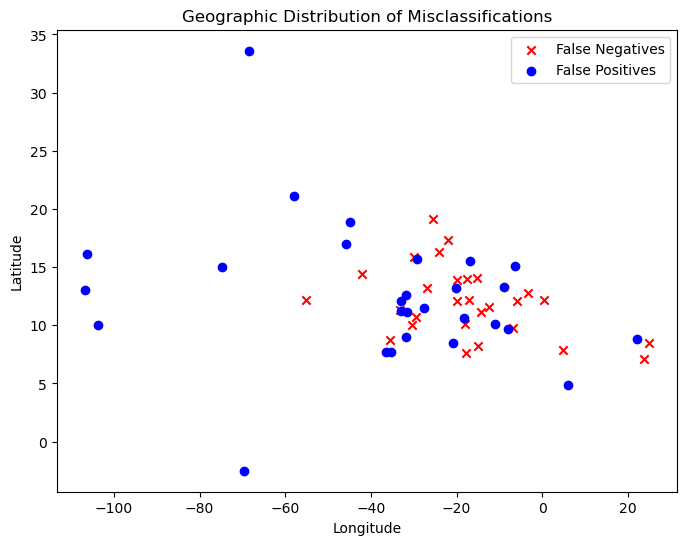

In [40]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.scatter(lon_false_neg, lat_false_neg, marker='x', color='red', label='False Negatives')
plt.scatter(lon_false_pos, lat_false_pos, marker='o', color='blue', label='False Positives')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Geographic Distribution of Misclassifications')
plt.legend()
plt.show()


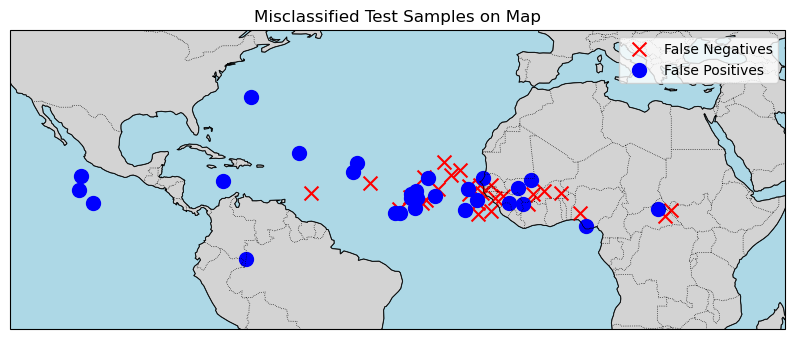

In [41]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
fig = plt.figure(figsize=(10, 8))
ax = plt.axes(projection=ccrs.PlateCarree())



lon_min, lon_max = np.min(lon_test)-15, np.max(lon_test)+15
lat_min, lat_max = np.min(lat_test)-15, np.max(lat_test)+15
ax.set_extent([lon_min, lon_max, lat_min, lat_max], crs=ccrs.PlateCarree())

# Add map features
ax.add_feature(cfeature.COASTLINE, linewidth=0.5)
ax.add_feature(cfeature.BORDERS, linestyle=':', linewidth=0.5)
ax.add_feature(cfeature.LAND, edgecolor='black', facecolor='lightgray')
ax.add_feature(cfeature.OCEAN, facecolor='lightblue')

# Plot misclassified points:
ax.scatter(lon_false_neg, lat_false_neg, color='red', marker='x', s=100,
           transform=ccrs.PlateCarree(), label='False Negatives')
ax.scatter(lon_false_pos, lat_false_pos, color='blue', marker='o', s=100,
           transform=ccrs.PlateCarree(), label='False Positives')

plt.title("Misclassified Test Samples on Map")
plt.legend()
plt.show()

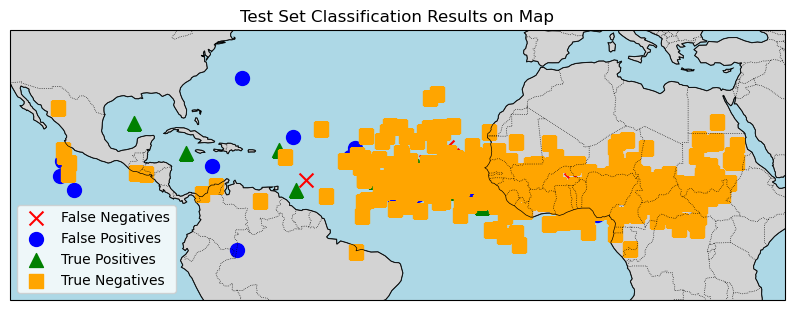

In [42]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

fig = plt.figure(figsize=(10, 8))
ax = plt.axes(projection=ccrs.PlateCarree())

# Set map extent (adjust margins as desired)
lon_min, lon_max = np.min(lon_test) - 10, np.max(lon_test) + 10
lat_min, lat_max = np.min(lat_test) - 10, np.max(lat_test) + 10
ax.set_extent([lon_min, lon_max, lat_min, lat_max], crs=ccrs.PlateCarree())

# Add map features
ax.add_feature(cfeature.COASTLINE, linewidth=0.5)
ax.add_feature(cfeature.BORDERS, linestyle=':', linewidth=0.5)
ax.add_feature(cfeature.LAND, facecolor='lightgray', edgecolor='black')
ax.add_feature(cfeature.OCEAN, facecolor='lightblue')
# Plot misclassified points
ax.scatter(lon_false_neg, lat_false_neg, color='red', marker='x', s=100,
           transform=ccrs.PlateCarree(), label='False Negatives')
ax.scatter(lon_false_pos, lat_false_pos, color='blue', marker='o', s=100,
           transform=ccrs.PlateCarree(), label='False Positives')



# Plot correctly classified points
ax.scatter(lon_true_pos, lat_true_pos, color='green', marker='^', s=100,
           transform=ccrs.PlateCarree(), label='True Positives')
ax.scatter(lon_true_neg, lat_true_neg, color='orange', marker='s', s=100,
           transform=ccrs.PlateCarree(), label='True Negatives')

plt.title("Test Set Classification Results on Map")
plt.legend()
plt.show()


In [43]:
print("Total samples:", len(sample_lat))
print("Unique latitudes:", len(np.unique(sample_lat)))
print("Unique longitudes:", len(np.unique(sample_lon)))


Total samples: 2750
Unique latitudes: 251
Unique longitudes: 913


In [44]:
print("First 10 latitudes:", sample_lat[:10])
print("First 10 longitudes:", sample_lon[:10])


First 10 latitudes: <xarray.DataArray 'lat_center' (sample: 10)> Size: 80B
dask.array<getitem, shape=(10,), dtype=float64, chunksize=(10,), chunktype=numpy.ndarray>
Coordinates:
    file_name   (sample) <U102 4kB dask.array<chunksize=(10,), meta=np.ndarray>
    lat_center  (sample) float64 80B dask.array<chunksize=(10,), meta=np.ndarray>
    lon_center  (sample) float64 80B dask.array<chunksize=(10,), meta=np.ndarray>
  * sample      (sample) int64 80B 1 1 1 1 1 1 1 1 1 1
    time        (sample) datetime64[ns] 80B dask.array<chunksize=(10,), meta=np.ndarray>
First 10 longitudes: <xarray.DataArray 'lon_center' (sample: 10)> Size: 80B
dask.array<getitem, shape=(10,), dtype=float64, chunksize=(10,), chunktype=numpy.ndarray>
Coordinates:
    file_name   (sample) <U102 4kB dask.array<chunksize=(10,), meta=np.ndarray>
    lat_center  (sample) float64 80B dask.array<chunksize=(10,), meta=np.ndarray>
    lon_center  (sample) float64 80B dask.array<chunksize=(10,), meta=np.ndarray>
  * sample 

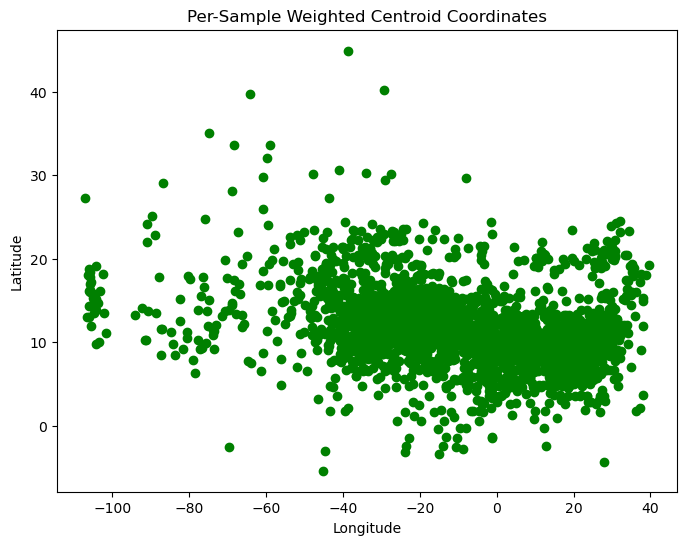

In [45]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.scatter(sample_lon, sample_lat, c='green', marker='o')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Per-Sample Weighted Centroid Coordinates')
plt.show()


In [46]:


# --- Permutation Importance ---
# Evaluate baseline performance using your loss metric (here, the custom f1_loss_sigmoid)
# model.metrics_names gives a list where index 0 is 'loss'
baseline_results = model.evaluate(input_test_scaled, label_test_scaled,
                                  batch_size=label_test_scaled.shape[0],
                                  verbose=0)
baseline_loss = baseline_results[model.metrics_names.index('loss')]
print("Baseline loss:", baseline_loss)

# Set the number of repetitions for averaging
n_repeats = 5
n_features = input_test_scaled.shape[-1]
permutation_importances = np.zeros(n_features)

# Loop over each feature (channel)
for feature_idx in range(n_features):
    permuted_losses = []
    for _ in range(n_repeats):
        # Copy the test set to avoid modifying the original
        X_permuted = np.copy(input_test_scaled)
        # Permute the values of the selected feature across samples
        perm = np.random.permutation(X_permuted.shape[0])
        X_permuted[:, :, :, feature_idx] = X_permuted[perm, :, :, feature_idx]
        
        # Evaluate the model on the permuted test set
        permuted_results = model.evaluate(X_permuted, label_test_scaled,
                                          batch_size=label_test_scaled.shape[0],
                                          verbose=0)
        permuted_loss = permuted_results[model.metrics_names.index('loss')]
        permuted_losses.append(permuted_loss)
    
    avg_permuted_loss = np.mean(permuted_losses)
    # The difference between the permuted loss and baseline loss indicates feature importance:
    # A larger increase means the feature is more important.
    permutation_importances[feature_idx] = avg_permuted_loss - baseline_loss
    print(f"Feature {feature_idx} - Increase in Loss: {permutation_importances[feature_idx]}")

print("Permutation Importances (increase in loss) for all features:", permutation_importances)


Baseline loss: 0.04093605652451515


Feature 0 - Increase in Loss: 0.004947203397750857


Feature 1 - Increase in Loss: -0.0002736322581768022


Feature 2 - Increase in Loss: -0.0009601011872291537


Feature 3 - Increase in Loss: -0.0007614985108375522


Feature 4 - Increase in Loss: -0.000844543427228929


Feature 5 - Increase in Loss: 0.0020486846566200242


Feature 6 - Increase in Loss: 0.003343884646892545


Feature 7 - Increase in Loss: 0.0023666657507419586


Feature 8 - Increase in Loss: 0.00011039003729820113


Feature 9 - Increase in Loss: 0.0012107297778129605


Feature 10 - Increase in Loss: 0.001632136106491086


Feature 11 - Increase in Loss: -0.0017360463738441481


Feature 12 - Increase in Loss: -0.00034989714622497836


Feature 13 - Increase in Loss: -0.0005063481628894834


Feature 14 - Increase in Loss: 0.0007169127464294461


Feature 15 - Increase in Loss: -0.002084264904260634


Feature 16 - Increase in Loss: 0.001866225153207779


Feature 17 - Increase in Loss: 0.0052389472723007174


Feature 18 - Increase in Loss: 0.0020820803940296145


Feature 19 - Increase in Loss: 0.003221978992223741


Feature 20 - Increase in Loss: 0.00021650716662406644


Feature 21 - Increase in Loss: -0.0002135030925273923


Feature 22 - Increase in Loss: 0.026357164978981024


Feature 23 - Increase in Loss: -3.300607204423378e-07


Feature 24 - Increase in Loss: 0.0018138870596885667


Feature 25 - Increase in Loss: 0.0009646169841289534


Feature 26 - Increase in Loss: -0.0010891512036323575


Feature 27 - Increase in Loss: -0.001693358272314073


Feature 28 - Increase in Loss: 8.715912699699263e-05


Feature 29 - Increase in Loss: -0.0037103608250617995


Feature 30 - Increase in Loss: -0.0021714024245738997


Feature 31 - Increase in Loss: -0.0013206489384174347


Feature 32 - Increase in Loss: -0.0010195583105087266


Feature 33 - Increase in Loss: -0.0029325082898139926


Feature 34 - Increase in Loss: 0.0003852069377899142


Feature 35 - Increase in Loss: 0.0012994386255741133
Permutation Importances (increase in loss) for all features: [ 4.94720340e-03 -2.73632258e-04 -9.60101187e-04 -7.61498511e-04
 -8.44543427e-04  2.04868466e-03  3.34388465e-03  2.36666575e-03
  1.10390037e-04  1.21072978e-03  1.63213611e-03 -1.73604637e-03
 -3.49897146e-04 -5.06348163e-04  7.16912746e-04 -2.08426490e-03
  1.86622515e-03  5.23894727e-03  2.08208039e-03  3.22197899e-03
  2.16507167e-04 -2.13503093e-04  2.63571650e-02 -3.30060720e-07
  1.81388706e-03  9.64616984e-04 -1.08915120e-03 -1.69335827e-03
  8.71591270e-05 -3.71036083e-03 -2.17140242e-03 -1.32064894e-03
 -1.01955831e-03 -2.93250829e-03  3.85206938e-04  1.29943863e-03]


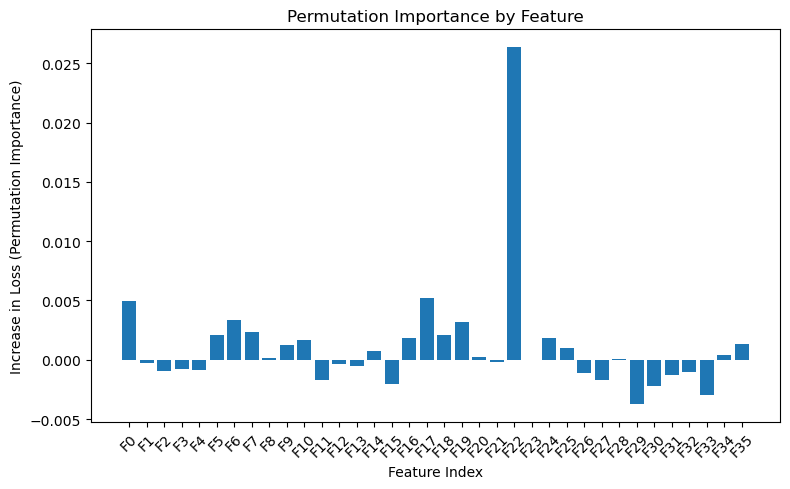

In [47]:
import matplotlib.pyplot as plt
import numpy as np

# Suppose permutation_importances is the numpy array you printed:
# e.g., [0.0820, 0.0824, 0.0815, 0.0864, 0.0121, ...]

feature_indices = np.arange(len(permutation_importances))

plt.figure(figsize=(8, 5))
plt.bar(feature_indices, permutation_importances)
plt.xlabel("Feature Index")
plt.ylabel("Increase in Loss (Permutation Importance)")
plt.title("Permutation Importance by Feature")
plt.xticks(feature_indices, [f"F{i}" for i in feature_indices], rotation=45)
plt.tight_layout()
plt.show()


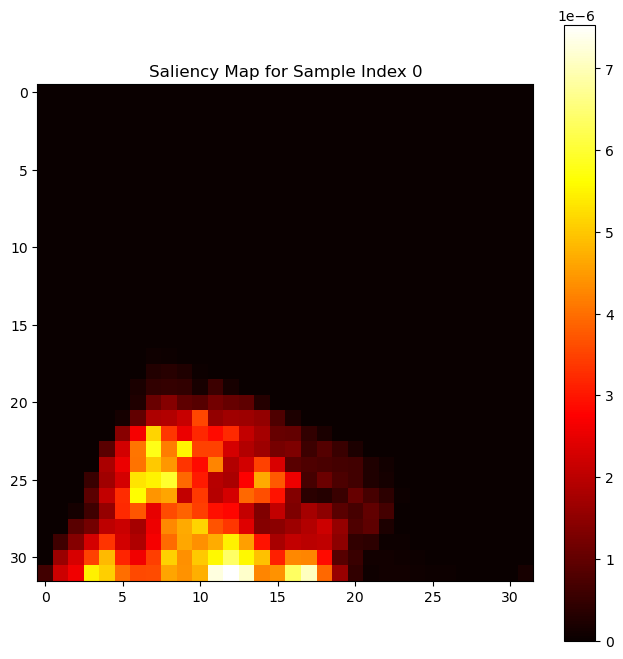

In [48]:
sample_index = 0
sample_input = input_test_scaled[sample_index:sample_index+1]

# Compute the saliency map for the selected test sample
saliency_map = compute_saliency_map(model, sample_input)

# Plot the saliency map
plt.figure(figsize=(8, 8))
plt.imshow(saliency_map, cmap='hot')
plt.colorbar()
plt.title(f"Saliency Map for Sample Index {sample_index}")
plt.show()



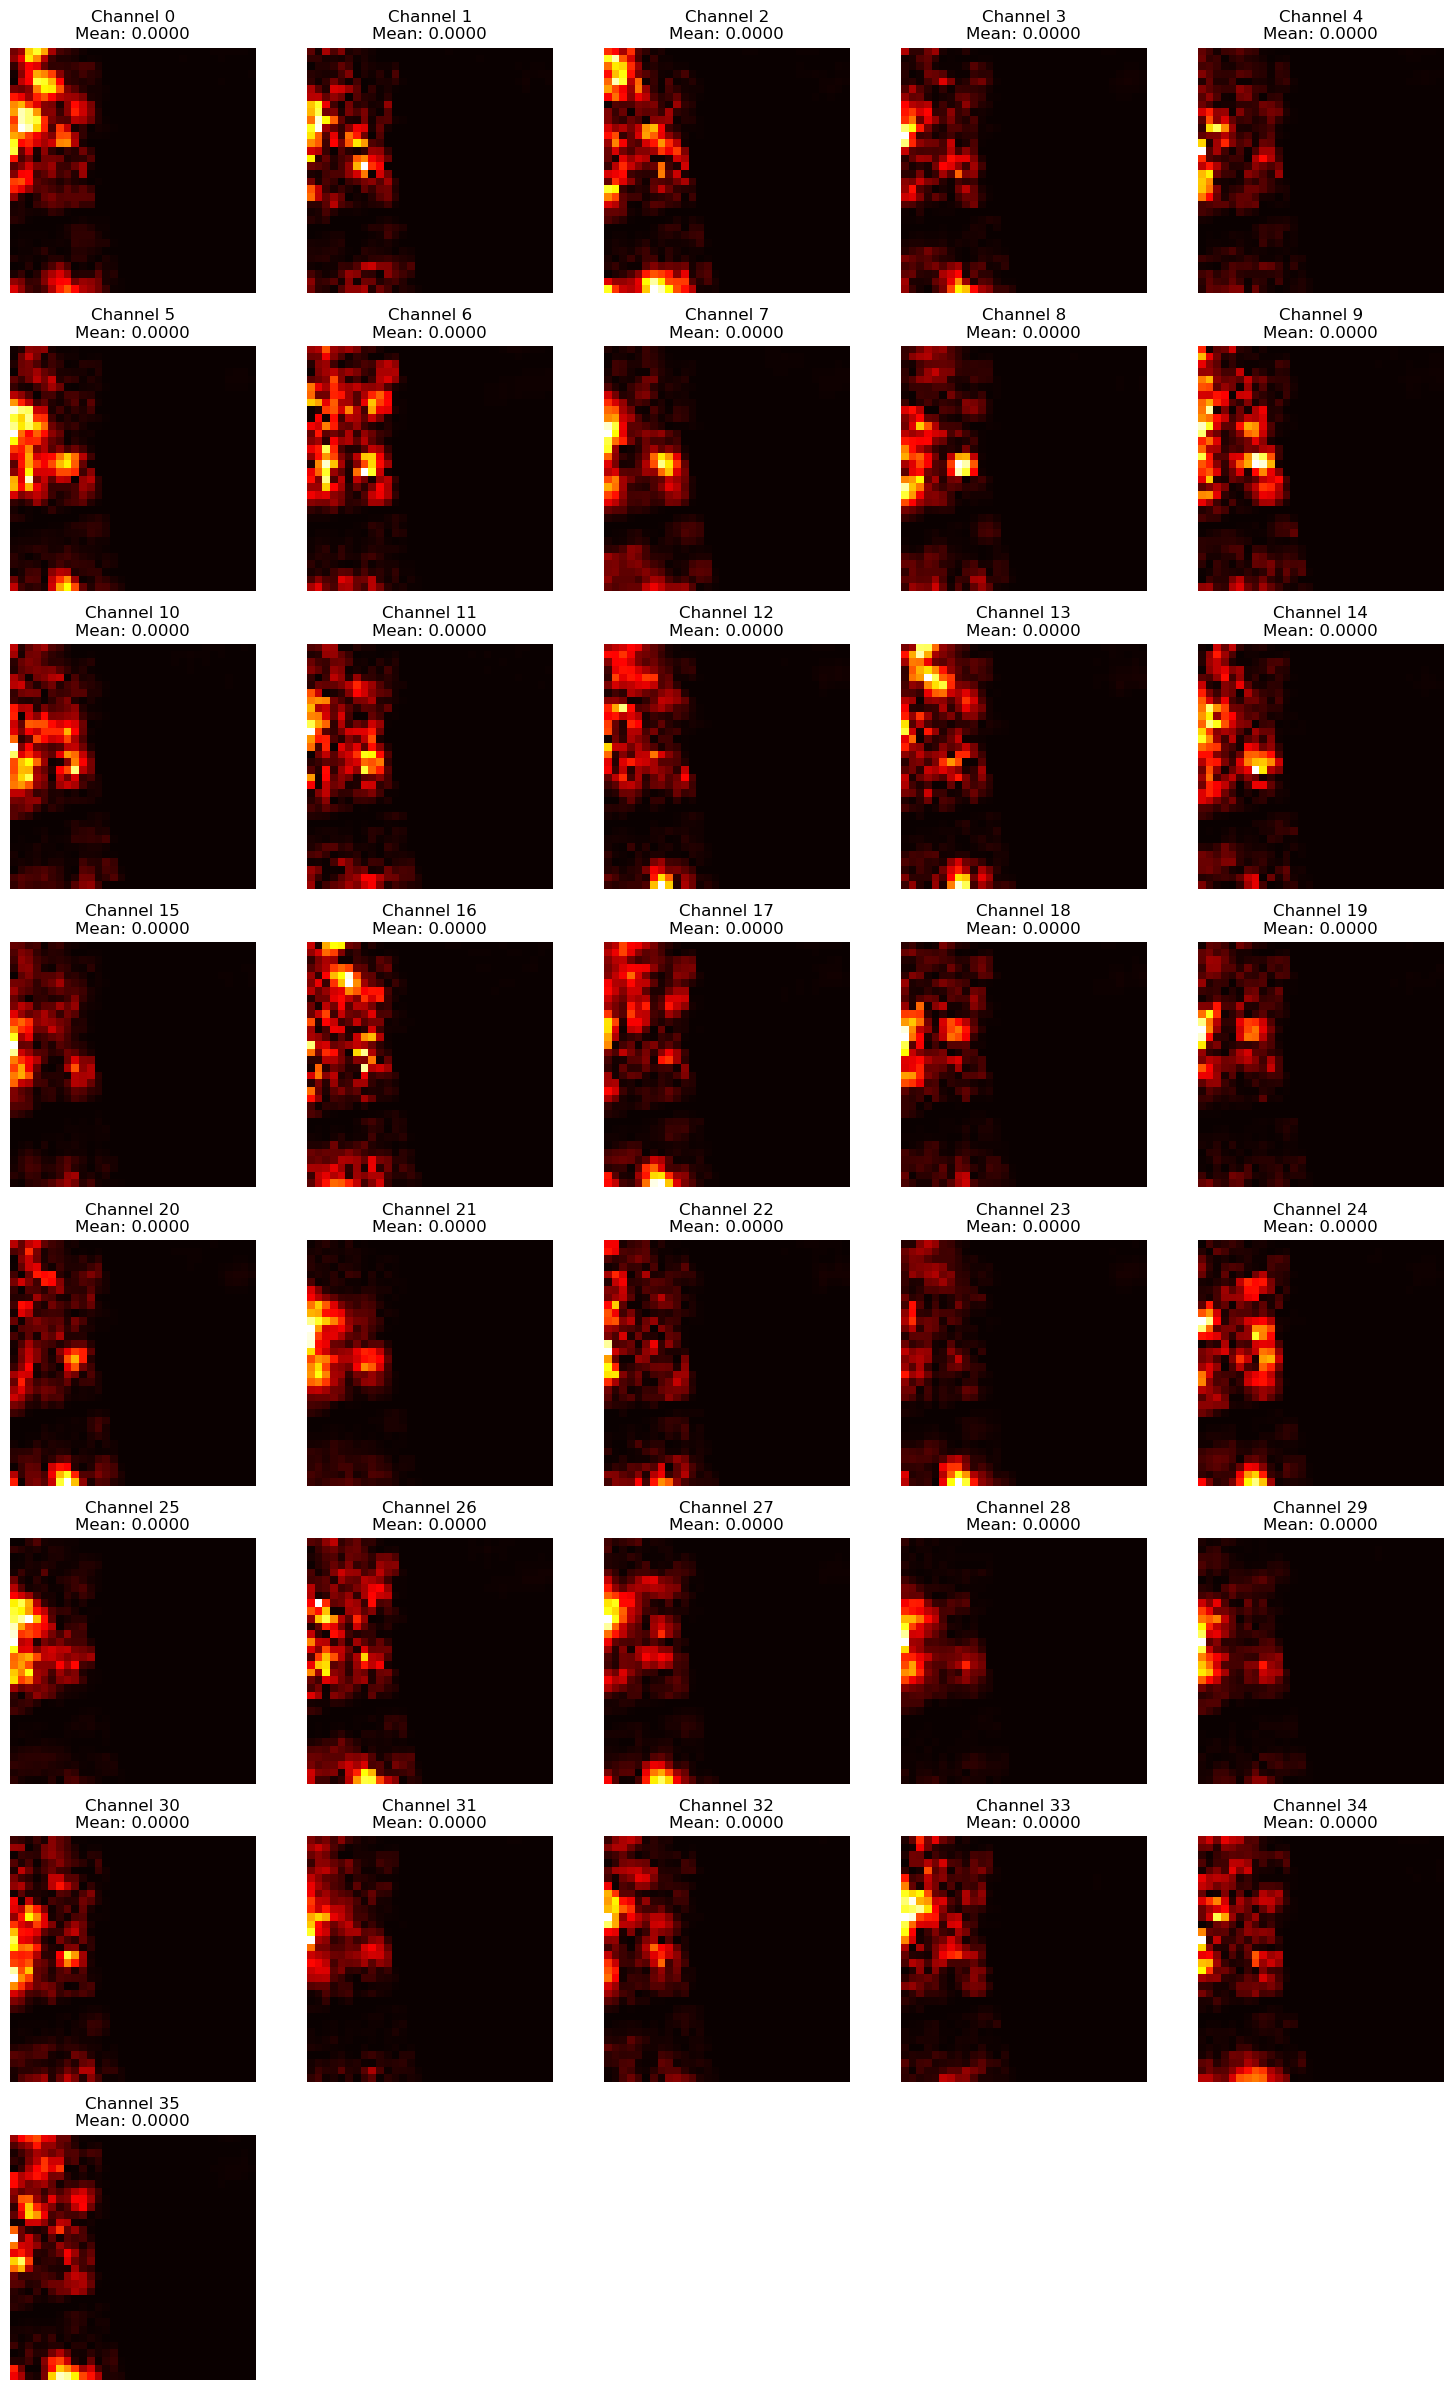

Channel importance (mean saliency per channel):
Channel 0: 0.0000
Channel 1: 0.0000
Channel 2: 0.0000
Channel 3: 0.0000
Channel 4: 0.0000
Channel 5: 0.0000
Channel 6: 0.0000
Channel 7: 0.0000
Channel 8: 0.0000
Channel 9: 0.0000
Channel 10: 0.0000
Channel 11: 0.0000
Channel 12: 0.0000
Channel 13: 0.0000
Channel 14: 0.0000
Channel 15: 0.0000
Channel 16: 0.0000
Channel 17: 0.0000
Channel 18: 0.0000
Channel 19: 0.0000
Channel 20: 0.0000
Channel 21: 0.0000
Channel 22: 0.0000
Channel 23: 0.0000
Channel 24: 0.0000
Channel 25: 0.0000
Channel 26: 0.0000
Channel 27: 0.0000
Channel 28: 0.0000
Channel 29: 0.0000
Channel 30: 0.0000
Channel 31: 0.0000
Channel 32: 0.0000
Channel 33: 0.0000
Channel 34: 0.0000
Channel 35: 0.0000


In [49]:
sample_index = 1
sample_input = input_test_scaled[sample_index:sample_index+1]

# Compute saliency maps per channel for the selected input sample
saliency_maps, channel_importance = compute_saliency_per_channel(model, sample_input)

# Plot the saliency maps for each channel
num_channels = saliency_maps.shape[-1]
cols = 5  # Set number of columns for plotting
rows = int(np.ceil(num_channels / cols))
plt.figure(figsize=(15, rows * 3))
for c in range(num_channels):
    plt.subplot(rows, cols, c + 1)
    plt.imshow(saliency_maps[:, :, c], cmap='hot')
    plt.title(f'Channel {c}\nMean: {channel_importance[c]:.4f}')
    plt.axis('off')
plt.tight_layout()
plt.show()

# Print aggregated channel importance values
print("Channel importance (mean saliency per channel):")
for c, imp in enumerate(channel_importance):
    print(f"Channel {c}: {imp:.4f}")


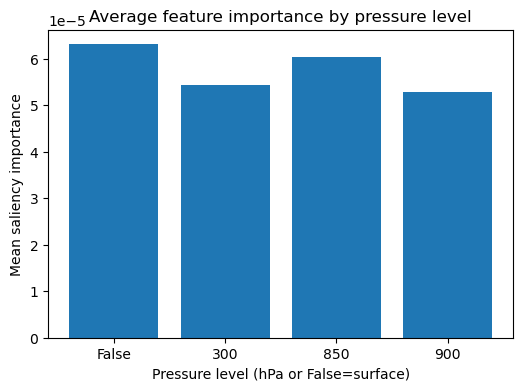

In [50]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 1) Compute per‑sample, per‑channel saliency importances
all_imps = []
for x in input_test_scaled:             # each x has shape (32,32,channels)
    _, imp = compute_saliency_per_channel(best_model, x[np.newaxis,...])
    all_imps.append(imp)               # imp.shape == (channels,)
all_imps = np.stack(all_imps)          # shape (N_samples, channels)

# 2) Average importance across samples
mean_imp = all_imps.mean(axis=0)       # shape (channels,)

# 3) Build a DataFrame mapping feature→plevel→importance
df = pd.DataFrame({
    "feature": var_list,
    "plevel": plevel_list,
    "importance": mean_imp
})

# 4) Group by pressure level and plot
grouped = df.groupby("plevel")["importance"].mean().reset_index()
plt.figure(figsize=(6,4))
plt.bar(grouped["plevel"].astype(str), grouped["importance"])
plt.xlabel("Pressure level (hPa or False=surface)")
plt.ylabel("Mean saliency importance")
plt.title("Average feature importance by pressure level")
plt.show()


{'loss': 0.04093605652451515, 'compile_metrics': 0.27759405970573425}
    f1_score  val_f1_score
95  0.649123      0.516129
96  0.644444      0.470588
97  0.639080      0.421053
98  0.631818      0.562500
99  0.608295      0.516129


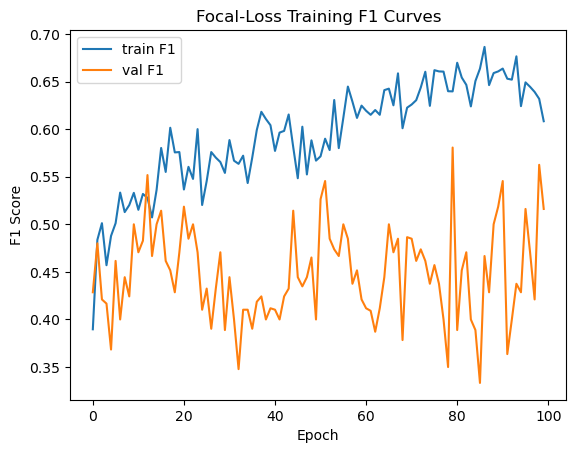

In [51]:
# 1) Print out full test‐set metrics by name
test_results = model.evaluate(
    input_test_scaled,
    label_test_scaled,
    batch_size=label_test_scaled.shape[0],
    verbose=0
)
print(dict(zip(model.metrics_names, test_results)))

# 2) Peek at the end of your training history for F1 improvements
import pandas as pd
hist_df = pd.DataFrame(history.history)
print(hist_df[['f1_score','val_f1_score']].tail())

# 3) (Optional) Plot train vs. val F1 over epochs
import matplotlib.pyplot as plt
plt.plot(hist_df['f1_score'],    label='train F1')
plt.plot(hist_df['val_f1_score'],label='val F1')
plt.xlabel('Epoch')
plt.ylabel('F1 Score')
plt.legend()
plt.title('Focal‐Loss Training F1 Curves')
plt.show()


In [52]:
# Replace your rebuild logic:
# top_hps = tuner.get_best_hyperparameters(num_trials=5)
# models  = [MyHyperModel().build(hp) for hp in top_hps]

# With this single line:
models = tuner.get_best_models(num_models=5)

# Then stack and average as before:
all_preds     = np.stack([m.predict(input_test_scaled).flatten() for m in models], axis=0)
ensemble_probs= all_preds.mean(axis=0)
ensemble_preds= (ensemble_probs >= 0.5).astype(int)
print("Ensemble F1:", f1_score(label_test_scaled, ensemble_preds))


/glade/u/home/rmandava/.local/lib/python3.10/site-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 22 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


 1/18 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


 1/18 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


 1/18 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


 1/18 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


 1/18 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


Ensemble F1: 0.4657534246575342
